## Create gesture (Guassian blur)

In [2]:
import cv2
import numpy as np
import pickle, os, sqlite3, random

image_x, image_y = 50, 50

def get_hand_hist():
    with open("hist", "rb") as f:
        hist = pickle.load(f)
    return hist

def init_create_folder_database():
    if not os.path.exists("gestures"):
        os.mkdir("gestures")
    if not os.path.exists("gesture_db.db"):
        conn = sqlite3.connect("gesture_db.db")
        create_table_cmd = "CREATE TABLE gesture ( g_id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, g_name TEXT NOT NULL )"
        conn.execute(create_table_cmd)
        conn.commit()

def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

def store_in_db(g_id, g_name):
    conn = sqlite3.connect("gesture_db.db")
    cmd = "INSERT INTO gesture (g_id, g_name) VALUES (%s, \'%s\')" % (g_id, g_name)
    try:
        conn.execute(cmd)
    except sqlite3.IntegrityError:
        choice = input("g_id already exists. Want to change the record? (y/n): ")
        if choice.lower() == 'y':
            cmd = "UPDATE gesture SET g_name = \'%s\' WHERE g_id = %s" % (g_name, g_id)
            conn.execute(cmd)
        else:
            print("Doing nothing...")
            return
    conn.commit()

    
def store_images(g_id):
    total_pics = 10000
    hist = get_hand_hist()
    cam = cv2.VideoCapture(0)
    if cam.read()[0]==False:
        cam = cv2.VideoCapture(0)
    x, y, w, h = 300, 100, 300, 300

    create_folder("gestures2/"+str(g_id))
    pic_no = 9000
    flag_start_capturing = False
    frames = 0

    while True:
        img = cam.read()[1]
        img = cv2.flip(img, 1)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #grayscale = grayscale[y:y+h, x:x+w]
        imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        imghsv = imgHSV[y:y+h, x:x+w]
       # hist =  cv2.calcHist([ROI],[0, 1], None, [180, 256], [0, 180, 0, 256])
        dst = cv2.calcBackProject([imgHSV], [0, 1], hist, [0, 180, 0, 256], 1)
        dst1 = dst.copy()
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
        cv2.filter2D(dst,-1,disc,dst)
        blur = cv2.GaussianBlur(dst, (11,11), 0)
        gblur = blur[y:y+h, x:x+w]
        blur = cv2.medianBlur(blur, 11)
        #ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        #thresh = cv2.merge((thresh,thresh,thresh))
        #thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
        #cv2.imshow("HSV", imghsv)
        #cv2.imshow("GaussianBlur", gblur)
        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        thresh = cv2.threshold(th3, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
        thresh = cv2.merge((thresh,thresh,thresh))
        thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
        thresh = thresh[y:y+h, x:x+w]
        tmp = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        contours = tmp[0] if len(tmp) == 2 else tmp[1]

        if len(contours) > 0:
            contour = max(contours, key = cv2.contourArea)
            if cv2.contourArea(contour) > 10000 and frames > 50:
                x1, y1, w1, h1 = cv2.boundingRect(contour)
                pic_no += 1
                save_img = thresh[y1:y1+h1, x1:x1+w1]
                if w1 > h1:
                    save_img = cv2.copyMakeBorder(save_img, int((w1-h1)/2) , int((w1-h1)/2) , 0, 0, cv2.BORDER_CONSTANT, (0, 0, 0))
                elif h1 > w1:
                    save_img = cv2.copyMakeBorder(save_img, 0, 0, int((h1-w1)/2) , int((h1-w1)/2) , cv2.BORDER_CONSTANT, (0, 0, 0))
                save_img = cv2.resize(save_img, (image_x, image_y))
                rand = random.randint(0, 10)
                if rand % 2 == 0:
                    save_img = cv2.flip(save_img, 1)
                cv2.putText(img, "Capturing...", (30, 60), cv2.FONT_HERSHEY_TRIPLEX, 2, (127, 255, 255))
                cv2.imwrite("gestures2/"+str(g_id)+"/"+str(pic_no)+".jpg", save_img)

        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(img, str(pic_no), (30, 400), cv2.FONT_HERSHEY_TRIPLEX, 1.5, (127, 127, 255))
        cv2.imshow("Capturing gesture", img)
        cv2.imshow("thresh", thresh)
        keypress = cv2.waitKey(1)
        if keypress == ord('c'):
            if flag_start_capturing == False:
                flag_start_capturing = True
            else:
                flag_start_capturing = False
                frames = 0
        if flag_start_capturing == True:
            frames += 1
        if pic_no == total_pics:
            cv2.destroyAllWindows()
            break
        if keypress == 27:
            cv2.destroyAllWindows()
            break

init_create_folder_database()
g_id = input("Enter gesture no.: ")
g_name = input("Enter gesture name/text: ")
store_in_db(g_id, g_name)
store_images(g_id)


Enter gesture no.: 35
Enter gesture name/text: king
g_id already exists. Want to change the record? (y/n): y


## Copy and flip the images in the database

In [4]:
import cv2, os

def flip_images():
    gest_folder = "gestures2"
    images_labels = []
    images = []
    labels = []
    for g_id in os.listdir(gest_folder):
        if (g_id == "1"):
            continue
        for i in range(10001, 11500):
            path = gest_folder+"/"+g_id+"/"+str(i)+".jpg"
            new_path = gest_folder+"/"+g_id+"/"+str(i)+".jpg"
            img = cv2.imread(path, 0)
            img = cv2.flip(img, 1)
            cv2.imwrite(new_path, img)

flip_images()

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgcodecs\src\loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [2]:
import cv2, os

def flip_images():
    gest_folder = "gestures2/1"
    images_labels = []
    images = []
    labels = []

    for i in range(10001, 11494):
        path = gest_folder+"/"+str(i)+".jpg"
        new_path = gest_folder+"/"+str(i+1493)+".jpg"
        img = cv2.imread(path, 0)
        img = cv2.flip(img, 1)
        cv2.imwrite(new_path, img)
            
flip_images()



## Create test, train data, label pickle file

In [ ]:
import cv2
from glob import glob
import numpy as np
import random
from sklearn.utils import shuffle
import pickle
import os

def pickle_images_labels():
    images_labels = []
    images = glob("gestures2/*/*.jpg")
    images.sort()
    for image in images:
        print(image)
        label = image[image.find(os.sep)+1: image.rfind(os.sep)]
        img = cv2.imread(image, 0)
        images_labels.append((np.array(img, dtype=np.uint8), int(label)))
    return images_labels

images_labels = pickle_images_labels()
images_labels = shuffle(shuffle(shuffle(shuffle(images_labels))))
images, labels = zip(*images_labels)
print("Length of images_labels", len(images_labels))

train_images = images[:int(5/6*len(images))]
print("Length of train_images", len(train_images))
with open("train_images", "wb") as f:
    pickle.dump(train_images, f)
del train_images

train_labels = labels[:int(5/6*len(labels))]
print("Length of train_labels", len(train_labels))
with open("train_labels", "wb") as f:
    pickle.dump(train_labels, f)
del train_labels

test_images = images[int(5/6*len(images)):int(11/12*len(images))]
print("Length of test_images", len(test_images))
with open("test_images", "wb") as f:
    pickle.dump(test_images, f)
del test_images

test_labels = labels[int(5/6*len(labels)):int(11/12*len(images))]
print("Length of test_labels", len(test_labels))
with open("test_labels", "wb") as f:
    pickle.dump(test_labels, f)
del test_labels

val_images = images[int(11/12*len(images)):]
print("Length of test_images", len(val_images))
with open("val_images", "wb") as f:
    pickle.dump(val_images, f)
del val_images

val_labels = labels[int(11/12*len(labels)):]
print("Length of val_labels", len(val_labels))
with open("val_labels", "wb") as f:
    pickle.dump(val_labels, f)
del val_labels

gestures2\10\1.jpg
gestures2\10\10.jpg
gestures2\10\100.jpg
gestures2\10\1000.jpg
gestures2\10\10000.jpg
gestures2\10\10001.jpg
gestures2\10\10002.jpg
gestures2\10\10003.jpg
gestures2\10\10004.jpg
gestures2\10\10005.jpg
gestures2\10\10006.jpg
gestures2\10\10007.jpg
gestures2\10\10008.jpg
gestures2\10\10009.jpg
gestures2\10\1001.jpg
gestures2\10\10010.jpg
gestures2\10\10011.jpg
gestures2\10\10012.jpg
gestures2\10\10013.jpg
gestures2\10\10014.jpg
gestures2\10\10015.jpg
gestures2\10\10016.jpg
gestures2\10\10017.jpg
gestures2\10\10018.jpg
gestures2\10\10019.jpg
gestures2\10\1002.jpg
gestures2\10\10020.jpg
gestures2\10\10021.jpg
gestures2\10\10022.jpg
gestures2\10\10023.jpg
gestures2\10\10024.jpg
gestures2\10\10025.jpg
gestures2\10\10026.jpg
gestures2\10\10027.jpg
gestures2\10\10028.jpg
gestures2\10\10029.jpg
gestures2\10\1003.jpg
gestures2\10\10030.jpg
gestures2\10\10031.jpg
gestures2\10\10032.jpg
gestures2\10\10033.jpg
gestures2\10\10034.jpg
gestures2\10\10035.jpg
gestures2\10\10036.jpg
g

gestures2\10\1033.jpg
gestures2\10\10330.jpg
gestures2\10\10331.jpg
gestures2\10\10332.jpg
gestures2\10\10333.jpg
gestures2\10\10334.jpg
gestures2\10\10335.jpg
gestures2\10\10336.jpg
gestures2\10\10337.jpg
gestures2\10\10338.jpg
gestures2\10\10339.jpg
gestures2\10\1034.jpg
gestures2\10\10340.jpg
gestures2\10\10341.jpg
gestures2\10\10342.jpg
gestures2\10\10343.jpg
gestures2\10\10344.jpg
gestures2\10\10345.jpg
gestures2\10\10346.jpg
gestures2\10\10347.jpg
gestures2\10\10348.jpg
gestures2\10\10349.jpg
gestures2\10\1035.jpg
gestures2\10\10350.jpg
gestures2\10\10351.jpg
gestures2\10\10352.jpg
gestures2\10\10353.jpg
gestures2\10\10354.jpg
gestures2\10\10355.jpg
gestures2\10\10356.jpg
gestures2\10\10357.jpg
gestures2\10\10358.jpg
gestures2\10\10359.jpg
gestures2\10\1036.jpg
gestures2\10\10360.jpg
gestures2\10\10361.jpg
gestures2\10\10362.jpg
gestures2\10\10363.jpg
gestures2\10\10364.jpg
gestures2\10\10365.jpg
gestures2\10\10366.jpg
gestures2\10\10367.jpg
gestures2\10\10368.jpg
gestures2\10\10

gestures2\10\10652.jpg
gestures2\10\10653.jpg
gestures2\10\10654.jpg
gestures2\10\10655.jpg
gestures2\10\10656.jpg
gestures2\10\10657.jpg
gestures2\10\10658.jpg
gestures2\10\10659.jpg
gestures2\10\1066.jpg
gestures2\10\10660.jpg
gestures2\10\10661.jpg
gestures2\10\10662.jpg
gestures2\10\10663.jpg
gestures2\10\10664.jpg
gestures2\10\10665.jpg
gestures2\10\10666.jpg
gestures2\10\10667.jpg
gestures2\10\10668.jpg
gestures2\10\10669.jpg
gestures2\10\1067.jpg
gestures2\10\10670.jpg
gestures2\10\10671.jpg
gestures2\10\10672.jpg
gestures2\10\10673.jpg
gestures2\10\10674.jpg
gestures2\10\10675.jpg
gestures2\10\10676.jpg
gestures2\10\10677.jpg
gestures2\10\10678.jpg
gestures2\10\10679.jpg
gestures2\10\1068.jpg
gestures2\10\10680.jpg
gestures2\10\10681.jpg
gestures2\10\10682.jpg
gestures2\10\10683.jpg
gestures2\10\10684.jpg
gestures2\10\10685.jpg
gestures2\10\10686.jpg
gestures2\10\10687.jpg
gestures2\10\10688.jpg
gestures2\10\10689.jpg
gestures2\10\1069.jpg
gestures2\10\10690.jpg
gestures2\10\10

gestures2\10\10976.jpg
gestures2\10\10977.jpg
gestures2\10\10978.jpg
gestures2\10\10979.jpg
gestures2\10\1098.jpg
gestures2\10\10980.jpg
gestures2\10\10981.jpg
gestures2\10\10982.jpg
gestures2\10\10983.jpg
gestures2\10\10984.jpg
gestures2\10\10985.jpg
gestures2\10\10986.jpg
gestures2\10\10987.jpg
gestures2\10\10988.jpg
gestures2\10\10989.jpg
gestures2\10\1099.jpg
gestures2\10\10990.jpg
gestures2\10\10991.jpg
gestures2\10\10992.jpg
gestures2\10\10993.jpg
gestures2\10\10994.jpg
gestures2\10\10995.jpg
gestures2\10\10996.jpg
gestures2\10\10997.jpg
gestures2\10\10998.jpg
gestures2\10\10999.jpg
gestures2\10\11.jpg
gestures2\10\110.jpg
gestures2\10\1100.jpg
gestures2\10\11000.jpg
gestures2\10\11001.jpg
gestures2\10\11002.jpg
gestures2\10\11003.jpg
gestures2\10\11004.jpg
gestures2\10\11005.jpg
gestures2\10\11006.jpg
gestures2\10\11007.jpg
gestures2\10\11008.jpg
gestures2\10\11009.jpg
gestures2\10\1101.jpg
gestures2\10\11010.jpg
gestures2\10\11011.jpg
gestures2\10\11012.jpg
gestures2\10\11013.j

gestures2\10\11309.jpg
gestures2\10\1131.jpg
gestures2\10\11310.jpg
gestures2\10\11311.jpg
gestures2\10\11312.jpg
gestures2\10\11313.jpg
gestures2\10\11314.jpg
gestures2\10\11315.jpg
gestures2\10\11316.jpg
gestures2\10\11317.jpg
gestures2\10\11318.jpg
gestures2\10\11319.jpg
gestures2\10\1132.jpg
gestures2\10\11320.jpg
gestures2\10\11321.jpg
gestures2\10\11322.jpg
gestures2\10\11323.jpg
gestures2\10\11324.jpg
gestures2\10\11325.jpg
gestures2\10\11326.jpg
gestures2\10\11327.jpg
gestures2\10\11328.jpg
gestures2\10\11329.jpg
gestures2\10\1133.jpg
gestures2\10\11330.jpg
gestures2\10\11331.jpg
gestures2\10\11332.jpg
gestures2\10\11333.jpg
gestures2\10\11334.jpg
gestures2\10\11335.jpg
gestures2\10\11336.jpg
gestures2\10\11337.jpg
gestures2\10\11338.jpg
gestures2\10\11339.jpg
gestures2\10\1134.jpg
gestures2\10\11340.jpg
gestures2\10\11341.jpg
gestures2\10\11342.jpg
gestures2\10\11343.jpg
gestures2\10\11344.jpg
gestures2\10\11345.jpg
gestures2\10\11346.jpg
gestures2\10\11347.jpg
gestures2\10\11

gestures2\10\1299.jpg
gestures2\10\13.jpg
gestures2\10\130.jpg
gestures2\10\1300.jpg
gestures2\10\1301.jpg
gestures2\10\1302.jpg
gestures2\10\1303.jpg
gestures2\10\1304.jpg
gestures2\10\1305.jpg
gestures2\10\1306.jpg
gestures2\10\1307.jpg
gestures2\10\1308.jpg
gestures2\10\1309.jpg
gestures2\10\131.jpg
gestures2\10\1310.jpg
gestures2\10\1311.jpg
gestures2\10\1312.jpg
gestures2\10\1313.jpg
gestures2\10\1314.jpg
gestures2\10\1315.jpg
gestures2\10\1316.jpg
gestures2\10\1317.jpg
gestures2\10\1318.jpg
gestures2\10\1319.jpg
gestures2\10\132.jpg
gestures2\10\1320.jpg
gestures2\10\1321.jpg
gestures2\10\1322.jpg
gestures2\10\1323.jpg
gestures2\10\1324.jpg
gestures2\10\1325.jpg
gestures2\10\1326.jpg
gestures2\10\1327.jpg
gestures2\10\1328.jpg
gestures2\10\1329.jpg
gestures2\10\133.jpg
gestures2\10\1330.jpg
gestures2\10\1331.jpg
gestures2\10\1332.jpg
gestures2\10\1333.jpg
gestures2\10\1334.jpg
gestures2\10\1335.jpg
gestures2\10\1336.jpg
gestures2\10\1337.jpg
gestures2\10\1338.jpg
gestures2\10\133

gestures2\10\1641.jpg
gestures2\10\1642.jpg
gestures2\10\1643.jpg
gestures2\10\1644.jpg
gestures2\10\1645.jpg
gestures2\10\1646.jpg
gestures2\10\1647.jpg
gestures2\10\1648.jpg
gestures2\10\1649.jpg
gestures2\10\165.jpg
gestures2\10\1650.jpg
gestures2\10\1651.jpg
gestures2\10\1652.jpg
gestures2\10\1653.jpg
gestures2\10\1654.jpg
gestures2\10\1655.jpg
gestures2\10\1656.jpg
gestures2\10\1657.jpg
gestures2\10\1658.jpg
gestures2\10\1659.jpg
gestures2\10\166.jpg
gestures2\10\1660.jpg
gestures2\10\1661.jpg
gestures2\10\1662.jpg
gestures2\10\1663.jpg
gestures2\10\1664.jpg
gestures2\10\1665.jpg
gestures2\10\1666.jpg
gestures2\10\1667.jpg
gestures2\10\1668.jpg
gestures2\10\1669.jpg
gestures2\10\167.jpg
gestures2\10\1670.jpg
gestures2\10\1671.jpg
gestures2\10\1672.jpg
gestures2\10\1673.jpg
gestures2\10\1674.jpg
gestures2\10\1675.jpg
gestures2\10\1676.jpg
gestures2\10\1677.jpg
gestures2\10\1678.jpg
gestures2\10\1679.jpg
gestures2\10\168.jpg
gestures2\10\1680.jpg
gestures2\10\1681.jpg
gestures2\10\1

gestures2\10\2006.jpg
gestures2\10\2007.jpg
gestures2\10\2008.jpg
gestures2\10\2009.jpg
gestures2\10\201.jpg
gestures2\10\2010.jpg
gestures2\10\2011.jpg
gestures2\10\2012.jpg
gestures2\10\2013.jpg
gestures2\10\2014.jpg
gestures2\10\2015.jpg
gestures2\10\2016.jpg
gestures2\10\2017.jpg
gestures2\10\2018.jpg
gestures2\10\2019.jpg
gestures2\10\202.jpg
gestures2\10\2020.jpg
gestures2\10\2021.jpg
gestures2\10\2022.jpg
gestures2\10\2023.jpg
gestures2\10\2024.jpg
gestures2\10\2025.jpg
gestures2\10\2026.jpg
gestures2\10\2027.jpg
gestures2\10\2028.jpg
gestures2\10\2029.jpg
gestures2\10\203.jpg
gestures2\10\2030.jpg
gestures2\10\2031.jpg
gestures2\10\2032.jpg
gestures2\10\2033.jpg
gestures2\10\2034.jpg
gestures2\10\2035.jpg
gestures2\10\2036.jpg
gestures2\10\2037.jpg
gestures2\10\2038.jpg
gestures2\10\2039.jpg
gestures2\10\204.jpg
gestures2\10\2040.jpg
gestures2\10\2041.jpg
gestures2\10\2042.jpg
gestures2\10\2043.jpg
gestures2\10\2044.jpg
gestures2\10\2045.jpg
gestures2\10\2046.jpg
gestures2\10\2

gestures2\10\2344.jpg
gestures2\10\2345.jpg
gestures2\10\2346.jpg
gestures2\10\2347.jpg
gestures2\10\2348.jpg
gestures2\10\2349.jpg
gestures2\10\235.jpg
gestures2\10\2350.jpg
gestures2\10\2351.jpg
gestures2\10\2352.jpg
gestures2\10\2353.jpg
gestures2\10\2354.jpg
gestures2\10\2355.jpg
gestures2\10\2356.jpg
gestures2\10\2357.jpg
gestures2\10\2358.jpg
gestures2\10\2359.jpg
gestures2\10\236.jpg
gestures2\10\2360.jpg
gestures2\10\2361.jpg
gestures2\10\2362.jpg
gestures2\10\2363.jpg
gestures2\10\2364.jpg
gestures2\10\2365.jpg
gestures2\10\2366.jpg
gestures2\10\2367.jpg
gestures2\10\2368.jpg
gestures2\10\2369.jpg
gestures2\10\237.jpg
gestures2\10\2370.jpg
gestures2\10\2371.jpg
gestures2\10\2372.jpg
gestures2\10\2373.jpg
gestures2\10\2374.jpg
gestures2\10\2375.jpg
gestures2\10\2376.jpg
gestures2\10\2377.jpg
gestures2\10\2378.jpg
gestures2\10\2379.jpg
gestures2\10\238.jpg
gestures2\10\2380.jpg
gestures2\10\2381.jpg
gestures2\10\2382.jpg
gestures2\10\2383.jpg
gestures2\10\2384.jpg
gestures2\10\2

gestures2\10\2683.jpg
gestures2\10\2684.jpg
gestures2\10\2685.jpg
gestures2\10\2686.jpg
gestures2\10\2687.jpg
gestures2\10\2688.jpg
gestures2\10\2689.jpg
gestures2\10\269.jpg
gestures2\10\2690.jpg
gestures2\10\2691.jpg
gestures2\10\2692.jpg
gestures2\10\2693.jpg
gestures2\10\2694.jpg
gestures2\10\2695.jpg
gestures2\10\2696.jpg
gestures2\10\2697.jpg
gestures2\10\2698.jpg
gestures2\10\2699.jpg
gestures2\10\27.jpg
gestures2\10\270.jpg
gestures2\10\2700.jpg
gestures2\10\2701.jpg
gestures2\10\2702.jpg
gestures2\10\2703.jpg
gestures2\10\2704.jpg
gestures2\10\2705.jpg
gestures2\10\2706.jpg
gestures2\10\2707.jpg
gestures2\10\2708.jpg
gestures2\10\2709.jpg
gestures2\10\271.jpg
gestures2\10\2710.jpg
gestures2\10\2711.jpg
gestures2\10\2712.jpg
gestures2\10\2713.jpg
gestures2\10\2714.jpg
gestures2\10\2715.jpg
gestures2\10\2716.jpg
gestures2\10\2717.jpg
gestures2\10\2718.jpg
gestures2\10\2719.jpg
gestures2\10\272.jpg
gestures2\10\2720.jpg
gestures2\10\2721.jpg
gestures2\10\2722.jpg
gestures2\10\272

gestures2\10\3022.jpg
gestures2\10\3023.jpg
gestures2\10\3024.jpg
gestures2\10\3025.jpg
gestures2\10\3026.jpg
gestures2\10\3027.jpg
gestures2\10\3028.jpg
gestures2\10\3029.jpg
gestures2\10\303.jpg
gestures2\10\3030.jpg
gestures2\10\3031.jpg
gestures2\10\3032.jpg
gestures2\10\3033.jpg
gestures2\10\3034.jpg
gestures2\10\3035.jpg
gestures2\10\3036.jpg
gestures2\10\3037.jpg
gestures2\10\3038.jpg
gestures2\10\3039.jpg
gestures2\10\304.jpg
gestures2\10\3040.jpg
gestures2\10\3041.jpg
gestures2\10\3042.jpg
gestures2\10\3043.jpg
gestures2\10\3044.jpg
gestures2\10\3045.jpg
gestures2\10\3046.jpg
gestures2\10\3047.jpg
gestures2\10\3048.jpg
gestures2\10\3049.jpg
gestures2\10\305.jpg
gestures2\10\3050.jpg
gestures2\10\3051.jpg
gestures2\10\3052.jpg
gestures2\10\3053.jpg
gestures2\10\3054.jpg
gestures2\10\3055.jpg
gestures2\10\3056.jpg
gestures2\10\3057.jpg
gestures2\10\3058.jpg
gestures2\10\3059.jpg
gestures2\10\306.jpg
gestures2\10\3060.jpg
gestures2\10\3061.jpg
gestures2\10\3062.jpg
gestures2\10\3

gestures2\10\3361.jpg
gestures2\10\3362.jpg
gestures2\10\3363.jpg
gestures2\10\3364.jpg
gestures2\10\3365.jpg
gestures2\10\3366.jpg
gestures2\10\3367.jpg
gestures2\10\3368.jpg
gestures2\10\3369.jpg
gestures2\10\337.jpg
gestures2\10\3370.jpg
gestures2\10\3371.jpg
gestures2\10\3372.jpg
gestures2\10\3373.jpg
gestures2\10\3374.jpg
gestures2\10\3375.jpg
gestures2\10\3376.jpg
gestures2\10\3377.jpg
gestures2\10\3378.jpg
gestures2\10\3379.jpg
gestures2\10\338.jpg
gestures2\10\3380.jpg
gestures2\10\3381.jpg
gestures2\10\3382.jpg
gestures2\10\3383.jpg
gestures2\10\3384.jpg
gestures2\10\3385.jpg
gestures2\10\3386.jpg
gestures2\10\3387.jpg
gestures2\10\3388.jpg
gestures2\10\3389.jpg
gestures2\10\339.jpg
gestures2\10\3390.jpg
gestures2\10\3391.jpg
gestures2\10\3392.jpg
gestures2\10\3393.jpg
gestures2\10\3394.jpg
gestures2\10\3395.jpg
gestures2\10\3396.jpg
gestures2\10\3397.jpg
gestures2\10\3398.jpg
gestures2\10\3399.jpg
gestures2\10\34.jpg
gestures2\10\340.jpg
gestures2\10\3400.jpg
gestures2\10\340

gestures2\10\3721.jpg
gestures2\10\3722.jpg
gestures2\10\3723.jpg
gestures2\10\3724.jpg
gestures2\10\3725.jpg
gestures2\10\3726.jpg
gestures2\10\3727.jpg
gestures2\10\3728.jpg
gestures2\10\3729.jpg
gestures2\10\373.jpg
gestures2\10\3730.jpg
gestures2\10\3731.jpg
gestures2\10\3732.jpg
gestures2\10\3733.jpg
gestures2\10\3734.jpg
gestures2\10\3735.jpg
gestures2\10\3736.jpg
gestures2\10\3737.jpg
gestures2\10\3738.jpg
gestures2\10\3739.jpg
gestures2\10\374.jpg
gestures2\10\3740.jpg
gestures2\10\3741.jpg
gestures2\10\3742.jpg
gestures2\10\3743.jpg
gestures2\10\3744.jpg
gestures2\10\3745.jpg
gestures2\10\3746.jpg
gestures2\10\3747.jpg
gestures2\10\3748.jpg
gestures2\10\3749.jpg
gestures2\10\375.jpg
gestures2\10\3750.jpg
gestures2\10\3751.jpg
gestures2\10\3752.jpg
gestures2\10\3753.jpg
gestures2\10\3754.jpg
gestures2\10\3755.jpg
gestures2\10\3756.jpg
gestures2\10\3757.jpg
gestures2\10\3758.jpg
gestures2\10\3759.jpg
gestures2\10\376.jpg
gestures2\10\3760.jpg
gestures2\10\3761.jpg
gestures2\10\3

gestures2\10\4064.jpg
gestures2\10\4065.jpg
gestures2\10\4066.jpg
gestures2\10\4067.jpg
gestures2\10\4068.jpg
gestures2\10\4069.jpg
gestures2\10\407.jpg
gestures2\10\4070.jpg
gestures2\10\4071.jpg
gestures2\10\4072.jpg
gestures2\10\4073.jpg
gestures2\10\4074.jpg
gestures2\10\4075.jpg
gestures2\10\4076.jpg
gestures2\10\4077.jpg
gestures2\10\4078.jpg
gestures2\10\4079.jpg
gestures2\10\408.jpg
gestures2\10\4080.jpg
gestures2\10\4081.jpg
gestures2\10\4082.jpg
gestures2\10\4083.jpg
gestures2\10\4084.jpg
gestures2\10\4085.jpg
gestures2\10\4086.jpg
gestures2\10\4087.jpg
gestures2\10\4088.jpg
gestures2\10\4089.jpg
gestures2\10\409.jpg
gestures2\10\4090.jpg
gestures2\10\4091.jpg
gestures2\10\4092.jpg
gestures2\10\4093.jpg
gestures2\10\4094.jpg
gestures2\10\4095.jpg
gestures2\10\4096.jpg
gestures2\10\4097.jpg
gestures2\10\4098.jpg
gestures2\10\4099.jpg
gestures2\10\41.jpg
gestures2\10\410.jpg
gestures2\10\4100.jpg
gestures2\10\4101.jpg
gestures2\10\4102.jpg
gestures2\10\4103.jpg
gestures2\10\410

gestures2\10\4401.jpg
gestures2\10\4402.jpg
gestures2\10\4403.jpg
gestures2\10\4404.jpg
gestures2\10\4405.jpg
gestures2\10\4406.jpg
gestures2\10\4407.jpg
gestures2\10\4408.jpg
gestures2\10\4409.jpg
gestures2\10\441.jpg
gestures2\10\4410.jpg
gestures2\10\4411.jpg
gestures2\10\4412.jpg
gestures2\10\4413.jpg
gestures2\10\4414.jpg
gestures2\10\4415.jpg
gestures2\10\4416.jpg
gestures2\10\4417.jpg
gestures2\10\4418.jpg
gestures2\10\4419.jpg
gestures2\10\442.jpg
gestures2\10\4420.jpg
gestures2\10\4421.jpg
gestures2\10\4422.jpg
gestures2\10\4423.jpg
gestures2\10\4424.jpg
gestures2\10\4425.jpg
gestures2\10\4426.jpg
gestures2\10\4427.jpg
gestures2\10\4428.jpg
gestures2\10\4429.jpg
gestures2\10\443.jpg
gestures2\10\4430.jpg
gestures2\10\4431.jpg
gestures2\10\4432.jpg
gestures2\10\4433.jpg
gestures2\10\4434.jpg
gestures2\10\4435.jpg
gestures2\10\4436.jpg
gestures2\10\4437.jpg
gestures2\10\4438.jpg
gestures2\10\4439.jpg
gestures2\10\444.jpg
gestures2\10\4440.jpg
gestures2\10\4441.jpg
gestures2\10\4

gestures2\10\723.jpg
gestures2\10\724.jpg
gestures2\10\725.jpg
gestures2\10\726.jpg
gestures2\10\727.jpg
gestures2\10\728.jpg
gestures2\10\729.jpg
gestures2\10\73.jpg
gestures2\10\730.jpg
gestures2\10\731.jpg
gestures2\10\732.jpg
gestures2\10\733.jpg
gestures2\10\734.jpg
gestures2\10\735.jpg
gestures2\10\736.jpg
gestures2\10\737.jpg
gestures2\10\738.jpg
gestures2\10\739.jpg
gestures2\10\74.jpg
gestures2\10\740.jpg
gestures2\10\741.jpg
gestures2\10\742.jpg
gestures2\10\743.jpg
gestures2\10\744.jpg
gestures2\10\745.jpg
gestures2\10\746.jpg
gestures2\10\747.jpg
gestures2\10\748.jpg
gestures2\10\749.jpg
gestures2\10\75.jpg
gestures2\10\750.jpg
gestures2\10\7502.jpg
gestures2\10\7503.jpg
gestures2\10\7504.jpg
gestures2\10\7505.jpg
gestures2\10\7506.jpg
gestures2\10\7507.jpg
gestures2\10\7508.jpg
gestures2\10\7509.jpg
gestures2\10\751.jpg
gestures2\10\7510.jpg
gestures2\10\7511.jpg
gestures2\10\7512.jpg
gestures2\10\7513.jpg
gestures2\10\7514.jpg
gestures2\10\7515.jpg
gestures2\10\7516.jpg
g

gestures2\10\7820.jpg
gestures2\10\7821.jpg
gestures2\10\7822.jpg
gestures2\10\7823.jpg
gestures2\10\7824.jpg
gestures2\10\7825.jpg
gestures2\10\7826.jpg
gestures2\10\7827.jpg
gestures2\10\7828.jpg
gestures2\10\7829.jpg
gestures2\10\783.jpg
gestures2\10\7830.jpg
gestures2\10\7831.jpg
gestures2\10\7832.jpg
gestures2\10\7833.jpg
gestures2\10\7834.jpg
gestures2\10\7835.jpg
gestures2\10\7836.jpg
gestures2\10\7837.jpg
gestures2\10\7838.jpg
gestures2\10\7839.jpg
gestures2\10\784.jpg
gestures2\10\7840.jpg
gestures2\10\7841.jpg
gestures2\10\7842.jpg
gestures2\10\7843.jpg
gestures2\10\7844.jpg
gestures2\10\7845.jpg
gestures2\10\7846.jpg
gestures2\10\7847.jpg
gestures2\10\7848.jpg
gestures2\10\7849.jpg
gestures2\10\785.jpg
gestures2\10\7850.jpg
gestures2\10\7851.jpg
gestures2\10\7852.jpg
gestures2\10\7853.jpg
gestures2\10\7854.jpg
gestures2\10\7855.jpg
gestures2\10\7856.jpg
gestures2\10\7857.jpg
gestures2\10\7858.jpg
gestures2\10\7859.jpg
gestures2\10\786.jpg
gestures2\10\7860.jpg
gestures2\10\7

gestures2\10\816.jpg
gestures2\10\8160.jpg
gestures2\10\8161.jpg
gestures2\10\8162.jpg
gestures2\10\8163.jpg
gestures2\10\8164.jpg
gestures2\10\8165.jpg
gestures2\10\8166.jpg
gestures2\10\8167.jpg
gestures2\10\8168.jpg
gestures2\10\8169.jpg
gestures2\10\817.jpg
gestures2\10\8170.jpg
gestures2\10\8171.jpg
gestures2\10\8172.jpg
gestures2\10\8173.jpg
gestures2\10\8174.jpg
gestures2\10\8175.jpg
gestures2\10\8176.jpg
gestures2\10\8177.jpg
gestures2\10\8178.jpg
gestures2\10\8179.jpg
gestures2\10\818.jpg
gestures2\10\8180.jpg
gestures2\10\8181.jpg
gestures2\10\8182.jpg
gestures2\10\8183.jpg
gestures2\10\8184.jpg
gestures2\10\8185.jpg
gestures2\10\8186.jpg
gestures2\10\8187.jpg
gestures2\10\8188.jpg
gestures2\10\8189.jpg
gestures2\10\819.jpg
gestures2\10\8190.jpg
gestures2\10\8191.jpg
gestures2\10\8192.jpg
gestures2\10\8193.jpg
gestures2\10\8194.jpg
gestures2\10\8195.jpg
gestures2\10\8196.jpg
gestures2\10\8197.jpg
gestures2\10\8198.jpg
gestures2\10\8199.jpg
gestures2\10\82.jpg
gestures2\10\820

gestures2\10\8500.jpg
gestures2\10\8501.jpg
gestures2\10\8502.jpg
gestures2\10\8503.jpg
gestures2\10\8504.jpg
gestures2\10\8505.jpg
gestures2\10\8506.jpg
gestures2\10\8507.jpg
gestures2\10\8508.jpg
gestures2\10\8509.jpg
gestures2\10\851.jpg
gestures2\10\8510.jpg
gestures2\10\8511.jpg
gestures2\10\8512.jpg
gestures2\10\8513.jpg
gestures2\10\8514.jpg
gestures2\10\8515.jpg
gestures2\10\8516.jpg
gestures2\10\8517.jpg
gestures2\10\8518.jpg
gestures2\10\8519.jpg
gestures2\10\852.jpg
gestures2\10\8520.jpg
gestures2\10\8521.jpg
gestures2\10\8522.jpg
gestures2\10\8523.jpg
gestures2\10\8524.jpg
gestures2\10\8525.jpg
gestures2\10\8526.jpg
gestures2\10\8527.jpg
gestures2\10\8528.jpg
gestures2\10\8529.jpg
gestures2\10\853.jpg
gestures2\10\8530.jpg
gestures2\10\8531.jpg
gestures2\10\8532.jpg
gestures2\10\8533.jpg
gestures2\10\8534.jpg
gestures2\10\8535.jpg
gestures2\10\8536.jpg
gestures2\10\8537.jpg
gestures2\10\8538.jpg
gestures2\10\8539.jpg
gestures2\10\854.jpg
gestures2\10\8540.jpg
gestures2\10\8

gestures2\10\884.jpg
gestures2\10\8840.jpg
gestures2\10\8841.jpg
gestures2\10\8842.jpg
gestures2\10\8843.jpg
gestures2\10\8844.jpg
gestures2\10\8845.jpg
gestures2\10\8846.jpg
gestures2\10\8847.jpg
gestures2\10\8848.jpg
gestures2\10\8849.jpg
gestures2\10\885.jpg
gestures2\10\8850.jpg
gestures2\10\8851.jpg
gestures2\10\8852.jpg
gestures2\10\8853.jpg
gestures2\10\8854.jpg
gestures2\10\8855.jpg
gestures2\10\8856.jpg
gestures2\10\8857.jpg
gestures2\10\8858.jpg
gestures2\10\8859.jpg
gestures2\10\886.jpg
gestures2\10\8860.jpg
gestures2\10\8861.jpg
gestures2\10\8862.jpg
gestures2\10\8863.jpg
gestures2\10\8864.jpg
gestures2\10\8865.jpg
gestures2\10\8866.jpg
gestures2\10\8867.jpg
gestures2\10\8868.jpg
gestures2\10\8869.jpg
gestures2\10\887.jpg
gestures2\10\8870.jpg
gestures2\10\8871.jpg
gestures2\10\8872.jpg
gestures2\10\8873.jpg
gestures2\10\8874.jpg
gestures2\10\8875.jpg
gestures2\10\8876.jpg
gestures2\10\8877.jpg
gestures2\10\8878.jpg
gestures2\10\8879.jpg
gestures2\10\888.jpg
gestures2\10\88

gestures2\10\9178.jpg
gestures2\10\9179.jpg
gestures2\10\918.jpg
gestures2\10\9180.jpg
gestures2\10\9181.jpg
gestures2\10\9182.jpg
gestures2\10\9183.jpg
gestures2\10\9184.jpg
gestures2\10\9185.jpg
gestures2\10\9186.jpg
gestures2\10\9187.jpg
gestures2\10\9188.jpg
gestures2\10\9189.jpg
gestures2\10\919.jpg
gestures2\10\9190.jpg
gestures2\10\9191.jpg
gestures2\10\9192.jpg
gestures2\10\9193.jpg
gestures2\10\9194.jpg
gestures2\10\9195.jpg
gestures2\10\9196.jpg
gestures2\10\9197.jpg
gestures2\10\9198.jpg
gestures2\10\9199.jpg
gestures2\10\92.jpg
gestures2\10\920.jpg
gestures2\10\9200.jpg
gestures2\10\9201.jpg
gestures2\10\9202.jpg
gestures2\10\9203.jpg
gestures2\10\9204.jpg
gestures2\10\9205.jpg
gestures2\10\9206.jpg
gestures2\10\9207.jpg
gestures2\10\9208.jpg
gestures2\10\9209.jpg
gestures2\10\921.jpg
gestures2\10\9210.jpg
gestures2\10\9211.jpg
gestures2\10\9212.jpg
gestures2\10\9213.jpg
gestures2\10\9214.jpg
gestures2\10\9215.jpg
gestures2\10\9216.jpg
gestures2\10\9217.jpg
gestures2\10\921

gestures2\10\952.jpg
gestures2\10\9520.jpg
gestures2\10\9521.jpg
gestures2\10\9522.jpg
gestures2\10\9523.jpg
gestures2\10\9524.jpg
gestures2\10\9525.jpg
gestures2\10\9526.jpg
gestures2\10\9527.jpg
gestures2\10\9528.jpg
gestures2\10\9529.jpg
gestures2\10\953.jpg
gestures2\10\9530.jpg
gestures2\10\9531.jpg
gestures2\10\9532.jpg
gestures2\10\9533.jpg
gestures2\10\9534.jpg
gestures2\10\9535.jpg
gestures2\10\9536.jpg
gestures2\10\9537.jpg
gestures2\10\9538.jpg
gestures2\10\9539.jpg
gestures2\10\954.jpg
gestures2\10\9540.jpg
gestures2\10\9541.jpg
gestures2\10\9542.jpg
gestures2\10\9543.jpg
gestures2\10\9544.jpg
gestures2\10\9545.jpg
gestures2\10\9546.jpg
gestures2\10\9547.jpg
gestures2\10\9548.jpg
gestures2\10\9549.jpg
gestures2\10\955.jpg
gestures2\10\9550.jpg
gestures2\10\9551.jpg
gestures2\10\9552.jpg
gestures2\10\9553.jpg
gestures2\10\9554.jpg
gestures2\10\9555.jpg
gestures2\10\9556.jpg
gestures2\10\9557.jpg
gestures2\10\9558.jpg
gestures2\10\9559.jpg
gestures2\10\956.jpg
gestures2\10\95

gestures2\10\9883.jpg
gestures2\10\9884.jpg
gestures2\10\9885.jpg
gestures2\10\9886.jpg
gestures2\10\9887.jpg
gestures2\10\9888.jpg
gestures2\10\9889.jpg
gestures2\10\989.jpg
gestures2\10\9890.jpg
gestures2\10\9891.jpg
gestures2\10\9892.jpg
gestures2\10\9893.jpg
gestures2\10\9894.jpg
gestures2\10\9895.jpg
gestures2\10\9896.jpg
gestures2\10\9897.jpg
gestures2\10\9898.jpg
gestures2\10\9899.jpg
gestures2\10\99.jpg
gestures2\10\990.jpg
gestures2\10\9900.jpg
gestures2\10\9901.jpg
gestures2\10\9902.jpg
gestures2\10\9903.jpg
gestures2\10\9904.jpg
gestures2\10\9905.jpg
gestures2\10\9906.jpg
gestures2\10\9907.jpg
gestures2\10\9908.jpg
gestures2\10\9909.jpg
gestures2\10\991.jpg
gestures2\10\9910.jpg
gestures2\10\9911.jpg
gestures2\10\9912.jpg
gestures2\10\9913.jpg
gestures2\10\9914.jpg
gestures2\10\9915.jpg
gestures2\10\9916.jpg
gestures2\10\9917.jpg
gestures2\10\9918.jpg
gestures2\10\9919.jpg
gestures2\10\992.jpg
gestures2\10\9920.jpg
gestures2\10\9921.jpg
gestures2\10\9922.jpg
gestures2\10\992

gestures2\11\10219.jpg
gestures2\11\1022.jpg
gestures2\11\10220.jpg
gestures2\11\10221.jpg
gestures2\11\10222.jpg
gestures2\11\10223.jpg
gestures2\11\10224.jpg
gestures2\11\10225.jpg
gestures2\11\10226.jpg
gestures2\11\10227.jpg
gestures2\11\10228.jpg
gestures2\11\10229.jpg
gestures2\11\1023.jpg
gestures2\11\10230.jpg
gestures2\11\10231.jpg
gestures2\11\10232.jpg
gestures2\11\10233.jpg
gestures2\11\10234.jpg
gestures2\11\10235.jpg
gestures2\11\10236.jpg
gestures2\11\10237.jpg
gestures2\11\10238.jpg
gestures2\11\10239.jpg
gestures2\11\1024.jpg
gestures2\11\10240.jpg
gestures2\11\10241.jpg
gestures2\11\10242.jpg
gestures2\11\10243.jpg
gestures2\11\10244.jpg
gestures2\11\10245.jpg
gestures2\11\10246.jpg
gestures2\11\10247.jpg
gestures2\11\10248.jpg
gestures2\11\10249.jpg
gestures2\11\1025.jpg
gestures2\11\10250.jpg
gestures2\11\10251.jpg
gestures2\11\10252.jpg
gestures2\11\10253.jpg
gestures2\11\10254.jpg
gestures2\11\10255.jpg
gestures2\11\10256.jpg
gestures2\11\10257.jpg
gestures2\11\10

gestures2\11\11118.jpg
gestures2\11\11119.jpg
gestures2\11\1112.jpg
gestures2\11\11120.jpg
gestures2\11\11121.jpg
gestures2\11\11122.jpg
gestures2\11\11123.jpg
gestures2\11\11124.jpg
gestures2\11\11125.jpg
gestures2\11\11126.jpg
gestures2\11\11127.jpg
gestures2\11\11128.jpg
gestures2\11\11129.jpg
gestures2\11\1113.jpg
gestures2\11\11130.jpg
gestures2\11\11131.jpg
gestures2\11\11132.jpg
gestures2\11\11133.jpg
gestures2\11\11134.jpg
gestures2\11\11135.jpg
gestures2\11\11136.jpg
gestures2\11\11137.jpg
gestures2\11\11138.jpg
gestures2\11\11139.jpg
gestures2\11\1114.jpg
gestures2\11\11140.jpg
gestures2\11\11141.jpg
gestures2\11\11142.jpg
gestures2\11\11143.jpg
gestures2\11\11144.jpg
gestures2\11\11145.jpg
gestures2\11\11146.jpg
gestures2\11\11147.jpg
gestures2\11\11148.jpg
gestures2\11\11149.jpg
gestures2\11\1115.jpg
gestures2\11\11150.jpg
gestures2\11\11151.jpg
gestures2\11\11152.jpg
gestures2\11\11153.jpg
gestures2\11\11154.jpg
gestures2\11\11155.jpg
gestures2\11\11156.jpg
gestures2\11\11

gestures2\11\1450.jpg
gestures2\11\1451.jpg
gestures2\11\1452.jpg
gestures2\11\1453.jpg
gestures2\11\1454.jpg
gestures2\11\1455.jpg
gestures2\11\1456.jpg
gestures2\11\1457.jpg
gestures2\11\1458.jpg
gestures2\11\1459.jpg
gestures2\11\146.jpg
gestures2\11\1460.jpg
gestures2\11\1461.jpg
gestures2\11\1462.jpg
gestures2\11\1463.jpg
gestures2\11\1464.jpg
gestures2\11\1465.jpg
gestures2\11\1466.jpg
gestures2\11\1467.jpg
gestures2\11\1468.jpg
gestures2\11\1469.jpg
gestures2\11\147.jpg
gestures2\11\1470.jpg
gestures2\11\1471.jpg
gestures2\11\1472.jpg
gestures2\11\1473.jpg
gestures2\11\1474.jpg
gestures2\11\1475.jpg
gestures2\11\1476.jpg
gestures2\11\1477.jpg
gestures2\11\1478.jpg
gestures2\11\1479.jpg
gestures2\11\148.jpg
gestures2\11\1480.jpg
gestures2\11\1481.jpg
gestures2\11\1482.jpg
gestures2\11\1483.jpg
gestures2\11\1484.jpg
gestures2\11\1485.jpg
gestures2\11\1486.jpg
gestures2\11\1487.jpg
gestures2\11\1488.jpg
gestures2\11\1489.jpg
gestures2\11\149.jpg
gestures2\11\1490.jpg
gestures2\11\1

gestures2\11\214.jpg
gestures2\11\2140.jpg
gestures2\11\2141.jpg
gestures2\11\2142.jpg
gestures2\11\2143.jpg
gestures2\11\2144.jpg
gestures2\11\2145.jpg
gestures2\11\2146.jpg
gestures2\11\2147.jpg
gestures2\11\2148.jpg
gestures2\11\2149.jpg
gestures2\11\215.jpg
gestures2\11\2150.jpg
gestures2\11\2151.jpg
gestures2\11\2152.jpg
gestures2\11\2153.jpg
gestures2\11\2154.jpg
gestures2\11\2155.jpg
gestures2\11\2156.jpg
gestures2\11\2157.jpg
gestures2\11\2158.jpg
gestures2\11\2159.jpg
gestures2\11\216.jpg
gestures2\11\2160.jpg
gestures2\11\2161.jpg
gestures2\11\2162.jpg
gestures2\11\2163.jpg
gestures2\11\2164.jpg
gestures2\11\2165.jpg
gestures2\11\2166.jpg
gestures2\11\2167.jpg
gestures2\11\2168.jpg
gestures2\11\2169.jpg
gestures2\11\217.jpg
gestures2\11\2170.jpg
gestures2\11\2171.jpg
gestures2\11\2172.jpg
gestures2\11\2173.jpg
gestures2\11\2174.jpg
gestures2\11\2175.jpg
gestures2\11\2176.jpg
gestures2\11\2177.jpg
gestures2\11\2178.jpg
gestures2\11\2179.jpg
gestures2\11\218.jpg
gestures2\11\21

gestures2\11\2802.jpg
gestures2\11\2803.jpg
gestures2\11\2804.jpg
gestures2\11\2805.jpg
gestures2\11\2806.jpg
gestures2\11\2807.jpg
gestures2\11\2808.jpg
gestures2\11\2809.jpg
gestures2\11\281.jpg
gestures2\11\2810.jpg
gestures2\11\2811.jpg
gestures2\11\2812.jpg
gestures2\11\2813.jpg
gestures2\11\2814.jpg
gestures2\11\2815.jpg
gestures2\11\2816.jpg
gestures2\11\2817.jpg
gestures2\11\2818.jpg
gestures2\11\2819.jpg
gestures2\11\282.jpg
gestures2\11\2820.jpg
gestures2\11\2821.jpg
gestures2\11\2822.jpg
gestures2\11\2823.jpg
gestures2\11\2824.jpg
gestures2\11\2825.jpg
gestures2\11\2826.jpg
gestures2\11\2827.jpg
gestures2\11\2828.jpg
gestures2\11\2829.jpg
gestures2\11\283.jpg
gestures2\11\2830.jpg
gestures2\11\2831.jpg
gestures2\11\2832.jpg
gestures2\11\2833.jpg
gestures2\11\2834.jpg
gestures2\11\2835.jpg
gestures2\11\2836.jpg
gestures2\11\2837.jpg
gestures2\11\2838.jpg
gestures2\11\2839.jpg
gestures2\11\284.jpg
gestures2\11\2840.jpg
gestures2\11\2841.jpg
gestures2\11\2842.jpg
gestures2\11\2

gestures2\11\3492.jpg
gestures2\11\3493.jpg
gestures2\11\3494.jpg
gestures2\11\3495.jpg
gestures2\11\3496.jpg
gestures2\11\3497.jpg
gestures2\11\3498.jpg
gestures2\11\3499.jpg
gestures2\11\35.jpg
gestures2\11\350.jpg
gestures2\11\3500.jpg
gestures2\11\3501.jpg
gestures2\11\3502.jpg
gestures2\11\3503.jpg
gestures2\11\3504.jpg
gestures2\11\3505.jpg
gestures2\11\3506.jpg
gestures2\11\3507.jpg
gestures2\11\3508.jpg
gestures2\11\3509.jpg
gestures2\11\351.jpg
gestures2\11\3510.jpg
gestures2\11\3511.jpg
gestures2\11\3512.jpg
gestures2\11\3513.jpg
gestures2\11\3514.jpg
gestures2\11\3515.jpg
gestures2\11\3516.jpg
gestures2\11\3517.jpg
gestures2\11\3518.jpg
gestures2\11\3519.jpg
gestures2\11\352.jpg
gestures2\11\3520.jpg
gestures2\11\3521.jpg
gestures2\11\3522.jpg
gestures2\11\3523.jpg
gestures2\11\3524.jpg
gestures2\11\3525.jpg
gestures2\11\3526.jpg
gestures2\11\3527.jpg
gestures2\11\3528.jpg
gestures2\11\3529.jpg
gestures2\11\353.jpg
gestures2\11\3530.jpg
gestures2\11\3531.jpg
gestures2\11\353

gestures2\11\4176.jpg
gestures2\11\4177.jpg
gestures2\11\4178.jpg
gestures2\11\4179.jpg
gestures2\11\418.jpg
gestures2\11\4180.jpg
gestures2\11\4181.jpg
gestures2\11\4182.jpg
gestures2\11\4183.jpg
gestures2\11\4184.jpg
gestures2\11\4185.jpg
gestures2\11\4186.jpg
gestures2\11\4187.jpg
gestures2\11\4188.jpg
gestures2\11\4189.jpg
gestures2\11\419.jpg
gestures2\11\4190.jpg
gestures2\11\4191.jpg
gestures2\11\4192.jpg
gestures2\11\4193.jpg
gestures2\11\4194.jpg
gestures2\11\4195.jpg
gestures2\11\4196.jpg
gestures2\11\4197.jpg
gestures2\11\4198.jpg
gestures2\11\4199.jpg
gestures2\11\42.jpg
gestures2\11\420.jpg
gestures2\11\4200.jpg
gestures2\11\4201.jpg
gestures2\11\4202.jpg
gestures2\11\4203.jpg
gestures2\11\4204.jpg
gestures2\11\4205.jpg
gestures2\11\4206.jpg
gestures2\11\4207.jpg
gestures2\11\4208.jpg
gestures2\11\4209.jpg
gestures2\11\421.jpg
gestures2\11\4210.jpg
gestures2\11\4211.jpg
gestures2\11\4212.jpg
gestures2\11\4213.jpg
gestures2\11\4214.jpg
gestures2\11\4215.jpg
gestures2\11\421

gestures2\11\7569.jpg
gestures2\11\757.jpg
gestures2\11\7570.jpg
gestures2\11\7571.jpg
gestures2\11\7572.jpg
gestures2\11\7573.jpg
gestures2\11\7574.jpg
gestures2\11\7575.jpg
gestures2\11\7576.jpg
gestures2\11\7577.jpg
gestures2\11\7578.jpg
gestures2\11\7579.jpg
gestures2\11\758.jpg
gestures2\11\7580.jpg
gestures2\11\7581.jpg
gestures2\11\7582.jpg
gestures2\11\7583.jpg
gestures2\11\7584.jpg
gestures2\11\7585.jpg
gestures2\11\7586.jpg
gestures2\11\7587.jpg
gestures2\11\7588.jpg
gestures2\11\7589.jpg
gestures2\11\759.jpg
gestures2\11\7590.jpg
gestures2\11\7591.jpg
gestures2\11\7592.jpg
gestures2\11\7593.jpg
gestures2\11\7594.jpg
gestures2\11\7595.jpg
gestures2\11\7596.jpg
gestures2\11\7597.jpg
gestures2\11\7598.jpg
gestures2\11\7599.jpg
gestures2\11\76.jpg
gestures2\11\760.jpg
gestures2\11\7600.jpg
gestures2\11\7601.jpg
gestures2\11\7602.jpg
gestures2\11\7603.jpg
gestures2\11\7604.jpg
gestures2\11\7605.jpg
gestures2\11\7606.jpg
gestures2\11\7607.jpg
gestures2\11\7608.jpg
gestures2\11\760

gestures2\11\8249.jpg
gestures2\11\825.jpg
gestures2\11\8250.jpg
gestures2\11\8251.jpg
gestures2\11\8252.jpg
gestures2\11\8253.jpg
gestures2\11\8254.jpg
gestures2\11\8255.jpg
gestures2\11\8256.jpg
gestures2\11\8257.jpg
gestures2\11\8258.jpg
gestures2\11\8259.jpg
gestures2\11\826.jpg
gestures2\11\8260.jpg
gestures2\11\8261.jpg
gestures2\11\8262.jpg
gestures2\11\8263.jpg
gestures2\11\8264.jpg
gestures2\11\8265.jpg
gestures2\11\8266.jpg
gestures2\11\8267.jpg
gestures2\11\8268.jpg
gestures2\11\8269.jpg
gestures2\11\827.jpg
gestures2\11\8270.jpg
gestures2\11\8271.jpg
gestures2\11\8272.jpg
gestures2\11\8273.jpg
gestures2\11\8274.jpg
gestures2\11\8275.jpg
gestures2\11\8276.jpg
gestures2\11\8277.jpg
gestures2\11\8278.jpg
gestures2\11\8279.jpg
gestures2\11\828.jpg
gestures2\11\8280.jpg
gestures2\11\8281.jpg
gestures2\11\8282.jpg
gestures2\11\8283.jpg
gestures2\11\8284.jpg
gestures2\11\8285.jpg
gestures2\11\8286.jpg
gestures2\11\8287.jpg
gestures2\11\8288.jpg
gestures2\11\8289.jpg
gestures2\11\8

gestures2\11\8921.jpg
gestures2\11\8922.jpg
gestures2\11\8923.jpg
gestures2\11\8924.jpg
gestures2\11\8925.jpg
gestures2\11\8926.jpg
gestures2\11\8927.jpg
gestures2\11\8928.jpg
gestures2\11\8929.jpg
gestures2\11\893.jpg
gestures2\11\8930.jpg
gestures2\11\8931.jpg
gestures2\11\8932.jpg
gestures2\11\8933.jpg
gestures2\11\8934.jpg
gestures2\11\8935.jpg
gestures2\11\8936.jpg
gestures2\11\8937.jpg
gestures2\11\8938.jpg
gestures2\11\8939.jpg
gestures2\11\894.jpg
gestures2\11\8940.jpg
gestures2\11\8941.jpg
gestures2\11\8942.jpg
gestures2\11\8943.jpg
gestures2\11\8944.jpg
gestures2\11\8945.jpg
gestures2\11\8946.jpg
gestures2\11\8947.jpg
gestures2\11\8948.jpg
gestures2\11\8949.jpg
gestures2\11\895.jpg
gestures2\11\8950.jpg
gestures2\11\8951.jpg
gestures2\11\8952.jpg
gestures2\11\8953.jpg
gestures2\11\8954.jpg
gestures2\11\8955.jpg
gestures2\11\8956.jpg
gestures2\11\8957.jpg
gestures2\11\8958.jpg
gestures2\11\8959.jpg
gestures2\11\896.jpg
gestures2\11\8960.jpg
gestures2\11\8961.jpg
gestures2\11\8

gestures2\11\960.jpg
gestures2\11\9600.jpg
gestures2\11\9601.jpg
gestures2\11\9602.jpg
gestures2\11\9603.jpg
gestures2\11\9604.jpg
gestures2\11\9605.jpg
gestures2\11\9606.jpg
gestures2\11\9607.jpg
gestures2\11\9608.jpg
gestures2\11\9609.jpg
gestures2\11\961.jpg
gestures2\11\9610.jpg
gestures2\11\9611.jpg
gestures2\11\9612.jpg
gestures2\11\9613.jpg
gestures2\11\9614.jpg
gestures2\11\9615.jpg
gestures2\11\9616.jpg
gestures2\11\9617.jpg
gestures2\11\9618.jpg
gestures2\11\9619.jpg
gestures2\11\962.jpg
gestures2\11\9620.jpg
gestures2\11\9621.jpg
gestures2\11\9622.jpg
gestures2\11\9623.jpg
gestures2\11\9624.jpg
gestures2\11\9625.jpg
gestures2\11\9626.jpg
gestures2\11\9627.jpg
gestures2\11\9628.jpg
gestures2\11\9629.jpg
gestures2\11\963.jpg
gestures2\11\9630.jpg
gestures2\11\9631.jpg
gestures2\11\9632.jpg
gestures2\11\9633.jpg
gestures2\11\9634.jpg
gestures2\11\9635.jpg
gestures2\11\9636.jpg
gestures2\11\9637.jpg
gestures2\11\9638.jpg
gestures2\11\9639.jpg
gestures2\11\964.jpg
gestures2\11\96

gestures2\12\10220.jpg
gestures2\12\10221.jpg
gestures2\12\10222.jpg
gestures2\12\10223.jpg
gestures2\12\10224.jpg
gestures2\12\10225.jpg
gestures2\12\10226.jpg
gestures2\12\10227.jpg
gestures2\12\10228.jpg
gestures2\12\10229.jpg
gestures2\12\1023.jpg
gestures2\12\10230.jpg
gestures2\12\10231.jpg
gestures2\12\10232.jpg
gestures2\12\10233.jpg
gestures2\12\10234.jpg
gestures2\12\10235.jpg
gestures2\12\10236.jpg
gestures2\12\10237.jpg
gestures2\12\10238.jpg
gestures2\12\10239.jpg
gestures2\12\1024.jpg
gestures2\12\10240.jpg
gestures2\12\10241.jpg
gestures2\12\10242.jpg
gestures2\12\10243.jpg
gestures2\12\10244.jpg
gestures2\12\10245.jpg
gestures2\12\10246.jpg
gestures2\12\10247.jpg
gestures2\12\10248.jpg
gestures2\12\10249.jpg
gestures2\12\1025.jpg
gestures2\12\10250.jpg
gestures2\12\10251.jpg
gestures2\12\10252.jpg
gestures2\12\10253.jpg
gestures2\12\10254.jpg
gestures2\12\10255.jpg
gestures2\12\10256.jpg
gestures2\12\10257.jpg
gestures2\12\10258.jpg
gestures2\12\10259.jpg
gestures2\12\1

gestures2\12\10918.jpg
gestures2\12\10919.jpg
gestures2\12\1092.jpg
gestures2\12\10920.jpg
gestures2\12\10921.jpg
gestures2\12\10922.jpg
gestures2\12\10923.jpg
gestures2\12\10924.jpg
gestures2\12\10925.jpg
gestures2\12\10926.jpg
gestures2\12\10927.jpg
gestures2\12\10928.jpg
gestures2\12\10929.jpg
gestures2\12\1093.jpg
gestures2\12\10930.jpg
gestures2\12\10931.jpg
gestures2\12\10932.jpg
gestures2\12\10933.jpg
gestures2\12\10934.jpg
gestures2\12\10935.jpg
gestures2\12\10936.jpg
gestures2\12\10937.jpg
gestures2\12\10938.jpg
gestures2\12\10939.jpg
gestures2\12\1094.jpg
gestures2\12\10940.jpg
gestures2\12\10941.jpg
gestures2\12\10942.jpg
gestures2\12\10943.jpg
gestures2\12\10944.jpg
gestures2\12\10945.jpg
gestures2\12\10946.jpg
gestures2\12\10947.jpg
gestures2\12\10948.jpg
gestures2\12\10949.jpg
gestures2\12\1095.jpg
gestures2\12\10950.jpg
gestures2\12\10951.jpg
gestures2\12\10952.jpg
gestures2\12\10953.jpg
gestures2\12\10954.jpg
gestures2\12\10955.jpg
gestures2\12\10956.jpg
gestures2\12\10

gestures2\12\1262.jpg
gestures2\12\1263.jpg
gestures2\12\1264.jpg
gestures2\12\1265.jpg
gestures2\12\1266.jpg
gestures2\12\1267.jpg
gestures2\12\1268.jpg
gestures2\12\1269.jpg
gestures2\12\127.jpg
gestures2\12\1270.jpg
gestures2\12\1271.jpg
gestures2\12\1272.jpg
gestures2\12\1273.jpg
gestures2\12\1274.jpg
gestures2\12\1275.jpg
gestures2\12\1276.jpg
gestures2\12\1277.jpg
gestures2\12\1278.jpg
gestures2\12\1279.jpg
gestures2\12\128.jpg
gestures2\12\1280.jpg
gestures2\12\1281.jpg
gestures2\12\1282.jpg
gestures2\12\1283.jpg
gestures2\12\1284.jpg
gestures2\12\1285.jpg
gestures2\12\1286.jpg
gestures2\12\1287.jpg
gestures2\12\1288.jpg
gestures2\12\1289.jpg
gestures2\12\129.jpg
gestures2\12\1290.jpg
gestures2\12\1291.jpg
gestures2\12\1292.jpg
gestures2\12\1293.jpg
gestures2\12\1294.jpg
gestures2\12\1295.jpg
gestures2\12\1296.jpg
gestures2\12\1297.jpg
gestures2\12\1298.jpg
gestures2\12\1299.jpg
gestures2\12\13.jpg
gestures2\12\130.jpg
gestures2\12\1300.jpg
gestures2\12\1301.jpg
gestures2\12\130

gestures2\12\1964.jpg
gestures2\12\1965.jpg
gestures2\12\1966.jpg
gestures2\12\1967.jpg
gestures2\12\1968.jpg
gestures2\12\1969.jpg
gestures2\12\197.jpg
gestures2\12\1970.jpg
gestures2\12\1971.jpg
gestures2\12\1972.jpg
gestures2\12\1973.jpg
gestures2\12\1974.jpg
gestures2\12\1975.jpg
gestures2\12\1976.jpg
gestures2\12\1977.jpg
gestures2\12\1978.jpg
gestures2\12\1979.jpg
gestures2\12\198.jpg
gestures2\12\1980.jpg
gestures2\12\1981.jpg
gestures2\12\1982.jpg
gestures2\12\1983.jpg
gestures2\12\1984.jpg
gestures2\12\1985.jpg
gestures2\12\1986.jpg
gestures2\12\1987.jpg
gestures2\12\1988.jpg
gestures2\12\1989.jpg
gestures2\12\199.jpg
gestures2\12\1990.jpg
gestures2\12\1991.jpg
gestures2\12\1992.jpg
gestures2\12\1993.jpg
gestures2\12\1994.jpg
gestures2\12\1995.jpg
gestures2\12\1996.jpg
gestures2\12\1997.jpg
gestures2\12\1998.jpg
gestures2\12\1999.jpg
gestures2\12\2.jpg
gestures2\12\20.jpg
gestures2\12\200.jpg
gestures2\12\2000.jpg
gestures2\12\2001.jpg
gestures2\12\2002.jpg
gestures2\12\2003.j

gestures2\12\267.jpg
gestures2\12\2670.jpg
gestures2\12\2671.jpg
gestures2\12\2672.jpg
gestures2\12\2673.jpg
gestures2\12\2674.jpg
gestures2\12\2675.jpg
gestures2\12\2676.jpg
gestures2\12\2677.jpg
gestures2\12\2678.jpg
gestures2\12\2679.jpg
gestures2\12\268.jpg
gestures2\12\2680.jpg
gestures2\12\2681.jpg
gestures2\12\2682.jpg
gestures2\12\2683.jpg
gestures2\12\2684.jpg
gestures2\12\2685.jpg
gestures2\12\2686.jpg
gestures2\12\2687.jpg
gestures2\12\2688.jpg
gestures2\12\2689.jpg
gestures2\12\269.jpg
gestures2\12\2690.jpg
gestures2\12\2691.jpg
gestures2\12\2692.jpg
gestures2\12\2693.jpg
gestures2\12\2694.jpg
gestures2\12\2695.jpg
gestures2\12\2696.jpg
gestures2\12\2697.jpg
gestures2\12\2698.jpg
gestures2\12\2699.jpg
gestures2\12\27.jpg
gestures2\12\270.jpg
gestures2\12\2700.jpg
gestures2\12\2701.jpg
gestures2\12\2702.jpg
gestures2\12\2703.jpg
gestures2\12\2704.jpg
gestures2\12\2705.jpg
gestures2\12\2706.jpg
gestures2\12\2707.jpg
gestures2\12\2708.jpg
gestures2\12\2709.jpg
gestures2\12\271

gestures2\12\3366.jpg
gestures2\12\3367.jpg
gestures2\12\3368.jpg
gestures2\12\3369.jpg
gestures2\12\337.jpg
gestures2\12\3370.jpg
gestures2\12\3371.jpg
gestures2\12\3372.jpg
gestures2\12\3373.jpg
gestures2\12\3374.jpg
gestures2\12\3375.jpg
gestures2\12\3376.jpg
gestures2\12\3377.jpg
gestures2\12\3378.jpg
gestures2\12\3379.jpg
gestures2\12\338.jpg
gestures2\12\3380.jpg
gestures2\12\3381.jpg
gestures2\12\3382.jpg
gestures2\12\3383.jpg
gestures2\12\3384.jpg
gestures2\12\3385.jpg
gestures2\12\3386.jpg
gestures2\12\3387.jpg
gestures2\12\3388.jpg
gestures2\12\3389.jpg
gestures2\12\339.jpg
gestures2\12\3390.jpg
gestures2\12\3391.jpg
gestures2\12\3392.jpg
gestures2\12\3393.jpg
gestures2\12\3394.jpg
gestures2\12\3395.jpg
gestures2\12\3396.jpg
gestures2\12\3397.jpg
gestures2\12\3398.jpg
gestures2\12\3399.jpg
gestures2\12\34.jpg
gestures2\12\340.jpg
gestures2\12\3400.jpg
gestures2\12\3401.jpg
gestures2\12\3402.jpg
gestures2\12\3403.jpg
gestures2\12\3404.jpg
gestures2\12\3405.jpg
gestures2\12\340

gestures2\12\4050.jpg
gestures2\12\4051.jpg
gestures2\12\4052.jpg
gestures2\12\4053.jpg
gestures2\12\4054.jpg
gestures2\12\4055.jpg
gestures2\12\4056.jpg
gestures2\12\4057.jpg
gestures2\12\4058.jpg
gestures2\12\4059.jpg
gestures2\12\406.jpg
gestures2\12\4060.jpg
gestures2\12\4061.jpg
gestures2\12\4062.jpg
gestures2\12\4063.jpg
gestures2\12\4064.jpg
gestures2\12\4065.jpg
gestures2\12\4066.jpg
gestures2\12\4067.jpg
gestures2\12\4068.jpg
gestures2\12\4069.jpg
gestures2\12\407.jpg
gestures2\12\4070.jpg
gestures2\12\4071.jpg
gestures2\12\4072.jpg
gestures2\12\4073.jpg
gestures2\12\4074.jpg
gestures2\12\4075.jpg
gestures2\12\4076.jpg
gestures2\12\4077.jpg
gestures2\12\4078.jpg
gestures2\12\4079.jpg
gestures2\12\408.jpg
gestures2\12\4080.jpg
gestures2\12\4081.jpg
gestures2\12\4082.jpg
gestures2\12\4083.jpg
gestures2\12\4084.jpg
gestures2\12\4085.jpg
gestures2\12\4086.jpg
gestures2\12\4087.jpg
gestures2\12\4088.jpg
gestures2\12\4089.jpg
gestures2\12\409.jpg
gestures2\12\4090.jpg
gestures2\12\4

gestures2\12\686.jpg
gestures2\12\687.jpg
gestures2\12\688.jpg
gestures2\12\689.jpg
gestures2\12\69.jpg
gestures2\12\690.jpg
gestures2\12\691.jpg
gestures2\12\692.jpg
gestures2\12\693.jpg
gestures2\12\694.jpg
gestures2\12\695.jpg
gestures2\12\696.jpg
gestures2\12\697.jpg
gestures2\12\698.jpg
gestures2\12\699.jpg
gestures2\12\7.jpg
gestures2\12\70.jpg
gestures2\12\700.jpg
gestures2\12\701.jpg
gestures2\12\702.jpg
gestures2\12\703.jpg
gestures2\12\704.jpg
gestures2\12\705.jpg
gestures2\12\706.jpg
gestures2\12\707.jpg
gestures2\12\708.jpg
gestures2\12\709.jpg
gestures2\12\71.jpg
gestures2\12\710.jpg
gestures2\12\711.jpg
gestures2\12\712.jpg
gestures2\12\713.jpg
gestures2\12\714.jpg
gestures2\12\715.jpg
gestures2\12\716.jpg
gestures2\12\717.jpg
gestures2\12\718.jpg
gestures2\12\719.jpg
gestures2\12\72.jpg
gestures2\12\720.jpg
gestures2\12\721.jpg
gestures2\12\722.jpg
gestures2\12\723.jpg
gestures2\12\724.jpg
gestures2\12\725.jpg
gestures2\12\726.jpg
gestures2\12\727.jpg
gestures2\12\728.jp

gestures2\12\8074.jpg
gestures2\12\8075.jpg
gestures2\12\8076.jpg
gestures2\12\8077.jpg
gestures2\12\8078.jpg
gestures2\12\8079.jpg
gestures2\12\808.jpg
gestures2\12\8080.jpg
gestures2\12\8081.jpg
gestures2\12\8082.jpg
gestures2\12\8083.jpg
gestures2\12\8084.jpg
gestures2\12\8085.jpg
gestures2\12\8086.jpg
gestures2\12\8087.jpg
gestures2\12\8088.jpg
gestures2\12\8089.jpg
gestures2\12\809.jpg
gestures2\12\8090.jpg
gestures2\12\8091.jpg
gestures2\12\8092.jpg
gestures2\12\8093.jpg
gestures2\12\8094.jpg
gestures2\12\8095.jpg
gestures2\12\8096.jpg
gestures2\12\8097.jpg
gestures2\12\8098.jpg
gestures2\12\8099.jpg
gestures2\12\81.jpg
gestures2\12\810.jpg
gestures2\12\8100.jpg
gestures2\12\8101.jpg
gestures2\12\8102.jpg
gestures2\12\8103.jpg
gestures2\12\8104.jpg
gestures2\12\8105.jpg
gestures2\12\8106.jpg
gestures2\12\8107.jpg
gestures2\12\8108.jpg
gestures2\12\8109.jpg
gestures2\12\811.jpg
gestures2\12\8110.jpg
gestures2\12\8111.jpg
gestures2\12\8112.jpg
gestures2\12\8113.jpg
gestures2\12\811

gestures2\12\8759.jpg
gestures2\12\876.jpg
gestures2\12\8760.jpg
gestures2\12\8761.jpg
gestures2\12\8762.jpg
gestures2\12\8763.jpg
gestures2\12\8764.jpg
gestures2\12\8765.jpg
gestures2\12\8766.jpg
gestures2\12\8767.jpg
gestures2\12\8768.jpg
gestures2\12\8769.jpg
gestures2\12\877.jpg
gestures2\12\8770.jpg
gestures2\12\8771.jpg
gestures2\12\8772.jpg
gestures2\12\8773.jpg
gestures2\12\8774.jpg
gestures2\12\8775.jpg
gestures2\12\8776.jpg
gestures2\12\8777.jpg
gestures2\12\8778.jpg
gestures2\12\8779.jpg
gestures2\12\878.jpg
gestures2\12\8780.jpg
gestures2\12\8781.jpg
gestures2\12\8782.jpg
gestures2\12\8783.jpg
gestures2\12\8784.jpg
gestures2\12\8785.jpg
gestures2\12\8786.jpg
gestures2\12\8787.jpg
gestures2\12\8788.jpg
gestures2\12\8789.jpg
gestures2\12\879.jpg
gestures2\12\8790.jpg
gestures2\12\8791.jpg
gestures2\12\8792.jpg
gestures2\12\8793.jpg
gestures2\12\8794.jpg
gestures2\12\8795.jpg
gestures2\12\8796.jpg
gestures2\12\8797.jpg
gestures2\12\8798.jpg
gestures2\12\8799.jpg
gestures2\12\8

gestures2\12\9454.jpg
gestures2\12\9455.jpg
gestures2\12\9456.jpg
gestures2\12\9457.jpg
gestures2\12\9458.jpg
gestures2\12\9459.jpg
gestures2\12\946.jpg
gestures2\12\9460.jpg
gestures2\12\9461.jpg
gestures2\12\9462.jpg
gestures2\12\9463.jpg
gestures2\12\9464.jpg
gestures2\12\9465.jpg
gestures2\12\9466.jpg
gestures2\12\9467.jpg
gestures2\12\9468.jpg
gestures2\12\9469.jpg
gestures2\12\947.jpg
gestures2\12\9470.jpg
gestures2\12\9471.jpg
gestures2\12\9472.jpg
gestures2\12\9473.jpg
gestures2\12\9474.jpg
gestures2\12\9475.jpg
gestures2\12\9476.jpg
gestures2\12\9477.jpg
gestures2\12\9478.jpg
gestures2\12\9479.jpg
gestures2\12\948.jpg
gestures2\12\9480.jpg
gestures2\12\9481.jpg
gestures2\12\9482.jpg
gestures2\12\9483.jpg
gestures2\12\9484.jpg
gestures2\12\9485.jpg
gestures2\12\9486.jpg
gestures2\12\9487.jpg
gestures2\12\9488.jpg
gestures2\12\9489.jpg
gestures2\12\949.jpg
gestures2\12\9490.jpg
gestures2\12\9491.jpg
gestures2\12\9492.jpg
gestures2\12\9493.jpg
gestures2\12\9494.jpg
gestures2\12\9

gestures2\13\10141.jpg
gestures2\13\10142.jpg
gestures2\13\10143.jpg
gestures2\13\10144.jpg
gestures2\13\10145.jpg
gestures2\13\10146.jpg
gestures2\13\10147.jpg
gestures2\13\10148.jpg
gestures2\13\10149.jpg
gestures2\13\1015.jpg
gestures2\13\10150.jpg
gestures2\13\10151.jpg
gestures2\13\10152.jpg
gestures2\13\10153.jpg
gestures2\13\10154.jpg
gestures2\13\10155.jpg
gestures2\13\10156.jpg
gestures2\13\10157.jpg
gestures2\13\10158.jpg
gestures2\13\10159.jpg
gestures2\13\1016.jpg
gestures2\13\10160.jpg
gestures2\13\10161.jpg
gestures2\13\10162.jpg
gestures2\13\10163.jpg
gestures2\13\10164.jpg
gestures2\13\10165.jpg
gestures2\13\10166.jpg
gestures2\13\10167.jpg
gestures2\13\10168.jpg
gestures2\13\10169.jpg
gestures2\13\1017.jpg
gestures2\13\10170.jpg
gestures2\13\10171.jpg
gestures2\13\10172.jpg
gestures2\13\10173.jpg
gestures2\13\10174.jpg
gestures2\13\10175.jpg
gestures2\13\10176.jpg
gestures2\13\10177.jpg
gestures2\13\10178.jpg
gestures2\13\10179.jpg
gestures2\13\1018.jpg
gestures2\13\10

gestures2\13\10832.jpg
gestures2\13\10833.jpg
gestures2\13\10834.jpg
gestures2\13\10835.jpg
gestures2\13\10836.jpg
gestures2\13\10837.jpg
gestures2\13\10838.jpg
gestures2\13\10839.jpg
gestures2\13\1084.jpg
gestures2\13\10840.jpg
gestures2\13\10841.jpg
gestures2\13\10842.jpg
gestures2\13\10843.jpg
gestures2\13\10844.jpg
gestures2\13\10845.jpg
gestures2\13\10846.jpg
gestures2\13\10847.jpg
gestures2\13\10848.jpg
gestures2\13\10849.jpg
gestures2\13\1085.jpg
gestures2\13\10850.jpg
gestures2\13\10851.jpg
gestures2\13\10852.jpg
gestures2\13\10853.jpg
gestures2\13\10854.jpg
gestures2\13\10855.jpg
gestures2\13\10856.jpg
gestures2\13\10857.jpg
gestures2\13\10858.jpg
gestures2\13\10859.jpg
gestures2\13\1086.jpg
gestures2\13\10860.jpg
gestures2\13\10861.jpg
gestures2\13\10862.jpg
gestures2\13\10863.jpg
gestures2\13\10864.jpg
gestures2\13\10865.jpg
gestures2\13\10866.jpg
gestures2\13\10867.jpg
gestures2\13\10868.jpg
gestures2\13\10869.jpg
gestures2\13\1087.jpg
gestures2\13\10870.jpg
gestures2\13\10

gestures2\13\117.jpg
gestures2\13\1170.jpg
gestures2\13\1171.jpg
gestures2\13\1172.jpg
gestures2\13\1173.jpg
gestures2\13\1174.jpg
gestures2\13\1175.jpg
gestures2\13\1176.jpg
gestures2\13\1177.jpg
gestures2\13\1178.jpg
gestures2\13\1179.jpg
gestures2\13\118.jpg
gestures2\13\1180.jpg
gestures2\13\1181.jpg
gestures2\13\1182.jpg
gestures2\13\1183.jpg
gestures2\13\1184.jpg
gestures2\13\1185.jpg
gestures2\13\1186.jpg
gestures2\13\1187.jpg
gestures2\13\1188.jpg
gestures2\13\1189.jpg
gestures2\13\119.jpg
gestures2\13\1190.jpg
gestures2\13\1191.jpg
gestures2\13\1192.jpg
gestures2\13\1193.jpg
gestures2\13\1194.jpg
gestures2\13\1195.jpg
gestures2\13\1196.jpg
gestures2\13\1197.jpg
gestures2\13\1198.jpg
gestures2\13\1199.jpg
gestures2\13\12.jpg
gestures2\13\120.jpg
gestures2\13\1200.jpg
gestures2\13\1201.jpg
gestures2\13\1202.jpg
gestures2\13\1203.jpg
gestures2\13\1204.jpg
gestures2\13\1205.jpg
gestures2\13\1206.jpg
gestures2\13\1207.jpg
gestures2\13\1208.jpg
gestures2\13\1209.jpg
gestures2\13\121

gestures2\13\1874.jpg
gestures2\13\1875.jpg
gestures2\13\1876.jpg
gestures2\13\1877.jpg
gestures2\13\1878.jpg
gestures2\13\1879.jpg
gestures2\13\188.jpg
gestures2\13\1880.jpg
gestures2\13\1881.jpg
gestures2\13\1882.jpg
gestures2\13\1883.jpg
gestures2\13\1884.jpg
gestures2\13\1885.jpg
gestures2\13\1886.jpg
gestures2\13\1887.jpg
gestures2\13\1888.jpg
gestures2\13\1889.jpg
gestures2\13\189.jpg
gestures2\13\1890.jpg
gestures2\13\1891.jpg
gestures2\13\1892.jpg
gestures2\13\1893.jpg
gestures2\13\1894.jpg
gestures2\13\1895.jpg
gestures2\13\1896.jpg
gestures2\13\1897.jpg
gestures2\13\1898.jpg
gestures2\13\1899.jpg
gestures2\13\19.jpg
gestures2\13\190.jpg
gestures2\13\1900.jpg
gestures2\13\1901.jpg
gestures2\13\1902.jpg
gestures2\13\1903.jpg
gestures2\13\1904.jpg
gestures2\13\1905.jpg
gestures2\13\1906.jpg
gestures2\13\1907.jpg
gestures2\13\1908.jpg
gestures2\13\1909.jpg
gestures2\13\191.jpg
gestures2\13\1910.jpg
gestures2\13\1911.jpg
gestures2\13\1912.jpg
gestures2\13\1913.jpg
gestures2\13\191

gestures2\13\2494.jpg
gestures2\13\2495.jpg
gestures2\13\2496.jpg
gestures2\13\2497.jpg
gestures2\13\2498.jpg
gestures2\13\2499.jpg
gestures2\13\25.jpg
gestures2\13\250.jpg
gestures2\13\2500.jpg
gestures2\13\2501.jpg
gestures2\13\2502.jpg
gestures2\13\2503.jpg
gestures2\13\2504.jpg
gestures2\13\2505.jpg
gestures2\13\2506.jpg
gestures2\13\2507.jpg
gestures2\13\2508.jpg
gestures2\13\2509.jpg
gestures2\13\251.jpg
gestures2\13\2510.jpg
gestures2\13\2511.jpg
gestures2\13\2512.jpg
gestures2\13\2513.jpg
gestures2\13\2514.jpg
gestures2\13\2515.jpg
gestures2\13\2516.jpg
gestures2\13\2517.jpg
gestures2\13\2518.jpg
gestures2\13\2519.jpg
gestures2\13\252.jpg
gestures2\13\2520.jpg
gestures2\13\2521.jpg
gestures2\13\2522.jpg
gestures2\13\2523.jpg
gestures2\13\2524.jpg
gestures2\13\2525.jpg
gestures2\13\2526.jpg
gestures2\13\2527.jpg
gestures2\13\2528.jpg
gestures2\13\2529.jpg
gestures2\13\253.jpg
gestures2\13\2530.jpg
gestures2\13\2531.jpg
gestures2\13\2532.jpg
gestures2\13\2533.jpg
gestures2\13\253

gestures2\13\321.jpg
gestures2\13\3210.jpg
gestures2\13\3211.jpg
gestures2\13\3212.jpg
gestures2\13\3213.jpg
gestures2\13\3214.jpg
gestures2\13\3215.jpg
gestures2\13\3216.jpg
gestures2\13\3217.jpg
gestures2\13\3218.jpg
gestures2\13\3219.jpg
gestures2\13\322.jpg
gestures2\13\3220.jpg
gestures2\13\3221.jpg
gestures2\13\3222.jpg
gestures2\13\3223.jpg
gestures2\13\3224.jpg
gestures2\13\3225.jpg
gestures2\13\3226.jpg
gestures2\13\3227.jpg
gestures2\13\3228.jpg
gestures2\13\3229.jpg
gestures2\13\323.jpg
gestures2\13\3230.jpg
gestures2\13\3231.jpg
gestures2\13\3232.jpg
gestures2\13\3233.jpg
gestures2\13\3234.jpg
gestures2\13\3235.jpg
gestures2\13\3236.jpg
gestures2\13\3237.jpg
gestures2\13\3238.jpg
gestures2\13\3239.jpg
gestures2\13\324.jpg
gestures2\13\3240.jpg
gestures2\13\3241.jpg
gestures2\13\3242.jpg
gestures2\13\3243.jpg
gestures2\13\3244.jpg
gestures2\13\3245.jpg
gestures2\13\3246.jpg
gestures2\13\3247.jpg
gestures2\13\3248.jpg
gestures2\13\3249.jpg
gestures2\13\325.jpg
gestures2\13\32

gestures2\13\3899.jpg
gestures2\13\39.jpg
gestures2\13\390.jpg
gestures2\13\3900.jpg
gestures2\13\3901.jpg
gestures2\13\3902.jpg
gestures2\13\3903.jpg
gestures2\13\3904.jpg
gestures2\13\3905.jpg
gestures2\13\3906.jpg
gestures2\13\3907.jpg
gestures2\13\3908.jpg
gestures2\13\3909.jpg
gestures2\13\391.jpg
gestures2\13\3910.jpg
gestures2\13\3911.jpg
gestures2\13\3912.jpg
gestures2\13\3913.jpg
gestures2\13\3914.jpg
gestures2\13\3915.jpg
gestures2\13\3916.jpg
gestures2\13\3917.jpg
gestures2\13\3918.jpg
gestures2\13\3919.jpg
gestures2\13\392.jpg
gestures2\13\3920.jpg
gestures2\13\3921.jpg
gestures2\13\3922.jpg
gestures2\13\3923.jpg
gestures2\13\3924.jpg
gestures2\13\3925.jpg
gestures2\13\3926.jpg
gestures2\13\3927.jpg
gestures2\13\3928.jpg
gestures2\13\3929.jpg
gestures2\13\393.jpg
gestures2\13\3930.jpg
gestures2\13\3931.jpg
gestures2\13\3932.jpg
gestures2\13\3933.jpg
gestures2\13\3934.jpg
gestures2\13\3935.jpg
gestures2\13\3936.jpg
gestures2\13\3937.jpg
gestures2\13\3938.jpg
gestures2\13\393

gestures2\13\537.jpg
gestures2\13\538.jpg
gestures2\13\539.jpg
gestures2\13\54.jpg
gestures2\13\540.jpg
gestures2\13\541.jpg
gestures2\13\542.jpg
gestures2\13\543.jpg
gestures2\13\544.jpg
gestures2\13\545.jpg
gestures2\13\546.jpg
gestures2\13\547.jpg
gestures2\13\548.jpg
gestures2\13\549.jpg
gestures2\13\55.jpg
gestures2\13\550.jpg
gestures2\13\551.jpg
gestures2\13\552.jpg
gestures2\13\553.jpg
gestures2\13\554.jpg
gestures2\13\555.jpg
gestures2\13\556.jpg
gestures2\13\557.jpg
gestures2\13\558.jpg
gestures2\13\559.jpg
gestures2\13\56.jpg
gestures2\13\560.jpg
gestures2\13\561.jpg
gestures2\13\562.jpg
gestures2\13\563.jpg
gestures2\13\564.jpg
gestures2\13\565.jpg
gestures2\13\566.jpg
gestures2\13\567.jpg
gestures2\13\568.jpg
gestures2\13\569.jpg
gestures2\13\57.jpg
gestures2\13\570.jpg
gestures2\13\571.jpg
gestures2\13\572.jpg
gestures2\13\573.jpg
gestures2\13\574.jpg
gestures2\13\575.jpg
gestures2\13\576.jpg
gestures2\13\577.jpg
gestures2\13\578.jpg
gestures2\13\579.jpg
gestures2\13\58.j

gestures2\13\8.jpg
gestures2\13\80.jpg
gestures2\13\800.jpg
gestures2\13\8000.jpg
gestures2\13\8001.jpg
gestures2\13\8002.jpg
gestures2\13\8003.jpg
gestures2\13\8004.jpg
gestures2\13\8005.jpg
gestures2\13\8006.jpg
gestures2\13\8007.jpg
gestures2\13\8008.jpg
gestures2\13\8009.jpg
gestures2\13\801.jpg
gestures2\13\8010.jpg
gestures2\13\8011.jpg
gestures2\13\8012.jpg
gestures2\13\8013.jpg
gestures2\13\8014.jpg
gestures2\13\8015.jpg
gestures2\13\8016.jpg
gestures2\13\8017.jpg
gestures2\13\8018.jpg
gestures2\13\8019.jpg
gestures2\13\802.jpg
gestures2\13\8020.jpg
gestures2\13\8021.jpg
gestures2\13\8022.jpg
gestures2\13\8023.jpg
gestures2\13\8024.jpg
gestures2\13\8025.jpg
gestures2\13\8026.jpg
gestures2\13\8027.jpg
gestures2\13\8028.jpg
gestures2\13\8029.jpg
gestures2\13\803.jpg
gestures2\13\8030.jpg
gestures2\13\8031.jpg
gestures2\13\8032.jpg
gestures2\13\8033.jpg
gestures2\13\8034.jpg
gestures2\13\8035.jpg
gestures2\13\8036.jpg
gestures2\13\8037.jpg
gestures2\13\8038.jpg
gestures2\13\8039.j

gestures2\13\8674.jpg
gestures2\13\8675.jpg
gestures2\13\8676.jpg
gestures2\13\8677.jpg
gestures2\13\8678.jpg
gestures2\13\8679.jpg
gestures2\13\868.jpg
gestures2\13\8680.jpg
gestures2\13\8681.jpg
gestures2\13\8682.jpg
gestures2\13\8683.jpg
gestures2\13\8684.jpg
gestures2\13\8685.jpg
gestures2\13\8686.jpg
gestures2\13\8687.jpg
gestures2\13\8688.jpg
gestures2\13\8689.jpg
gestures2\13\869.jpg
gestures2\13\8690.jpg
gestures2\13\8691.jpg
gestures2\13\8692.jpg
gestures2\13\8693.jpg
gestures2\13\8694.jpg
gestures2\13\8695.jpg
gestures2\13\8696.jpg
gestures2\13\8697.jpg
gestures2\13\8698.jpg
gestures2\13\8699.jpg
gestures2\13\87.jpg
gestures2\13\870.jpg
gestures2\13\8700.jpg
gestures2\13\8701.jpg
gestures2\13\8702.jpg
gestures2\13\8703.jpg
gestures2\13\8704.jpg
gestures2\13\8705.jpg
gestures2\13\8706.jpg
gestures2\13\8707.jpg
gestures2\13\8708.jpg
gestures2\13\8709.jpg
gestures2\13\871.jpg
gestures2\13\8710.jpg
gestures2\13\8711.jpg
gestures2\13\8712.jpg
gestures2\13\8713.jpg
gestures2\13\871

gestures2\13\925.jpg
gestures2\13\926.jpg
gestures2\13\927.jpg
gestures2\13\928.jpg
gestures2\13\929.jpg
gestures2\13\93.jpg
gestures2\13\930.jpg
gestures2\13\931.jpg
gestures2\13\932.jpg
gestures2\13\933.jpg
gestures2\13\934.jpg
gestures2\13\935.jpg
gestures2\13\936.jpg
gestures2\13\937.jpg
gestures2\13\938.jpg
gestures2\13\939.jpg
gestures2\13\94.jpg
gestures2\13\940.jpg
gestures2\13\941.jpg
gestures2\13\942.jpg
gestures2\13\943.jpg
gestures2\13\944.jpg
gestures2\13\945.jpg
gestures2\13\946.jpg
gestures2\13\947.jpg
gestures2\13\948.jpg
gestures2\13\949.jpg
gestures2\13\95.jpg
gestures2\13\950.jpg
gestures2\13\951.jpg
gestures2\13\952.jpg
gestures2\13\953.jpg
gestures2\13\954.jpg
gestures2\13\955.jpg
gestures2\13\956.jpg
gestures2\13\957.jpg
gestures2\13\958.jpg
gestures2\13\959.jpg
gestures2\13\96.jpg
gestures2\13\960.jpg
gestures2\13\961.jpg
gestures2\13\962.jpg
gestures2\13\963.jpg
gestures2\13\964.jpg
gestures2\13\965.jpg
gestures2\13\966.jpg
gestures2\13\967.jpg
gestures2\13\968.

gestures2\14\10274.jpg
gestures2\14\10275.jpg
gestures2\14\10276.jpg
gestures2\14\10277.jpg
gestures2\14\10278.jpg
gestures2\14\10279.jpg
gestures2\14\1028.jpg
gestures2\14\10280.jpg
gestures2\14\10281.jpg
gestures2\14\10282.jpg
gestures2\14\10283.jpg
gestures2\14\10284.jpg
gestures2\14\10285.jpg
gestures2\14\10286.jpg
gestures2\14\10287.jpg
gestures2\14\10288.jpg
gestures2\14\10289.jpg
gestures2\14\1029.jpg
gestures2\14\10290.jpg
gestures2\14\10291.jpg
gestures2\14\10292.jpg
gestures2\14\10293.jpg
gestures2\14\10294.jpg
gestures2\14\10295.jpg
gestures2\14\10296.jpg
gestures2\14\10297.jpg
gestures2\14\10298.jpg
gestures2\14\10299.jpg
gestures2\14\103.jpg
gestures2\14\1030.jpg
gestures2\14\10300.jpg
gestures2\14\10301.jpg
gestures2\14\10302.jpg
gestures2\14\10303.jpg
gestures2\14\10304.jpg
gestures2\14\10305.jpg
gestures2\14\10306.jpg
gestures2\14\10307.jpg
gestures2\14\10308.jpg
gestures2\14\10309.jpg
gestures2\14\1031.jpg
gestures2\14\10310.jpg
gestures2\14\10311.jpg
gestures2\14\1031

gestures2\14\10608.jpg
gestures2\14\10609.jpg
gestures2\14\1061.jpg
gestures2\14\10610.jpg
gestures2\14\10611.jpg
gestures2\14\10612.jpg
gestures2\14\10613.jpg
gestures2\14\10614.jpg
gestures2\14\10615.jpg
gestures2\14\10616.jpg
gestures2\14\10617.jpg
gestures2\14\10618.jpg
gestures2\14\10619.jpg
gestures2\14\1062.jpg
gestures2\14\10620.jpg
gestures2\14\10621.jpg
gestures2\14\10622.jpg
gestures2\14\10623.jpg
gestures2\14\10624.jpg
gestures2\14\10625.jpg
gestures2\14\10626.jpg
gestures2\14\10627.jpg
gestures2\14\10628.jpg
gestures2\14\10629.jpg
gestures2\14\1063.jpg
gestures2\14\10630.jpg
gestures2\14\10631.jpg
gestures2\14\10632.jpg
gestures2\14\10633.jpg
gestures2\14\10634.jpg
gestures2\14\10635.jpg
gestures2\14\10636.jpg
gestures2\14\10637.jpg
gestures2\14\10638.jpg
gestures2\14\10639.jpg
gestures2\14\1064.jpg
gestures2\14\10640.jpg
gestures2\14\10641.jpg
gestures2\14\10642.jpg
gestures2\14\10643.jpg
gestures2\14\10644.jpg
gestures2\14\10645.jpg
gestures2\14\10646.jpg
gestures2\14\10

gestures2\14\10954.jpg
gestures2\14\10955.jpg
gestures2\14\10956.jpg
gestures2\14\10957.jpg
gestures2\14\10958.jpg
gestures2\14\10959.jpg
gestures2\14\1096.jpg
gestures2\14\10960.jpg
gestures2\14\10961.jpg
gestures2\14\10962.jpg
gestures2\14\10963.jpg
gestures2\14\10964.jpg
gestures2\14\10965.jpg
gestures2\14\10966.jpg
gestures2\14\10967.jpg
gestures2\14\10968.jpg
gestures2\14\10969.jpg
gestures2\14\1097.jpg
gestures2\14\10970.jpg
gestures2\14\10971.jpg
gestures2\14\10972.jpg
gestures2\14\10973.jpg
gestures2\14\10974.jpg
gestures2\14\10975.jpg
gestures2\14\10976.jpg
gestures2\14\10977.jpg
gestures2\14\10978.jpg
gestures2\14\10979.jpg
gestures2\14\1098.jpg
gestures2\14\10980.jpg
gestures2\14\10981.jpg
gestures2\14\10982.jpg
gestures2\14\10983.jpg
gestures2\14\10984.jpg
gestures2\14\10985.jpg
gestures2\14\10986.jpg
gestures2\14\10987.jpg
gestures2\14\10988.jpg
gestures2\14\10989.jpg
gestures2\14\1099.jpg
gestures2\14\10990.jpg
gestures2\14\10991.jpg
gestures2\14\10992.jpg
gestures2\14\10

gestures2\14\11294.jpg
gestures2\14\11295.jpg
gestures2\14\11296.jpg
gestures2\14\11297.jpg
gestures2\14\11298.jpg
gestures2\14\11299.jpg
gestures2\14\113.jpg
gestures2\14\1130.jpg
gestures2\14\11300.jpg
gestures2\14\11301.jpg
gestures2\14\11302.jpg
gestures2\14\11303.jpg
gestures2\14\11304.jpg
gestures2\14\11305.jpg
gestures2\14\11306.jpg
gestures2\14\11307.jpg
gestures2\14\11308.jpg
gestures2\14\11309.jpg
gestures2\14\1131.jpg
gestures2\14\11310.jpg
gestures2\14\11311.jpg
gestures2\14\11312.jpg
gestures2\14\11313.jpg
gestures2\14\11314.jpg
gestures2\14\11315.jpg
gestures2\14\11316.jpg
gestures2\14\11317.jpg
gestures2\14\11318.jpg
gestures2\14\11319.jpg
gestures2\14\1132.jpg
gestures2\14\11320.jpg
gestures2\14\11321.jpg
gestures2\14\11322.jpg
gestures2\14\11323.jpg
gestures2\14\11324.jpg
gestures2\14\11325.jpg
gestures2\14\11326.jpg
gestures2\14\11327.jpg
gestures2\14\11328.jpg
gestures2\14\11329.jpg
gestures2\14\1133.jpg
gestures2\14\11330.jpg
gestures2\14\11331.jpg
gestures2\14\1133

gestures2\14\1290.jpg
gestures2\14\1291.jpg
gestures2\14\1292.jpg
gestures2\14\1293.jpg
gestures2\14\1294.jpg
gestures2\14\1295.jpg
gestures2\14\1296.jpg
gestures2\14\1297.jpg
gestures2\14\1298.jpg
gestures2\14\1299.jpg
gestures2\14\13.jpg
gestures2\14\130.jpg
gestures2\14\1300.jpg
gestures2\14\1301.jpg
gestures2\14\1302.jpg
gestures2\14\1303.jpg
gestures2\14\1304.jpg
gestures2\14\1305.jpg
gestures2\14\1306.jpg
gestures2\14\1307.jpg
gestures2\14\1308.jpg
gestures2\14\1309.jpg
gestures2\14\131.jpg
gestures2\14\1310.jpg
gestures2\14\1311.jpg
gestures2\14\1312.jpg
gestures2\14\1313.jpg
gestures2\14\1314.jpg
gestures2\14\1315.jpg
gestures2\14\1316.jpg
gestures2\14\1317.jpg
gestures2\14\1318.jpg
gestures2\14\1319.jpg
gestures2\14\132.jpg
gestures2\14\1320.jpg
gestures2\14\1321.jpg
gestures2\14\1322.jpg
gestures2\14\1323.jpg
gestures2\14\1324.jpg
gestures2\14\1325.jpg
gestures2\14\1326.jpg
gestures2\14\1327.jpg
gestures2\14\1328.jpg
gestures2\14\1329.jpg
gestures2\14\133.jpg
gestures2\14\133

gestures2\14\1635.jpg
gestures2\14\1636.jpg
gestures2\14\1637.jpg
gestures2\14\1638.jpg
gestures2\14\1639.jpg
gestures2\14\164.jpg
gestures2\14\1640.jpg
gestures2\14\1641.jpg
gestures2\14\1642.jpg
gestures2\14\1643.jpg
gestures2\14\1644.jpg
gestures2\14\1645.jpg
gestures2\14\1646.jpg
gestures2\14\1647.jpg
gestures2\14\1648.jpg
gestures2\14\1649.jpg
gestures2\14\165.jpg
gestures2\14\1650.jpg
gestures2\14\1651.jpg
gestures2\14\1652.jpg
gestures2\14\1653.jpg
gestures2\14\1654.jpg
gestures2\14\1655.jpg
gestures2\14\1656.jpg
gestures2\14\1657.jpg
gestures2\14\1658.jpg
gestures2\14\1659.jpg
gestures2\14\166.jpg
gestures2\14\1660.jpg
gestures2\14\1661.jpg
gestures2\14\1662.jpg
gestures2\14\1663.jpg
gestures2\14\1664.jpg
gestures2\14\1665.jpg
gestures2\14\1666.jpg
gestures2\14\1667.jpg
gestures2\14\1668.jpg
gestures2\14\1669.jpg
gestures2\14\167.jpg
gestures2\14\1670.jpg
gestures2\14\1671.jpg
gestures2\14\1672.jpg
gestures2\14\1673.jpg
gestures2\14\1674.jpg
gestures2\14\1675.jpg
gestures2\14\1

gestures2\14\1978.jpg
gestures2\14\1979.jpg
gestures2\14\198.jpg
gestures2\14\1980.jpg
gestures2\14\1981.jpg
gestures2\14\1982.jpg
gestures2\14\1983.jpg
gestures2\14\1984.jpg
gestures2\14\1985.jpg
gestures2\14\1986.jpg
gestures2\14\1987.jpg
gestures2\14\1988.jpg
gestures2\14\1989.jpg
gestures2\14\199.jpg
gestures2\14\1990.jpg
gestures2\14\1991.jpg
gestures2\14\1992.jpg
gestures2\14\1993.jpg
gestures2\14\1994.jpg
gestures2\14\1995.jpg
gestures2\14\1996.jpg
gestures2\14\1997.jpg
gestures2\14\1998.jpg
gestures2\14\1999.jpg
gestures2\14\2.jpg
gestures2\14\20.jpg
gestures2\14\200.jpg
gestures2\14\2000.jpg
gestures2\14\2001.jpg
gestures2\14\2002.jpg
gestures2\14\2003.jpg
gestures2\14\2004.jpg
gestures2\14\2005.jpg
gestures2\14\2006.jpg
gestures2\14\2007.jpg
gestures2\14\2008.jpg
gestures2\14\2009.jpg
gestures2\14\201.jpg
gestures2\14\2010.jpg
gestures2\14\2011.jpg
gestures2\14\2012.jpg
gestures2\14\2013.jpg
gestures2\14\2014.jpg
gestures2\14\2015.jpg
gestures2\14\2016.jpg
gestures2\14\2017.j

gestures2\14\2331.jpg
gestures2\14\2332.jpg
gestures2\14\2333.jpg
gestures2\14\2334.jpg
gestures2\14\2335.jpg
gestures2\14\2336.jpg
gestures2\14\2337.jpg
gestures2\14\2338.jpg
gestures2\14\2339.jpg
gestures2\14\234.jpg
gestures2\14\2340.jpg
gestures2\14\2341.jpg
gestures2\14\2342.jpg
gestures2\14\2343.jpg
gestures2\14\2344.jpg
gestures2\14\2345.jpg
gestures2\14\2346.jpg
gestures2\14\2347.jpg
gestures2\14\2348.jpg
gestures2\14\2349.jpg
gestures2\14\235.jpg
gestures2\14\2350.jpg
gestures2\14\2351.jpg
gestures2\14\2352.jpg
gestures2\14\2353.jpg
gestures2\14\2354.jpg
gestures2\14\2355.jpg
gestures2\14\2356.jpg
gestures2\14\2357.jpg
gestures2\14\2358.jpg
gestures2\14\2359.jpg
gestures2\14\236.jpg
gestures2\14\2360.jpg
gestures2\14\2361.jpg
gestures2\14\2362.jpg
gestures2\14\2363.jpg
gestures2\14\2364.jpg
gestures2\14\2365.jpg
gestures2\14\2366.jpg
gestures2\14\2367.jpg
gestures2\14\2368.jpg
gestures2\14\2369.jpg
gestures2\14\237.jpg
gestures2\14\2370.jpg
gestures2\14\2371.jpg
gestures2\14\2

gestures2\14\2691.jpg
gestures2\14\2692.jpg
gestures2\14\2693.jpg
gestures2\14\2694.jpg
gestures2\14\2695.jpg
gestures2\14\2696.jpg
gestures2\14\2697.jpg
gestures2\14\2698.jpg
gestures2\14\2699.jpg
gestures2\14\27.jpg
gestures2\14\270.jpg
gestures2\14\2700.jpg
gestures2\14\2701.jpg
gestures2\14\2702.jpg
gestures2\14\2703.jpg
gestures2\14\2704.jpg
gestures2\14\2705.jpg
gestures2\14\2706.jpg
gestures2\14\2707.jpg
gestures2\14\2708.jpg
gestures2\14\2709.jpg
gestures2\14\271.jpg
gestures2\14\2710.jpg
gestures2\14\2711.jpg
gestures2\14\2712.jpg
gestures2\14\2713.jpg
gestures2\14\2714.jpg
gestures2\14\2715.jpg
gestures2\14\2716.jpg
gestures2\14\2717.jpg
gestures2\14\2718.jpg
gestures2\14\2719.jpg
gestures2\14\272.jpg
gestures2\14\2720.jpg
gestures2\14\2721.jpg
gestures2\14\2722.jpg
gestures2\14\2723.jpg
gestures2\14\2724.jpg
gestures2\14\2725.jpg
gestures2\14\2726.jpg
gestures2\14\2727.jpg
gestures2\14\2728.jpg
gestures2\14\2729.jpg
gestures2\14\273.jpg
gestures2\14\2730.jpg
gestures2\14\273

gestures2\14\3037.jpg
gestures2\14\3038.jpg
gestures2\14\3039.jpg
gestures2\14\304.jpg
gestures2\14\3040.jpg
gestures2\14\3041.jpg
gestures2\14\3042.jpg
gestures2\14\3043.jpg
gestures2\14\3044.jpg
gestures2\14\3045.jpg
gestures2\14\3046.jpg
gestures2\14\3047.jpg
gestures2\14\3048.jpg
gestures2\14\3049.jpg
gestures2\14\305.jpg
gestures2\14\3050.jpg
gestures2\14\3051.jpg
gestures2\14\3052.jpg
gestures2\14\3053.jpg
gestures2\14\3054.jpg
gestures2\14\3055.jpg
gestures2\14\3056.jpg
gestures2\14\3057.jpg
gestures2\14\3058.jpg
gestures2\14\3059.jpg
gestures2\14\306.jpg
gestures2\14\3060.jpg
gestures2\14\3061.jpg
gestures2\14\3062.jpg
gestures2\14\3063.jpg
gestures2\14\3064.jpg
gestures2\14\3065.jpg
gestures2\14\3066.jpg
gestures2\14\3067.jpg
gestures2\14\3068.jpg
gestures2\14\3069.jpg
gestures2\14\307.jpg
gestures2\14\3070.jpg
gestures2\14\3071.jpg
gestures2\14\3072.jpg
gestures2\14\3073.jpg
gestures2\14\3074.jpg
gestures2\14\3075.jpg
gestures2\14\3076.jpg
gestures2\14\3077.jpg
gestures2\14\3

gestures2\14\3380.jpg
gestures2\14\3381.jpg
gestures2\14\3382.jpg
gestures2\14\3383.jpg
gestures2\14\3384.jpg
gestures2\14\3385.jpg
gestures2\14\3386.jpg
gestures2\14\3387.jpg
gestures2\14\3388.jpg
gestures2\14\3389.jpg
gestures2\14\339.jpg
gestures2\14\3390.jpg
gestures2\14\3391.jpg
gestures2\14\3392.jpg
gestures2\14\3393.jpg
gestures2\14\3394.jpg
gestures2\14\3395.jpg
gestures2\14\3396.jpg
gestures2\14\3397.jpg
gestures2\14\3398.jpg
gestures2\14\3399.jpg
gestures2\14\34.jpg
gestures2\14\340.jpg
gestures2\14\3400.jpg
gestures2\14\3401.jpg
gestures2\14\3402.jpg
gestures2\14\3403.jpg
gestures2\14\3404.jpg
gestures2\14\3405.jpg
gestures2\14\3406.jpg
gestures2\14\3407.jpg
gestures2\14\3408.jpg
gestures2\14\3409.jpg
gestures2\14\341.jpg
gestures2\14\3410.jpg
gestures2\14\3411.jpg
gestures2\14\3412.jpg
gestures2\14\3413.jpg
gestures2\14\3414.jpg
gestures2\14\3415.jpg
gestures2\14\3416.jpg
gestures2\14\3417.jpg
gestures2\14\3418.jpg
gestures2\14\3419.jpg
gestures2\14\342.jpg
gestures2\14\342

gestures2\14\3737.jpg
gestures2\14\3738.jpg
gestures2\14\3739.jpg
gestures2\14\374.jpg
gestures2\14\3740.jpg
gestures2\14\3741.jpg
gestures2\14\3742.jpg
gestures2\14\3743.jpg
gestures2\14\3744.jpg
gestures2\14\3745.jpg
gestures2\14\3746.jpg
gestures2\14\3747.jpg
gestures2\14\3748.jpg
gestures2\14\3749.jpg
gestures2\14\375.jpg
gestures2\14\3750.jpg
gestures2\14\3751.jpg
gestures2\14\3752.jpg
gestures2\14\3753.jpg
gestures2\14\3754.jpg
gestures2\14\3755.jpg
gestures2\14\3756.jpg
gestures2\14\3757.jpg
gestures2\14\3758.jpg
gestures2\14\3759.jpg
gestures2\14\376.jpg
gestures2\14\3760.jpg
gestures2\14\3761.jpg
gestures2\14\3762.jpg
gestures2\14\3763.jpg
gestures2\14\3764.jpg
gestures2\14\3765.jpg
gestures2\14\3766.jpg
gestures2\14\3767.jpg
gestures2\14\3768.jpg
gestures2\14\3769.jpg
gestures2\14\377.jpg
gestures2\14\3770.jpg
gestures2\14\3771.jpg
gestures2\14\3772.jpg
gestures2\14\3773.jpg
gestures2\14\3774.jpg
gestures2\14\3775.jpg
gestures2\14\3776.jpg
gestures2\14\3777.jpg
gestures2\14\3

gestures2\14\4090.jpg
gestures2\14\4091.jpg
gestures2\14\4092.jpg
gestures2\14\4093.jpg
gestures2\14\4094.jpg
gestures2\14\4095.jpg
gestures2\14\4096.jpg
gestures2\14\4097.jpg
gestures2\14\4098.jpg
gestures2\14\4099.jpg
gestures2\14\41.jpg
gestures2\14\410.jpg
gestures2\14\4100.jpg
gestures2\14\4101.jpg
gestures2\14\4102.jpg
gestures2\14\4103.jpg
gestures2\14\4104.jpg
gestures2\14\4105.jpg
gestures2\14\4106.jpg
gestures2\14\4107.jpg
gestures2\14\4108.jpg
gestures2\14\4109.jpg
gestures2\14\411.jpg
gestures2\14\4110.jpg
gestures2\14\4111.jpg
gestures2\14\4112.jpg
gestures2\14\4113.jpg
gestures2\14\4114.jpg
gestures2\14\4115.jpg
gestures2\14\4116.jpg
gestures2\14\4117.jpg
gestures2\14\4118.jpg
gestures2\14\4119.jpg
gestures2\14\412.jpg
gestures2\14\4120.jpg
gestures2\14\4121.jpg
gestures2\14\4122.jpg
gestures2\14\4123.jpg
gestures2\14\4124.jpg
gestures2\14\4125.jpg
gestures2\14\4126.jpg
gestures2\14\4127.jpg
gestures2\14\4128.jpg
gestures2\14\4129.jpg
gestures2\14\413.jpg
gestures2\14\413

gestures2\14\4453.jpg
gestures2\14\4454.jpg
gestures2\14\4455.jpg
gestures2\14\4456.jpg
gestures2\14\4457.jpg
gestures2\14\4458.jpg
gestures2\14\4459.jpg
gestures2\14\446.jpg
gestures2\14\4460.jpg
gestures2\14\4461.jpg
gestures2\14\4462.jpg
gestures2\14\4463.jpg
gestures2\14\4464.jpg
gestures2\14\4465.jpg
gestures2\14\4466.jpg
gestures2\14\4467.jpg
gestures2\14\4468.jpg
gestures2\14\4469.jpg
gestures2\14\447.jpg
gestures2\14\4470.jpg
gestures2\14\4471.jpg
gestures2\14\4472.jpg
gestures2\14\4473.jpg
gestures2\14\4474.jpg
gestures2\14\4475.jpg
gestures2\14\4476.jpg
gestures2\14\4477.jpg
gestures2\14\4478.jpg
gestures2\14\4479.jpg
gestures2\14\448.jpg
gestures2\14\4480.jpg
gestures2\14\4481.jpg
gestures2\14\4482.jpg
gestures2\14\4483.jpg
gestures2\14\4484.jpg
gestures2\14\4485.jpg
gestures2\14\4486.jpg
gestures2\14\4487.jpg
gestures2\14\4488.jpg
gestures2\14\4489.jpg
gestures2\14\449.jpg
gestures2\14\4490.jpg
gestures2\14\4491.jpg
gestures2\14\4492.jpg
gestures2\14\4493.jpg
gestures2\14\4

gestures2\14\7507.jpg
gestures2\14\7508.jpg
gestures2\14\7509.jpg
gestures2\14\751.jpg
gestures2\14\7510.jpg
gestures2\14\7511.jpg
gestures2\14\7512.jpg
gestures2\14\7513.jpg
gestures2\14\7514.jpg
gestures2\14\7515.jpg
gestures2\14\7516.jpg
gestures2\14\7517.jpg
gestures2\14\7518.jpg
gestures2\14\7519.jpg
gestures2\14\752.jpg
gestures2\14\7520.jpg
gestures2\14\7521.jpg
gestures2\14\7522.jpg
gestures2\14\7523.jpg
gestures2\14\7524.jpg
gestures2\14\7525.jpg
gestures2\14\7526.jpg
gestures2\14\7527.jpg
gestures2\14\7528.jpg
gestures2\14\7529.jpg
gestures2\14\753.jpg
gestures2\14\7530.jpg
gestures2\14\7531.jpg
gestures2\14\7532.jpg
gestures2\14\7533.jpg
gestures2\14\7534.jpg
gestures2\14\7535.jpg
gestures2\14\7536.jpg
gestures2\14\7537.jpg
gestures2\14\7538.jpg
gestures2\14\7539.jpg
gestures2\14\754.jpg
gestures2\14\7540.jpg
gestures2\14\7541.jpg
gestures2\14\7542.jpg
gestures2\14\7543.jpg
gestures2\14\7544.jpg
gestures2\14\7545.jpg
gestures2\14\7546.jpg
gestures2\14\7547.jpg
gestures2\14\7

gestures2\14\7858.jpg
gestures2\14\7859.jpg
gestures2\14\786.jpg
gestures2\14\7860.jpg
gestures2\14\7861.jpg
gestures2\14\7862.jpg
gestures2\14\7863.jpg
gestures2\14\7864.jpg
gestures2\14\7865.jpg
gestures2\14\7866.jpg
gestures2\14\7867.jpg
gestures2\14\7868.jpg
gestures2\14\7869.jpg
gestures2\14\787.jpg
gestures2\14\7870.jpg
gestures2\14\7871.jpg
gestures2\14\7872.jpg
gestures2\14\7873.jpg
gestures2\14\7874.jpg
gestures2\14\7875.jpg
gestures2\14\7876.jpg
gestures2\14\7877.jpg
gestures2\14\7878.jpg
gestures2\14\7879.jpg
gestures2\14\788.jpg
gestures2\14\7880.jpg
gestures2\14\7881.jpg
gestures2\14\7882.jpg
gestures2\14\7883.jpg
gestures2\14\7884.jpg
gestures2\14\7885.jpg
gestures2\14\7886.jpg
gestures2\14\7887.jpg
gestures2\14\7888.jpg
gestures2\14\7889.jpg
gestures2\14\789.jpg
gestures2\14\7890.jpg
gestures2\14\7891.jpg
gestures2\14\7892.jpg
gestures2\14\7893.jpg
gestures2\14\7894.jpg
gestures2\14\7895.jpg
gestures2\14\7896.jpg
gestures2\14\7897.jpg
gestures2\14\7898.jpg
gestures2\14\7

gestures2\14\8215.jpg
gestures2\14\8216.jpg
gestures2\14\8217.jpg
gestures2\14\8218.jpg
gestures2\14\8219.jpg
gestures2\14\822.jpg
gestures2\14\8220.jpg
gestures2\14\8221.jpg
gestures2\14\8222.jpg
gestures2\14\8223.jpg
gestures2\14\8224.jpg
gestures2\14\8225.jpg
gestures2\14\8226.jpg
gestures2\14\8227.jpg
gestures2\14\8228.jpg
gestures2\14\8229.jpg
gestures2\14\823.jpg
gestures2\14\8230.jpg
gestures2\14\8231.jpg
gestures2\14\8232.jpg
gestures2\14\8233.jpg
gestures2\14\8234.jpg
gestures2\14\8235.jpg
gestures2\14\8236.jpg
gestures2\14\8237.jpg
gestures2\14\8238.jpg
gestures2\14\8239.jpg
gestures2\14\824.jpg
gestures2\14\8240.jpg
gestures2\14\8241.jpg
gestures2\14\8242.jpg
gestures2\14\8243.jpg
gestures2\14\8244.jpg
gestures2\14\8245.jpg
gestures2\14\8246.jpg
gestures2\14\8247.jpg
gestures2\14\8248.jpg
gestures2\14\8249.jpg
gestures2\14\825.jpg
gestures2\14\8250.jpg
gestures2\14\8251.jpg
gestures2\14\8252.jpg
gestures2\14\8253.jpg
gestures2\14\8254.jpg
gestures2\14\8255.jpg
gestures2\14\8

gestures2\14\8576.jpg
gestures2\14\8577.jpg
gestures2\14\8578.jpg
gestures2\14\8579.jpg
gestures2\14\858.jpg
gestures2\14\8580.jpg
gestures2\14\8581.jpg
gestures2\14\8582.jpg
gestures2\14\8583.jpg
gestures2\14\8584.jpg
gestures2\14\8585.jpg
gestures2\14\8586.jpg
gestures2\14\8587.jpg
gestures2\14\8588.jpg
gestures2\14\8589.jpg
gestures2\14\859.jpg
gestures2\14\8590.jpg
gestures2\14\8591.jpg
gestures2\14\8592.jpg
gestures2\14\8593.jpg
gestures2\14\8594.jpg
gestures2\14\8595.jpg
gestures2\14\8596.jpg
gestures2\14\8597.jpg
gestures2\14\8598.jpg
gestures2\14\8599.jpg
gestures2\14\86.jpg
gestures2\14\860.jpg
gestures2\14\8600.jpg
gestures2\14\8601.jpg
gestures2\14\8602.jpg
gestures2\14\8603.jpg
gestures2\14\8604.jpg
gestures2\14\8605.jpg
gestures2\14\8606.jpg
gestures2\14\8607.jpg
gestures2\14\8608.jpg
gestures2\14\8609.jpg
gestures2\14\861.jpg
gestures2\14\8610.jpg
gestures2\14\8611.jpg
gestures2\14\8612.jpg
gestures2\14\8613.jpg
gestures2\14\8614.jpg
gestures2\14\8615.jpg
gestures2\14\861

gestures2\14\8928.jpg
gestures2\14\8929.jpg
gestures2\14\893.jpg
gestures2\14\8930.jpg
gestures2\14\8931.jpg
gestures2\14\8932.jpg
gestures2\14\8933.jpg
gestures2\14\8934.jpg
gestures2\14\8935.jpg
gestures2\14\8936.jpg
gestures2\14\8937.jpg
gestures2\14\8938.jpg
gestures2\14\8939.jpg
gestures2\14\894.jpg
gestures2\14\8940.jpg
gestures2\14\8941.jpg
gestures2\14\8942.jpg
gestures2\14\8943.jpg
gestures2\14\8944.jpg
gestures2\14\8945.jpg
gestures2\14\8946.jpg
gestures2\14\8947.jpg
gestures2\14\8948.jpg
gestures2\14\8949.jpg
gestures2\14\895.jpg
gestures2\14\8950.jpg
gestures2\14\8951.jpg
gestures2\14\8952.jpg
gestures2\14\8953.jpg
gestures2\14\8954.jpg
gestures2\14\8955.jpg
gestures2\14\8956.jpg
gestures2\14\8957.jpg
gestures2\14\8958.jpg
gestures2\14\8959.jpg
gestures2\14\896.jpg
gestures2\14\8960.jpg
gestures2\14\8961.jpg
gestures2\14\8962.jpg
gestures2\14\8963.jpg
gestures2\14\8964.jpg
gestures2\14\8965.jpg
gestures2\14\8966.jpg
gestures2\14\8967.jpg
gestures2\14\8968.jpg
gestures2\14\8

gestures2\14\9289.jpg
gestures2\14\929.jpg
gestures2\14\9290.jpg
gestures2\14\9291.jpg
gestures2\14\9292.jpg
gestures2\14\9293.jpg
gestures2\14\9294.jpg
gestures2\14\9295.jpg
gestures2\14\9296.jpg
gestures2\14\9297.jpg
gestures2\14\9298.jpg
gestures2\14\9299.jpg
gestures2\14\93.jpg
gestures2\14\930.jpg
gestures2\14\9300.jpg
gestures2\14\9301.jpg
gestures2\14\9302.jpg
gestures2\14\9303.jpg
gestures2\14\9304.jpg
gestures2\14\9305.jpg
gestures2\14\9306.jpg
gestures2\14\9307.jpg
gestures2\14\9308.jpg
gestures2\14\9309.jpg
gestures2\14\931.jpg
gestures2\14\9310.jpg
gestures2\14\9311.jpg
gestures2\14\9312.jpg
gestures2\14\9313.jpg
gestures2\14\9314.jpg
gestures2\14\9315.jpg
gestures2\14\9316.jpg
gestures2\14\9317.jpg
gestures2\14\9318.jpg
gestures2\14\9319.jpg
gestures2\14\932.jpg
gestures2\14\9320.jpg
gestures2\14\9321.jpg
gestures2\14\9322.jpg
gestures2\14\9323.jpg
gestures2\14\9324.jpg
gestures2\14\9325.jpg
gestures2\14\9326.jpg
gestures2\14\9327.jpg
gestures2\14\9328.jpg
gestures2\14\932

gestures2\14\9641.jpg
gestures2\14\9642.jpg
gestures2\14\9643.jpg
gestures2\14\9644.jpg
gestures2\14\9645.jpg
gestures2\14\9646.jpg
gestures2\14\9647.jpg
gestures2\14\9648.jpg
gestures2\14\9649.jpg
gestures2\14\965.jpg
gestures2\14\9650.jpg
gestures2\14\9651.jpg
gestures2\14\9652.jpg
gestures2\14\9653.jpg
gestures2\14\9654.jpg
gestures2\14\9655.jpg
gestures2\14\9656.jpg
gestures2\14\9657.jpg
gestures2\14\9658.jpg
gestures2\14\9659.jpg
gestures2\14\966.jpg
gestures2\14\9660.jpg
gestures2\14\9661.jpg
gestures2\14\9662.jpg
gestures2\14\9663.jpg
gestures2\14\9664.jpg
gestures2\14\9665.jpg
gestures2\14\9666.jpg
gestures2\14\9667.jpg
gestures2\14\9668.jpg
gestures2\14\9669.jpg
gestures2\14\967.jpg
gestures2\14\9670.jpg
gestures2\14\9671.jpg
gestures2\14\9672.jpg
gestures2\14\9673.jpg
gestures2\14\9674.jpg
gestures2\14\9675.jpg
gestures2\14\9676.jpg
gestures2\14\9677.jpg
gestures2\14\9678.jpg
gestures2\14\9679.jpg
gestures2\14\968.jpg
gestures2\14\9680.jpg
gestures2\14\9681.jpg
gestures2\14\9

gestures2\14\9994.jpg
gestures2\14\9995.jpg
gestures2\14\9996.jpg
gestures2\14\9997.jpg
gestures2\14\9998.jpg
gestures2\14\9999.jpg
gestures2\15\1.jpg
gestures2\15\10.jpg
gestures2\15\100.jpg
gestures2\15\1000.jpg
gestures2\15\10000.jpg
gestures2\15\10001.jpg
gestures2\15\10002.jpg
gestures2\15\10003.jpg
gestures2\15\10004.jpg
gestures2\15\10005.jpg
gestures2\15\10006.jpg
gestures2\15\10007.jpg
gestures2\15\10008.jpg
gestures2\15\10009.jpg
gestures2\15\1001.jpg
gestures2\15\10010.jpg
gestures2\15\10011.jpg
gestures2\15\10012.jpg
gestures2\15\10013.jpg
gestures2\15\10014.jpg
gestures2\15\10015.jpg
gestures2\15\10016.jpg
gestures2\15\10017.jpg
gestures2\15\10018.jpg
gestures2\15\10019.jpg
gestures2\15\1002.jpg
gestures2\15\10020.jpg
gestures2\15\10021.jpg
gestures2\15\10022.jpg
gestures2\15\10023.jpg
gestures2\15\10024.jpg
gestures2\15\10025.jpg
gestures2\15\10026.jpg
gestures2\15\10027.jpg
gestures2\15\10028.jpg
gestures2\15\10029.jpg
gestures2\15\1003.jpg
gestures2\15\10030.jpg
gesture

gestures2\15\10330.jpg
gestures2\15\10331.jpg
gestures2\15\10332.jpg
gestures2\15\10333.jpg
gestures2\15\10334.jpg
gestures2\15\10335.jpg
gestures2\15\10336.jpg
gestures2\15\10337.jpg
gestures2\15\10338.jpg
gestures2\15\10339.jpg
gestures2\15\1034.jpg
gestures2\15\10340.jpg
gestures2\15\10341.jpg
gestures2\15\10342.jpg
gestures2\15\10343.jpg
gestures2\15\10344.jpg
gestures2\15\10345.jpg
gestures2\15\10346.jpg
gestures2\15\10347.jpg
gestures2\15\10348.jpg
gestures2\15\10349.jpg
gestures2\15\1035.jpg
gestures2\15\10350.jpg
gestures2\15\10351.jpg
gestures2\15\10352.jpg
gestures2\15\10353.jpg
gestures2\15\10354.jpg
gestures2\15\10355.jpg
gestures2\15\10356.jpg
gestures2\15\10357.jpg
gestures2\15\10358.jpg
gestures2\15\10359.jpg
gestures2\15\1036.jpg
gestures2\15\10360.jpg
gestures2\15\10361.jpg
gestures2\15\10362.jpg
gestures2\15\10363.jpg
gestures2\15\10364.jpg
gestures2\15\10365.jpg
gestures2\15\10366.jpg
gestures2\15\10367.jpg
gestures2\15\10368.jpg
gestures2\15\10369.jpg
gestures2\15\1

gestures2\15\10668.jpg
gestures2\15\10669.jpg
gestures2\15\1067.jpg
gestures2\15\10670.jpg
gestures2\15\10671.jpg
gestures2\15\10672.jpg
gestures2\15\10673.jpg
gestures2\15\10674.jpg
gestures2\15\10675.jpg
gestures2\15\10676.jpg
gestures2\15\10677.jpg
gestures2\15\10678.jpg
gestures2\15\10679.jpg
gestures2\15\1068.jpg
gestures2\15\10680.jpg
gestures2\15\10681.jpg
gestures2\15\10682.jpg
gestures2\15\10683.jpg
gestures2\15\10684.jpg
gestures2\15\10685.jpg
gestures2\15\10686.jpg
gestures2\15\10687.jpg
gestures2\15\10688.jpg
gestures2\15\10689.jpg
gestures2\15\1069.jpg
gestures2\15\10690.jpg
gestures2\15\10691.jpg
gestures2\15\10692.jpg
gestures2\15\10693.jpg
gestures2\15\10694.jpg
gestures2\15\10695.jpg
gestures2\15\10696.jpg
gestures2\15\10697.jpg
gestures2\15\10698.jpg
gestures2\15\10699.jpg
gestures2\15\107.jpg
gestures2\15\1070.jpg
gestures2\15\10700.jpg
gestures2\15\10701.jpg
gestures2\15\10702.jpg
gestures2\15\10703.jpg
gestures2\15\10704.jpg
gestures2\15\10705.jpg
gestures2\15\1070

gestures2\15\11010.jpg
gestures2\15\11011.jpg
gestures2\15\11012.jpg
gestures2\15\11013.jpg
gestures2\15\11014.jpg
gestures2\15\11015.jpg
gestures2\15\11016.jpg
gestures2\15\11017.jpg
gestures2\15\11018.jpg
gestures2\15\11019.jpg
gestures2\15\1102.jpg
gestures2\15\11020.jpg
gestures2\15\11021.jpg
gestures2\15\11022.jpg
gestures2\15\11023.jpg
gestures2\15\11024.jpg
gestures2\15\11025.jpg
gestures2\15\11026.jpg
gestures2\15\11027.jpg
gestures2\15\11028.jpg
gestures2\15\11029.jpg
gestures2\15\1103.jpg
gestures2\15\11030.jpg
gestures2\15\11031.jpg
gestures2\15\11032.jpg
gestures2\15\11033.jpg
gestures2\15\11034.jpg
gestures2\15\11035.jpg
gestures2\15\11036.jpg
gestures2\15\11037.jpg
gestures2\15\11038.jpg
gestures2\15\11039.jpg
gestures2\15\1104.jpg
gestures2\15\11040.jpg
gestures2\15\11041.jpg
gestures2\15\11042.jpg
gestures2\15\11043.jpg
gestures2\15\11044.jpg
gestures2\15\11045.jpg
gestures2\15\11046.jpg
gestures2\15\11047.jpg
gestures2\15\11048.jpg
gestures2\15\11049.jpg
gestures2\15\1

gestures2\15\11334.jpg
gestures2\15\11335.jpg
gestures2\15\11336.jpg
gestures2\15\11337.jpg
gestures2\15\11338.jpg
gestures2\15\11339.jpg
gestures2\15\1134.jpg
gestures2\15\11340.jpg
gestures2\15\11341.jpg
gestures2\15\11342.jpg
gestures2\15\11343.jpg
gestures2\15\11344.jpg
gestures2\15\11345.jpg
gestures2\15\11346.jpg
gestures2\15\11347.jpg
gestures2\15\11348.jpg
gestures2\15\11349.jpg
gestures2\15\1135.jpg
gestures2\15\11350.jpg
gestures2\15\11351.jpg
gestures2\15\11352.jpg
gestures2\15\11353.jpg
gestures2\15\11354.jpg
gestures2\15\11355.jpg
gestures2\15\11356.jpg
gestures2\15\11357.jpg
gestures2\15\11358.jpg
gestures2\15\11359.jpg
gestures2\15\1136.jpg
gestures2\15\11360.jpg
gestures2\15\11361.jpg
gestures2\15\11362.jpg
gestures2\15\11363.jpg
gestures2\15\11364.jpg
gestures2\15\11365.jpg
gestures2\15\11366.jpg
gestures2\15\11367.jpg
gestures2\15\11368.jpg
gestures2\15\11369.jpg
gestures2\15\1137.jpg
gestures2\15\11370.jpg
gestures2\15\11371.jpg
gestures2\15\11372.jpg
gestures2\15\11

gestures2\15\1333.jpg
gestures2\15\1334.jpg
gestures2\15\1335.jpg
gestures2\15\1336.jpg
gestures2\15\1337.jpg
gestures2\15\1338.jpg
gestures2\15\1339.jpg
gestures2\15\134.jpg
gestures2\15\1340.jpg
gestures2\15\1341.jpg
gestures2\15\1342.jpg
gestures2\15\1343.jpg
gestures2\15\1344.jpg
gestures2\15\1345.jpg
gestures2\15\1346.jpg
gestures2\15\1347.jpg
gestures2\15\1348.jpg
gestures2\15\1349.jpg
gestures2\15\135.jpg
gestures2\15\1350.jpg
gestures2\15\1351.jpg
gestures2\15\1352.jpg
gestures2\15\1353.jpg
gestures2\15\1354.jpg
gestures2\15\1355.jpg
gestures2\15\1356.jpg
gestures2\15\1357.jpg
gestures2\15\1358.jpg
gestures2\15\1359.jpg
gestures2\15\136.jpg
gestures2\15\1360.jpg
gestures2\15\1361.jpg
gestures2\15\1362.jpg
gestures2\15\1363.jpg
gestures2\15\1364.jpg
gestures2\15\1365.jpg
gestures2\15\1366.jpg
gestures2\15\1367.jpg
gestures2\15\1368.jpg
gestures2\15\1369.jpg
gestures2\15\137.jpg
gestures2\15\1370.jpg
gestures2\15\1371.jpg
gestures2\15\1372.jpg
gestures2\15\1373.jpg
gestures2\15\1

gestures2\15\1692.jpg
gestures2\15\1693.jpg
gestures2\15\1694.jpg
gestures2\15\1695.jpg
gestures2\15\1696.jpg
gestures2\15\1697.jpg
gestures2\15\1698.jpg
gestures2\15\1699.jpg
gestures2\15\17.jpg
gestures2\15\170.jpg
gestures2\15\1700.jpg
gestures2\15\1701.jpg
gestures2\15\1702.jpg
gestures2\15\1703.jpg
gestures2\15\1704.jpg
gestures2\15\1705.jpg
gestures2\15\1706.jpg
gestures2\15\1707.jpg
gestures2\15\1708.jpg
gestures2\15\1709.jpg
gestures2\15\171.jpg
gestures2\15\1710.jpg
gestures2\15\1711.jpg
gestures2\15\1712.jpg
gestures2\15\1713.jpg
gestures2\15\1714.jpg
gestures2\15\1715.jpg
gestures2\15\1716.jpg
gestures2\15\1717.jpg
gestures2\15\1718.jpg
gestures2\15\1719.jpg
gestures2\15\172.jpg
gestures2\15\1720.jpg
gestures2\15\1721.jpg
gestures2\15\1722.jpg
gestures2\15\1723.jpg
gestures2\15\1724.jpg
gestures2\15\1725.jpg
gestures2\15\1726.jpg
gestures2\15\1727.jpg
gestures2\15\1728.jpg
gestures2\15\1729.jpg
gestures2\15\173.jpg
gestures2\15\1730.jpg
gestures2\15\1731.jpg
gestures2\15\173

gestures2\15\2054.jpg
gestures2\15\2055.jpg
gestures2\15\2056.jpg
gestures2\15\2057.jpg
gestures2\15\2058.jpg
gestures2\15\2059.jpg
gestures2\15\206.jpg
gestures2\15\2060.jpg
gestures2\15\2061.jpg
gestures2\15\2062.jpg
gestures2\15\2063.jpg
gestures2\15\2064.jpg
gestures2\15\2065.jpg
gestures2\15\2066.jpg
gestures2\15\2067.jpg
gestures2\15\2068.jpg
gestures2\15\2069.jpg
gestures2\15\207.jpg
gestures2\15\2070.jpg
gestures2\15\2071.jpg
gestures2\15\2072.jpg
gestures2\15\2073.jpg
gestures2\15\2074.jpg
gestures2\15\2075.jpg
gestures2\15\2076.jpg
gestures2\15\2077.jpg
gestures2\15\2078.jpg
gestures2\15\2079.jpg
gestures2\15\208.jpg
gestures2\15\2080.jpg
gestures2\15\2081.jpg
gestures2\15\2082.jpg
gestures2\15\2083.jpg
gestures2\15\2084.jpg
gestures2\15\2085.jpg
gestures2\15\2086.jpg
gestures2\15\2087.jpg
gestures2\15\2088.jpg
gestures2\15\2089.jpg
gestures2\15\209.jpg
gestures2\15\2090.jpg
gestures2\15\2091.jpg
gestures2\15\2092.jpg
gestures2\15\2093.jpg
gestures2\15\2094.jpg
gestures2\15\2

gestures2\15\2408.jpg
gestures2\15\2409.jpg
gestures2\15\241.jpg
gestures2\15\2410.jpg
gestures2\15\2411.jpg
gestures2\15\2412.jpg
gestures2\15\2413.jpg
gestures2\15\2414.jpg
gestures2\15\2415.jpg
gestures2\15\2416.jpg
gestures2\15\2417.jpg
gestures2\15\2418.jpg
gestures2\15\2419.jpg
gestures2\15\242.jpg
gestures2\15\2420.jpg
gestures2\15\2421.jpg
gestures2\15\2422.jpg
gestures2\15\2423.jpg
gestures2\15\2424.jpg
gestures2\15\2425.jpg
gestures2\15\2426.jpg
gestures2\15\2427.jpg
gestures2\15\2428.jpg
gestures2\15\2429.jpg
gestures2\15\243.jpg
gestures2\15\2430.jpg
gestures2\15\2431.jpg
gestures2\15\2432.jpg
gestures2\15\2433.jpg
gestures2\15\2434.jpg
gestures2\15\2435.jpg
gestures2\15\2436.jpg
gestures2\15\2437.jpg
gestures2\15\2438.jpg
gestures2\15\2439.jpg
gestures2\15\244.jpg
gestures2\15\2440.jpg
gestures2\15\2441.jpg
gestures2\15\2442.jpg
gestures2\15\2443.jpg
gestures2\15\2444.jpg
gestures2\15\2445.jpg
gestures2\15\2446.jpg
gestures2\15\2447.jpg
gestures2\15\2448.jpg
gestures2\15\2

gestures2\15\2750.jpg
gestures2\15\2751.jpg
gestures2\15\2752.jpg
gestures2\15\2753.jpg
gestures2\15\2754.jpg
gestures2\15\2755.jpg
gestures2\15\2756.jpg
gestures2\15\2757.jpg
gestures2\15\2758.jpg
gestures2\15\2759.jpg
gestures2\15\276.jpg
gestures2\15\2760.jpg
gestures2\15\2761.jpg
gestures2\15\2762.jpg
gestures2\15\2763.jpg
gestures2\15\2764.jpg
gestures2\15\2765.jpg
gestures2\15\2766.jpg
gestures2\15\2767.jpg
gestures2\15\2768.jpg
gestures2\15\2769.jpg
gestures2\15\277.jpg
gestures2\15\2770.jpg
gestures2\15\2771.jpg
gestures2\15\2772.jpg
gestures2\15\2773.jpg
gestures2\15\2774.jpg
gestures2\15\2775.jpg
gestures2\15\2776.jpg
gestures2\15\2777.jpg
gestures2\15\2778.jpg
gestures2\15\2779.jpg
gestures2\15\278.jpg
gestures2\15\2780.jpg
gestures2\15\2781.jpg
gestures2\15\2782.jpg
gestures2\15\2783.jpg
gestures2\15\2784.jpg
gestures2\15\2785.jpg
gestures2\15\2786.jpg
gestures2\15\2787.jpg
gestures2\15\2788.jpg
gestures2\15\2789.jpg
gestures2\15\279.jpg
gestures2\15\2790.jpg
gestures2\15\2

gestures2\15\3100.jpg
gestures2\15\3101.jpg
gestures2\15\3102.jpg
gestures2\15\3103.jpg
gestures2\15\3104.jpg
gestures2\15\3105.jpg
gestures2\15\3106.jpg
gestures2\15\3107.jpg
gestures2\15\3108.jpg
gestures2\15\3109.jpg
gestures2\15\311.jpg
gestures2\15\3110.jpg
gestures2\15\3111.jpg
gestures2\15\3112.jpg
gestures2\15\3113.jpg
gestures2\15\3114.jpg
gestures2\15\3115.jpg
gestures2\15\3116.jpg
gestures2\15\3117.jpg
gestures2\15\3118.jpg
gestures2\15\3119.jpg
gestures2\15\312.jpg
gestures2\15\3120.jpg
gestures2\15\3121.jpg
gestures2\15\3122.jpg
gestures2\15\3123.jpg
gestures2\15\3124.jpg
gestures2\15\3125.jpg
gestures2\15\3126.jpg
gestures2\15\3127.jpg
gestures2\15\3128.jpg
gestures2\15\3129.jpg
gestures2\15\313.jpg
gestures2\15\3130.jpg
gestures2\15\3131.jpg
gestures2\15\3132.jpg
gestures2\15\3133.jpg
gestures2\15\3134.jpg
gestures2\15\3135.jpg
gestures2\15\3136.jpg
gestures2\15\3137.jpg
gestures2\15\3138.jpg
gestures2\15\3139.jpg
gestures2\15\314.jpg
gestures2\15\3140.jpg
gestures2\15\3

gestures2\15\3454.jpg
gestures2\15\3455.jpg
gestures2\15\3456.jpg
gestures2\15\3457.jpg
gestures2\15\3458.jpg
gestures2\15\3459.jpg
gestures2\15\346.jpg
gestures2\15\3460.jpg
gestures2\15\3461.jpg
gestures2\15\3462.jpg
gestures2\15\3463.jpg
gestures2\15\3464.jpg
gestures2\15\3465.jpg
gestures2\15\3466.jpg
gestures2\15\3467.jpg
gestures2\15\3468.jpg
gestures2\15\3469.jpg
gestures2\15\347.jpg
gestures2\15\3470.jpg
gestures2\15\3471.jpg
gestures2\15\3472.jpg
gestures2\15\3473.jpg
gestures2\15\3474.jpg
gestures2\15\3475.jpg
gestures2\15\3476.jpg
gestures2\15\3477.jpg
gestures2\15\3478.jpg
gestures2\15\3479.jpg
gestures2\15\348.jpg
gestures2\15\3480.jpg
gestures2\15\3481.jpg
gestures2\15\3482.jpg
gestures2\15\3483.jpg
gestures2\15\3484.jpg
gestures2\15\3485.jpg
gestures2\15\3486.jpg
gestures2\15\3487.jpg
gestures2\15\3488.jpg
gestures2\15\3489.jpg
gestures2\15\349.jpg
gestures2\15\3490.jpg
gestures2\15\3491.jpg
gestures2\15\3492.jpg
gestures2\15\3493.jpg
gestures2\15\3494.jpg
gestures2\15\3

gestures2\15\3798.jpg
gestures2\15\3799.jpg
gestures2\15\38.jpg
gestures2\15\380.jpg
gestures2\15\3800.jpg
gestures2\15\3801.jpg
gestures2\15\3802.jpg
gestures2\15\3803.jpg
gestures2\15\3804.jpg
gestures2\15\3805.jpg
gestures2\15\3806.jpg
gestures2\15\3807.jpg
gestures2\15\3808.jpg
gestures2\15\3809.jpg
gestures2\15\381.jpg
gestures2\15\3810.jpg
gestures2\15\3811.jpg
gestures2\15\3812.jpg
gestures2\15\3813.jpg
gestures2\15\3814.jpg
gestures2\15\3815.jpg
gestures2\15\3816.jpg
gestures2\15\3817.jpg
gestures2\15\3818.jpg
gestures2\15\3819.jpg
gestures2\15\382.jpg
gestures2\15\3820.jpg
gestures2\15\3821.jpg
gestures2\15\3822.jpg
gestures2\15\3823.jpg
gestures2\15\3824.jpg
gestures2\15\3825.jpg
gestures2\15\3826.jpg
gestures2\15\3827.jpg
gestures2\15\3828.jpg
gestures2\15\3829.jpg
gestures2\15\383.jpg
gestures2\15\3830.jpg
gestures2\15\3831.jpg
gestures2\15\3832.jpg
gestures2\15\3833.jpg
gestures2\15\3834.jpg
gestures2\15\3835.jpg
gestures2\15\3836.jpg
gestures2\15\3837.jpg
gestures2\15\383

gestures2\15\4140.jpg
gestures2\15\4141.jpg
gestures2\15\4142.jpg
gestures2\15\4143.jpg
gestures2\15\4144.jpg
gestures2\15\4145.jpg
gestures2\15\4146.jpg
gestures2\15\4147.jpg
gestures2\15\4148.jpg
gestures2\15\4149.jpg
gestures2\15\415.jpg
gestures2\15\4150.jpg
gestures2\15\4151.jpg
gestures2\15\4152.jpg
gestures2\15\4153.jpg
gestures2\15\4154.jpg
gestures2\15\4155.jpg
gestures2\15\4156.jpg
gestures2\15\4157.jpg
gestures2\15\4158.jpg
gestures2\15\4159.jpg
gestures2\15\416.jpg
gestures2\15\4160.jpg
gestures2\15\4161.jpg
gestures2\15\4162.jpg
gestures2\15\4163.jpg
gestures2\15\4164.jpg
gestures2\15\4165.jpg
gestures2\15\4166.jpg
gestures2\15\4167.jpg
gestures2\15\4168.jpg
gestures2\15\4169.jpg
gestures2\15\417.jpg
gestures2\15\4170.jpg
gestures2\15\4171.jpg
gestures2\15\4172.jpg
gestures2\15\4173.jpg
gestures2\15\4174.jpg
gestures2\15\4175.jpg
gestures2\15\4176.jpg
gestures2\15\4177.jpg
gestures2\15\4178.jpg
gestures2\15\4179.jpg
gestures2\15\418.jpg
gestures2\15\4180.jpg
gestures2\15\4

gestures2\15\448.jpg
gestures2\15\4480.jpg
gestures2\15\4481.jpg
gestures2\15\4482.jpg
gestures2\15\4483.jpg
gestures2\15\4484.jpg
gestures2\15\4485.jpg
gestures2\15\4486.jpg
gestures2\15\4487.jpg
gestures2\15\4488.jpg
gestures2\15\4489.jpg
gestures2\15\449.jpg
gestures2\15\4490.jpg
gestures2\15\4491.jpg
gestures2\15\4492.jpg
gestures2\15\4493.jpg
gestures2\15\4494.jpg
gestures2\15\4495.jpg
gestures2\15\4496.jpg
gestures2\15\4497.jpg
gestures2\15\4498.jpg
gestures2\15\4499.jpg
gestures2\15\45.jpg
gestures2\15\450.jpg
gestures2\15\4500.jpg
gestures2\15\451.jpg
gestures2\15\452.jpg
gestures2\15\453.jpg
gestures2\15\454.jpg
gestures2\15\455.jpg
gestures2\15\456.jpg
gestures2\15\457.jpg
gestures2\15\458.jpg
gestures2\15\459.jpg
gestures2\15\46.jpg
gestures2\15\460.jpg
gestures2\15\461.jpg
gestures2\15\462.jpg
gestures2\15\463.jpg
gestures2\15\464.jpg
gestures2\15\465.jpg
gestures2\15\466.jpg
gestures2\15\467.jpg
gestures2\15\468.jpg
gestures2\15\469.jpg
gestures2\15\47.jpg
gestures2\15\470

gestures2\15\7538.jpg
gestures2\15\7539.jpg
gestures2\15\754.jpg
gestures2\15\7540.jpg
gestures2\15\7541.jpg
gestures2\15\7542.jpg
gestures2\15\7543.jpg
gestures2\15\7544.jpg
gestures2\15\7545.jpg
gestures2\15\7546.jpg
gestures2\15\7547.jpg
gestures2\15\7548.jpg
gestures2\15\7549.jpg
gestures2\15\755.jpg
gestures2\15\7550.jpg
gestures2\15\7551.jpg
gestures2\15\7552.jpg
gestures2\15\7553.jpg
gestures2\15\7554.jpg
gestures2\15\7555.jpg
gestures2\15\7556.jpg
gestures2\15\7557.jpg
gestures2\15\7558.jpg
gestures2\15\7559.jpg
gestures2\15\756.jpg
gestures2\15\7560.jpg
gestures2\15\7561.jpg
gestures2\15\7562.jpg
gestures2\15\7563.jpg
gestures2\15\7564.jpg
gestures2\15\7565.jpg
gestures2\15\7566.jpg
gestures2\15\7567.jpg
gestures2\15\7568.jpg
gestures2\15\7569.jpg
gestures2\15\757.jpg
gestures2\15\7570.jpg
gestures2\15\7571.jpg
gestures2\15\7572.jpg
gestures2\15\7573.jpg
gestures2\15\7574.jpg
gestures2\15\7575.jpg
gestures2\15\7576.jpg
gestures2\15\7577.jpg
gestures2\15\7578.jpg
gestures2\15\7

gestures2\15\7900.jpg
gestures2\15\7901.jpg
gestures2\15\7902.jpg
gestures2\15\7903.jpg
gestures2\15\7904.jpg
gestures2\15\7905.jpg
gestures2\15\7906.jpg
gestures2\15\7907.jpg
gestures2\15\7908.jpg
gestures2\15\7909.jpg
gestures2\15\791.jpg
gestures2\15\7910.jpg
gestures2\15\7911.jpg
gestures2\15\7912.jpg
gestures2\15\7913.jpg
gestures2\15\7914.jpg
gestures2\15\7915.jpg
gestures2\15\7916.jpg
gestures2\15\7917.jpg
gestures2\15\7918.jpg
gestures2\15\7919.jpg
gestures2\15\792.jpg
gestures2\15\7920.jpg
gestures2\15\7921.jpg
gestures2\15\7922.jpg
gestures2\15\7923.jpg
gestures2\15\7924.jpg
gestures2\15\7925.jpg
gestures2\15\7926.jpg
gestures2\15\7927.jpg
gestures2\15\7928.jpg
gestures2\15\7929.jpg
gestures2\15\793.jpg
gestures2\15\7930.jpg
gestures2\15\7931.jpg
gestures2\15\7932.jpg
gestures2\15\7933.jpg
gestures2\15\7934.jpg
gestures2\15\7935.jpg
gestures2\15\7936.jpg
gestures2\15\7937.jpg
gestures2\15\7938.jpg
gestures2\15\7939.jpg
gestures2\15\794.jpg
gestures2\15\7940.jpg
gestures2\15\7

gestures2\15\8242.jpg
gestures2\15\8243.jpg
gestures2\15\8244.jpg
gestures2\15\8245.jpg
gestures2\15\8246.jpg
gestures2\15\8247.jpg
gestures2\15\8248.jpg
gestures2\15\8249.jpg
gestures2\15\825.jpg
gestures2\15\8250.jpg
gestures2\15\8251.jpg
gestures2\15\8252.jpg
gestures2\15\8253.jpg
gestures2\15\8254.jpg
gestures2\15\8255.jpg
gestures2\15\8256.jpg
gestures2\15\8257.jpg
gestures2\15\8258.jpg
gestures2\15\8259.jpg
gestures2\15\826.jpg
gestures2\15\8260.jpg
gestures2\15\8261.jpg
gestures2\15\8262.jpg
gestures2\15\8263.jpg
gestures2\15\8264.jpg
gestures2\15\8265.jpg
gestures2\15\8266.jpg
gestures2\15\8267.jpg
gestures2\15\8268.jpg
gestures2\15\8269.jpg
gestures2\15\827.jpg
gestures2\15\8270.jpg
gestures2\15\8271.jpg
gestures2\15\8272.jpg
gestures2\15\8273.jpg
gestures2\15\8274.jpg
gestures2\15\8275.jpg
gestures2\15\8276.jpg
gestures2\15\8277.jpg
gestures2\15\8278.jpg
gestures2\15\8279.jpg
gestures2\15\828.jpg
gestures2\15\8280.jpg
gestures2\15\8281.jpg
gestures2\15\8282.jpg
gestures2\15\8

gestures2\15\8591.jpg
gestures2\15\8592.jpg
gestures2\15\8593.jpg
gestures2\15\8594.jpg
gestures2\15\8595.jpg
gestures2\15\8596.jpg
gestures2\15\8597.jpg
gestures2\15\8598.jpg
gestures2\15\8599.jpg
gestures2\15\86.jpg
gestures2\15\860.jpg
gestures2\15\8600.jpg
gestures2\15\8601.jpg
gestures2\15\8602.jpg
gestures2\15\8603.jpg
gestures2\15\8604.jpg
gestures2\15\8605.jpg
gestures2\15\8606.jpg
gestures2\15\8607.jpg
gestures2\15\8608.jpg
gestures2\15\8609.jpg
gestures2\15\861.jpg
gestures2\15\8610.jpg
gestures2\15\8611.jpg
gestures2\15\8612.jpg
gestures2\15\8613.jpg
gestures2\15\8614.jpg
gestures2\15\8615.jpg
gestures2\15\8616.jpg
gestures2\15\8617.jpg
gestures2\15\8618.jpg
gestures2\15\8619.jpg
gestures2\15\862.jpg
gestures2\15\8620.jpg
gestures2\15\8621.jpg
gestures2\15\8622.jpg
gestures2\15\8623.jpg
gestures2\15\8624.jpg
gestures2\15\8625.jpg
gestures2\15\8626.jpg
gestures2\15\8627.jpg
gestures2\15\8628.jpg
gestures2\15\8629.jpg
gestures2\15\863.jpg
gestures2\15\8630.jpg
gestures2\15\863

gestures2\15\8947.jpg
gestures2\15\8948.jpg
gestures2\15\8949.jpg
gestures2\15\895.jpg
gestures2\15\8950.jpg
gestures2\15\8951.jpg
gestures2\15\8952.jpg
gestures2\15\8953.jpg
gestures2\15\8954.jpg
gestures2\15\8955.jpg
gestures2\15\8956.jpg
gestures2\15\8957.jpg
gestures2\15\8958.jpg
gestures2\15\8959.jpg
gestures2\15\896.jpg
gestures2\15\8960.jpg
gestures2\15\8961.jpg
gestures2\15\8962.jpg
gestures2\15\8963.jpg
gestures2\15\8964.jpg
gestures2\15\8965.jpg
gestures2\15\8966.jpg
gestures2\15\8967.jpg
gestures2\15\8968.jpg
gestures2\15\8969.jpg
gestures2\15\897.jpg
gestures2\15\8970.jpg
gestures2\15\8971.jpg
gestures2\15\8972.jpg
gestures2\15\8973.jpg
gestures2\15\8974.jpg
gestures2\15\8975.jpg
gestures2\15\8976.jpg
gestures2\15\8977.jpg
gestures2\15\8978.jpg
gestures2\15\8979.jpg
gestures2\15\898.jpg
gestures2\15\8980.jpg
gestures2\15\8981.jpg
gestures2\15\8982.jpg
gestures2\15\8983.jpg
gestures2\15\8984.jpg
gestures2\15\8985.jpg
gestures2\15\8986.jpg
gestures2\15\8987.jpg
gestures2\15\8

gestures2\15\9299.jpg
gestures2\15\93.jpg
gestures2\15\930.jpg
gestures2\15\9300.jpg
gestures2\15\9301.jpg
gestures2\15\9302.jpg
gestures2\15\9303.jpg
gestures2\15\9304.jpg
gestures2\15\9305.jpg
gestures2\15\9306.jpg
gestures2\15\9307.jpg
gestures2\15\9308.jpg
gestures2\15\9309.jpg
gestures2\15\931.jpg
gestures2\15\9310.jpg
gestures2\15\9311.jpg
gestures2\15\9312.jpg
gestures2\15\9313.jpg
gestures2\15\9314.jpg
gestures2\15\9315.jpg
gestures2\15\9316.jpg
gestures2\15\9317.jpg
gestures2\15\9318.jpg
gestures2\15\9319.jpg
gestures2\15\932.jpg
gestures2\15\9320.jpg
gestures2\15\9321.jpg
gestures2\15\9322.jpg
gestures2\15\9323.jpg
gestures2\15\9324.jpg
gestures2\15\9325.jpg
gestures2\15\9326.jpg
gestures2\15\9327.jpg
gestures2\15\9328.jpg
gestures2\15\9329.jpg
gestures2\15\933.jpg
gestures2\15\9330.jpg
gestures2\15\9331.jpg
gestures2\15\9332.jpg
gestures2\15\9333.jpg
gestures2\15\9334.jpg
gestures2\15\9335.jpg
gestures2\15\9336.jpg
gestures2\15\9337.jpg
gestures2\15\9338.jpg
gestures2\15\933

gestures2\15\9648.jpg
gestures2\15\9649.jpg
gestures2\15\965.jpg
gestures2\15\9650.jpg
gestures2\15\9651.jpg
gestures2\15\9652.jpg
gestures2\15\9653.jpg
gestures2\15\9654.jpg
gestures2\15\9655.jpg
gestures2\15\9656.jpg
gestures2\15\9657.jpg
gestures2\15\9658.jpg
gestures2\15\9659.jpg
gestures2\15\966.jpg
gestures2\15\9660.jpg
gestures2\15\9661.jpg
gestures2\15\9662.jpg
gestures2\15\9663.jpg
gestures2\15\9664.jpg
gestures2\15\9665.jpg
gestures2\15\9666.jpg
gestures2\15\9667.jpg
gestures2\15\9668.jpg
gestures2\15\9669.jpg
gestures2\15\967.jpg
gestures2\15\9670.jpg
gestures2\15\9671.jpg
gestures2\15\9672.jpg
gestures2\15\9673.jpg
gestures2\15\9674.jpg
gestures2\15\9675.jpg
gestures2\15\9676.jpg
gestures2\15\9677.jpg
gestures2\15\9678.jpg
gestures2\15\9679.jpg
gestures2\15\968.jpg
gestures2\15\9680.jpg
gestures2\15\9681.jpg
gestures2\15\9682.jpg
gestures2\15\9683.jpg
gestures2\15\9684.jpg
gestures2\15\9685.jpg
gestures2\15\9686.jpg
gestures2\15\9687.jpg
gestures2\15\9688.jpg
gestures2\15\9

gestures2\16\10001.jpg
gestures2\16\10002.jpg
gestures2\16\10003.jpg
gestures2\16\10004.jpg
gestures2\16\10005.jpg
gestures2\16\10006.jpg
gestures2\16\10007.jpg
gestures2\16\10008.jpg
gestures2\16\10009.jpg
gestures2\16\1001.jpg
gestures2\16\10010.jpg
gestures2\16\10011.jpg
gestures2\16\10012.jpg
gestures2\16\10013.jpg
gestures2\16\10014.jpg
gestures2\16\10015.jpg
gestures2\16\10016.jpg
gestures2\16\10017.jpg
gestures2\16\10018.jpg
gestures2\16\10019.jpg
gestures2\16\1002.jpg
gestures2\16\10020.jpg
gestures2\16\10021.jpg
gestures2\16\10022.jpg
gestures2\16\10023.jpg
gestures2\16\10024.jpg
gestures2\16\10025.jpg
gestures2\16\10026.jpg
gestures2\16\10027.jpg
gestures2\16\10028.jpg
gestures2\16\10029.jpg
gestures2\16\1003.jpg
gestures2\16\10030.jpg
gestures2\16\10031.jpg
gestures2\16\10032.jpg
gestures2\16\10033.jpg
gestures2\16\10034.jpg
gestures2\16\10035.jpg
gestures2\16\10036.jpg
gestures2\16\10037.jpg
gestures2\16\10038.jpg
gestures2\16\10039.jpg
gestures2\16\1004.jpg
gestures2\16\10

gestures2\16\10343.jpg
gestures2\16\10344.jpg
gestures2\16\10345.jpg
gestures2\16\10346.jpg
gestures2\16\10347.jpg
gestures2\16\10348.jpg
gestures2\16\10349.jpg
gestures2\16\1035.jpg
gestures2\16\10350.jpg
gestures2\16\10351.jpg
gestures2\16\10352.jpg
gestures2\16\10353.jpg
gestures2\16\10354.jpg
gestures2\16\10355.jpg
gestures2\16\10356.jpg
gestures2\16\10357.jpg
gestures2\16\10358.jpg
gestures2\16\10359.jpg
gestures2\16\1036.jpg
gestures2\16\10360.jpg
gestures2\16\10361.jpg
gestures2\16\10362.jpg
gestures2\16\10363.jpg
gestures2\16\10364.jpg
gestures2\16\10365.jpg
gestures2\16\10366.jpg
gestures2\16\10367.jpg
gestures2\16\10368.jpg
gestures2\16\10369.jpg
gestures2\16\1037.jpg
gestures2\16\10370.jpg
gestures2\16\10371.jpg
gestures2\16\10372.jpg
gestures2\16\10373.jpg
gestures2\16\10374.jpg
gestures2\16\10375.jpg
gestures2\16\10376.jpg
gestures2\16\10377.jpg
gestures2\16\10378.jpg
gestures2\16\10379.jpg
gestures2\16\1038.jpg
gestures2\16\10380.jpg
gestures2\16\10381.jpg
gestures2\16\10

gestures2\16\10684.jpg
gestures2\16\10685.jpg
gestures2\16\10686.jpg
gestures2\16\10687.jpg
gestures2\16\10688.jpg
gestures2\16\10689.jpg
gestures2\16\1069.jpg
gestures2\16\10690.jpg
gestures2\16\10691.jpg
gestures2\16\10692.jpg
gestures2\16\10693.jpg
gestures2\16\10694.jpg
gestures2\16\10695.jpg
gestures2\16\10696.jpg
gestures2\16\10697.jpg
gestures2\16\10698.jpg
gestures2\16\10699.jpg
gestures2\16\107.jpg
gestures2\16\1070.jpg
gestures2\16\10700.jpg
gestures2\16\10701.jpg
gestures2\16\10702.jpg
gestures2\16\10703.jpg
gestures2\16\10704.jpg
gestures2\16\10705.jpg
gestures2\16\10706.jpg
gestures2\16\10707.jpg
gestures2\16\10708.jpg
gestures2\16\10709.jpg
gestures2\16\1071.jpg
gestures2\16\10710.jpg
gestures2\16\10711.jpg
gestures2\16\10712.jpg
gestures2\16\10713.jpg
gestures2\16\10714.jpg
gestures2\16\10715.jpg
gestures2\16\10716.jpg
gestures2\16\10717.jpg
gestures2\16\10718.jpg
gestures2\16\10719.jpg
gestures2\16\1072.jpg
gestures2\16\10720.jpg
gestures2\16\10721.jpg
gestures2\16\1072

gestures2\16\11018.jpg
gestures2\16\11019.jpg
gestures2\16\1102.jpg
gestures2\16\11020.jpg
gestures2\16\11021.jpg
gestures2\16\11022.jpg
gestures2\16\11023.jpg
gestures2\16\11024.jpg
gestures2\16\11025.jpg
gestures2\16\11026.jpg
gestures2\16\11027.jpg
gestures2\16\11028.jpg
gestures2\16\11029.jpg
gestures2\16\1103.jpg
gestures2\16\11030.jpg
gestures2\16\11031.jpg
gestures2\16\11032.jpg
gestures2\16\11033.jpg
gestures2\16\11034.jpg
gestures2\16\11035.jpg
gestures2\16\11036.jpg
gestures2\16\11037.jpg
gestures2\16\11038.jpg
gestures2\16\11039.jpg
gestures2\16\1104.jpg
gestures2\16\11040.jpg
gestures2\16\11041.jpg
gestures2\16\11042.jpg
gestures2\16\11043.jpg
gestures2\16\11044.jpg
gestures2\16\11045.jpg
gestures2\16\11046.jpg
gestures2\16\11047.jpg
gestures2\16\11048.jpg
gestures2\16\11049.jpg
gestures2\16\1105.jpg
gestures2\16\11050.jpg
gestures2\16\11051.jpg
gestures2\16\11052.jpg
gestures2\16\11053.jpg
gestures2\16\11054.jpg
gestures2\16\11055.jpg
gestures2\16\11056.jpg
gestures2\16\11

gestures2\16\11361.jpg
gestures2\16\11362.jpg
gestures2\16\11363.jpg
gestures2\16\11364.jpg
gestures2\16\11365.jpg
gestures2\16\11366.jpg
gestures2\16\11367.jpg
gestures2\16\11368.jpg
gestures2\16\11369.jpg
gestures2\16\1137.jpg
gestures2\16\11370.jpg
gestures2\16\11371.jpg
gestures2\16\11372.jpg
gestures2\16\11373.jpg
gestures2\16\11374.jpg
gestures2\16\11375.jpg
gestures2\16\11376.jpg
gestures2\16\11377.jpg
gestures2\16\11378.jpg
gestures2\16\11379.jpg
gestures2\16\1138.jpg
gestures2\16\11380.jpg
gestures2\16\11381.jpg
gestures2\16\11382.jpg
gestures2\16\11383.jpg
gestures2\16\11384.jpg
gestures2\16\11385.jpg
gestures2\16\11386.jpg
gestures2\16\11387.jpg
gestures2\16\11388.jpg
gestures2\16\11389.jpg
gestures2\16\1139.jpg
gestures2\16\11390.jpg
gestures2\16\11391.jpg
gestures2\16\11392.jpg
gestures2\16\11393.jpg
gestures2\16\11394.jpg
gestures2\16\11395.jpg
gestures2\16\11396.jpg
gestures2\16\11397.jpg
gestures2\16\11398.jpg
gestures2\16\11399.jpg
gestures2\16\114.jpg
gestures2\16\114

gestures2\16\1350.jpg
gestures2\16\1351.jpg
gestures2\16\1352.jpg
gestures2\16\1353.jpg
gestures2\16\1354.jpg
gestures2\16\1355.jpg
gestures2\16\1356.jpg
gestures2\16\1357.jpg
gestures2\16\1358.jpg
gestures2\16\1359.jpg
gestures2\16\136.jpg
gestures2\16\1360.jpg
gestures2\16\1361.jpg
gestures2\16\1362.jpg
gestures2\16\1363.jpg
gestures2\16\1364.jpg
gestures2\16\1365.jpg
gestures2\16\1366.jpg
gestures2\16\1367.jpg
gestures2\16\1368.jpg
gestures2\16\1369.jpg
gestures2\16\137.jpg
gestures2\16\1370.jpg
gestures2\16\1371.jpg
gestures2\16\1372.jpg
gestures2\16\1373.jpg
gestures2\16\1374.jpg
gestures2\16\1375.jpg
gestures2\16\1376.jpg
gestures2\16\1377.jpg
gestures2\16\1378.jpg
gestures2\16\1379.jpg
gestures2\16\138.jpg
gestures2\16\1380.jpg
gestures2\16\1381.jpg
gestures2\16\1382.jpg
gestures2\16\1383.jpg
gestures2\16\1384.jpg
gestures2\16\1385.jpg
gestures2\16\1386.jpg
gestures2\16\1387.jpg
gestures2\16\1388.jpg
gestures2\16\1389.jpg
gestures2\16\139.jpg
gestures2\16\1390.jpg
gestures2\16\1

gestures2\16\1704.jpg
gestures2\16\1705.jpg
gestures2\16\1706.jpg
gestures2\16\1707.jpg
gestures2\16\1708.jpg
gestures2\16\1709.jpg
gestures2\16\171.jpg
gestures2\16\1710.jpg
gestures2\16\1711.jpg
gestures2\16\1712.jpg
gestures2\16\1713.jpg
gestures2\16\1714.jpg
gestures2\16\1715.jpg
gestures2\16\1716.jpg
gestures2\16\1717.jpg
gestures2\16\1718.jpg
gestures2\16\1719.jpg
gestures2\16\172.jpg
gestures2\16\1720.jpg
gestures2\16\1721.jpg
gestures2\16\1722.jpg
gestures2\16\1723.jpg
gestures2\16\1724.jpg
gestures2\16\1725.jpg
gestures2\16\1726.jpg
gestures2\16\1727.jpg
gestures2\16\1728.jpg
gestures2\16\1729.jpg
gestures2\16\173.jpg
gestures2\16\1730.jpg
gestures2\16\1731.jpg
gestures2\16\1732.jpg
gestures2\16\1733.jpg
gestures2\16\1734.jpg
gestures2\16\1735.jpg
gestures2\16\1736.jpg
gestures2\16\1737.jpg
gestures2\16\1738.jpg
gestures2\16\1739.jpg
gestures2\16\174.jpg
gestures2\16\1740.jpg
gestures2\16\1741.jpg
gestures2\16\1742.jpg
gestures2\16\1743.jpg
gestures2\16\1744.jpg
gestures2\16\1

gestures2\16\2059.jpg
gestures2\16\206.jpg
gestures2\16\2060.jpg
gestures2\16\2061.jpg
gestures2\16\2062.jpg
gestures2\16\2063.jpg
gestures2\16\2064.jpg
gestures2\16\2065.jpg
gestures2\16\2066.jpg
gestures2\16\2067.jpg
gestures2\16\2068.jpg
gestures2\16\2069.jpg
gestures2\16\207.jpg
gestures2\16\2070.jpg
gestures2\16\2071.jpg
gestures2\16\2072.jpg
gestures2\16\2073.jpg
gestures2\16\2074.jpg
gestures2\16\2075.jpg
gestures2\16\2076.jpg
gestures2\16\2077.jpg
gestures2\16\2078.jpg
gestures2\16\2079.jpg
gestures2\16\208.jpg
gestures2\16\2080.jpg
gestures2\16\2081.jpg
gestures2\16\2082.jpg
gestures2\16\2083.jpg
gestures2\16\2084.jpg
gestures2\16\2085.jpg
gestures2\16\2086.jpg
gestures2\16\2087.jpg
gestures2\16\2088.jpg
gestures2\16\2089.jpg
gestures2\16\209.jpg
gestures2\16\2090.jpg
gestures2\16\2091.jpg
gestures2\16\2092.jpg
gestures2\16\2093.jpg
gestures2\16\2094.jpg
gestures2\16\2095.jpg
gestures2\16\2096.jpg
gestures2\16\2097.jpg
gestures2\16\2098.jpg
gestures2\16\2099.jpg
gestures2\16\2

gestures2\16\2399.jpg
gestures2\16\24.jpg
gestures2\16\240.jpg
gestures2\16\2400.jpg
gestures2\16\2401.jpg
gestures2\16\2402.jpg
gestures2\16\2403.jpg
gestures2\16\2404.jpg
gestures2\16\2405.jpg
gestures2\16\2406.jpg
gestures2\16\2407.jpg
gestures2\16\2408.jpg
gestures2\16\2409.jpg
gestures2\16\241.jpg
gestures2\16\2410.jpg
gestures2\16\2411.jpg
gestures2\16\2412.jpg
gestures2\16\2413.jpg
gestures2\16\2414.jpg
gestures2\16\2415.jpg
gestures2\16\2416.jpg
gestures2\16\2417.jpg
gestures2\16\2418.jpg
gestures2\16\2419.jpg
gestures2\16\242.jpg
gestures2\16\2420.jpg
gestures2\16\2421.jpg
gestures2\16\2422.jpg
gestures2\16\2423.jpg
gestures2\16\2424.jpg
gestures2\16\2425.jpg
gestures2\16\2426.jpg
gestures2\16\2427.jpg
gestures2\16\2428.jpg
gestures2\16\2429.jpg
gestures2\16\243.jpg
gestures2\16\2430.jpg
gestures2\16\2431.jpg
gestures2\16\2432.jpg
gestures2\16\2433.jpg
gestures2\16\2434.jpg
gestures2\16\2435.jpg
gestures2\16\2436.jpg
gestures2\16\2437.jpg
gestures2\16\2438.jpg
gestures2\16\243

gestures2\16\2746.jpg
gestures2\16\2747.jpg
gestures2\16\2748.jpg
gestures2\16\2749.jpg
gestures2\16\275.jpg
gestures2\16\2750.jpg
gestures2\16\2751.jpg
gestures2\16\2752.jpg
gestures2\16\2753.jpg
gestures2\16\2754.jpg
gestures2\16\2755.jpg
gestures2\16\2756.jpg
gestures2\16\2757.jpg
gestures2\16\2758.jpg
gestures2\16\2759.jpg
gestures2\16\276.jpg
gestures2\16\2760.jpg
gestures2\16\2761.jpg
gestures2\16\2762.jpg
gestures2\16\2763.jpg
gestures2\16\2764.jpg
gestures2\16\2765.jpg
gestures2\16\2766.jpg
gestures2\16\2767.jpg
gestures2\16\2768.jpg
gestures2\16\2769.jpg
gestures2\16\277.jpg
gestures2\16\2770.jpg
gestures2\16\2771.jpg
gestures2\16\2772.jpg
gestures2\16\2773.jpg
gestures2\16\2774.jpg
gestures2\16\2775.jpg
gestures2\16\2776.jpg
gestures2\16\2777.jpg
gestures2\16\2778.jpg
gestures2\16\2779.jpg
gestures2\16\278.jpg
gestures2\16\2780.jpg
gestures2\16\2781.jpg
gestures2\16\2782.jpg
gestures2\16\2783.jpg
gestures2\16\2784.jpg
gestures2\16\2785.jpg
gestures2\16\2786.jpg
gestures2\16\2

gestures2\16\3094.jpg
gestures2\16\3095.jpg
gestures2\16\3096.jpg
gestures2\16\3097.jpg
gestures2\16\3098.jpg
gestures2\16\3099.jpg
gestures2\16\31.jpg
gestures2\16\310.jpg
gestures2\16\3100.jpg
gestures2\16\3101.jpg
gestures2\16\3102.jpg
gestures2\16\3103.jpg
gestures2\16\3104.jpg
gestures2\16\3105.jpg
gestures2\16\3106.jpg
gestures2\16\3107.jpg
gestures2\16\3108.jpg
gestures2\16\3109.jpg
gestures2\16\311.jpg
gestures2\16\3110.jpg
gestures2\16\3111.jpg
gestures2\16\3112.jpg
gestures2\16\3113.jpg
gestures2\16\3114.jpg
gestures2\16\3115.jpg
gestures2\16\3116.jpg
gestures2\16\3117.jpg
gestures2\16\3118.jpg
gestures2\16\3119.jpg
gestures2\16\312.jpg
gestures2\16\3120.jpg
gestures2\16\3121.jpg
gestures2\16\3122.jpg
gestures2\16\3123.jpg
gestures2\16\3124.jpg
gestures2\16\3125.jpg
gestures2\16\3126.jpg
gestures2\16\3127.jpg
gestures2\16\3128.jpg
gestures2\16\3129.jpg
gestures2\16\313.jpg
gestures2\16\3130.jpg
gestures2\16\3131.jpg
gestures2\16\3132.jpg
gestures2\16\3133.jpg
gestures2\16\313

gestures2\16\3449.jpg
gestures2\16\345.jpg
gestures2\16\3450.jpg
gestures2\16\3451.jpg
gestures2\16\3452.jpg
gestures2\16\3453.jpg
gestures2\16\3454.jpg
gestures2\16\3455.jpg
gestures2\16\3456.jpg
gestures2\16\3457.jpg
gestures2\16\3458.jpg
gestures2\16\3459.jpg
gestures2\16\346.jpg
gestures2\16\3460.jpg
gestures2\16\3461.jpg
gestures2\16\3462.jpg
gestures2\16\3463.jpg
gestures2\16\3464.jpg
gestures2\16\3465.jpg
gestures2\16\3466.jpg
gestures2\16\3467.jpg
gestures2\16\3468.jpg
gestures2\16\3469.jpg
gestures2\16\347.jpg
gestures2\16\3470.jpg
gestures2\16\3471.jpg
gestures2\16\3472.jpg
gestures2\16\3473.jpg
gestures2\16\3474.jpg
gestures2\16\3475.jpg
gestures2\16\3476.jpg
gestures2\16\3477.jpg
gestures2\16\3478.jpg
gestures2\16\3479.jpg
gestures2\16\348.jpg
gestures2\16\3480.jpg
gestures2\16\3481.jpg
gestures2\16\3482.jpg
gestures2\16\3483.jpg
gestures2\16\3484.jpg
gestures2\16\3485.jpg
gestures2\16\3486.jpg
gestures2\16\3487.jpg
gestures2\16\3488.jpg
gestures2\16\3489.jpg
gestures2\16\3

gestures2\16\3808.jpg
gestures2\16\3809.jpg
gestures2\16\381.jpg
gestures2\16\3810.jpg
gestures2\16\3811.jpg
gestures2\16\3812.jpg
gestures2\16\3813.jpg
gestures2\16\3814.jpg
gestures2\16\3815.jpg
gestures2\16\3816.jpg
gestures2\16\3817.jpg
gestures2\16\3818.jpg
gestures2\16\3819.jpg
gestures2\16\382.jpg
gestures2\16\3820.jpg
gestures2\16\3821.jpg
gestures2\16\3822.jpg
gestures2\16\3823.jpg
gestures2\16\3824.jpg
gestures2\16\3825.jpg
gestures2\16\3826.jpg
gestures2\16\3827.jpg
gestures2\16\3828.jpg
gestures2\16\3829.jpg
gestures2\16\383.jpg
gestures2\16\3830.jpg
gestures2\16\3831.jpg
gestures2\16\3832.jpg
gestures2\16\3833.jpg
gestures2\16\3834.jpg
gestures2\16\3835.jpg
gestures2\16\3836.jpg
gestures2\16\3837.jpg
gestures2\16\3838.jpg
gestures2\16\3839.jpg
gestures2\16\384.jpg
gestures2\16\3840.jpg
gestures2\16\3841.jpg
gestures2\16\3842.jpg
gestures2\16\3843.jpg
gestures2\16\3844.jpg
gestures2\16\3845.jpg
gestures2\16\3846.jpg
gestures2\16\3847.jpg
gestures2\16\3848.jpg
gestures2\16\3

gestures2\16\4152.jpg
gestures2\16\4153.jpg
gestures2\16\4154.jpg
gestures2\16\4155.jpg
gestures2\16\4156.jpg
gestures2\16\4157.jpg
gestures2\16\4158.jpg
gestures2\16\4159.jpg
gestures2\16\416.jpg
gestures2\16\4160.jpg
gestures2\16\4161.jpg
gestures2\16\4162.jpg
gestures2\16\4163.jpg
gestures2\16\4164.jpg
gestures2\16\4165.jpg
gestures2\16\4166.jpg
gestures2\16\4167.jpg
gestures2\16\4168.jpg
gestures2\16\4169.jpg
gestures2\16\417.jpg
gestures2\16\4170.jpg
gestures2\16\4171.jpg
gestures2\16\4172.jpg
gestures2\16\4173.jpg
gestures2\16\4174.jpg
gestures2\16\4175.jpg
gestures2\16\4176.jpg
gestures2\16\4177.jpg
gestures2\16\4178.jpg
gestures2\16\4179.jpg
gestures2\16\418.jpg
gestures2\16\4180.jpg
gestures2\16\4181.jpg
gestures2\16\4182.jpg
gestures2\16\4183.jpg
gestures2\16\4184.jpg
gestures2\16\4185.jpg
gestures2\16\4186.jpg
gestures2\16\4187.jpg
gestures2\16\4188.jpg
gestures2\16\4189.jpg
gestures2\16\419.jpg
gestures2\16\4190.jpg
gestures2\16\4191.jpg
gestures2\16\4192.jpg
gestures2\16\4

gestures2\16\4494.jpg
gestures2\16\4495.jpg
gestures2\16\4496.jpg
gestures2\16\4497.jpg
gestures2\16\4498.jpg
gestures2\16\4499.jpg
gestures2\16\45.jpg
gestures2\16\450.jpg
gestures2\16\4500.jpg
gestures2\16\451.jpg
gestures2\16\452.jpg
gestures2\16\453.jpg
gestures2\16\454.jpg
gestures2\16\455.jpg
gestures2\16\456.jpg
gestures2\16\457.jpg
gestures2\16\458.jpg
gestures2\16\459.jpg
gestures2\16\46.jpg
gestures2\16\460.jpg
gestures2\16\461.jpg
gestures2\16\462.jpg
gestures2\16\463.jpg
gestures2\16\464.jpg
gestures2\16\465.jpg
gestures2\16\466.jpg
gestures2\16\467.jpg
gestures2\16\468.jpg
gestures2\16\469.jpg
gestures2\16\47.jpg
gestures2\16\470.jpg
gestures2\16\471.jpg
gestures2\16\472.jpg
gestures2\16\473.jpg
gestures2\16\474.jpg
gestures2\16\475.jpg
gestures2\16\476.jpg
gestures2\16\477.jpg
gestures2\16\478.jpg
gestures2\16\479.jpg
gestures2\16\48.jpg
gestures2\16\480.jpg
gestures2\16\481.jpg
gestures2\16\482.jpg
gestures2\16\483.jpg
gestures2\16\484.jpg
gestures2\16\485.jpg
gestures2\

gestures2\16\7547.jpg
gestures2\16\7548.jpg
gestures2\16\7549.jpg
gestures2\16\755.jpg
gestures2\16\7550.jpg
gestures2\16\7551.jpg
gestures2\16\7552.jpg
gestures2\16\7553.jpg
gestures2\16\7554.jpg
gestures2\16\7555.jpg
gestures2\16\7556.jpg
gestures2\16\7557.jpg
gestures2\16\7558.jpg
gestures2\16\7559.jpg
gestures2\16\756.jpg
gestures2\16\7560.jpg
gestures2\16\7561.jpg
gestures2\16\7562.jpg
gestures2\16\7563.jpg
gestures2\16\7564.jpg
gestures2\16\7565.jpg
gestures2\16\7566.jpg
gestures2\16\7567.jpg
gestures2\16\7568.jpg
gestures2\16\7569.jpg
gestures2\16\757.jpg
gestures2\16\7570.jpg
gestures2\16\7571.jpg
gestures2\16\7572.jpg
gestures2\16\7573.jpg
gestures2\16\7574.jpg
gestures2\16\7575.jpg
gestures2\16\7576.jpg
gestures2\16\7577.jpg
gestures2\16\7578.jpg
gestures2\16\7579.jpg
gestures2\16\758.jpg
gestures2\16\7580.jpg
gestures2\16\7581.jpg
gestures2\16\7582.jpg
gestures2\16\7583.jpg
gestures2\16\7584.jpg
gestures2\16\7585.jpg
gestures2\16\7586.jpg
gestures2\16\7587.jpg
gestures2\16\7

gestures2\16\7895.jpg
gestures2\16\7896.jpg
gestures2\16\7897.jpg
gestures2\16\7898.jpg
gestures2\16\7899.jpg
gestures2\16\79.jpg
gestures2\16\790.jpg
gestures2\16\7900.jpg
gestures2\16\7901.jpg
gestures2\16\7902.jpg
gestures2\16\7903.jpg
gestures2\16\7904.jpg
gestures2\16\7905.jpg
gestures2\16\7906.jpg
gestures2\16\7907.jpg
gestures2\16\7908.jpg
gestures2\16\7909.jpg
gestures2\16\791.jpg
gestures2\16\7910.jpg
gestures2\16\7911.jpg
gestures2\16\7912.jpg
gestures2\16\7913.jpg
gestures2\16\7914.jpg
gestures2\16\7915.jpg
gestures2\16\7916.jpg
gestures2\16\7917.jpg
gestures2\16\7918.jpg
gestures2\16\7919.jpg
gestures2\16\792.jpg
gestures2\16\7920.jpg
gestures2\16\7921.jpg
gestures2\16\7922.jpg
gestures2\16\7923.jpg
gestures2\16\7924.jpg
gestures2\16\7925.jpg
gestures2\16\7926.jpg
gestures2\16\7927.jpg
gestures2\16\7928.jpg
gestures2\16\7929.jpg
gestures2\16\793.jpg
gestures2\16\7930.jpg
gestures2\16\7931.jpg
gestures2\16\7932.jpg
gestures2\16\7933.jpg
gestures2\16\7934.jpg
gestures2\16\793

gestures2\16\8253.jpg
gestures2\16\8254.jpg
gestures2\16\8255.jpg
gestures2\16\8256.jpg
gestures2\16\8257.jpg
gestures2\16\8258.jpg
gestures2\16\8259.jpg
gestures2\16\826.jpg
gestures2\16\8260.jpg
gestures2\16\8261.jpg
gestures2\16\8262.jpg
gestures2\16\8263.jpg
gestures2\16\8264.jpg
gestures2\16\8265.jpg
gestures2\16\8266.jpg
gestures2\16\8267.jpg
gestures2\16\8268.jpg
gestures2\16\8269.jpg
gestures2\16\827.jpg
gestures2\16\8270.jpg
gestures2\16\8271.jpg
gestures2\16\8272.jpg
gestures2\16\8273.jpg
gestures2\16\8274.jpg
gestures2\16\8275.jpg
gestures2\16\8276.jpg
gestures2\16\8277.jpg
gestures2\16\8278.jpg
gestures2\16\8279.jpg
gestures2\16\828.jpg
gestures2\16\8280.jpg
gestures2\16\8281.jpg
gestures2\16\8282.jpg
gestures2\16\8283.jpg
gestures2\16\8284.jpg
gestures2\16\8285.jpg
gestures2\16\8286.jpg
gestures2\16\8287.jpg
gestures2\16\8288.jpg
gestures2\16\8289.jpg
gestures2\16\829.jpg
gestures2\16\8290.jpg
gestures2\16\8291.jpg
gestures2\16\8292.jpg
gestures2\16\8293.jpg
gestures2\16\8

gestures2\16\860.jpg
gestures2\16\8600.jpg
gestures2\16\8601.jpg
gestures2\16\8602.jpg
gestures2\16\8603.jpg
gestures2\16\8604.jpg
gestures2\16\8605.jpg
gestures2\16\8606.jpg
gestures2\16\8607.jpg
gestures2\16\8608.jpg
gestures2\16\8609.jpg
gestures2\16\861.jpg
gestures2\16\8610.jpg
gestures2\16\8611.jpg
gestures2\16\8612.jpg
gestures2\16\8613.jpg
gestures2\16\8614.jpg
gestures2\16\8615.jpg
gestures2\16\8616.jpg
gestures2\16\8617.jpg
gestures2\16\8618.jpg
gestures2\16\8619.jpg
gestures2\16\862.jpg
gestures2\16\8620.jpg
gestures2\16\8621.jpg
gestures2\16\8622.jpg
gestures2\16\8623.jpg
gestures2\16\8624.jpg
gestures2\16\8625.jpg
gestures2\16\8626.jpg
gestures2\16\8627.jpg
gestures2\16\8628.jpg
gestures2\16\8629.jpg
gestures2\16\863.jpg
gestures2\16\8630.jpg
gestures2\16\8631.jpg
gestures2\16\8632.jpg
gestures2\16\8633.jpg
gestures2\16\8634.jpg
gestures2\16\8635.jpg
gestures2\16\8636.jpg
gestures2\16\8637.jpg
gestures2\16\8638.jpg
gestures2\16\8639.jpg
gestures2\16\864.jpg
gestures2\16\86

gestures2\16\8939.jpg
gestures2\16\894.jpg
gestures2\16\8940.jpg
gestures2\16\8941.jpg
gestures2\16\8942.jpg
gestures2\16\8943.jpg
gestures2\16\8944.jpg
gestures2\16\8945.jpg
gestures2\16\8946.jpg
gestures2\16\8947.jpg
gestures2\16\8948.jpg
gestures2\16\8949.jpg
gestures2\16\895.jpg
gestures2\16\8950.jpg
gestures2\16\8951.jpg
gestures2\16\8952.jpg
gestures2\16\8953.jpg
gestures2\16\8954.jpg
gestures2\16\8955.jpg
gestures2\16\8956.jpg
gestures2\16\8957.jpg
gestures2\16\8958.jpg
gestures2\16\8959.jpg
gestures2\16\896.jpg
gestures2\16\8960.jpg
gestures2\16\8961.jpg
gestures2\16\8962.jpg
gestures2\16\8963.jpg
gestures2\16\8964.jpg
gestures2\16\8965.jpg
gestures2\16\8966.jpg
gestures2\16\8967.jpg
gestures2\16\8968.jpg
gestures2\16\8969.jpg
gestures2\16\897.jpg
gestures2\16\8970.jpg
gestures2\16\8971.jpg
gestures2\16\8972.jpg
gestures2\16\8973.jpg
gestures2\16\8974.jpg
gestures2\16\8975.jpg
gestures2\16\8976.jpg
gestures2\16\8977.jpg
gestures2\16\8978.jpg
gestures2\16\8979.jpg
gestures2\16\8

gestures2\16\9304.jpg
gestures2\16\9305.jpg
gestures2\16\9306.jpg
gestures2\16\9307.jpg
gestures2\16\9308.jpg
gestures2\16\9309.jpg
gestures2\16\931.jpg
gestures2\16\9310.jpg
gestures2\16\9311.jpg
gestures2\16\9312.jpg
gestures2\16\9313.jpg
gestures2\16\9314.jpg
gestures2\16\9315.jpg
gestures2\16\9316.jpg
gestures2\16\9317.jpg
gestures2\16\9318.jpg
gestures2\16\9319.jpg
gestures2\16\932.jpg
gestures2\16\9320.jpg
gestures2\16\9321.jpg
gestures2\16\9322.jpg
gestures2\16\9323.jpg
gestures2\16\9324.jpg
gestures2\16\9325.jpg
gestures2\16\9326.jpg
gestures2\16\9327.jpg
gestures2\16\9328.jpg
gestures2\16\9329.jpg
gestures2\16\933.jpg
gestures2\16\9330.jpg
gestures2\16\9331.jpg
gestures2\16\9332.jpg
gestures2\16\9335.jpg
gestures2\16\9337.jpg
gestures2\16\9338.jpg
gestures2\16\9339.jpg
gestures2\16\934.jpg
gestures2\16\9341.jpg
gestures2\16\9342.jpg
gestures2\16\9343.jpg
gestures2\16\9344.jpg
gestures2\16\9345.jpg
gestures2\16\9346.jpg
gestures2\16\9347.jpg
gestures2\16\9348.jpg
gestures2\16\9

gestures2\16\9689.jpg
gestures2\16\969.jpg
gestures2\16\9690.jpg
gestures2\16\9691.jpg
gestures2\16\9692.jpg
gestures2\16\9693.jpg
gestures2\16\9694.jpg
gestures2\16\9695.jpg
gestures2\16\9696.jpg
gestures2\16\9697.jpg
gestures2\16\9698.jpg
gestures2\16\9699.jpg
gestures2\16\97.jpg
gestures2\16\970.jpg
gestures2\16\9700.jpg
gestures2\16\9701.jpg
gestures2\16\9702.jpg
gestures2\16\9703.jpg
gestures2\16\9704.jpg
gestures2\16\9705.jpg
gestures2\16\9706.jpg
gestures2\16\9707.jpg
gestures2\16\9708.jpg
gestures2\16\9709.jpg
gestures2\16\971.jpg
gestures2\16\9710.jpg
gestures2\16\9711.jpg
gestures2\16\9712.jpg
gestures2\16\9713.jpg
gestures2\16\9714.jpg
gestures2\16\9715.jpg
gestures2\16\9716.jpg
gestures2\16\9717.jpg
gestures2\16\9718.jpg
gestures2\16\9719.jpg
gestures2\16\972.jpg
gestures2\16\9720.jpg
gestures2\16\9721.jpg
gestures2\16\9722.jpg
gestures2\16\9723.jpg
gestures2\16\9724.jpg
gestures2\16\9725.jpg
gestures2\16\9726.jpg
gestures2\16\9727.jpg
gestures2\16\9728.jpg
gestures2\16\972

gestures2\17\10033.jpg
gestures2\17\10034.jpg
gestures2\17\10035.jpg
gestures2\17\10036.jpg
gestures2\17\10037.jpg
gestures2\17\10038.jpg
gestures2\17\10039.jpg
gestures2\17\1004.jpg
gestures2\17\10040.jpg
gestures2\17\10041.jpg
gestures2\17\10042.jpg
gestures2\17\10043.jpg
gestures2\17\10044.jpg
gestures2\17\10045.jpg
gestures2\17\10046.jpg
gestures2\17\10047.jpg
gestures2\17\10048.jpg
gestures2\17\10049.jpg
gestures2\17\1005.jpg
gestures2\17\10050.jpg
gestures2\17\10051.jpg
gestures2\17\10052.jpg
gestures2\17\10053.jpg
gestures2\17\10054.jpg
gestures2\17\10055.jpg
gestures2\17\10056.jpg
gestures2\17\10057.jpg
gestures2\17\10058.jpg
gestures2\17\10059.jpg
gestures2\17\1006.jpg
gestures2\17\10060.jpg
gestures2\17\10061.jpg
gestures2\17\10062.jpg
gestures2\17\10063.jpg
gestures2\17\10064.jpg
gestures2\17\10065.jpg
gestures2\17\10066.jpg
gestures2\17\10067.jpg
gestures2\17\10068.jpg
gestures2\17\10069.jpg
gestures2\17\1007.jpg
gestures2\17\10070.jpg
gestures2\17\10071.jpg
gestures2\17\10

gestures2\17\10360.jpg
gestures2\17\10361.jpg
gestures2\17\10362.jpg
gestures2\17\10363.jpg
gestures2\17\10364.jpg
gestures2\17\10365.jpg
gestures2\17\10366.jpg
gestures2\17\10367.jpg
gestures2\17\10368.jpg
gestures2\17\10369.jpg
gestures2\17\1037.jpg
gestures2\17\10370.jpg
gestures2\17\10371.jpg
gestures2\17\10372.jpg
gestures2\17\10373.jpg
gestures2\17\10374.jpg
gestures2\17\10375.jpg
gestures2\17\10376.jpg
gestures2\17\10377.jpg
gestures2\17\10378.jpg
gestures2\17\10379.jpg
gestures2\17\1038.jpg
gestures2\17\10380.jpg
gestures2\17\10381.jpg
gestures2\17\10382.jpg
gestures2\17\10383.jpg
gestures2\17\10384.jpg
gestures2\17\10385.jpg
gestures2\17\10386.jpg
gestures2\17\10387.jpg
gestures2\17\10388.jpg
gestures2\17\10389.jpg
gestures2\17\1039.jpg
gestures2\17\10390.jpg
gestures2\17\10391.jpg
gestures2\17\10392.jpg
gestures2\17\10393.jpg
gestures2\17\10394.jpg
gestures2\17\10395.jpg
gestures2\17\10396.jpg
gestures2\17\10397.jpg
gestures2\17\10398.jpg
gestures2\17\10399.jpg
gestures2\17\1

gestures2\17\10684.jpg
gestures2\17\10685.jpg
gestures2\17\10686.jpg
gestures2\17\10687.jpg
gestures2\17\10688.jpg
gestures2\17\10689.jpg
gestures2\17\1069.jpg
gestures2\17\10690.jpg
gestures2\17\10691.jpg
gestures2\17\10692.jpg
gestures2\17\10693.jpg
gestures2\17\10694.jpg
gestures2\17\10695.jpg
gestures2\17\10696.jpg
gestures2\17\10697.jpg
gestures2\17\10698.jpg
gestures2\17\10699.jpg
gestures2\17\107.jpg
gestures2\17\1070.jpg
gestures2\17\10700.jpg
gestures2\17\10701.jpg
gestures2\17\10702.jpg
gestures2\17\10703.jpg
gestures2\17\10704.jpg
gestures2\17\10705.jpg
gestures2\17\10706.jpg
gestures2\17\10707.jpg
gestures2\17\10708.jpg
gestures2\17\10709.jpg
gestures2\17\1071.jpg
gestures2\17\10710.jpg
gestures2\17\10711.jpg
gestures2\17\10712.jpg
gestures2\17\10713.jpg
gestures2\17\10714.jpg
gestures2\17\10715.jpg
gestures2\17\10716.jpg
gestures2\17\10717.jpg
gestures2\17\10718.jpg
gestures2\17\10719.jpg
gestures2\17\1072.jpg
gestures2\17\10720.jpg
gestures2\17\10721.jpg
gestures2\17\1072

gestures2\17\11031.jpg
gestures2\17\11032.jpg
gestures2\17\11033.jpg
gestures2\17\11034.jpg
gestures2\17\11035.jpg
gestures2\17\11036.jpg
gestures2\17\11037.jpg
gestures2\17\11038.jpg
gestures2\17\11039.jpg
gestures2\17\1104.jpg
gestures2\17\11040.jpg
gestures2\17\11041.jpg
gestures2\17\11042.jpg
gestures2\17\11043.jpg
gestures2\17\11044.jpg
gestures2\17\11045.jpg
gestures2\17\11046.jpg
gestures2\17\11047.jpg
gestures2\17\11048.jpg
gestures2\17\11049.jpg
gestures2\17\1105.jpg
gestures2\17\11050.jpg
gestures2\17\11051.jpg
gestures2\17\11052.jpg
gestures2\17\11053.jpg
gestures2\17\11054.jpg
gestures2\17\11055.jpg
gestures2\17\11056.jpg
gestures2\17\11057.jpg
gestures2\17\11058.jpg
gestures2\17\11059.jpg
gestures2\17\1106.jpg
gestures2\17\11060.jpg
gestures2\17\11061.jpg
gestures2\17\11062.jpg
gestures2\17\11063.jpg
gestures2\17\11064.jpg
gestures2\17\11065.jpg
gestures2\17\11066.jpg
gestures2\17\11067.jpg
gestures2\17\11068.jpg
gestures2\17\11069.jpg
gestures2\17\1107.jpg
gestures2\17\11

gestures2\17\11367.jpg
gestures2\17\11368.jpg
gestures2\17\11369.jpg
gestures2\17\1137.jpg
gestures2\17\11370.jpg
gestures2\17\11371.jpg
gestures2\17\11372.jpg
gestures2\17\11373.jpg
gestures2\17\11374.jpg
gestures2\17\11375.jpg
gestures2\17\11376.jpg
gestures2\17\11377.jpg
gestures2\17\11378.jpg
gestures2\17\11379.jpg
gestures2\17\1138.jpg
gestures2\17\11380.jpg
gestures2\17\11381.jpg
gestures2\17\11382.jpg
gestures2\17\11383.jpg
gestures2\17\11384.jpg
gestures2\17\11385.jpg
gestures2\17\11386.jpg
gestures2\17\11387.jpg
gestures2\17\11388.jpg
gestures2\17\11389.jpg
gestures2\17\1139.jpg
gestures2\17\11390.jpg
gestures2\17\11391.jpg
gestures2\17\11392.jpg
gestures2\17\11393.jpg
gestures2\17\11394.jpg
gestures2\17\11395.jpg
gestures2\17\11396.jpg
gestures2\17\11397.jpg
gestures2\17\11398.jpg
gestures2\17\11399.jpg
gestures2\17\114.jpg
gestures2\17\1140.jpg
gestures2\17\11400.jpg
gestures2\17\11401.jpg
gestures2\17\11402.jpg
gestures2\17\11403.jpg
gestures2\17\11404.jpg
gestures2\17\1140

gestures2\17\1369.jpg
gestures2\17\137.jpg
gestures2\17\1370.jpg
gestures2\17\1371.jpg
gestures2\17\1372.jpg
gestures2\17\1373.jpg
gestures2\17\1374.jpg
gestures2\17\1375.jpg
gestures2\17\1376.jpg
gestures2\17\1377.jpg
gestures2\17\1378.jpg
gestures2\17\1379.jpg
gestures2\17\138.jpg
gestures2\17\1380.jpg
gestures2\17\1381.jpg
gestures2\17\1382.jpg
gestures2\17\1383.jpg
gestures2\17\1384.jpg
gestures2\17\1385.jpg
gestures2\17\1386.jpg
gestures2\17\1387.jpg
gestures2\17\1388.jpg
gestures2\17\1389.jpg
gestures2\17\139.jpg
gestures2\17\1390.jpg
gestures2\17\1391.jpg
gestures2\17\1392.jpg
gestures2\17\1393.jpg
gestures2\17\1394.jpg
gestures2\17\1395.jpg
gestures2\17\1396.jpg
gestures2\17\1397.jpg
gestures2\17\1398.jpg
gestures2\17\1399.jpg
gestures2\17\14.jpg
gestures2\17\140.jpg
gestures2\17\1400.jpg
gestures2\17\1401.jpg
gestures2\17\1402.jpg
gestures2\17\1403.jpg
gestures2\17\1404.jpg
gestures2\17\1405.jpg
gestures2\17\1406.jpg
gestures2\17\1407.jpg
gestures2\17\1408.jpg
gestures2\17\140

gestures2\17\1722.jpg
gestures2\17\1723.jpg
gestures2\17\1724.jpg
gestures2\17\1725.jpg
gestures2\17\1726.jpg
gestures2\17\1727.jpg
gestures2\17\1728.jpg
gestures2\17\1729.jpg
gestures2\17\173.jpg
gestures2\17\1730.jpg
gestures2\17\1731.jpg
gestures2\17\1732.jpg
gestures2\17\1733.jpg
gestures2\17\1734.jpg
gestures2\17\1735.jpg
gestures2\17\1736.jpg
gestures2\17\1737.jpg
gestures2\17\1738.jpg
gestures2\17\1739.jpg
gestures2\17\174.jpg
gestures2\17\1740.jpg
gestures2\17\1741.jpg
gestures2\17\1742.jpg
gestures2\17\1743.jpg
gestures2\17\1744.jpg
gestures2\17\1745.jpg
gestures2\17\1746.jpg
gestures2\17\1747.jpg
gestures2\17\1748.jpg
gestures2\17\1749.jpg
gestures2\17\175.jpg
gestures2\17\1750.jpg
gestures2\17\1751.jpg
gestures2\17\1752.jpg
gestures2\17\1753.jpg
gestures2\17\1754.jpg
gestures2\17\1755.jpg
gestures2\17\1756.jpg
gestures2\17\1757.jpg
gestures2\17\1758.jpg
gestures2\17\1759.jpg
gestures2\17\176.jpg
gestures2\17\1760.jpg
gestures2\17\1761.jpg
gestures2\17\1762.jpg
gestures2\17\1

gestures2\17\2084.jpg
gestures2\17\2085.jpg
gestures2\17\2086.jpg
gestures2\17\2087.jpg
gestures2\17\2088.jpg
gestures2\17\2089.jpg
gestures2\17\209.jpg
gestures2\17\2090.jpg
gestures2\17\2091.jpg
gestures2\17\2092.jpg
gestures2\17\2093.jpg
gestures2\17\2094.jpg
gestures2\17\2095.jpg
gestures2\17\2096.jpg
gestures2\17\2097.jpg
gestures2\17\2098.jpg
gestures2\17\2099.jpg
gestures2\17\21.jpg
gestures2\17\210.jpg
gestures2\17\2100.jpg
gestures2\17\2101.jpg
gestures2\17\2102.jpg
gestures2\17\2103.jpg
gestures2\17\2104.jpg
gestures2\17\2105.jpg
gestures2\17\2106.jpg
gestures2\17\2107.jpg
gestures2\17\2108.jpg
gestures2\17\2109.jpg
gestures2\17\211.jpg
gestures2\17\2110.jpg
gestures2\17\2111.jpg
gestures2\17\2112.jpg
gestures2\17\2113.jpg
gestures2\17\2114.jpg
gestures2\17\2115.jpg
gestures2\17\2116.jpg
gestures2\17\2117.jpg
gestures2\17\2118.jpg
gestures2\17\2119.jpg
gestures2\17\212.jpg
gestures2\17\2120.jpg
gestures2\17\2121.jpg
gestures2\17\2122.jpg
gestures2\17\2123.jpg
gestures2\17\212

gestures2\17\2424.jpg
gestures2\17\2425.jpg
gestures2\17\2426.jpg
gestures2\17\2427.jpg
gestures2\17\2428.jpg
gestures2\17\2429.jpg
gestures2\17\243.jpg
gestures2\17\2430.jpg
gestures2\17\2431.jpg
gestures2\17\2432.jpg
gestures2\17\2433.jpg
gestures2\17\2434.jpg
gestures2\17\2435.jpg
gestures2\17\2436.jpg
gestures2\17\2437.jpg
gestures2\17\2438.jpg
gestures2\17\2439.jpg
gestures2\17\244.jpg
gestures2\17\2440.jpg
gestures2\17\2441.jpg
gestures2\17\2442.jpg
gestures2\17\2443.jpg
gestures2\17\2444.jpg
gestures2\17\2445.jpg
gestures2\17\2446.jpg
gestures2\17\2447.jpg
gestures2\17\2448.jpg
gestures2\17\2449.jpg
gestures2\17\245.jpg
gestures2\17\2450.jpg
gestures2\17\2451.jpg
gestures2\17\2452.jpg
gestures2\17\2453.jpg
gestures2\17\2454.jpg
gestures2\17\2455.jpg
gestures2\17\2456.jpg
gestures2\17\2457.jpg
gestures2\17\2458.jpg
gestures2\17\2459.jpg
gestures2\17\246.jpg
gestures2\17\2460.jpg
gestures2\17\2461.jpg
gestures2\17\2462.jpg
gestures2\17\2463.jpg
gestures2\17\2464.jpg
gestures2\17\2

gestures2\17\2774.jpg
gestures2\17\2775.jpg
gestures2\17\2776.jpg
gestures2\17\2777.jpg
gestures2\17\2778.jpg
gestures2\17\2779.jpg
gestures2\17\278.jpg
gestures2\17\2780.jpg
gestures2\17\2781.jpg
gestures2\17\2782.jpg
gestures2\17\2783.jpg
gestures2\17\2784.jpg
gestures2\17\2785.jpg
gestures2\17\2786.jpg
gestures2\17\2787.jpg
gestures2\17\2788.jpg
gestures2\17\2789.jpg
gestures2\17\279.jpg
gestures2\17\2790.jpg
gestures2\17\2791.jpg
gestures2\17\2792.jpg
gestures2\17\2793.jpg
gestures2\17\2794.jpg
gestures2\17\2795.jpg
gestures2\17\2796.jpg
gestures2\17\2797.jpg
gestures2\17\2798.jpg
gestures2\17\2799.jpg
gestures2\17\28.jpg
gestures2\17\280.jpg
gestures2\17\2800.jpg
gestures2\17\2801.jpg
gestures2\17\2802.jpg
gestures2\17\2803.jpg
gestures2\17\2804.jpg
gestures2\17\2805.jpg
gestures2\17\2806.jpg
gestures2\17\2807.jpg
gestures2\17\2808.jpg
gestures2\17\2809.jpg
gestures2\17\281.jpg
gestures2\17\2810.jpg
gestures2\17\2811.jpg
gestures2\17\2812.jpg
gestures2\17\2813.jpg
gestures2\17\281

gestures2\17\3123.jpg
gestures2\17\3124.jpg
gestures2\17\3125.jpg
gestures2\17\3126.jpg
gestures2\17\3127.jpg
gestures2\17\3128.jpg
gestures2\17\3129.jpg
gestures2\17\313.jpg
gestures2\17\3130.jpg
gestures2\17\3131.jpg
gestures2\17\3132.jpg
gestures2\17\3133.jpg
gestures2\17\3134.jpg
gestures2\17\3135.jpg
gestures2\17\3136.jpg
gestures2\17\3137.jpg
gestures2\17\3138.jpg
gestures2\17\3139.jpg
gestures2\17\314.jpg
gestures2\17\3140.jpg
gestures2\17\3141.jpg
gestures2\17\3142.jpg
gestures2\17\3143.jpg
gestures2\17\3144.jpg
gestures2\17\3145.jpg
gestures2\17\3146.jpg
gestures2\17\3147.jpg
gestures2\17\3148.jpg
gestures2\17\3149.jpg
gestures2\17\315.jpg
gestures2\17\3150.jpg
gestures2\17\3151.jpg
gestures2\17\3152.jpg
gestures2\17\3153.jpg
gestures2\17\3154.jpg
gestures2\17\3155.jpg
gestures2\17\3156.jpg
gestures2\17\3157.jpg
gestures2\17\3158.jpg
gestures2\17\3159.jpg
gestures2\17\316.jpg
gestures2\17\3160.jpg
gestures2\17\3161.jpg
gestures2\17\3162.jpg
gestures2\17\3163.jpg
gestures2\17\3

gestures2\17\3468.jpg
gestures2\17\3469.jpg
gestures2\17\347.jpg
gestures2\17\3470.jpg
gestures2\17\3471.jpg
gestures2\17\3472.jpg
gestures2\17\3473.jpg
gestures2\17\3474.jpg
gestures2\17\3475.jpg
gestures2\17\3476.jpg
gestures2\17\3477.jpg
gestures2\17\3478.jpg
gestures2\17\3479.jpg
gestures2\17\348.jpg
gestures2\17\3480.jpg
gestures2\17\3481.jpg
gestures2\17\3482.jpg
gestures2\17\3483.jpg
gestures2\17\3484.jpg
gestures2\17\3485.jpg
gestures2\17\3486.jpg
gestures2\17\3487.jpg
gestures2\17\3488.jpg
gestures2\17\3489.jpg
gestures2\17\349.jpg
gestures2\17\3490.jpg
gestures2\17\3491.jpg
gestures2\17\3492.jpg
gestures2\17\3493.jpg
gestures2\17\3494.jpg
gestures2\17\3495.jpg
gestures2\17\3496.jpg
gestures2\17\3497.jpg
gestures2\17\3498.jpg
gestures2\17\3499.jpg
gestures2\17\35.jpg
gestures2\17\350.jpg
gestures2\17\3500.jpg
gestures2\17\3501.jpg
gestures2\17\3502.jpg
gestures2\17\3503.jpg
gestures2\17\3504.jpg
gestures2\17\3505.jpg
gestures2\17\3506.jpg
gestures2\17\3507.jpg
gestures2\17\350

gestures2\17\3826.jpg
gestures2\17\3827.jpg
gestures2\17\3828.jpg
gestures2\17\3829.jpg
gestures2\17\383.jpg
gestures2\17\3830.jpg
gestures2\17\3831.jpg
gestures2\17\3832.jpg
gestures2\17\3833.jpg
gestures2\17\3834.jpg
gestures2\17\3835.jpg
gestures2\17\3836.jpg
gestures2\17\3837.jpg
gestures2\17\3838.jpg
gestures2\17\3839.jpg
gestures2\17\384.jpg
gestures2\17\3840.jpg
gestures2\17\3841.jpg
gestures2\17\3842.jpg
gestures2\17\3843.jpg
gestures2\17\3844.jpg
gestures2\17\3845.jpg
gestures2\17\3846.jpg
gestures2\17\3847.jpg
gestures2\17\3848.jpg
gestures2\17\3849.jpg
gestures2\17\385.jpg
gestures2\17\3850.jpg
gestures2\17\3851.jpg
gestures2\17\3852.jpg
gestures2\17\3853.jpg
gestures2\17\3854.jpg
gestures2\17\3855.jpg
gestures2\17\3856.jpg
gestures2\17\3857.jpg
gestures2\17\3858.jpg
gestures2\17\3859.jpg
gestures2\17\386.jpg
gestures2\17\3860.jpg
gestures2\17\3861.jpg
gestures2\17\3862.jpg
gestures2\17\3863.jpg
gestures2\17\3864.jpg
gestures2\17\3865.jpg
gestures2\17\3866.jpg
gestures2\17\3

gestures2\17\4180.jpg
gestures2\17\4181.jpg
gestures2\17\4182.jpg
gestures2\17\4183.jpg
gestures2\17\4184.jpg
gestures2\17\4185.jpg
gestures2\17\4186.jpg
gestures2\17\4187.jpg
gestures2\17\4188.jpg
gestures2\17\4189.jpg
gestures2\17\419.jpg
gestures2\17\4190.jpg
gestures2\17\4191.jpg
gestures2\17\4192.jpg
gestures2\17\4193.jpg
gestures2\17\4194.jpg
gestures2\17\4195.jpg
gestures2\17\4196.jpg
gestures2\17\4197.jpg
gestures2\17\4198.jpg
gestures2\17\4199.jpg
gestures2\17\42.jpg
gestures2\17\420.jpg
gestures2\17\4200.jpg
gestures2\17\4201.jpg
gestures2\17\4202.jpg
gestures2\17\4203.jpg
gestures2\17\4204.jpg
gestures2\17\4205.jpg
gestures2\17\4206.jpg
gestures2\17\4207.jpg
gestures2\17\4208.jpg
gestures2\17\4209.jpg
gestures2\17\421.jpg
gestures2\17\4210.jpg
gestures2\17\4211.jpg
gestures2\17\4212.jpg
gestures2\17\4213.jpg
gestures2\17\4214.jpg
gestures2\17\4215.jpg
gestures2\17\4216.jpg
gestures2\17\4217.jpg
gestures2\17\4218.jpg
gestures2\17\4219.jpg
gestures2\17\422.jpg
gestures2\17\422

gestures2\17\475.jpg
gestures2\17\476.jpg
gestures2\17\477.jpg
gestures2\17\478.jpg
gestures2\17\479.jpg
gestures2\17\48.jpg
gestures2\17\480.jpg
gestures2\17\481.jpg
gestures2\17\482.jpg
gestures2\17\483.jpg
gestures2\17\484.jpg
gestures2\17\485.jpg
gestures2\17\486.jpg
gestures2\17\487.jpg
gestures2\17\488.jpg
gestures2\17\489.jpg
gestures2\17\49.jpg
gestures2\17\490.jpg
gestures2\17\491.jpg
gestures2\17\492.jpg
gestures2\17\493.jpg
gestures2\17\494.jpg
gestures2\17\495.jpg
gestures2\17\496.jpg
gestures2\17\497.jpg
gestures2\17\498.jpg
gestures2\17\499.jpg
gestures2\17\5.jpg
gestures2\17\50.jpg
gestures2\17\500.jpg
gestures2\17\501.jpg
gestures2\17\502.jpg
gestures2\17\503.jpg
gestures2\17\504.jpg
gestures2\17\505.jpg
gestures2\17\506.jpg
gestures2\17\507.jpg
gestures2\17\508.jpg
gestures2\17\509.jpg
gestures2\17\51.jpg
gestures2\17\510.jpg
gestures2\17\511.jpg
gestures2\17\512.jpg
gestures2\17\513.jpg
gestures2\17\514.jpg
gestures2\17\515.jpg
gestures2\17\516.jpg
gestures2\17\517.jp

gestures2\17\7593.jpg
gestures2\17\7594.jpg
gestures2\17\7595.jpg
gestures2\17\7596.jpg
gestures2\17\7597.jpg
gestures2\17\7598.jpg
gestures2\17\7599.jpg
gestures2\17\76.jpg
gestures2\17\760.jpg
gestures2\17\7600.jpg
gestures2\17\7601.jpg
gestures2\17\7602.jpg
gestures2\17\7603.jpg
gestures2\17\7604.jpg
gestures2\17\7605.jpg
gestures2\17\7606.jpg
gestures2\17\7607.jpg
gestures2\17\7608.jpg
gestures2\17\7609.jpg
gestures2\17\761.jpg
gestures2\17\7610.jpg
gestures2\17\7611.jpg
gestures2\17\7612.jpg
gestures2\17\7613.jpg
gestures2\17\7614.jpg
gestures2\17\7615.jpg
gestures2\17\7616.jpg
gestures2\17\7617.jpg
gestures2\17\7618.jpg
gestures2\17\7619.jpg
gestures2\17\762.jpg
gestures2\17\7620.jpg
gestures2\17\7621.jpg
gestures2\17\7622.jpg
gestures2\17\7623.jpg
gestures2\17\7624.jpg
gestures2\17\7625.jpg
gestures2\17\7626.jpg
gestures2\17\7627.jpg
gestures2\17\7628.jpg
gestures2\17\7629.jpg
gestures2\17\763.jpg
gestures2\17\7630.jpg
gestures2\17\7631.jpg
gestures2\17\7632.jpg
gestures2\17\763

gestures2\17\7954.jpg
gestures2\17\7955.jpg
gestures2\17\7956.jpg
gestures2\17\7957.jpg
gestures2\17\7958.jpg
gestures2\17\7959.jpg
gestures2\17\796.jpg
gestures2\17\7960.jpg
gestures2\17\7961.jpg
gestures2\17\7962.jpg
gestures2\17\7963.jpg
gestures2\17\7964.jpg
gestures2\17\7965.jpg
gestures2\17\7966.jpg
gestures2\17\7967.jpg
gestures2\17\7968.jpg
gestures2\17\7969.jpg
gestures2\17\797.jpg
gestures2\17\7970.jpg
gestures2\17\7971.jpg
gestures2\17\7972.jpg
gestures2\17\7973.jpg
gestures2\17\7974.jpg
gestures2\17\7975.jpg
gestures2\17\7976.jpg
gestures2\17\7977.jpg
gestures2\17\7978.jpg
gestures2\17\7979.jpg
gestures2\17\798.jpg
gestures2\17\7980.jpg
gestures2\17\7981.jpg
gestures2\17\7982.jpg
gestures2\17\7983.jpg
gestures2\17\7984.jpg
gestures2\17\7985.jpg
gestures2\17\7986.jpg
gestures2\17\7987.jpg
gestures2\17\7988.jpg
gestures2\17\7989.jpg
gestures2\17\799.jpg
gestures2\17\7990.jpg
gestures2\17\7991.jpg
gestures2\17\7992.jpg
gestures2\17\7993.jpg
gestures2\17\7994.jpg
gestures2\17\7

gestures2\17\8312.jpg
gestures2\17\8313.jpg
gestures2\17\8314.jpg
gestures2\17\8315.jpg
gestures2\17\8316.jpg
gestures2\17\8317.jpg
gestures2\17\8318.jpg
gestures2\17\8319.jpg
gestures2\17\832.jpg
gestures2\17\8320.jpg
gestures2\17\8321.jpg
gestures2\17\8322.jpg
gestures2\17\8323.jpg
gestures2\17\8324.jpg
gestures2\17\8325.jpg
gestures2\17\8326.jpg
gestures2\17\8327.jpg
gestures2\17\8328.jpg
gestures2\17\8329.jpg
gestures2\17\833.jpg
gestures2\17\8330.jpg
gestures2\17\8331.jpg
gestures2\17\8332.jpg
gestures2\17\8333.jpg
gestures2\17\8334.jpg
gestures2\17\8335.jpg
gestures2\17\8336.jpg
gestures2\17\8337.jpg
gestures2\17\8338.jpg
gestures2\17\8339.jpg
gestures2\17\834.jpg
gestures2\17\8340.jpg
gestures2\17\8341.jpg
gestures2\17\8342.jpg
gestures2\17\8343.jpg
gestures2\17\8344.jpg
gestures2\17\8345.jpg
gestures2\17\8346.jpg
gestures2\17\8347.jpg
gestures2\17\8348.jpg
gestures2\17\8349.jpg
gestures2\17\835.jpg
gestures2\17\8350.jpg
gestures2\17\8351.jpg
gestures2\17\8352.jpg
gestures2\17\8

gestures2\17\867.jpg
gestures2\17\8670.jpg
gestures2\17\8671.jpg
gestures2\17\8672.jpg
gestures2\17\8673.jpg
gestures2\17\8674.jpg
gestures2\17\8675.jpg
gestures2\17\8676.jpg
gestures2\17\8677.jpg
gestures2\17\8678.jpg
gestures2\17\8679.jpg
gestures2\17\868.jpg
gestures2\17\8680.jpg
gestures2\17\8681.jpg
gestures2\17\8682.jpg
gestures2\17\8683.jpg
gestures2\17\8684.jpg
gestures2\17\8685.jpg
gestures2\17\8686.jpg
gestures2\17\8687.jpg
gestures2\17\8688.jpg
gestures2\17\8689.jpg
gestures2\17\869.jpg
gestures2\17\8690.jpg
gestures2\17\8691.jpg
gestures2\17\8692.jpg
gestures2\17\8693.jpg
gestures2\17\8694.jpg
gestures2\17\8695.jpg
gestures2\17\8696.jpg
gestures2\17\8697.jpg
gestures2\17\8698.jpg
gestures2\17\8699.jpg
gestures2\17\87.jpg
gestures2\17\870.jpg
gestures2\17\8700.jpg
gestures2\17\8701.jpg
gestures2\17\8702.jpg
gestures2\17\8703.jpg
gestures2\17\8704.jpg
gestures2\17\8705.jpg
gestures2\17\8706.jpg
gestures2\17\8707.jpg
gestures2\17\8708.jpg
gestures2\17\8709.jpg
gestures2\17\871

gestures2\17\9011.jpg
gestures2\17\9012.jpg
gestures2\17\9013.jpg
gestures2\17\9014.jpg
gestures2\17\9015.jpg
gestures2\17\9016.jpg
gestures2\17\9017.jpg
gestures2\17\9018.jpg
gestures2\17\9019.jpg
gestures2\17\902.jpg
gestures2\17\9020.jpg
gestures2\17\9021.jpg
gestures2\17\9022.jpg
gestures2\17\9023.jpg
gestures2\17\9024.jpg
gestures2\17\9025.jpg
gestures2\17\9026.jpg
gestures2\17\9027.jpg
gestures2\17\9028.jpg
gestures2\17\9029.jpg
gestures2\17\903.jpg
gestures2\17\9030.jpg
gestures2\17\9031.jpg
gestures2\17\9032.jpg
gestures2\17\9033.jpg
gestures2\17\9034.jpg
gestures2\17\9035.jpg
gestures2\17\9036.jpg
gestures2\17\9037.jpg
gestures2\17\9038.jpg
gestures2\17\9039.jpg
gestures2\17\904.jpg
gestures2\17\9040.jpg
gestures2\17\9041.jpg
gestures2\17\9042.jpg
gestures2\17\9043.jpg
gestures2\17\9044.jpg
gestures2\17\9045.jpg
gestures2\17\9046.jpg
gestures2\17\9047.jpg
gestures2\17\9048.jpg
gestures2\17\9049.jpg
gestures2\17\905.jpg
gestures2\17\9050.jpg
gestures2\17\9051.jpg
gestures2\17\9

gestures2\17\9365.jpg
gestures2\17\9366.jpg
gestures2\17\9367.jpg
gestures2\17\9368.jpg
gestures2\17\9369.jpg
gestures2\17\937.jpg
gestures2\17\9370.jpg
gestures2\17\9371.jpg
gestures2\17\9372.jpg
gestures2\17\9373.jpg
gestures2\17\9374.jpg
gestures2\17\9375.jpg
gestures2\17\9376.jpg
gestures2\17\9377.jpg
gestures2\17\9378.jpg
gestures2\17\9379.jpg
gestures2\17\938.jpg
gestures2\17\9380.jpg
gestures2\17\9381.jpg
gestures2\17\9382.jpg
gestures2\17\9383.jpg
gestures2\17\9384.jpg
gestures2\17\9385.jpg
gestures2\17\9386.jpg
gestures2\17\9387.jpg
gestures2\17\9388.jpg
gestures2\17\9389.jpg
gestures2\17\939.jpg
gestures2\17\9390.jpg
gestures2\17\9391.jpg
gestures2\17\9392.jpg
gestures2\17\9393.jpg
gestures2\17\9394.jpg
gestures2\17\9395.jpg
gestures2\17\9396.jpg
gestures2\17\9397.jpg
gestures2\17\9398.jpg
gestures2\17\9399.jpg
gestures2\17\94.jpg
gestures2\17\940.jpg
gestures2\17\9400.jpg
gestures2\17\9401.jpg
gestures2\17\9402.jpg
gestures2\17\9403.jpg
gestures2\17\9404.jpg
gestures2\17\940

gestures2\17\9714.jpg
gestures2\17\9715.jpg
gestures2\17\9716.jpg
gestures2\17\9717.jpg
gestures2\17\9718.jpg
gestures2\17\9719.jpg
gestures2\17\972.jpg
gestures2\17\9720.jpg
gestures2\17\9721.jpg
gestures2\17\9722.jpg
gestures2\17\9723.jpg
gestures2\17\9724.jpg
gestures2\17\9725.jpg
gestures2\17\9726.jpg
gestures2\17\9727.jpg
gestures2\17\9728.jpg
gestures2\17\9729.jpg
gestures2\17\973.jpg
gestures2\17\9730.jpg
gestures2\17\9731.jpg
gestures2\17\9732.jpg
gestures2\17\9733.jpg
gestures2\17\9734.jpg
gestures2\17\9735.jpg
gestures2\17\9736.jpg
gestures2\17\9737.jpg
gestures2\17\9738.jpg
gestures2\17\9739.jpg
gestures2\17\974.jpg
gestures2\17\9740.jpg
gestures2\17\9741.jpg
gestures2\17\9742.jpg
gestures2\17\9743.jpg
gestures2\17\9744.jpg
gestures2\17\9745.jpg
gestures2\17\9746.jpg
gestures2\17\9747.jpg
gestures2\17\9748.jpg
gestures2\17\9749.jpg
gestures2\17\975.jpg
gestures2\17\9750.jpg
gestures2\17\9751.jpg
gestures2\17\9752.jpg
gestures2\17\9753.jpg
gestures2\17\9754.jpg
gestures2\17\9

gestures2\18\10064.jpg
gestures2\18\10065.jpg
gestures2\18\10066.jpg
gestures2\18\10067.jpg
gestures2\18\10068.jpg
gestures2\18\10069.jpg
gestures2\18\1007.jpg
gestures2\18\10070.jpg
gestures2\18\10071.jpg
gestures2\18\10072.jpg
gestures2\18\10073.jpg
gestures2\18\10074.jpg
gestures2\18\10075.jpg
gestures2\18\10076.jpg
gestures2\18\10077.jpg
gestures2\18\10078.jpg
gestures2\18\10079.jpg
gestures2\18\1008.jpg
gestures2\18\10080.jpg
gestures2\18\10081.jpg
gestures2\18\10082.jpg
gestures2\18\10083.jpg
gestures2\18\10084.jpg
gestures2\18\10085.jpg
gestures2\18\10086.jpg
gestures2\18\10087.jpg
gestures2\18\10088.jpg
gestures2\18\10089.jpg
gestures2\18\1009.jpg
gestures2\18\10090.jpg
gestures2\18\10091.jpg
gestures2\18\10092.jpg
gestures2\18\10093.jpg
gestures2\18\10094.jpg
gestures2\18\10095.jpg
gestures2\18\10096.jpg
gestures2\18\10097.jpg
gestures2\18\10098.jpg
gestures2\18\10099.jpg
gestures2\18\101.jpg
gestures2\18\1010.jpg
gestures2\18\10100.jpg
gestures2\18\10101.jpg
gestures2\18\1010

gestures2\18\10396.jpg
gestures2\18\10397.jpg
gestures2\18\10398.jpg
gestures2\18\10399.jpg
gestures2\18\104.jpg
gestures2\18\1040.jpg
gestures2\18\10400.jpg
gestures2\18\10401.jpg
gestures2\18\10402.jpg
gestures2\18\10403.jpg
gestures2\18\10404.jpg
gestures2\18\10405.jpg
gestures2\18\10406.jpg
gestures2\18\10407.jpg
gestures2\18\10408.jpg
gestures2\18\10409.jpg
gestures2\18\1041.jpg
gestures2\18\10410.jpg
gestures2\18\10411.jpg
gestures2\18\10412.jpg
gestures2\18\10413.jpg
gestures2\18\10414.jpg
gestures2\18\10415.jpg
gestures2\18\10416.jpg
gestures2\18\10417.jpg
gestures2\18\10418.jpg
gestures2\18\10419.jpg
gestures2\18\1042.jpg
gestures2\18\10420.jpg
gestures2\18\10421.jpg
gestures2\18\10422.jpg
gestures2\18\10423.jpg
gestures2\18\10424.jpg
gestures2\18\10425.jpg
gestures2\18\10426.jpg
gestures2\18\10427.jpg
gestures2\18\10428.jpg
gestures2\18\10429.jpg
gestures2\18\1043.jpg
gestures2\18\10430.jpg
gestures2\18\10431.jpg
gestures2\18\10432.jpg
gestures2\18\10433.jpg
gestures2\18\1043

gestures2\18\10724.jpg
gestures2\18\10725.jpg
gestures2\18\10726.jpg
gestures2\18\10727.jpg
gestures2\18\10728.jpg
gestures2\18\10729.jpg
gestures2\18\1073.jpg
gestures2\18\10730.jpg
gestures2\18\10731.jpg
gestures2\18\10732.jpg
gestures2\18\10733.jpg
gestures2\18\10734.jpg
gestures2\18\10735.jpg
gestures2\18\10736.jpg
gestures2\18\10737.jpg
gestures2\18\10738.jpg
gestures2\18\10739.jpg
gestures2\18\1074.jpg
gestures2\18\10740.jpg
gestures2\18\10741.jpg
gestures2\18\10742.jpg
gestures2\18\10743.jpg
gestures2\18\10744.jpg
gestures2\18\10745.jpg
gestures2\18\10746.jpg
gestures2\18\10747.jpg
gestures2\18\10748.jpg
gestures2\18\10749.jpg
gestures2\18\1075.jpg
gestures2\18\10750.jpg
gestures2\18\10751.jpg
gestures2\18\10752.jpg
gestures2\18\10753.jpg
gestures2\18\10754.jpg
gestures2\18\10755.jpg
gestures2\18\10756.jpg
gestures2\18\10757.jpg
gestures2\18\10758.jpg
gestures2\18\10759.jpg
gestures2\18\1076.jpg
gestures2\18\10760.jpg
gestures2\18\10761.jpg
gestures2\18\10762.jpg
gestures2\18\10

gestures2\18\1107.jpg
gestures2\18\11070.jpg
gestures2\18\11071.jpg
gestures2\18\11072.jpg
gestures2\18\11073.jpg
gestures2\18\11074.jpg
gestures2\18\11075.jpg
gestures2\18\11076.jpg
gestures2\18\11077.jpg
gestures2\18\11078.jpg
gestures2\18\11079.jpg
gestures2\18\1108.jpg
gestures2\18\11080.jpg
gestures2\18\11081.jpg
gestures2\18\11082.jpg
gestures2\18\11083.jpg
gestures2\18\11084.jpg
gestures2\18\11085.jpg
gestures2\18\11086.jpg
gestures2\18\11087.jpg
gestures2\18\11088.jpg
gestures2\18\11089.jpg
gestures2\18\1109.jpg
gestures2\18\11090.jpg
gestures2\18\11091.jpg
gestures2\18\11092.jpg
gestures2\18\11093.jpg
gestures2\18\11094.jpg
gestures2\18\11095.jpg
gestures2\18\11096.jpg
gestures2\18\11097.jpg
gestures2\18\11098.jpg
gestures2\18\11099.jpg
gestures2\18\111.jpg
gestures2\18\1110.jpg
gestures2\18\11100.jpg
gestures2\18\11101.jpg
gestures2\18\11102.jpg
gestures2\18\11103.jpg
gestures2\18\11104.jpg
gestures2\18\11105.jpg
gestures2\18\11106.jpg
gestures2\18\11107.jpg
gestures2\18\1110

gestures2\18\11415.jpg
gestures2\18\11416.jpg
gestures2\18\11417.jpg
gestures2\18\11418.jpg
gestures2\18\11419.jpg
gestures2\18\1142.jpg
gestures2\18\11420.jpg
gestures2\18\11421.jpg
gestures2\18\11422.jpg
gestures2\18\11423.jpg
gestures2\18\11424.jpg
gestures2\18\11425.jpg
gestures2\18\11426.jpg
gestures2\18\11427.jpg
gestures2\18\11428.jpg
gestures2\18\11429.jpg
gestures2\18\1143.jpg
gestures2\18\11430.jpg
gestures2\18\11431.jpg
gestures2\18\11432.jpg
gestures2\18\11433.jpg
gestures2\18\11434.jpg
gestures2\18\11435.jpg
gestures2\18\11436.jpg
gestures2\18\11437.jpg
gestures2\18\11438.jpg
gestures2\18\11439.jpg
gestures2\18\1144.jpg
gestures2\18\11440.jpg
gestures2\18\11441.jpg
gestures2\18\11442.jpg
gestures2\18\11443.jpg
gestures2\18\11444.jpg
gestures2\18\11445.jpg
gestures2\18\11446.jpg
gestures2\18\11447.jpg
gestures2\18\11448.jpg
gestures2\18\11449.jpg
gestures2\18\1145.jpg
gestures2\18\11450.jpg
gestures2\18\11451.jpg
gestures2\18\11452.jpg
gestures2\18\11453.jpg
gestures2\18\11

gestures2\18\1414.jpg
gestures2\18\1415.jpg
gestures2\18\1416.jpg
gestures2\18\1417.jpg
gestures2\18\1418.jpg
gestures2\18\1419.jpg
gestures2\18\142.jpg
gestures2\18\1420.jpg
gestures2\18\1421.jpg
gestures2\18\1422.jpg
gestures2\18\1423.jpg
gestures2\18\1424.jpg
gestures2\18\1425.jpg
gestures2\18\1426.jpg
gestures2\18\1427.jpg
gestures2\18\1428.jpg
gestures2\18\1429.jpg
gestures2\18\143.jpg
gestures2\18\1430.jpg
gestures2\18\1431.jpg
gestures2\18\1432.jpg
gestures2\18\1433.jpg
gestures2\18\1434.jpg
gestures2\18\1435.jpg
gestures2\18\1436.jpg
gestures2\18\1437.jpg
gestures2\18\1438.jpg
gestures2\18\1439.jpg
gestures2\18\144.jpg
gestures2\18\1440.jpg
gestures2\18\1441.jpg
gestures2\18\1442.jpg
gestures2\18\1443.jpg
gestures2\18\1444.jpg
gestures2\18\1445.jpg
gestures2\18\1446.jpg
gestures2\18\1447.jpg
gestures2\18\1448.jpg
gestures2\18\1449.jpg
gestures2\18\145.jpg
gestures2\18\1450.jpg
gestures2\18\1451.jpg
gestures2\18\1452.jpg
gestures2\18\1453.jpg
gestures2\18\1454.jpg
gestures2\18\1

gestures2\18\1773.jpg
gestures2\18\1774.jpg
gestures2\18\1775.jpg
gestures2\18\1776.jpg
gestures2\18\1777.jpg
gestures2\18\1778.jpg
gestures2\18\1779.jpg
gestures2\18\178.jpg
gestures2\18\1780.jpg
gestures2\18\1781.jpg
gestures2\18\1782.jpg
gestures2\18\1783.jpg
gestures2\18\1784.jpg
gestures2\18\1785.jpg
gestures2\18\1786.jpg
gestures2\18\1787.jpg
gestures2\18\1788.jpg
gestures2\18\1789.jpg
gestures2\18\179.jpg
gestures2\18\1790.jpg
gestures2\18\1791.jpg
gestures2\18\1792.jpg
gestures2\18\1793.jpg
gestures2\18\1794.jpg
gestures2\18\1795.jpg
gestures2\18\1796.jpg
gestures2\18\1797.jpg
gestures2\18\1798.jpg
gestures2\18\1799.jpg
gestures2\18\18.jpg
gestures2\18\180.jpg
gestures2\18\1800.jpg
gestures2\18\1801.jpg
gestures2\18\1802.jpg
gestures2\18\1803.jpg
gestures2\18\1804.jpg
gestures2\18\1805.jpg
gestures2\18\1806.jpg
gestures2\18\1807.jpg
gestures2\18\1808.jpg
gestures2\18\1809.jpg
gestures2\18\181.jpg
gestures2\18\1810.jpg
gestures2\18\1811.jpg
gestures2\18\1812.jpg
gestures2\18\181

gestures2\18\2118.jpg
gestures2\18\2119.jpg
gestures2\18\212.jpg
gestures2\18\2120.jpg
gestures2\18\2121.jpg
gestures2\18\2122.jpg
gestures2\18\2123.jpg
gestures2\18\2124.jpg
gestures2\18\2125.jpg
gestures2\18\2126.jpg
gestures2\18\2127.jpg
gestures2\18\2128.jpg
gestures2\18\2129.jpg
gestures2\18\213.jpg
gestures2\18\2130.jpg
gestures2\18\2131.jpg
gestures2\18\2132.jpg
gestures2\18\2133.jpg
gestures2\18\2134.jpg
gestures2\18\2135.jpg
gestures2\18\2136.jpg
gestures2\18\2137.jpg
gestures2\18\2138.jpg
gestures2\18\2139.jpg
gestures2\18\214.jpg
gestures2\18\2140.jpg
gestures2\18\2141.jpg
gestures2\18\2142.jpg
gestures2\18\2143.jpg
gestures2\18\2144.jpg
gestures2\18\2145.jpg
gestures2\18\2146.jpg
gestures2\18\2147.jpg
gestures2\18\2148.jpg
gestures2\18\2149.jpg
gestures2\18\215.jpg
gestures2\18\2150.jpg
gestures2\18\2151.jpg
gestures2\18\2152.jpg
gestures2\18\2153.jpg
gestures2\18\2154.jpg
gestures2\18\2155.jpg
gestures2\18\2156.jpg
gestures2\18\2157.jpg
gestures2\18\2158.jpg
gestures2\18\2

gestures2\18\2460.jpg
gestures2\18\2461.jpg
gestures2\18\2462.jpg
gestures2\18\2463.jpg
gestures2\18\2464.jpg
gestures2\18\2465.jpg
gestures2\18\2466.jpg
gestures2\18\2467.jpg
gestures2\18\2468.jpg
gestures2\18\2469.jpg
gestures2\18\247.jpg
gestures2\18\2470.jpg
gestures2\18\2471.jpg
gestures2\18\2472.jpg
gestures2\18\2473.jpg
gestures2\18\2474.jpg
gestures2\18\2475.jpg
gestures2\18\2476.jpg
gestures2\18\2477.jpg
gestures2\18\2478.jpg
gestures2\18\2479.jpg
gestures2\18\248.jpg
gestures2\18\2480.jpg
gestures2\18\2481.jpg
gestures2\18\2482.jpg
gestures2\18\2483.jpg
gestures2\18\2484.jpg
gestures2\18\2485.jpg
gestures2\18\2486.jpg
gestures2\18\2487.jpg
gestures2\18\2488.jpg
gestures2\18\2489.jpg
gestures2\18\249.jpg
gestures2\18\2490.jpg
gestures2\18\2491.jpg
gestures2\18\2492.jpg
gestures2\18\2493.jpg
gestures2\18\2494.jpg
gestures2\18\2495.jpg
gestures2\18\2496.jpg
gestures2\18\2497.jpg
gestures2\18\2498.jpg
gestures2\18\2499.jpg
gestures2\18\25.jpg
gestures2\18\250.jpg
gestures2\18\250

gestures2\18\2801.jpg
gestures2\18\2802.jpg
gestures2\18\2803.jpg
gestures2\18\2804.jpg
gestures2\18\2805.jpg
gestures2\18\2806.jpg
gestures2\18\2807.jpg
gestures2\18\2808.jpg
gestures2\18\2809.jpg
gestures2\18\281.jpg
gestures2\18\2810.jpg
gestures2\18\2811.jpg
gestures2\18\2812.jpg
gestures2\18\2813.jpg
gestures2\18\2814.jpg
gestures2\18\2815.jpg
gestures2\18\2816.jpg
gestures2\18\2817.jpg
gestures2\18\2818.jpg
gestures2\18\2819.jpg
gestures2\18\282.jpg
gestures2\18\2820.jpg
gestures2\18\2821.jpg
gestures2\18\2822.jpg
gestures2\18\2823.jpg
gestures2\18\2824.jpg
gestures2\18\2825.jpg
gestures2\18\2826.jpg
gestures2\18\2827.jpg
gestures2\18\2828.jpg
gestures2\18\2829.jpg
gestures2\18\283.jpg
gestures2\18\2830.jpg
gestures2\18\2831.jpg
gestures2\18\2832.jpg
gestures2\18\2833.jpg
gestures2\18\2834.jpg
gestures2\18\2835.jpg
gestures2\18\2836.jpg
gestures2\18\2837.jpg
gestures2\18\2838.jpg
gestures2\18\2839.jpg
gestures2\18\284.jpg
gestures2\18\2840.jpg
gestures2\18\2841.jpg
gestures2\18\2

gestures2\18\3157.jpg
gestures2\18\3158.jpg
gestures2\18\3159.jpg
gestures2\18\316.jpg
gestures2\18\3160.jpg
gestures2\18\3161.jpg
gestures2\18\3162.jpg
gestures2\18\3163.jpg
gestures2\18\3164.jpg
gestures2\18\3165.jpg
gestures2\18\3166.jpg
gestures2\18\3167.jpg
gestures2\18\3168.jpg
gestures2\18\3169.jpg
gestures2\18\317.jpg
gestures2\18\3170.jpg
gestures2\18\3171.jpg
gestures2\18\3172.jpg
gestures2\18\3173.jpg
gestures2\18\3174.jpg
gestures2\18\3175.jpg
gestures2\18\3176.jpg
gestures2\18\3177.jpg
gestures2\18\3178.jpg
gestures2\18\3179.jpg
gestures2\18\318.jpg
gestures2\18\3180.jpg
gestures2\18\3181.jpg
gestures2\18\3182.jpg
gestures2\18\3183.jpg
gestures2\18\3184.jpg
gestures2\18\3185.jpg
gestures2\18\3186.jpg
gestures2\18\3187.jpg
gestures2\18\3188.jpg
gestures2\18\3189.jpg
gestures2\18\319.jpg
gestures2\18\3190.jpg
gestures2\18\3191.jpg
gestures2\18\3192.jpg
gestures2\18\3193.jpg
gestures2\18\3194.jpg
gestures2\18\3195.jpg
gestures2\18\3196.jpg
gestures2\18\3197.jpg
gestures2\18\3

gestures2\18\3516.jpg
gestures2\18\3517.jpg
gestures2\18\3518.jpg
gestures2\18\3519.jpg
gestures2\18\352.jpg
gestures2\18\3520.jpg
gestures2\18\3521.jpg
gestures2\18\3522.jpg
gestures2\18\3523.jpg
gestures2\18\3524.jpg
gestures2\18\3525.jpg
gestures2\18\3526.jpg
gestures2\18\3527.jpg
gestures2\18\3528.jpg
gestures2\18\3529.jpg
gestures2\18\353.jpg
gestures2\18\3530.jpg
gestures2\18\3531.jpg
gestures2\18\3532.jpg
gestures2\18\3533.jpg
gestures2\18\3534.jpg
gestures2\18\3535.jpg
gestures2\18\3536.jpg
gestures2\18\3537.jpg
gestures2\18\3538.jpg
gestures2\18\3539.jpg
gestures2\18\354.jpg
gestures2\18\3540.jpg
gestures2\18\3541.jpg
gestures2\18\3542.jpg
gestures2\18\3543.jpg
gestures2\18\3544.jpg
gestures2\18\3545.jpg
gestures2\18\3546.jpg
gestures2\18\3547.jpg
gestures2\18\3548.jpg
gestures2\18\3549.jpg
gestures2\18\355.jpg
gestures2\18\3550.jpg
gestures2\18\3551.jpg
gestures2\18\3552.jpg
gestures2\18\3553.jpg
gestures2\18\3554.jpg
gestures2\18\3555.jpg
gestures2\18\3556.jpg
gestures2\18\3

gestures2\18\3873.jpg
gestures2\18\3874.jpg
gestures2\18\3875.jpg
gestures2\18\3876.jpg
gestures2\18\3877.jpg
gestures2\18\3878.jpg
gestures2\18\3879.jpg
gestures2\18\388.jpg
gestures2\18\3880.jpg
gestures2\18\3881.jpg
gestures2\18\3882.jpg
gestures2\18\3883.jpg
gestures2\18\3884.jpg
gestures2\18\3885.jpg
gestures2\18\3886.jpg
gestures2\18\3887.jpg
gestures2\18\3888.jpg
gestures2\18\3889.jpg
gestures2\18\389.jpg
gestures2\18\3890.jpg
gestures2\18\3891.jpg
gestures2\18\3892.jpg
gestures2\18\3893.jpg
gestures2\18\3894.jpg
gestures2\18\3895.jpg
gestures2\18\3896.jpg
gestures2\18\3897.jpg
gestures2\18\3898.jpg
gestures2\18\3899.jpg
gestures2\18\39.jpg
gestures2\18\390.jpg
gestures2\18\3900.jpg
gestures2\18\3901.jpg
gestures2\18\3902.jpg
gestures2\18\3903.jpg
gestures2\18\3904.jpg
gestures2\18\3905.jpg
gestures2\18\3906.jpg
gestures2\18\3907.jpg
gestures2\18\3908.jpg
gestures2\18\3909.jpg
gestures2\18\391.jpg
gestures2\18\3910.jpg
gestures2\18\3911.jpg
gestures2\18\3912.jpg
gestures2\18\391

gestures2\18\4215.jpg
gestures2\18\4216.jpg
gestures2\18\4217.jpg
gestures2\18\4218.jpg
gestures2\18\4219.jpg
gestures2\18\422.jpg
gestures2\18\4220.jpg
gestures2\18\4221.jpg
gestures2\18\4222.jpg
gestures2\18\4223.jpg
gestures2\18\4224.jpg
gestures2\18\4225.jpg
gestures2\18\4226.jpg
gestures2\18\4227.jpg
gestures2\18\4228.jpg
gestures2\18\4229.jpg
gestures2\18\423.jpg
gestures2\18\4230.jpg
gestures2\18\4231.jpg
gestures2\18\4232.jpg
gestures2\18\4233.jpg
gestures2\18\4234.jpg
gestures2\18\4235.jpg
gestures2\18\4236.jpg
gestures2\18\4237.jpg
gestures2\18\4238.jpg
gestures2\18\4239.jpg
gestures2\18\424.jpg
gestures2\18\4240.jpg
gestures2\18\4241.jpg
gestures2\18\4242.jpg
gestures2\18\4243.jpg
gestures2\18\4244.jpg
gestures2\18\4245.jpg
gestures2\18\4246.jpg
gestures2\18\4247.jpg
gestures2\18\4248.jpg
gestures2\18\4249.jpg
gestures2\18\425.jpg
gestures2\18\4250.jpg
gestures2\18\4251.jpg
gestures2\18\4252.jpg
gestures2\18\4253.jpg
gestures2\18\4254.jpg
gestures2\18\4255.jpg
gestures2\18\4

gestures2\18\504.jpg
gestures2\18\505.jpg
gestures2\18\506.jpg
gestures2\18\507.jpg
gestures2\18\508.jpg
gestures2\18\509.jpg
gestures2\18\51.jpg
gestures2\18\510.jpg
gestures2\18\511.jpg
gestures2\18\512.jpg
gestures2\18\513.jpg
gestures2\18\514.jpg
gestures2\18\515.jpg
gestures2\18\516.jpg
gestures2\18\517.jpg
gestures2\18\518.jpg
gestures2\18\519.jpg
gestures2\18\52.jpg
gestures2\18\520.jpg
gestures2\18\521.jpg
gestures2\18\522.jpg
gestures2\18\523.jpg
gestures2\18\524.jpg
gestures2\18\525.jpg
gestures2\18\526.jpg
gestures2\18\527.jpg
gestures2\18\528.jpg
gestures2\18\529.jpg
gestures2\18\53.jpg
gestures2\18\530.jpg
gestures2\18\531.jpg
gestures2\18\532.jpg
gestures2\18\533.jpg
gestures2\18\534.jpg
gestures2\18\535.jpg
gestures2\18\536.jpg
gestures2\18\537.jpg
gestures2\18\538.jpg
gestures2\18\539.jpg
gestures2\18\54.jpg
gestures2\18\540.jpg
gestures2\18\541.jpg
gestures2\18\542.jpg
gestures2\18\543.jpg
gestures2\18\544.jpg
gestures2\18\545.jpg
gestures2\18\546.jpg
gestures2\18\547.

gestures2\18\7615.jpg
gestures2\18\7616.jpg
gestures2\18\7617.jpg
gestures2\18\7618.jpg
gestures2\18\7619.jpg
gestures2\18\762.jpg
gestures2\18\7620.jpg
gestures2\18\7621.jpg
gestures2\18\7622.jpg
gestures2\18\7623.jpg
gestures2\18\7624.jpg
gestures2\18\7625.jpg
gestures2\18\7626.jpg
gestures2\18\7627.jpg
gestures2\18\7628.jpg
gestures2\18\7629.jpg
gestures2\18\763.jpg
gestures2\18\7630.jpg
gestures2\18\7631.jpg
gestures2\18\7632.jpg
gestures2\18\7633.jpg
gestures2\18\7634.jpg
gestures2\18\7635.jpg
gestures2\18\7636.jpg
gestures2\18\7637.jpg
gestures2\18\7638.jpg
gestures2\18\7639.jpg
gestures2\18\764.jpg
gestures2\18\7640.jpg
gestures2\18\7641.jpg
gestures2\18\7642.jpg
gestures2\18\7643.jpg
gestures2\18\7644.jpg
gestures2\18\7645.jpg
gestures2\18\7646.jpg
gestures2\18\7647.jpg
gestures2\18\7648.jpg
gestures2\18\7649.jpg
gestures2\18\765.jpg
gestures2\18\7650.jpg
gestures2\18\7651.jpg
gestures2\18\7652.jpg
gestures2\18\7653.jpg
gestures2\18\7654.jpg
gestures2\18\7655.jpg
gestures2\18\7

gestures2\18\7956.jpg
gestures2\18\7957.jpg
gestures2\18\7958.jpg
gestures2\18\7959.jpg
gestures2\18\796.jpg
gestures2\18\7960.jpg
gestures2\18\7961.jpg
gestures2\18\7962.jpg
gestures2\18\7963.jpg
gestures2\18\7964.jpg
gestures2\18\7965.jpg
gestures2\18\7966.jpg
gestures2\18\7967.jpg
gestures2\18\7968.jpg
gestures2\18\7969.jpg
gestures2\18\797.jpg
gestures2\18\7970.jpg
gestures2\18\7971.jpg
gestures2\18\7972.jpg
gestures2\18\7973.jpg
gestures2\18\7974.jpg
gestures2\18\7975.jpg
gestures2\18\7976.jpg
gestures2\18\7977.jpg
gestures2\18\7978.jpg
gestures2\18\7979.jpg
gestures2\18\798.jpg
gestures2\18\7980.jpg
gestures2\18\7981.jpg
gestures2\18\7982.jpg
gestures2\18\7983.jpg
gestures2\18\7984.jpg
gestures2\18\7985.jpg
gestures2\18\7986.jpg
gestures2\18\7987.jpg
gestures2\18\7988.jpg
gestures2\18\7989.jpg
gestures2\18\799.jpg
gestures2\18\7990.jpg
gestures2\18\7991.jpg
gestures2\18\7992.jpg
gestures2\18\7993.jpg
gestures2\18\7994.jpg
gestures2\18\7995.jpg
gestures2\18\7996.jpg
gestures2\18\7

gestures2\18\8308.jpg
gestures2\18\8309.jpg
gestures2\18\831.jpg
gestures2\18\8310.jpg
gestures2\18\8311.jpg
gestures2\18\8312.jpg
gestures2\18\8313.jpg
gestures2\18\8314.jpg
gestures2\18\8315.jpg
gestures2\18\8316.jpg
gestures2\18\8317.jpg
gestures2\18\8318.jpg
gestures2\18\8319.jpg
gestures2\18\832.jpg
gestures2\18\8320.jpg
gestures2\18\8321.jpg
gestures2\18\8322.jpg
gestures2\18\8323.jpg
gestures2\18\8324.jpg
gestures2\18\8325.jpg
gestures2\18\8326.jpg
gestures2\18\8327.jpg
gestures2\18\8328.jpg
gestures2\18\8329.jpg
gestures2\18\833.jpg
gestures2\18\8330.jpg
gestures2\18\8331.jpg
gestures2\18\8332.jpg
gestures2\18\8333.jpg
gestures2\18\8334.jpg
gestures2\18\8335.jpg
gestures2\18\8336.jpg
gestures2\18\8337.jpg
gestures2\18\8338.jpg
gestures2\18\8339.jpg
gestures2\18\834.jpg
gestures2\18\8340.jpg
gestures2\18\8341.jpg
gestures2\18\8342.jpg
gestures2\18\8343.jpg
gestures2\18\8344.jpg
gestures2\18\8345.jpg
gestures2\18\8346.jpg
gestures2\18\8347.jpg
gestures2\18\8348.jpg
gestures2\18\8

gestures2\18\8670.jpg
gestures2\18\8671.jpg
gestures2\18\8672.jpg
gestures2\18\8673.jpg
gestures2\18\8674.jpg
gestures2\18\8675.jpg
gestures2\18\8676.jpg
gestures2\18\8677.jpg
gestures2\18\8678.jpg
gestures2\18\8679.jpg
gestures2\18\868.jpg
gestures2\18\8680.jpg
gestures2\18\8681.jpg
gestures2\18\8682.jpg
gestures2\18\8683.jpg
gestures2\18\8684.jpg
gestures2\18\8685.jpg
gestures2\18\8686.jpg
gestures2\18\8687.jpg
gestures2\18\8688.jpg
gestures2\18\8689.jpg
gestures2\18\869.jpg
gestures2\18\8690.jpg
gestures2\18\8691.jpg
gestures2\18\8692.jpg
gestures2\18\8693.jpg
gestures2\18\8694.jpg
gestures2\18\8695.jpg
gestures2\18\8696.jpg
gestures2\18\8697.jpg
gestures2\18\8698.jpg
gestures2\18\8699.jpg
gestures2\18\87.jpg
gestures2\18\870.jpg
gestures2\18\8700.jpg
gestures2\18\8701.jpg
gestures2\18\8702.jpg
gestures2\18\8703.jpg
gestures2\18\8704.jpg
gestures2\18\8705.jpg
gestures2\18\8706.jpg
gestures2\18\8707.jpg
gestures2\18\8708.jpg
gestures2\18\8709.jpg
gestures2\18\871.jpg
gestures2\18\871

gestures2\18\9026.jpg
gestures2\18\9027.jpg
gestures2\18\9028.jpg
gestures2\18\9029.jpg
gestures2\18\903.jpg
gestures2\18\9030.jpg
gestures2\18\9031.jpg
gestures2\18\9032.jpg
gestures2\18\9033.jpg
gestures2\18\9034.jpg
gestures2\18\9035.jpg
gestures2\18\9036.jpg
gestures2\18\9037.jpg
gestures2\18\9038.jpg
gestures2\18\9039.jpg
gestures2\18\904.jpg
gestures2\18\9040.jpg
gestures2\18\9041.jpg
gestures2\18\9042.jpg
gestures2\18\9043.jpg
gestures2\18\9044.jpg
gestures2\18\9045.jpg
gestures2\18\9046.jpg
gestures2\18\9047.jpg
gestures2\18\9048.jpg
gestures2\18\9049.jpg
gestures2\18\905.jpg
gestures2\18\9050.jpg
gestures2\18\9051.jpg
gestures2\18\9052.jpg
gestures2\18\9053.jpg
gestures2\18\9054.jpg
gestures2\18\9055.jpg
gestures2\18\9056.jpg
gestures2\18\9057.jpg
gestures2\18\9058.jpg
gestures2\18\9059.jpg
gestures2\18\906.jpg
gestures2\18\9060.jpg
gestures2\18\9061.jpg
gestures2\18\9062.jpg
gestures2\18\9063.jpg
gestures2\18\9064.jpg
gestures2\18\9065.jpg
gestures2\18\9066.jpg
gestures2\18\9

gestures2\18\9372.jpg
gestures2\18\9373.jpg
gestures2\18\9374.jpg
gestures2\18\9375.jpg
gestures2\18\9376.jpg
gestures2\18\9377.jpg
gestures2\18\9378.jpg
gestures2\18\9379.jpg
gestures2\18\938.jpg
gestures2\18\9380.jpg
gestures2\18\9381.jpg
gestures2\18\9382.jpg
gestures2\18\9383.jpg
gestures2\18\9384.jpg
gestures2\18\9385.jpg
gestures2\18\9386.jpg
gestures2\18\9387.jpg
gestures2\18\9388.jpg
gestures2\18\9389.jpg
gestures2\18\939.jpg
gestures2\18\9390.jpg
gestures2\18\9391.jpg
gestures2\18\9392.jpg
gestures2\18\9393.jpg
gestures2\18\9394.jpg
gestures2\18\9395.jpg
gestures2\18\9396.jpg
gestures2\18\9397.jpg
gestures2\18\9398.jpg
gestures2\18\9399.jpg
gestures2\18\94.jpg
gestures2\18\940.jpg
gestures2\18\9400.jpg
gestures2\18\9401.jpg
gestures2\18\9402.jpg
gestures2\18\9403.jpg
gestures2\18\9404.jpg
gestures2\18\9405.jpg
gestures2\18\9406.jpg
gestures2\18\9407.jpg
gestures2\18\9408.jpg
gestures2\18\9409.jpg
gestures2\18\941.jpg
gestures2\18\9410.jpg
gestures2\18\9411.jpg
gestures2\18\941

gestures2\18\9726.jpg
gestures2\18\9727.jpg
gestures2\18\9728.jpg
gestures2\18\9729.jpg
gestures2\18\973.jpg
gestures2\18\9730.jpg
gestures2\18\9731.jpg
gestures2\18\9732.jpg
gestures2\18\9733.jpg
gestures2\18\9734.jpg
gestures2\18\9735.jpg
gestures2\18\9736.jpg
gestures2\18\9737.jpg
gestures2\18\9738.jpg
gestures2\18\9739.jpg
gestures2\18\974.jpg
gestures2\18\9740.jpg
gestures2\18\9741.jpg
gestures2\18\9742.jpg
gestures2\18\9743.jpg
gestures2\18\9744.jpg
gestures2\18\9745.jpg
gestures2\18\9746.jpg
gestures2\18\9747.jpg
gestures2\18\9748.jpg
gestures2\18\9749.jpg
gestures2\18\975.jpg
gestures2\18\9750.jpg
gestures2\18\9751.jpg
gestures2\18\9752.jpg
gestures2\18\9753.jpg
gestures2\18\9754.jpg
gestures2\18\9755.jpg
gestures2\18\9756.jpg
gestures2\18\9757.jpg
gestures2\18\9758.jpg
gestures2\18\9759.jpg
gestures2\18\976.jpg
gestures2\18\9760.jpg
gestures2\18\9761.jpg
gestures2\18\9762.jpg
gestures2\18\9763.jpg
gestures2\18\9764.jpg
gestures2\18\9765.jpg
gestures2\18\9766.jpg
gestures2\18\9

gestures2\19\10077.jpg
gestures2\19\10078.jpg
gestures2\19\10079.jpg
gestures2\19\1008.jpg
gestures2\19\10080.jpg
gestures2\19\10081.jpg
gestures2\19\10082.jpg
gestures2\19\10083.jpg
gestures2\19\10084.jpg
gestures2\19\10085.jpg
gestures2\19\10086.jpg
gestures2\19\10087.jpg
gestures2\19\10088.jpg
gestures2\19\10089.jpg
gestures2\19\1009.jpg
gestures2\19\10090.jpg
gestures2\19\10091.jpg
gestures2\19\10092.jpg
gestures2\19\10093.jpg
gestures2\19\10094.jpg
gestures2\19\10095.jpg
gestures2\19\10096.jpg
gestures2\19\10097.jpg
gestures2\19\10098.jpg
gestures2\19\10099.jpg
gestures2\19\101.jpg
gestures2\19\1010.jpg
gestures2\19\10100.jpg
gestures2\19\10101.jpg
gestures2\19\10102.jpg
gestures2\19\10103.jpg
gestures2\19\10104.jpg
gestures2\19\10105.jpg
gestures2\19\10106.jpg
gestures2\19\10107.jpg
gestures2\19\10108.jpg
gestures2\19\10109.jpg
gestures2\19\1011.jpg
gestures2\19\10110.jpg
gestures2\19\10111.jpg
gestures2\19\10112.jpg
gestures2\19\10113.jpg
gestures2\19\10114.jpg
gestures2\19\1011

gestures2\19\10409.jpg
gestures2\19\1041.jpg
gestures2\19\10410.jpg
gestures2\19\10411.jpg
gestures2\19\10412.jpg
gestures2\19\10413.jpg
gestures2\19\10414.jpg
gestures2\19\10415.jpg
gestures2\19\10416.jpg
gestures2\19\10417.jpg
gestures2\19\10418.jpg
gestures2\19\10419.jpg
gestures2\19\1042.jpg
gestures2\19\10420.jpg
gestures2\19\10421.jpg
gestures2\19\10422.jpg
gestures2\19\10423.jpg
gestures2\19\10424.jpg
gestures2\19\10425.jpg
gestures2\19\10426.jpg
gestures2\19\10427.jpg
gestures2\19\10428.jpg
gestures2\19\10429.jpg
gestures2\19\1043.jpg
gestures2\19\10430.jpg
gestures2\19\10431.jpg
gestures2\19\10432.jpg
gestures2\19\10433.jpg
gestures2\19\10434.jpg
gestures2\19\10435.jpg
gestures2\19\10436.jpg
gestures2\19\10437.jpg
gestures2\19\10438.jpg
gestures2\19\10439.jpg
gestures2\19\1044.jpg
gestures2\19\10440.jpg
gestures2\19\10441.jpg
gestures2\19\10442.jpg
gestures2\19\10443.jpg
gestures2\19\10444.jpg
gestures2\19\10445.jpg
gestures2\19\10446.jpg
gestures2\19\10447.jpg
gestures2\19\10

gestures2\19\10745.jpg
gestures2\19\10746.jpg
gestures2\19\10747.jpg
gestures2\19\10748.jpg
gestures2\19\10749.jpg
gestures2\19\1075.jpg
gestures2\19\10750.jpg
gestures2\19\10751.jpg
gestures2\19\10752.jpg
gestures2\19\10753.jpg
gestures2\19\10754.jpg
gestures2\19\10755.jpg
gestures2\19\10756.jpg
gestures2\19\10757.jpg
gestures2\19\10758.jpg
gestures2\19\10759.jpg
gestures2\19\1076.jpg
gestures2\19\10760.jpg
gestures2\19\10761.jpg
gestures2\19\10762.jpg
gestures2\19\10763.jpg
gestures2\19\10764.jpg
gestures2\19\10765.jpg
gestures2\19\10766.jpg
gestures2\19\10767.jpg
gestures2\19\10768.jpg
gestures2\19\10769.jpg
gestures2\19\1077.jpg
gestures2\19\10770.jpg
gestures2\19\10771.jpg
gestures2\19\10772.jpg
gestures2\19\10773.jpg
gestures2\19\10774.jpg
gestures2\19\10775.jpg
gestures2\19\10776.jpg
gestures2\19\10777.jpg
gestures2\19\10778.jpg
gestures2\19\10779.jpg
gestures2\19\1078.jpg
gestures2\19\10780.jpg
gestures2\19\10781.jpg
gestures2\19\10782.jpg
gestures2\19\10783.jpg
gestures2\19\10

gestures2\19\11080.jpg
gestures2\19\11081.jpg
gestures2\19\11082.jpg
gestures2\19\11083.jpg
gestures2\19\11084.jpg
gestures2\19\11085.jpg
gestures2\19\11086.jpg
gestures2\19\11087.jpg
gestures2\19\11088.jpg
gestures2\19\11089.jpg
gestures2\19\1109.jpg
gestures2\19\11090.jpg
gestures2\19\11091.jpg
gestures2\19\11092.jpg
gestures2\19\11093.jpg
gestures2\19\11094.jpg
gestures2\19\11095.jpg
gestures2\19\11096.jpg
gestures2\19\11097.jpg
gestures2\19\11098.jpg
gestures2\19\11099.jpg
gestures2\19\111.jpg
gestures2\19\1110.jpg
gestures2\19\11100.jpg
gestures2\19\11101.jpg
gestures2\19\11102.jpg
gestures2\19\11103.jpg
gestures2\19\11104.jpg
gestures2\19\11105.jpg
gestures2\19\11106.jpg
gestures2\19\11107.jpg
gestures2\19\11108.jpg
gestures2\19\11109.jpg
gestures2\19\1111.jpg
gestures2\19\11110.jpg
gestures2\19\11111.jpg
gestures2\19\11112.jpg
gestures2\19\11113.jpg
gestures2\19\11114.jpg
gestures2\19\11115.jpg
gestures2\19\11116.jpg
gestures2\19\11117.jpg
gestures2\19\11118.jpg
gestures2\19\111

gestures2\19\11410.jpg
gestures2\19\11411.jpg
gestures2\19\11412.jpg
gestures2\19\11413.jpg
gestures2\19\11414.jpg
gestures2\19\11415.jpg
gestures2\19\11416.jpg
gestures2\19\11417.jpg
gestures2\19\11418.jpg
gestures2\19\11419.jpg
gestures2\19\1142.jpg
gestures2\19\11420.jpg
gestures2\19\11421.jpg
gestures2\19\11422.jpg
gestures2\19\11423.jpg
gestures2\19\11424.jpg
gestures2\19\11425.jpg
gestures2\19\11426.jpg
gestures2\19\11427.jpg
gestures2\19\11428.jpg
gestures2\19\11429.jpg
gestures2\19\1143.jpg
gestures2\19\11430.jpg
gestures2\19\11431.jpg
gestures2\19\11432.jpg
gestures2\19\11433.jpg
gestures2\19\11434.jpg
gestures2\19\11435.jpg
gestures2\19\11436.jpg
gestures2\19\11437.jpg
gestures2\19\11438.jpg
gestures2\19\11439.jpg
gestures2\19\1144.jpg
gestures2\19\11440.jpg
gestures2\19\11441.jpg
gestures2\19\11442.jpg
gestures2\19\11443.jpg
gestures2\19\11444.jpg
gestures2\19\11445.jpg
gestures2\19\11446.jpg
gestures2\19\11447.jpg
gestures2\19\11448.jpg
gestures2\19\11449.jpg
gestures2\19\1

gestures2\19\1416.jpg
gestures2\19\1417.jpg
gestures2\19\1418.jpg
gestures2\19\1419.jpg
gestures2\19\142.jpg
gestures2\19\1420.jpg
gestures2\19\1421.jpg
gestures2\19\1422.jpg
gestures2\19\1423.jpg
gestures2\19\1424.jpg
gestures2\19\1425.jpg
gestures2\19\1426.jpg
gestures2\19\1427.jpg
gestures2\19\1428.jpg
gestures2\19\1429.jpg
gestures2\19\143.jpg
gestures2\19\1430.jpg
gestures2\19\1431.jpg
gestures2\19\1432.jpg
gestures2\19\1433.jpg
gestures2\19\1434.jpg
gestures2\19\1435.jpg
gestures2\19\1436.jpg
gestures2\19\1437.jpg
gestures2\19\1438.jpg
gestures2\19\1439.jpg
gestures2\19\144.jpg
gestures2\19\1440.jpg
gestures2\19\1441.jpg
gestures2\19\1442.jpg
gestures2\19\1443.jpg
gestures2\19\1444.jpg
gestures2\19\1445.jpg
gestures2\19\1446.jpg
gestures2\19\1447.jpg
gestures2\19\1448.jpg
gestures2\19\1449.jpg
gestures2\19\145.jpg
gestures2\19\1450.jpg
gestures2\19\1451.jpg
gestures2\19\1452.jpg
gestures2\19\1453.jpg
gestures2\19\1454.jpg
gestures2\19\1455.jpg
gestures2\19\1456.jpg
gestures2\19\1

gestures2\19\1756.jpg
gestures2\19\1757.jpg
gestures2\19\1758.jpg
gestures2\19\1759.jpg
gestures2\19\176.jpg
gestures2\19\1760.jpg
gestures2\19\1761.jpg
gestures2\19\1762.jpg
gestures2\19\1763.jpg
gestures2\19\1764.jpg
gestures2\19\1765.jpg
gestures2\19\1766.jpg
gestures2\19\1767.jpg
gestures2\19\1768.jpg
gestures2\19\1769.jpg
gestures2\19\177.jpg
gestures2\19\1770.jpg
gestures2\19\1771.jpg
gestures2\19\1772.jpg
gestures2\19\1773.jpg
gestures2\19\1774.jpg
gestures2\19\1775.jpg
gestures2\19\1776.jpg
gestures2\19\1777.jpg
gestures2\19\1778.jpg
gestures2\19\1779.jpg
gestures2\19\178.jpg
gestures2\19\1780.jpg
gestures2\19\1781.jpg
gestures2\19\1782.jpg
gestures2\19\1783.jpg
gestures2\19\1784.jpg
gestures2\19\1785.jpg
gestures2\19\1786.jpg
gestures2\19\1787.jpg
gestures2\19\1788.jpg
gestures2\19\1789.jpg
gestures2\19\179.jpg
gestures2\19\1790.jpg
gestures2\19\1791.jpg
gestures2\19\1792.jpg
gestures2\19\1793.jpg
gestures2\19\1794.jpg
gestures2\19\1795.jpg
gestures2\19\1796.jpg
gestures2\19\1

gestures2\19\2109.jpg
gestures2\19\211.jpg
gestures2\19\2110.jpg
gestures2\19\2111.jpg
gestures2\19\2112.jpg
gestures2\19\2113.jpg
gestures2\19\2114.jpg
gestures2\19\2115.jpg
gestures2\19\2116.jpg
gestures2\19\2117.jpg
gestures2\19\2118.jpg
gestures2\19\2119.jpg
gestures2\19\212.jpg
gestures2\19\2120.jpg
gestures2\19\2121.jpg
gestures2\19\2122.jpg
gestures2\19\2123.jpg
gestures2\19\2124.jpg
gestures2\19\2125.jpg
gestures2\19\2126.jpg
gestures2\19\2127.jpg
gestures2\19\2128.jpg
gestures2\19\2129.jpg
gestures2\19\213.jpg
gestures2\19\2130.jpg
gestures2\19\2131.jpg
gestures2\19\2132.jpg
gestures2\19\2133.jpg
gestures2\19\2134.jpg
gestures2\19\2135.jpg
gestures2\19\2136.jpg
gestures2\19\2137.jpg
gestures2\19\2138.jpg
gestures2\19\2139.jpg
gestures2\19\214.jpg
gestures2\19\2140.jpg
gestures2\19\2141.jpg
gestures2\19\2142.jpg
gestures2\19\2143.jpg
gestures2\19\2144.jpg
gestures2\19\2145.jpg
gestures2\19\2146.jpg
gestures2\19\2147.jpg
gestures2\19\2148.jpg
gestures2\19\2149.jpg
gestures2\19\2

gestures2\19\2462.jpg
gestures2\19\2463.jpg
gestures2\19\2464.jpg
gestures2\19\2465.jpg
gestures2\19\2466.jpg
gestures2\19\2467.jpg
gestures2\19\2468.jpg
gestures2\19\2469.jpg
gestures2\19\247.jpg
gestures2\19\2470.jpg
gestures2\19\2471.jpg
gestures2\19\2472.jpg
gestures2\19\2473.jpg
gestures2\19\2474.jpg
gestures2\19\2475.jpg
gestures2\19\2476.jpg
gestures2\19\2477.jpg
gestures2\19\2478.jpg
gestures2\19\2479.jpg
gestures2\19\248.jpg
gestures2\19\2480.jpg
gestures2\19\2481.jpg
gestures2\19\2482.jpg
gestures2\19\2483.jpg
gestures2\19\2484.jpg
gestures2\19\2485.jpg
gestures2\19\2486.jpg
gestures2\19\2487.jpg
gestures2\19\2488.jpg
gestures2\19\2489.jpg
gestures2\19\249.jpg
gestures2\19\2490.jpg
gestures2\19\2491.jpg
gestures2\19\2492.jpg
gestures2\19\2493.jpg
gestures2\19\2494.jpg
gestures2\19\2495.jpg
gestures2\19\2496.jpg
gestures2\19\2497.jpg
gestures2\19\2498.jpg
gestures2\19\2499.jpg
gestures2\19\25.jpg
gestures2\19\250.jpg
gestures2\19\2500.jpg
gestures2\19\2501.jpg
gestures2\19\250

gestures2\19\2817.jpg
gestures2\19\2818.jpg
gestures2\19\2819.jpg
gestures2\19\282.jpg
gestures2\19\2820.jpg
gestures2\19\2821.jpg
gestures2\19\2822.jpg
gestures2\19\2823.jpg
gestures2\19\2824.jpg
gestures2\19\2825.jpg
gestures2\19\2826.jpg
gestures2\19\2827.jpg
gestures2\19\2828.jpg
gestures2\19\2829.jpg
gestures2\19\283.jpg
gestures2\19\2830.jpg
gestures2\19\2831.jpg
gestures2\19\2832.jpg
gestures2\19\2833.jpg
gestures2\19\2834.jpg
gestures2\19\2835.jpg
gestures2\19\2836.jpg
gestures2\19\2837.jpg
gestures2\19\2838.jpg
gestures2\19\2839.jpg
gestures2\19\284.jpg
gestures2\19\2840.jpg
gestures2\19\2841.jpg
gestures2\19\2842.jpg
gestures2\19\2843.jpg
gestures2\19\2844.jpg
gestures2\19\2845.jpg
gestures2\19\2846.jpg
gestures2\19\2847.jpg
gestures2\19\2848.jpg
gestures2\19\2849.jpg
gestures2\19\285.jpg
gestures2\19\2850.jpg
gestures2\19\2851.jpg
gestures2\19\2852.jpg
gestures2\19\2853.jpg
gestures2\19\2854.jpg
gestures2\19\2855.jpg
gestures2\19\2856.jpg
gestures2\19\2857.jpg
gestures2\19\2

gestures2\19\3169.jpg
gestures2\19\317.jpg
gestures2\19\3170.jpg
gestures2\19\3171.jpg
gestures2\19\3172.jpg
gestures2\19\3173.jpg
gestures2\19\3174.jpg
gestures2\19\3175.jpg
gestures2\19\3176.jpg
gestures2\19\3177.jpg
gestures2\19\3178.jpg
gestures2\19\3179.jpg
gestures2\19\318.jpg
gestures2\19\3180.jpg
gestures2\19\3181.jpg
gestures2\19\3182.jpg
gestures2\19\3183.jpg
gestures2\19\3184.jpg
gestures2\19\3185.jpg
gestures2\19\3186.jpg
gestures2\19\3187.jpg
gestures2\19\3188.jpg
gestures2\19\3189.jpg
gestures2\19\319.jpg
gestures2\19\3190.jpg
gestures2\19\3191.jpg
gestures2\19\3192.jpg
gestures2\19\3193.jpg
gestures2\19\3194.jpg
gestures2\19\3195.jpg
gestures2\19\3196.jpg
gestures2\19\3197.jpg
gestures2\19\3198.jpg
gestures2\19\3199.jpg
gestures2\19\32.jpg
gestures2\19\320.jpg
gestures2\19\3200.jpg
gestures2\19\3201.jpg
gestures2\19\3202.jpg
gestures2\19\3203.jpg
gestures2\19\3204.jpg
gestures2\19\3205.jpg
gestures2\19\3206.jpg
gestures2\19\3207.jpg
gestures2\19\3208.jpg
gestures2\19\320

gestures2\19\352.jpg
gestures2\19\3520.jpg
gestures2\19\3521.jpg
gestures2\19\3522.jpg
gestures2\19\3523.jpg
gestures2\19\3524.jpg
gestures2\19\3525.jpg
gestures2\19\3526.jpg
gestures2\19\3527.jpg
gestures2\19\3528.jpg
gestures2\19\3529.jpg
gestures2\19\353.jpg
gestures2\19\3530.jpg
gestures2\19\3531.jpg
gestures2\19\3532.jpg
gestures2\19\3533.jpg
gestures2\19\3534.jpg
gestures2\19\3535.jpg
gestures2\19\3536.jpg
gestures2\19\3537.jpg
gestures2\19\3538.jpg
gestures2\19\3539.jpg
gestures2\19\354.jpg
gestures2\19\3540.jpg
gestures2\19\3541.jpg
gestures2\19\3542.jpg
gestures2\19\3543.jpg
gestures2\19\3544.jpg
gestures2\19\3545.jpg
gestures2\19\3546.jpg
gestures2\19\3547.jpg
gestures2\19\3548.jpg
gestures2\19\3549.jpg
gestures2\19\355.jpg
gestures2\19\3550.jpg
gestures2\19\3551.jpg
gestures2\19\3552.jpg
gestures2\19\3553.jpg
gestures2\19\3554.jpg
gestures2\19\3555.jpg
gestures2\19\3556.jpg
gestures2\19\3557.jpg
gestures2\19\3558.jpg
gestures2\19\3559.jpg
gestures2\19\356.jpg
gestures2\19\35

gestures2\19\3877.jpg
gestures2\19\3878.jpg
gestures2\19\3879.jpg
gestures2\19\388.jpg
gestures2\19\3880.jpg
gestures2\19\3881.jpg
gestures2\19\3882.jpg
gestures2\19\3883.jpg
gestures2\19\3884.jpg
gestures2\19\3885.jpg
gestures2\19\3886.jpg
gestures2\19\3887.jpg
gestures2\19\3888.jpg
gestures2\19\3889.jpg
gestures2\19\389.jpg
gestures2\19\3890.jpg
gestures2\19\3891.jpg
gestures2\19\3892.jpg
gestures2\19\3893.jpg
gestures2\19\3894.jpg
gestures2\19\3895.jpg
gestures2\19\3896.jpg
gestures2\19\3897.jpg
gestures2\19\3898.jpg
gestures2\19\3899.jpg
gestures2\19\39.jpg
gestures2\19\390.jpg
gestures2\19\3900.jpg
gestures2\19\3901.jpg
gestures2\19\3902.jpg
gestures2\19\3903.jpg
gestures2\19\3904.jpg
gestures2\19\3905.jpg
gestures2\19\3906.jpg
gestures2\19\3907.jpg
gestures2\19\3908.jpg
gestures2\19\3909.jpg
gestures2\19\391.jpg
gestures2\19\3910.jpg
gestures2\19\3911.jpg
gestures2\19\3912.jpg
gestures2\19\3913.jpg
gestures2\19\3914.jpg
gestures2\19\3915.jpg
gestures2\19\3916.jpg
gestures2\19\391

gestures2\19\4218.jpg
gestures2\19\4219.jpg
gestures2\19\422.jpg
gestures2\19\4220.jpg
gestures2\19\4221.jpg
gestures2\19\4222.jpg
gestures2\19\4223.jpg
gestures2\19\4224.jpg
gestures2\19\4225.jpg
gestures2\19\4226.jpg
gestures2\19\4227.jpg
gestures2\19\4228.jpg
gestures2\19\4229.jpg
gestures2\19\423.jpg
gestures2\19\4230.jpg
gestures2\19\4231.jpg
gestures2\19\4232.jpg
gestures2\19\4233.jpg
gestures2\19\4234.jpg
gestures2\19\4235.jpg
gestures2\19\4236.jpg
gestures2\19\4237.jpg
gestures2\19\4238.jpg
gestures2\19\4239.jpg
gestures2\19\424.jpg
gestures2\19\4240.jpg
gestures2\19\4241.jpg
gestures2\19\4242.jpg
gestures2\19\4243.jpg
gestures2\19\4244.jpg
gestures2\19\4245.jpg
gestures2\19\4246.jpg
gestures2\19\4247.jpg
gestures2\19\4248.jpg
gestures2\19\4249.jpg
gestures2\19\425.jpg
gestures2\19\4250.jpg
gestures2\19\4251.jpg
gestures2\19\4252.jpg
gestures2\19\4253.jpg
gestures2\19\4254.jpg
gestures2\19\4255.jpg
gestures2\19\4256.jpg
gestures2\19\4257.jpg
gestures2\19\4258.jpg
gestures2\19\4

gestures2\19\529.jpg
gestures2\19\53.jpg
gestures2\19\530.jpg
gestures2\19\531.jpg
gestures2\19\532.jpg
gestures2\19\533.jpg
gestures2\19\534.jpg
gestures2\19\535.jpg
gestures2\19\536.jpg
gestures2\19\537.jpg
gestures2\19\538.jpg
gestures2\19\539.jpg
gestures2\19\54.jpg
gestures2\19\540.jpg
gestures2\19\541.jpg
gestures2\19\542.jpg
gestures2\19\543.jpg
gestures2\19\544.jpg
gestures2\19\545.jpg
gestures2\19\546.jpg
gestures2\19\547.jpg
gestures2\19\548.jpg
gestures2\19\549.jpg
gestures2\19\55.jpg
gestures2\19\550.jpg
gestures2\19\551.jpg
gestures2\19\552.jpg
gestures2\19\553.jpg
gestures2\19\554.jpg
gestures2\19\555.jpg
gestures2\19\556.jpg
gestures2\19\557.jpg
gestures2\19\558.jpg
gestures2\19\559.jpg
gestures2\19\56.jpg
gestures2\19\560.jpg
gestures2\19\561.jpg
gestures2\19\562.jpg
gestures2\19\563.jpg
gestures2\19\564.jpg
gestures2\19\565.jpg
gestures2\19\566.jpg
gestures2\19\567.jpg
gestures2\19\568.jpg
gestures2\19\569.jpg
gestures2\19\57.jpg
gestures2\19\570.jpg
gestures2\19\571.j

gestures2\19\7638.jpg
gestures2\19\7639.jpg
gestures2\19\764.jpg
gestures2\19\7640.jpg
gestures2\19\7641.jpg
gestures2\19\7642.jpg
gestures2\19\7643.jpg
gestures2\19\7644.jpg
gestures2\19\7645.jpg
gestures2\19\7646.jpg
gestures2\19\7647.jpg
gestures2\19\7648.jpg
gestures2\19\7649.jpg
gestures2\19\765.jpg
gestures2\19\7650.jpg
gestures2\19\7651.jpg
gestures2\19\7652.jpg
gestures2\19\7653.jpg
gestures2\19\7654.jpg
gestures2\19\7655.jpg
gestures2\19\7656.jpg
gestures2\19\7657.jpg
gestures2\19\7658.jpg
gestures2\19\7659.jpg
gestures2\19\766.jpg
gestures2\19\7660.jpg
gestures2\19\7661.jpg
gestures2\19\7662.jpg
gestures2\19\7663.jpg
gestures2\19\7664.jpg
gestures2\19\7665.jpg
gestures2\19\7666.jpg
gestures2\19\7667.jpg
gestures2\19\7668.jpg
gestures2\19\7669.jpg
gestures2\19\767.jpg
gestures2\19\7670.jpg
gestures2\19\7671.jpg
gestures2\19\7672.jpg
gestures2\19\7673.jpg
gestures2\19\7674.jpg
gestures2\19\7675.jpg
gestures2\19\7676.jpg
gestures2\19\7677.jpg
gestures2\19\7678.jpg
gestures2\19\7

gestures2\19\7985.jpg
gestures2\19\7986.jpg
gestures2\19\7987.jpg
gestures2\19\7988.jpg
gestures2\19\7989.jpg
gestures2\19\799.jpg
gestures2\19\7990.jpg
gestures2\19\7991.jpg
gestures2\19\7992.jpg
gestures2\19\7993.jpg
gestures2\19\7994.jpg
gestures2\19\7995.jpg
gestures2\19\7996.jpg
gestures2\19\7997.jpg
gestures2\19\7998.jpg
gestures2\19\7999.jpg
gestures2\19\8.jpg
gestures2\19\80.jpg
gestures2\19\800.jpg
gestures2\19\8000.jpg
gestures2\19\8001.jpg
gestures2\19\8002.jpg
gestures2\19\8003.jpg
gestures2\19\8004.jpg
gestures2\19\8005.jpg
gestures2\19\8006.jpg
gestures2\19\8007.jpg
gestures2\19\8008.jpg
gestures2\19\8009.jpg
gestures2\19\801.jpg
gestures2\19\8010.jpg
gestures2\19\8011.jpg
gestures2\19\8012.jpg
gestures2\19\8013.jpg
gestures2\19\8014.jpg
gestures2\19\8015.jpg
gestures2\19\8016.jpg
gestures2\19\8017.jpg
gestures2\19\8018.jpg
gestures2\19\8019.jpg
gestures2\19\802.jpg
gestures2\19\8020.jpg
gestures2\19\8021.jpg
gestures2\19\8022.jpg
gestures2\19\8023.jpg
gestures2\19\8024.j

gestures2\19\8324.jpg
gestures2\19\8325.jpg
gestures2\19\8326.jpg
gestures2\19\8327.jpg
gestures2\19\8328.jpg
gestures2\19\8329.jpg
gestures2\19\833.jpg
gestures2\19\8330.jpg
gestures2\19\8331.jpg
gestures2\19\8332.jpg
gestures2\19\8333.jpg
gestures2\19\8334.jpg
gestures2\19\8335.jpg
gestures2\19\8336.jpg
gestures2\19\8337.jpg
gestures2\19\8338.jpg
gestures2\19\8339.jpg
gestures2\19\834.jpg
gestures2\19\8340.jpg
gestures2\19\8341.jpg
gestures2\19\8342.jpg
gestures2\19\8343.jpg
gestures2\19\8344.jpg
gestures2\19\8345.jpg
gestures2\19\8346.jpg
gestures2\19\8347.jpg
gestures2\19\8348.jpg
gestures2\19\8349.jpg
gestures2\19\835.jpg
gestures2\19\8350.jpg
gestures2\19\8351.jpg
gestures2\19\8352.jpg
gestures2\19\8353.jpg
gestures2\19\8354.jpg
gestures2\19\8355.jpg
gestures2\19\8356.jpg
gestures2\19\8357.jpg
gestures2\19\8358.jpg
gestures2\19\8359.jpg
gestures2\19\836.jpg
gestures2\19\8360.jpg
gestures2\19\8361.jpg
gestures2\19\8362.jpg
gestures2\19\8363.jpg
gestures2\19\8364.jpg
gestures2\19\8

gestures2\19\8677.jpg
gestures2\19\8678.jpg
gestures2\19\8679.jpg
gestures2\19\868.jpg
gestures2\19\8680.jpg
gestures2\19\8681.jpg
gestures2\19\8682.jpg
gestures2\19\8683.jpg
gestures2\19\8684.jpg
gestures2\19\8685.jpg
gestures2\19\8686.jpg
gestures2\19\8687.jpg
gestures2\19\8688.jpg
gestures2\19\8689.jpg
gestures2\19\869.jpg
gestures2\19\8690.jpg
gestures2\19\8691.jpg
gestures2\19\8692.jpg
gestures2\19\8693.jpg
gestures2\19\8694.jpg
gestures2\19\8695.jpg
gestures2\19\8696.jpg
gestures2\19\8697.jpg
gestures2\19\8698.jpg
gestures2\19\8699.jpg
gestures2\19\87.jpg
gestures2\19\870.jpg
gestures2\19\8700.jpg
gestures2\19\8701.jpg
gestures2\19\8702.jpg
gestures2\19\8703.jpg
gestures2\19\8704.jpg
gestures2\19\8705.jpg
gestures2\19\8706.jpg
gestures2\19\8707.jpg
gestures2\19\8708.jpg
gestures2\19\8709.jpg
gestures2\19\871.jpg
gestures2\19\8710.jpg
gestures2\19\8711.jpg
gestures2\19\8712.jpg
gestures2\19\8713.jpg
gestures2\19\8714.jpg
gestures2\19\8715.jpg
gestures2\19\8716.jpg
gestures2\19\871

gestures2\19\9029.jpg
gestures2\19\903.jpg
gestures2\19\9030.jpg
gestures2\19\9031.jpg
gestures2\19\9032.jpg
gestures2\19\9033.jpg
gestures2\19\9034.jpg
gestures2\19\9035.jpg
gestures2\19\9036.jpg
gestures2\19\9037.jpg
gestures2\19\9038.jpg
gestures2\19\9039.jpg
gestures2\19\904.jpg
gestures2\19\9040.jpg
gestures2\19\9041.jpg
gestures2\19\9042.jpg
gestures2\19\9043.jpg
gestures2\19\9044.jpg
gestures2\19\9045.jpg
gestures2\19\9046.jpg
gestures2\19\9047.jpg
gestures2\19\9048.jpg
gestures2\19\9049.jpg
gestures2\19\905.jpg
gestures2\19\9050.jpg
gestures2\19\9051.jpg
gestures2\19\9052.jpg
gestures2\19\9053.jpg
gestures2\19\9054.jpg
gestures2\19\9055.jpg
gestures2\19\9056.jpg
gestures2\19\9057.jpg
gestures2\19\9058.jpg
gestures2\19\9059.jpg
gestures2\19\906.jpg
gestures2\19\9060.jpg
gestures2\19\9061.jpg
gestures2\19\9062.jpg
gestures2\19\9063.jpg
gestures2\19\9064.jpg
gestures2\19\9065.jpg
gestures2\19\9066.jpg
gestures2\19\9067.jpg
gestures2\19\9068.jpg
gestures2\19\9069.jpg
gestures2\19\9

gestures2\19\9369.jpg
gestures2\19\937.jpg
gestures2\19\9370.jpg
gestures2\19\9371.jpg
gestures2\19\9372.jpg
gestures2\19\9373.jpg
gestures2\19\9374.jpg
gestures2\19\9375.jpg
gestures2\19\9376.jpg
gestures2\19\9377.jpg
gestures2\19\9378.jpg
gestures2\19\9379.jpg
gestures2\19\938.jpg
gestures2\19\9380.jpg
gestures2\19\9381.jpg
gestures2\19\9382.jpg
gestures2\19\9383.jpg
gestures2\19\9384.jpg
gestures2\19\9385.jpg
gestures2\19\9386.jpg
gestures2\19\9387.jpg
gestures2\19\9388.jpg
gestures2\19\9389.jpg
gestures2\19\939.jpg
gestures2\19\9390.jpg
gestures2\19\9391.jpg
gestures2\19\9392.jpg
gestures2\19\9393.jpg
gestures2\19\9394.jpg
gestures2\19\9395.jpg
gestures2\19\9396.jpg
gestures2\19\9397.jpg
gestures2\19\9398.jpg
gestures2\19\9399.jpg
gestures2\19\94.jpg
gestures2\19\940.jpg
gestures2\19\9400.jpg
gestures2\19\9401.jpg
gestures2\19\9402.jpg
gestures2\19\9403.jpg
gestures2\19\9404.jpg
gestures2\19\9405.jpg
gestures2\19\9406.jpg
gestures2\19\9407.jpg
gestures2\19\9408.jpg
gestures2\19\940

gestures2\19\9709.jpg
gestures2\19\971.jpg
gestures2\19\9710.jpg
gestures2\19\9711.jpg
gestures2\19\9712.jpg
gestures2\19\9713.jpg
gestures2\19\9714.jpg
gestures2\19\9715.jpg
gestures2\19\9716.jpg
gestures2\19\9717.jpg
gestures2\19\9718.jpg
gestures2\19\9719.jpg
gestures2\19\972.jpg
gestures2\19\9720.jpg
gestures2\19\9721.jpg
gestures2\19\9722.jpg
gestures2\19\9723.jpg
gestures2\19\9724.jpg
gestures2\19\9725.jpg
gestures2\19\9726.jpg
gestures2\19\9727.jpg
gestures2\19\9728.jpg
gestures2\19\9729.jpg
gestures2\19\973.jpg
gestures2\19\9730.jpg
gestures2\19\9731.jpg
gestures2\19\9732.jpg
gestures2\19\9733.jpg
gestures2\19\9734.jpg
gestures2\19\9735.jpg
gestures2\19\9736.jpg
gestures2\19\9737.jpg
gestures2\19\9738.jpg
gestures2\19\9739.jpg
gestures2\19\974.jpg
gestures2\19\9740.jpg
gestures2\19\9741.jpg
gestures2\19\9742.jpg
gestures2\19\9743.jpg
gestures2\19\9744.jpg
gestures2\19\9745.jpg
gestures2\19\9746.jpg
gestures2\19\9747.jpg
gestures2\19\9748.jpg
gestures2\19\9749.jpg
gestures2\19\9

gestures2\1\10061.jpg
gestures2\1\10062.jpg
gestures2\1\10063.jpg
gestures2\1\10064.jpg
gestures2\1\10065.jpg
gestures2\1\10066.jpg
gestures2\1\10067.jpg
gestures2\1\10068.jpg
gestures2\1\10069.jpg
gestures2\1\1007.jpg
gestures2\1\10070.jpg
gestures2\1\10071.jpg
gestures2\1\10072.jpg
gestures2\1\10073.jpg
gestures2\1\10074.jpg
gestures2\1\10075.jpg
gestures2\1\10076.jpg
gestures2\1\10077.jpg
gestures2\1\10078.jpg
gestures2\1\10079.jpg
gestures2\1\1008.jpg
gestures2\1\10080.jpg
gestures2\1\10081.jpg
gestures2\1\10082.jpg
gestures2\1\10083.jpg
gestures2\1\10084.jpg
gestures2\1\10085.jpg
gestures2\1\10086.jpg
gestures2\1\10087.jpg
gestures2\1\10088.jpg
gestures2\1\10089.jpg
gestures2\1\1009.jpg
gestures2\1\10090.jpg
gestures2\1\10091.jpg
gestures2\1\10092.jpg
gestures2\1\10093.jpg
gestures2\1\10094.jpg
gestures2\1\10095.jpg
gestures2\1\10096.jpg
gestures2\1\10097.jpg
gestures2\1\10098.jpg
gestures2\1\10099.jpg
gestures2\1\101.jpg
gestures2\1\1010.jpg
gestures2\1\10100.jpg
gestures2\1\1010

gestures2\1\10411.jpg
gestures2\1\10412.jpg
gestures2\1\10413.jpg
gestures2\1\10414.jpg
gestures2\1\10415.jpg
gestures2\1\10416.jpg
gestures2\1\10417.jpg
gestures2\1\10418.jpg
gestures2\1\10419.jpg
gestures2\1\1042.jpg
gestures2\1\10420.jpg
gestures2\1\10421.jpg
gestures2\1\10422.jpg
gestures2\1\10423.jpg
gestures2\1\10424.jpg
gestures2\1\10425.jpg
gestures2\1\10426.jpg
gestures2\1\10427.jpg
gestures2\1\10428.jpg
gestures2\1\10429.jpg
gestures2\1\1043.jpg
gestures2\1\10430.jpg
gestures2\1\10431.jpg
gestures2\1\10432.jpg
gestures2\1\10433.jpg
gestures2\1\10434.jpg
gestures2\1\10435.jpg
gestures2\1\10436.jpg
gestures2\1\10437.jpg
gestures2\1\10438.jpg
gestures2\1\10439.jpg
gestures2\1\1044.jpg
gestures2\1\10440.jpg
gestures2\1\10441.jpg
gestures2\1\10442.jpg
gestures2\1\10443.jpg
gestures2\1\10444.jpg
gestures2\1\10445.jpg
gestures2\1\10446.jpg
gestures2\1\10447.jpg
gestures2\1\10448.jpg
gestures2\1\10449.jpg
gestures2\1\1045.jpg
gestures2\1\10450.jpg
gestures2\1\10451.jpg
gestures2\1\10

gestures2\1\10781.jpg
gestures2\1\10782.jpg
gestures2\1\10783.jpg
gestures2\1\10784.jpg
gestures2\1\10785.jpg
gestures2\1\10786.jpg
gestures2\1\10787.jpg
gestures2\1\10788.jpg
gestures2\1\10789.jpg
gestures2\1\1079.jpg
gestures2\1\10790.jpg
gestures2\1\10791.jpg
gestures2\1\10792.jpg
gestures2\1\10793.jpg
gestures2\1\10794.jpg
gestures2\1\10795.jpg
gestures2\1\10796.jpg
gestures2\1\10797.jpg
gestures2\1\10798.jpg
gestures2\1\10799.jpg
gestures2\1\108.jpg
gestures2\1\1080.jpg
gestures2\1\10800.jpg
gestures2\1\10801.jpg
gestures2\1\10802.jpg
gestures2\1\10803.jpg
gestures2\1\10804.jpg
gestures2\1\10805.jpg
gestures2\1\10806.jpg
gestures2\1\10807.jpg
gestures2\1\10808.jpg
gestures2\1\10809.jpg
gestures2\1\1081.jpg
gestures2\1\10810.jpg
gestures2\1\10811.jpg
gestures2\1\10812.jpg
gestures2\1\10813.jpg
gestures2\1\10814.jpg
gestures2\1\10815.jpg
gestures2\1\10816.jpg
gestures2\1\10817.jpg
gestures2\1\10818.jpg
gestures2\1\10819.jpg
gestures2\1\1082.jpg
gestures2\1\10820.jpg
gestures2\1\1082

gestures2\1\11271.jpg
gestures2\1\11272.jpg
gestures2\1\11273.jpg
gestures2\1\11274.jpg
gestures2\1\11275.jpg
gestures2\1\11276.jpg
gestures2\1\11277.jpg
gestures2\1\11278.jpg
gestures2\1\11279.jpg
gestures2\1\1128.jpg
gestures2\1\11280.jpg
gestures2\1\11281.jpg
gestures2\1\11282.jpg
gestures2\1\11283.jpg
gestures2\1\11284.jpg
gestures2\1\11285.jpg
gestures2\1\11286.jpg
gestures2\1\11287.jpg
gestures2\1\11288.jpg
gestures2\1\11289.jpg
gestures2\1\1129.jpg
gestures2\1\11290.jpg
gestures2\1\11291.jpg
gestures2\1\11292.jpg
gestures2\1\11293.jpg
gestures2\1\11294.jpg
gestures2\1\11295.jpg
gestures2\1\11296.jpg
gestures2\1\11297.jpg
gestures2\1\11298.jpg
gestures2\1\11299.jpg
gestures2\1\113.jpg
gestures2\1\1130.jpg
gestures2\1\11300.jpg
gestures2\1\11301.jpg
gestures2\1\11302.jpg
gestures2\1\11303.jpg
gestures2\1\11304.jpg
gestures2\1\11305.jpg
gestures2\1\11306.jpg
gestures2\1\11307.jpg
gestures2\1\11308.jpg
gestures2\1\11309.jpg
gestures2\1\1131.jpg
gestures2\1\11310.jpg
gestures2\1\1131

gestures2\1\11630.jpg
gestures2\1\11631.jpg
gestures2\1\11632.jpg
gestures2\1\11633.jpg
gestures2\1\11634.jpg
gestures2\1\11635.jpg
gestures2\1\11636.jpg
gestures2\1\11637.jpg
gestures2\1\11638.jpg
gestures2\1\11639.jpg
gestures2\1\1164.jpg
gestures2\1\11640.jpg
gestures2\1\11641.jpg
gestures2\1\11642.jpg
gestures2\1\11643.jpg
gestures2\1\11644.jpg
gestures2\1\11645.jpg
gestures2\1\11646.jpg
gestures2\1\11647.jpg
gestures2\1\11648.jpg
gestures2\1\11649.jpg
gestures2\1\1165.jpg
gestures2\1\11650.jpg
gestures2\1\11651.jpg
gestures2\1\11652.jpg
gestures2\1\11653.jpg
gestures2\1\11654.jpg
gestures2\1\11655.jpg
gestures2\1\11656.jpg
gestures2\1\11657.jpg
gestures2\1\11658.jpg
gestures2\1\11659.jpg
gestures2\1\1166.jpg
gestures2\1\11660.jpg
gestures2\1\11661.jpg
gestures2\1\11662.jpg
gestures2\1\11663.jpg
gestures2\1\11664.jpg
gestures2\1\11665.jpg
gestures2\1\11666.jpg
gestures2\1\11667.jpg
gestures2\1\11668.jpg
gestures2\1\11669.jpg
gestures2\1\1167.jpg
gestures2\1\11670.jpg
gestures2\1\11

gestures2\1\11994.jpg
gestures2\1\11995.jpg
gestures2\1\11996.jpg
gestures2\1\11997.jpg
gestures2\1\11998.jpg
gestures2\1\11999.jpg
gestures2\1\12.jpg
gestures2\1\120.jpg
gestures2\1\1200.jpg
gestures2\1\12000.jpg
gestures2\1\12001.jpg
gestures2\1\12002.jpg
gestures2\1\12003.jpg
gestures2\1\12004.jpg
gestures2\1\12005.jpg
gestures2\1\12006.jpg
gestures2\1\12007.jpg
gestures2\1\12008.jpg
gestures2\1\12009.jpg
gestures2\1\1201.jpg
gestures2\1\12010.jpg
gestures2\1\12011.jpg
gestures2\1\12012.jpg
gestures2\1\12013.jpg
gestures2\1\12014.jpg
gestures2\1\12015.jpg
gestures2\1\12016.jpg
gestures2\1\12017.jpg
gestures2\1\12018.jpg
gestures2\1\12019.jpg
gestures2\1\1202.jpg
gestures2\1\12020.jpg
gestures2\1\12021.jpg
gestures2\1\12022.jpg
gestures2\1\12023.jpg
gestures2\1\12024.jpg
gestures2\1\12025.jpg
gestures2\1\12026.jpg
gestures2\1\12027.jpg
gestures2\1\12028.jpg
gestures2\1\12029.jpg
gestures2\1\1203.jpg
gestures2\1\12030.jpg
gestures2\1\12031.jpg
gestures2\1\12032.jpg
gestures2\1\12033.j

gestures2\1\12334.jpg
gestures2\1\12335.jpg
gestures2\1\12336.jpg
gestures2\1\12337.jpg
gestures2\1\12338.jpg
gestures2\1\12339.jpg
gestures2\1\1234.jpg
gestures2\1\12340.jpg
gestures2\1\12341.jpg
gestures2\1\12342.jpg
gestures2\1\12343.jpg
gestures2\1\12344.jpg
gestures2\1\12345.jpg
gestures2\1\12346.jpg
gestures2\1\12347.jpg
gestures2\1\12348.jpg
gestures2\1\12349.jpg
gestures2\1\1235.jpg
gestures2\1\12350.jpg
gestures2\1\12351.jpg
gestures2\1\12352.jpg
gestures2\1\12353.jpg
gestures2\1\12354.jpg
gestures2\1\12355.jpg
gestures2\1\12356.jpg
gestures2\1\12357.jpg
gestures2\1\12358.jpg
gestures2\1\12359.jpg
gestures2\1\1236.jpg
gestures2\1\12360.jpg
gestures2\1\12361.jpg
gestures2\1\12362.jpg
gestures2\1\12363.jpg
gestures2\1\12364.jpg
gestures2\1\12365.jpg
gestures2\1\12366.jpg
gestures2\1\12367.jpg
gestures2\1\12368.jpg
gestures2\1\12369.jpg
gestures2\1\1237.jpg
gestures2\1\12370.jpg
gestures2\1\12371.jpg
gestures2\1\12372.jpg
gestures2\1\12373.jpg
gestures2\1\12374.jpg
gestures2\1\12

gestures2\1\12678.jpg
gestures2\1\12679.jpg
gestures2\1\1268.jpg
gestures2\1\12680.jpg
gestures2\1\12681.jpg
gestures2\1\12682.jpg
gestures2\1\12683.jpg
gestures2\1\12684.jpg
gestures2\1\12685.jpg
gestures2\1\12686.jpg
gestures2\1\12687.jpg
gestures2\1\12688.jpg
gestures2\1\12689.jpg
gestures2\1\1269.jpg
gestures2\1\12690.jpg
gestures2\1\12691.jpg
gestures2\1\12692.jpg
gestures2\1\12693.jpg
gestures2\1\12694.jpg
gestures2\1\12695.jpg
gestures2\1\12696.jpg
gestures2\1\12697.jpg
gestures2\1\12698.jpg
gestures2\1\12699.jpg
gestures2\1\127.jpg
gestures2\1\1270.jpg
gestures2\1\12700.jpg
gestures2\1\12701.jpg
gestures2\1\12702.jpg
gestures2\1\12703.jpg
gestures2\1\12704.jpg
gestures2\1\12705.jpg
gestures2\1\12706.jpg
gestures2\1\12707.jpg
gestures2\1\12708.jpg
gestures2\1\12709.jpg
gestures2\1\1271.jpg
gestures2\1\12710.jpg
gestures2\1\12711.jpg
gestures2\1\12712.jpg
gestures2\1\12713.jpg
gestures2\1\12714.jpg
gestures2\1\12715.jpg
gestures2\1\12716.jpg
gestures2\1\12717.jpg
gestures2\1\1271

gestures2\1\1332.jpg
gestures2\1\1333.jpg
gestures2\1\1334.jpg
gestures2\1\1335.jpg
gestures2\1\1336.jpg
gestures2\1\1337.jpg
gestures2\1\1338.jpg
gestures2\1\1339.jpg
gestures2\1\134.jpg
gestures2\1\1340.jpg
gestures2\1\1341.jpg
gestures2\1\1342.jpg
gestures2\1\1343.jpg
gestures2\1\1344.jpg
gestures2\1\1345.jpg
gestures2\1\1346.jpg
gestures2\1\1347.jpg
gestures2\1\1348.jpg
gestures2\1\1349.jpg
gestures2\1\135.jpg
gestures2\1\1350.jpg
gestures2\1\1351.jpg
gestures2\1\1352.jpg
gestures2\1\1353.jpg
gestures2\1\1354.jpg
gestures2\1\1355.jpg
gestures2\1\1356.jpg
gestures2\1\1357.jpg
gestures2\1\1358.jpg
gestures2\1\1359.jpg
gestures2\1\136.jpg
gestures2\1\1360.jpg
gestures2\1\1361.jpg
gestures2\1\1362.jpg
gestures2\1\1363.jpg
gestures2\1\1364.jpg
gestures2\1\1365.jpg
gestures2\1\1366.jpg
gestures2\1\1367.jpg
gestures2\1\1368.jpg
gestures2\1\1369.jpg
gestures2\1\137.jpg
gestures2\1\1370.jpg
gestures2\1\1371.jpg
gestures2\1\1372.jpg
gestures2\1\1373.jpg
gestures2\1\1374.jpg
gestures2\1\1375.

gestures2\1\1692.jpg
gestures2\1\1693.jpg
gestures2\1\1694.jpg
gestures2\1\1695.jpg
gestures2\1\1696.jpg
gestures2\1\1697.jpg
gestures2\1\1698.jpg
gestures2\1\1699.jpg
gestures2\1\17.jpg
gestures2\1\170.jpg
gestures2\1\1700.jpg
gestures2\1\1701.jpg
gestures2\1\1702.jpg
gestures2\1\1703.jpg
gestures2\1\1704.jpg
gestures2\1\1705.jpg
gestures2\1\1706.jpg
gestures2\1\1707.jpg
gestures2\1\1708.jpg
gestures2\1\1709.jpg
gestures2\1\171.jpg
gestures2\1\1710.jpg
gestures2\1\1711.jpg
gestures2\1\1712.jpg
gestures2\1\1713.jpg
gestures2\1\1714.jpg
gestures2\1\1715.jpg
gestures2\1\1716.jpg
gestures2\1\1717.jpg
gestures2\1\1718.jpg
gestures2\1\1719.jpg
gestures2\1\172.jpg
gestures2\1\1720.jpg
gestures2\1\1721.jpg
gestures2\1\1722.jpg
gestures2\1\1723.jpg
gestures2\1\1724.jpg
gestures2\1\1725.jpg
gestures2\1\1726.jpg
gestures2\1\1727.jpg
gestures2\1\1728.jpg
gestures2\1\1729.jpg
gestures2\1\173.jpg
gestures2\1\1730.jpg
gestures2\1\1731.jpg
gestures2\1\1732.jpg
gestures2\1\1733.jpg
gestures2\1\1734.jp

gestures2\1\2067.jpg
gestures2\1\2068.jpg
gestures2\1\2069.jpg
gestures2\1\207.jpg
gestures2\1\2070.jpg
gestures2\1\2071.jpg
gestures2\1\2072.jpg
gestures2\1\2073.jpg
gestures2\1\2074.jpg
gestures2\1\2075.jpg
gestures2\1\2076.jpg
gestures2\1\2077.jpg
gestures2\1\2078.jpg
gestures2\1\2079.jpg
gestures2\1\208.jpg
gestures2\1\2080.jpg
gestures2\1\2081.jpg
gestures2\1\2082.jpg
gestures2\1\2083.jpg
gestures2\1\2084.jpg
gestures2\1\2085.jpg
gestures2\1\2086.jpg
gestures2\1\2087.jpg
gestures2\1\2088.jpg
gestures2\1\2089.jpg
gestures2\1\209.jpg
gestures2\1\2090.jpg
gestures2\1\2091.jpg
gestures2\1\2092.jpg
gestures2\1\2093.jpg
gestures2\1\2094.jpg
gestures2\1\2095.jpg
gestures2\1\2096.jpg
gestures2\1\2097.jpg
gestures2\1\2098.jpg
gestures2\1\2099.jpg
gestures2\1\21.jpg
gestures2\1\210.jpg
gestures2\1\2100.jpg
gestures2\1\2101.jpg
gestures2\1\2102.jpg
gestures2\1\2103.jpg
gestures2\1\2104.jpg
gestures2\1\2105.jpg
gestures2\1\2106.jpg
gestures2\1\2107.jpg
gestures2\1\2108.jpg
gestures2\1\2109.jp

gestures2\1\243.jpg
gestures2\1\2430.jpg
gestures2\1\2431.jpg
gestures2\1\2432.jpg
gestures2\1\2433.jpg
gestures2\1\2434.jpg
gestures2\1\2435.jpg
gestures2\1\2436.jpg
gestures2\1\2437.jpg
gestures2\1\2438.jpg
gestures2\1\2439.jpg
gestures2\1\244.jpg
gestures2\1\2440.jpg
gestures2\1\2441.jpg
gestures2\1\2442.jpg
gestures2\1\2443.jpg
gestures2\1\2444.jpg
gestures2\1\2445.jpg
gestures2\1\2446.jpg
gestures2\1\2447.jpg
gestures2\1\2448.jpg
gestures2\1\2449.jpg
gestures2\1\245.jpg
gestures2\1\2450.jpg
gestures2\1\2451.jpg
gestures2\1\2452.jpg
gestures2\1\2453.jpg
gestures2\1\2454.jpg
gestures2\1\2455.jpg
gestures2\1\2456.jpg
gestures2\1\2457.jpg
gestures2\1\2458.jpg
gestures2\1\2459.jpg
gestures2\1\246.jpg
gestures2\1\2460.jpg
gestures2\1\2461.jpg
gestures2\1\2462.jpg
gestures2\1\2463.jpg
gestures2\1\2464.jpg
gestures2\1\2465.jpg
gestures2\1\2466.jpg
gestures2\1\2467.jpg
gestures2\1\2468.jpg
gestures2\1\2469.jpg
gestures2\1\247.jpg
gestures2\1\2470.jpg
gestures2\1\2471.jpg
gestures2\1\2472.j

gestures2\1\2788.jpg
gestures2\1\2789.jpg
gestures2\1\279.jpg
gestures2\1\2790.jpg
gestures2\1\2791.jpg
gestures2\1\2792.jpg
gestures2\1\2793.jpg
gestures2\1\2794.jpg
gestures2\1\2795.jpg
gestures2\1\2796.jpg
gestures2\1\2797.jpg
gestures2\1\2798.jpg
gestures2\1\2799.jpg
gestures2\1\28.jpg
gestures2\1\280.jpg
gestures2\1\2800.jpg
gestures2\1\2801.jpg
gestures2\1\2802.jpg
gestures2\1\2803.jpg
gestures2\1\2804.jpg
gestures2\1\2805.jpg
gestures2\1\2806.jpg
gestures2\1\2807.jpg
gestures2\1\2808.jpg
gestures2\1\2809.jpg
gestures2\1\281.jpg
gestures2\1\2810.jpg
gestures2\1\2811.jpg
gestures2\1\2812.jpg
gestures2\1\2813.jpg
gestures2\1\2814.jpg
gestures2\1\2815.jpg
gestures2\1\2816.jpg
gestures2\1\2817.jpg
gestures2\1\2818.jpg
gestures2\1\2819.jpg
gestures2\1\282.jpg
gestures2\1\2820.jpg
gestures2\1\2821.jpg
gestures2\1\2822.jpg
gestures2\1\2823.jpg
gestures2\1\2824.jpg
gestures2\1\2825.jpg
gestures2\1\2826.jpg
gestures2\1\2827.jpg
gestures2\1\2828.jpg
gestures2\1\2829.jpg
gestures2\1\283.jpg

gestures2\1\3150.jpg
gestures2\1\3151.jpg
gestures2\1\3152.jpg
gestures2\1\3153.jpg
gestures2\1\3154.jpg
gestures2\1\3155.jpg
gestures2\1\3156.jpg
gestures2\1\3157.jpg
gestures2\1\3158.jpg
gestures2\1\3159.jpg
gestures2\1\316.jpg
gestures2\1\3160.jpg
gestures2\1\3161.jpg
gestures2\1\3162.jpg
gestures2\1\3163.jpg
gestures2\1\3164.jpg
gestures2\1\3165.jpg
gestures2\1\3166.jpg
gestures2\1\3167.jpg
gestures2\1\3168.jpg
gestures2\1\3169.jpg
gestures2\1\317.jpg
gestures2\1\3170.jpg
gestures2\1\3171.jpg
gestures2\1\3172.jpg
gestures2\1\3173.jpg
gestures2\1\3174.jpg
gestures2\1\3175.jpg
gestures2\1\3176.jpg
gestures2\1\3177.jpg
gestures2\1\3178.jpg
gestures2\1\3179.jpg
gestures2\1\318.jpg
gestures2\1\3180.jpg
gestures2\1\3181.jpg
gestures2\1\3182.jpg
gestures2\1\3183.jpg
gestures2\1\3184.jpg
gestures2\1\3185.jpg
gestures2\1\3186.jpg
gestures2\1\3187.jpg
gestures2\1\3188.jpg
gestures2\1\3189.jpg
gestures2\1\319.jpg
gestures2\1\3190.jpg
gestures2\1\3191.jpg
gestures2\1\3192.jpg
gestures2\1\3193.

gestures2\1\3522.jpg
gestures2\1\3523.jpg
gestures2\1\3524.jpg
gestures2\1\3525.jpg
gestures2\1\3526.jpg
gestures2\1\3527.jpg
gestures2\1\3528.jpg
gestures2\1\3529.jpg
gestures2\1\353.jpg
gestures2\1\3530.jpg
gestures2\1\3531.jpg
gestures2\1\3532.jpg
gestures2\1\3533.jpg
gestures2\1\3534.jpg
gestures2\1\3535.jpg
gestures2\1\3536.jpg
gestures2\1\3537.jpg
gestures2\1\3538.jpg
gestures2\1\3539.jpg
gestures2\1\354.jpg
gestures2\1\3540.jpg
gestures2\1\3541.jpg
gestures2\1\3542.jpg
gestures2\1\3543.jpg
gestures2\1\3544.jpg
gestures2\1\3545.jpg
gestures2\1\3546.jpg
gestures2\1\3547.jpg
gestures2\1\3548.jpg
gestures2\1\3549.jpg
gestures2\1\355.jpg
gestures2\1\3550.jpg
gestures2\1\3551.jpg
gestures2\1\3552.jpg
gestures2\1\3553.jpg
gestures2\1\3554.jpg
gestures2\1\3555.jpg
gestures2\1\3556.jpg
gestures2\1\3557.jpg
gestures2\1\3558.jpg
gestures2\1\3559.jpg
gestures2\1\356.jpg
gestures2\1\3560.jpg
gestures2\1\3561.jpg
gestures2\1\3562.jpg
gestures2\1\3563.jpg
gestures2\1\3564.jpg
gestures2\1\3565.

gestures2\1\3883.jpg
gestures2\1\3884.jpg
gestures2\1\3885.jpg
gestures2\1\3886.jpg
gestures2\1\3887.jpg
gestures2\1\3888.jpg
gestures2\1\3889.jpg
gestures2\1\389.jpg
gestures2\1\3890.jpg
gestures2\1\3891.jpg
gestures2\1\3892.jpg
gestures2\1\3893.jpg
gestures2\1\3894.jpg
gestures2\1\3895.jpg
gestures2\1\3896.jpg
gestures2\1\3897.jpg
gestures2\1\3898.jpg
gestures2\1\3899.jpg
gestures2\1\39.jpg
gestures2\1\390.jpg
gestures2\1\3900.jpg
gestures2\1\3901.jpg
gestures2\1\3902.jpg
gestures2\1\3903.jpg
gestures2\1\3904.jpg
gestures2\1\3905.jpg
gestures2\1\3906.jpg
gestures2\1\3907.jpg
gestures2\1\3908.jpg
gestures2\1\3909.jpg
gestures2\1\391.jpg
gestures2\1\3910.jpg
gestures2\1\3911.jpg
gestures2\1\3912.jpg
gestures2\1\3913.jpg
gestures2\1\3914.jpg
gestures2\1\3915.jpg
gestures2\1\3916.jpg
gestures2\1\3917.jpg
gestures2\1\3918.jpg
gestures2\1\3919.jpg
gestures2\1\392.jpg
gestures2\1\3920.jpg
gestures2\1\3921.jpg
gestures2\1\3922.jpg
gestures2\1\3923.jpg
gestures2\1\3924.jpg
gestures2\1\3925.jp

gestures2\1\4248.jpg
gestures2\1\4249.jpg
gestures2\1\425.jpg
gestures2\1\4250.jpg
gestures2\1\4251.jpg
gestures2\1\4252.jpg
gestures2\1\4253.jpg
gestures2\1\4254.jpg
gestures2\1\4255.jpg
gestures2\1\4256.jpg
gestures2\1\4257.jpg
gestures2\1\4258.jpg
gestures2\1\4259.jpg
gestures2\1\426.jpg
gestures2\1\4260.jpg
gestures2\1\4261.jpg
gestures2\1\4262.jpg
gestures2\1\4263.jpg
gestures2\1\4264.jpg
gestures2\1\4265.jpg
gestures2\1\4266.jpg
gestures2\1\4267.jpg
gestures2\1\4268.jpg
gestures2\1\4269.jpg
gestures2\1\427.jpg
gestures2\1\4270.jpg
gestures2\1\4271.jpg
gestures2\1\4272.jpg
gestures2\1\4273.jpg
gestures2\1\4274.jpg
gestures2\1\4275.jpg
gestures2\1\4276.jpg
gestures2\1\4277.jpg
gestures2\1\4278.jpg
gestures2\1\4279.jpg
gestures2\1\428.jpg
gestures2\1\4280.jpg
gestures2\1\4281.jpg
gestures2\1\4282.jpg
gestures2\1\4283.jpg
gestures2\1\4284.jpg
gestures2\1\4285.jpg
gestures2\1\4286.jpg
gestures2\1\4287.jpg
gestures2\1\4288.jpg
gestures2\1\4289.jpg
gestures2\1\429.jpg
gestures2\1\4290.j

gestures2\1\559.jpg
gestures2\1\56.jpg
gestures2\1\560.jpg
gestures2\1\561.jpg
gestures2\1\562.jpg
gestures2\1\563.jpg
gestures2\1\564.jpg
gestures2\1\565.jpg
gestures2\1\566.jpg
gestures2\1\567.jpg
gestures2\1\568.jpg
gestures2\1\569.jpg
gestures2\1\57.jpg
gestures2\1\570.jpg
gestures2\1\571.jpg
gestures2\1\572.jpg
gestures2\1\573.jpg
gestures2\1\574.jpg
gestures2\1\575.jpg
gestures2\1\576.jpg
gestures2\1\577.jpg
gestures2\1\578.jpg
gestures2\1\579.jpg
gestures2\1\58.jpg
gestures2\1\580.jpg
gestures2\1\581.jpg
gestures2\1\582.jpg
gestures2\1\583.jpg
gestures2\1\584.jpg
gestures2\1\585.jpg
gestures2\1\586.jpg
gestures2\1\587.jpg
gestures2\1\588.jpg
gestures2\1\589.jpg
gestures2\1\59.jpg
gestures2\1\590.jpg
gestures2\1\591.jpg
gestures2\1\592.jpg
gestures2\1\593.jpg
gestures2\1\594.jpg
gestures2\1\595.jpg
gestures2\1\596.jpg
gestures2\1\597.jpg
gestures2\1\598.jpg
gestures2\1\599.jpg
gestures2\1\6.jpg
gestures2\1\60.jpg
gestures2\1\600.jpg
gestures2\1\601.jpg
gestures2\1\602.jpg
gesture

gestures2\1\768.jpg
gestures2\1\7680.jpg
gestures2\1\7681.jpg
gestures2\1\7682.jpg
gestures2\1\7683.jpg
gestures2\1\7684.jpg
gestures2\1\7685.jpg
gestures2\1\7686.jpg
gestures2\1\7687.jpg
gestures2\1\7688.jpg
gestures2\1\7689.jpg
gestures2\1\769.jpg
gestures2\1\7690.jpg
gestures2\1\7691.jpg
gestures2\1\7692.jpg
gestures2\1\7693.jpg
gestures2\1\7694.jpg
gestures2\1\7695.jpg
gestures2\1\7696.jpg
gestures2\1\7697.jpg
gestures2\1\7698.jpg
gestures2\1\7699.jpg
gestures2\1\77.jpg
gestures2\1\770.jpg
gestures2\1\7700.jpg
gestures2\1\7701.jpg
gestures2\1\7702.jpg
gestures2\1\7703.jpg
gestures2\1\7704.jpg
gestures2\1\7705.jpg
gestures2\1\7706.jpg
gestures2\1\7707.jpg
gestures2\1\7708.jpg
gestures2\1\7709.jpg
gestures2\1\771.jpg
gestures2\1\7710.jpg
gestures2\1\7711.jpg
gestures2\1\7712.jpg
gestures2\1\7713.jpg
gestures2\1\7714.jpg
gestures2\1\7715.jpg
gestures2\1\7716.jpg
gestures2\1\7717.jpg
gestures2\1\7718.jpg
gestures2\1\7719.jpg
gestures2\1\772.jpg
gestures2\1\7720.jpg
gestures2\1\7721.jpg

gestures2\1\8054.jpg
gestures2\1\8055.jpg
gestures2\1\8056.jpg
gestures2\1\8057.jpg
gestures2\1\8058.jpg
gestures2\1\8059.jpg
gestures2\1\806.jpg
gestures2\1\8060.jpg
gestures2\1\8061.jpg
gestures2\1\8062.jpg
gestures2\1\8063.jpg
gestures2\1\8064.jpg
gestures2\1\8065.jpg
gestures2\1\8066.jpg
gestures2\1\8067.jpg
gestures2\1\8068.jpg
gestures2\1\8069.jpg
gestures2\1\807.jpg
gestures2\1\8070.jpg
gestures2\1\8071.jpg
gestures2\1\8072.jpg
gestures2\1\8073.jpg
gestures2\1\8074.jpg
gestures2\1\8075.jpg
gestures2\1\8076.jpg
gestures2\1\8077.jpg
gestures2\1\8078.jpg
gestures2\1\8079.jpg
gestures2\1\808.jpg
gestures2\1\8080.jpg
gestures2\1\8081.jpg
gestures2\1\8082.jpg
gestures2\1\8083.jpg
gestures2\1\8084.jpg
gestures2\1\8085.jpg
gestures2\1\8086.jpg
gestures2\1\8087.jpg
gestures2\1\8088.jpg
gestures2\1\8089.jpg
gestures2\1\809.jpg
gestures2\1\8090.jpg
gestures2\1\8091.jpg
gestures2\1\8092.jpg
gestures2\1\8093.jpg
gestures2\1\8094.jpg
gestures2\1\8095.jpg
gestures2\1\8096.jpg
gestures2\1\8097.

gestures2\1\8417.jpg
gestures2\1\8418.jpg
gestures2\1\8419.jpg
gestures2\1\842.jpg
gestures2\1\8420.jpg
gestures2\1\8421.jpg
gestures2\1\8422.jpg
gestures2\1\8423.jpg
gestures2\1\8424.jpg
gestures2\1\8425.jpg
gestures2\1\8426.jpg
gestures2\1\8427.jpg
gestures2\1\8428.jpg
gestures2\1\8429.jpg
gestures2\1\843.jpg
gestures2\1\8430.jpg
gestures2\1\8431.jpg
gestures2\1\8432.jpg
gestures2\1\8433.jpg
gestures2\1\8434.jpg
gestures2\1\8435.jpg
gestures2\1\8436.jpg
gestures2\1\8437.jpg
gestures2\1\8438.jpg
gestures2\1\8439.jpg
gestures2\1\844.jpg
gestures2\1\8440.jpg
gestures2\1\8441.jpg
gestures2\1\8442.jpg
gestures2\1\8443.jpg
gestures2\1\8444.jpg
gestures2\1\8445.jpg
gestures2\1\8446.jpg
gestures2\1\8447.jpg
gestures2\1\8448.jpg
gestures2\1\8449.jpg
gestures2\1\845.jpg
gestures2\1\8450.jpg
gestures2\1\8451.jpg
gestures2\1\8452.jpg
gestures2\1\8453.jpg
gestures2\1\8454.jpg
gestures2\1\8455.jpg
gestures2\1\8456.jpg
gestures2\1\8457.jpg
gestures2\1\8458.jpg
gestures2\1\8459.jpg
gestures2\1\846.j

gestures2\1\8781.jpg
gestures2\1\8782.jpg
gestures2\1\8783.jpg
gestures2\1\8784.jpg
gestures2\1\8785.jpg
gestures2\1\8786.jpg
gestures2\1\8787.jpg
gestures2\1\8788.jpg
gestures2\1\8789.jpg
gestures2\1\879.jpg
gestures2\1\8790.jpg
gestures2\1\8791.jpg
gestures2\1\8792.jpg
gestures2\1\8793.jpg
gestures2\1\8794.jpg
gestures2\1\8795.jpg
gestures2\1\8796.jpg
gestures2\1\8797.jpg
gestures2\1\8798.jpg
gestures2\1\8799.jpg
gestures2\1\88.jpg
gestures2\1\880.jpg
gestures2\1\8800.jpg
gestures2\1\8801.jpg
gestures2\1\8802.jpg
gestures2\1\8803.jpg
gestures2\1\8804.jpg
gestures2\1\8805.jpg
gestures2\1\8806.jpg
gestures2\1\8807.jpg
gestures2\1\8808.jpg
gestures2\1\8809.jpg
gestures2\1\881.jpg
gestures2\1\8810.jpg
gestures2\1\8811.jpg
gestures2\1\8812.jpg
gestures2\1\8813.jpg
gestures2\1\8814.jpg
gestures2\1\8815.jpg
gestures2\1\8816.jpg
gestures2\1\8817.jpg
gestures2\1\8818.jpg
gestures2\1\8819.jpg
gestures2\1\882.jpg
gestures2\1\8820.jpg
gestures2\1\8821.jpg
gestures2\1\8822.jpg
gestures2\1\8823.jp

gestures2\1\9146.jpg
gestures2\1\9147.jpg
gestures2\1\9148.jpg
gestures2\1\9149.jpg
gestures2\1\915.jpg
gestures2\1\9150.jpg
gestures2\1\9151.jpg
gestures2\1\9152.jpg
gestures2\1\9153.jpg
gestures2\1\9154.jpg
gestures2\1\9155.jpg
gestures2\1\9156.jpg
gestures2\1\9157.jpg
gestures2\1\9158.jpg
gestures2\1\9159.jpg
gestures2\1\916.jpg
gestures2\1\9160.jpg
gestures2\1\9161.jpg
gestures2\1\9162.jpg
gestures2\1\9163.jpg
gestures2\1\9164.jpg
gestures2\1\9165.jpg
gestures2\1\9166.jpg
gestures2\1\9167.jpg
gestures2\1\9168.jpg
gestures2\1\9169.jpg
gestures2\1\917.jpg
gestures2\1\9170.jpg
gestures2\1\9171.jpg
gestures2\1\9172.jpg
gestures2\1\9173.jpg
gestures2\1\9174.jpg
gestures2\1\9175.jpg
gestures2\1\9176.jpg
gestures2\1\9177.jpg
gestures2\1\9178.jpg
gestures2\1\9179.jpg
gestures2\1\918.jpg
gestures2\1\9180.jpg
gestures2\1\9181.jpg
gestures2\1\9182.jpg
gestures2\1\9183.jpg
gestures2\1\9184.jpg
gestures2\1\9185.jpg
gestures2\1\9186.jpg
gestures2\1\9187.jpg
gestures2\1\9188.jpg
gestures2\1\9189.

gestures2\1\9502.jpg
gestures2\1\9503.jpg
gestures2\1\9504.jpg
gestures2\1\9505.jpg
gestures2\1\9506.jpg
gestures2\1\9507.jpg
gestures2\1\9508.jpg
gestures2\1\9509.jpg
gestures2\1\951.jpg
gestures2\1\9510.jpg
gestures2\1\9511.jpg
gestures2\1\9512.jpg
gestures2\1\9513.jpg
gestures2\1\9514.jpg
gestures2\1\9515.jpg
gestures2\1\9516.jpg
gestures2\1\9517.jpg
gestures2\1\9518.jpg
gestures2\1\9519.jpg
gestures2\1\952.jpg
gestures2\1\9520.jpg
gestures2\1\9521.jpg
gestures2\1\9522.jpg
gestures2\1\9523.jpg
gestures2\1\9524.jpg
gestures2\1\9525.jpg
gestures2\1\9526.jpg
gestures2\1\9527.jpg
gestures2\1\9528.jpg
gestures2\1\9529.jpg
gestures2\1\953.jpg
gestures2\1\9530.jpg
gestures2\1\9531.jpg
gestures2\1\9532.jpg
gestures2\1\9533.jpg
gestures2\1\9534.jpg
gestures2\1\9535.jpg
gestures2\1\9536.jpg
gestures2\1\9537.jpg
gestures2\1\9538.jpg
gestures2\1\9539.jpg
gestures2\1\954.jpg
gestures2\1\9540.jpg
gestures2\1\9541.jpg
gestures2\1\9542.jpg
gestures2\1\9543.jpg
gestures2\1\9544.jpg
gestures2\1\9545.

gestures2\1\9863.jpg
gestures2\1\9864.jpg
gestures2\1\9865.jpg
gestures2\1\9866.jpg
gestures2\1\9867.jpg
gestures2\1\9868.jpg
gestures2\1\9869.jpg
gestures2\1\987.jpg
gestures2\1\9870.jpg
gestures2\1\9871.jpg
gestures2\1\9872.jpg
gestures2\1\9873.jpg
gestures2\1\9874.jpg
gestures2\1\9875.jpg
gestures2\1\9876.jpg
gestures2\1\9877.jpg
gestures2\1\9878.jpg
gestures2\1\9879.jpg
gestures2\1\988.jpg
gestures2\1\9880.jpg
gestures2\1\9881.jpg
gestures2\1\9882.jpg
gestures2\1\9883.jpg
gestures2\1\9884.jpg
gestures2\1\9885.jpg
gestures2\1\9886.jpg
gestures2\1\9887.jpg
gestures2\1\9888.jpg
gestures2\1\9889.jpg
gestures2\1\989.jpg
gestures2\1\9890.jpg
gestures2\1\9891.jpg
gestures2\1\9892.jpg
gestures2\1\9893.jpg
gestures2\1\9894.jpg
gestures2\1\9895.jpg
gestures2\1\9896.jpg
gestures2\1\9897.jpg
gestures2\1\9898.jpg
gestures2\1\9899.jpg
gestures2\1\99.jpg
gestures2\1\990.jpg
gestures2\1\9900.jpg
gestures2\1\9901.jpg
gestures2\1\9902.jpg
gestures2\1\9903.jpg
gestures2\1\9904.jpg
gestures2\1\9905.jp

gestures2\20\10198.jpg
gestures2\20\10199.jpg
gestures2\20\102.jpg
gestures2\20\1020.jpg
gestures2\20\10200.jpg
gestures2\20\10201.jpg
gestures2\20\10202.jpg
gestures2\20\10203.jpg
gestures2\20\10204.jpg
gestures2\20\10205.jpg
gestures2\20\10206.jpg
gestures2\20\10207.jpg
gestures2\20\10208.jpg
gestures2\20\10209.jpg
gestures2\20\1021.jpg
gestures2\20\10210.jpg
gestures2\20\10211.jpg
gestures2\20\10212.jpg
gestures2\20\10213.jpg
gestures2\20\10214.jpg
gestures2\20\10215.jpg
gestures2\20\10216.jpg
gestures2\20\10217.jpg
gestures2\20\10218.jpg
gestures2\20\10219.jpg
gestures2\20\1022.jpg
gestures2\20\10220.jpg
gestures2\20\10221.jpg
gestures2\20\10222.jpg
gestures2\20\10223.jpg
gestures2\20\10224.jpg
gestures2\20\10225.jpg
gestures2\20\10226.jpg
gestures2\20\10227.jpg
gestures2\20\10228.jpg
gestures2\20\10229.jpg
gestures2\20\1023.jpg
gestures2\20\10230.jpg
gestures2\20\10231.jpg
gestures2\20\10232.jpg
gestures2\20\10233.jpg
gestures2\20\10234.jpg
gestures2\20\10235.jpg
gestures2\20\1023

gestures2\20\10532.jpg
gestures2\20\10533.jpg
gestures2\20\10534.jpg
gestures2\20\10535.jpg
gestures2\20\10536.jpg
gestures2\20\10537.jpg
gestures2\20\10538.jpg
gestures2\20\10539.jpg
gestures2\20\1054.jpg
gestures2\20\10540.jpg
gestures2\20\10541.jpg
gestures2\20\10542.jpg
gestures2\20\10543.jpg
gestures2\20\10544.jpg
gestures2\20\10545.jpg
gestures2\20\10546.jpg
gestures2\20\10547.jpg
gestures2\20\10548.jpg
gestures2\20\10549.jpg
gestures2\20\1055.jpg
gestures2\20\10550.jpg
gestures2\20\10551.jpg
gestures2\20\10552.jpg
gestures2\20\10553.jpg
gestures2\20\10554.jpg
gestures2\20\10555.jpg
gestures2\20\10556.jpg
gestures2\20\10557.jpg
gestures2\20\10558.jpg
gestures2\20\10559.jpg
gestures2\20\1056.jpg
gestures2\20\10560.jpg
gestures2\20\10561.jpg
gestures2\20\10562.jpg
gestures2\20\10563.jpg
gestures2\20\10564.jpg
gestures2\20\10565.jpg
gestures2\20\10566.jpg
gestures2\20\10567.jpg
gestures2\20\10568.jpg
gestures2\20\10569.jpg
gestures2\20\1057.jpg
gestures2\20\10570.jpg
gestures2\20\10

gestures2\20\10870.jpg
gestures2\20\10871.jpg
gestures2\20\10872.jpg
gestures2\20\10873.jpg
gestures2\20\10874.jpg
gestures2\20\10875.jpg
gestures2\20\10876.jpg
gestures2\20\10877.jpg
gestures2\20\10878.jpg
gestures2\20\10879.jpg
gestures2\20\1088.jpg
gestures2\20\10880.jpg
gestures2\20\10881.jpg
gestures2\20\10882.jpg
gestures2\20\10883.jpg
gestures2\20\10884.jpg
gestures2\20\10885.jpg
gestures2\20\10886.jpg
gestures2\20\10887.jpg
gestures2\20\10888.jpg
gestures2\20\10889.jpg
gestures2\20\1089.jpg
gestures2\20\10890.jpg
gestures2\20\10891.jpg
gestures2\20\10892.jpg
gestures2\20\10893.jpg
gestures2\20\10894.jpg
gestures2\20\10895.jpg
gestures2\20\10896.jpg
gestures2\20\10897.jpg
gestures2\20\10898.jpg
gestures2\20\10899.jpg
gestures2\20\109.jpg
gestures2\20\1090.jpg
gestures2\20\10900.jpg
gestures2\20\10901.jpg
gestures2\20\10902.jpg
gestures2\20\10903.jpg
gestures2\20\10904.jpg
gestures2\20\10905.jpg
gestures2\20\10906.jpg
gestures2\20\10907.jpg
gestures2\20\10908.jpg
gestures2\20\109

gestures2\20\11193.jpg
gestures2\20\11194.jpg
gestures2\20\11195.jpg
gestures2\20\11196.jpg
gestures2\20\11197.jpg
gestures2\20\11198.jpg
gestures2\20\11199.jpg
gestures2\20\112.jpg
gestures2\20\1120.jpg
gestures2\20\11200.jpg
gestures2\20\11201.jpg
gestures2\20\11202.jpg
gestures2\20\11203.jpg
gestures2\20\11204.jpg
gestures2\20\11205.jpg
gestures2\20\11206.jpg
gestures2\20\11207.jpg
gestures2\20\11208.jpg
gestures2\20\11209.jpg
gestures2\20\1121.jpg
gestures2\20\11210.jpg
gestures2\20\11211.jpg
gestures2\20\11212.jpg
gestures2\20\11213.jpg
gestures2\20\11214.jpg
gestures2\20\11215.jpg
gestures2\20\11216.jpg
gestures2\20\11217.jpg
gestures2\20\11218.jpg
gestures2\20\11219.jpg
gestures2\20\1122.jpg
gestures2\20\11220.jpg
gestures2\20\11221.jpg
gestures2\20\11222.jpg
gestures2\20\11223.jpg
gestures2\20\11224.jpg
gestures2\20\11225.jpg
gestures2\20\11226.jpg
gestures2\20\11227.jpg
gestures2\20\11228.jpg
gestures2\20\11229.jpg
gestures2\20\1123.jpg
gestures2\20\11230.jpg
gestures2\20\1123

gestures2\20\1174.jpg
gestures2\20\1175.jpg
gestures2\20\1176.jpg
gestures2\20\1177.jpg
gestures2\20\1178.jpg
gestures2\20\1179.jpg
gestures2\20\118.jpg
gestures2\20\1180.jpg
gestures2\20\1181.jpg
gestures2\20\1182.jpg
gestures2\20\1183.jpg
gestures2\20\1184.jpg
gestures2\20\1185.jpg
gestures2\20\1186.jpg
gestures2\20\1187.jpg
gestures2\20\1188.jpg
gestures2\20\1189.jpg
gestures2\20\119.jpg
gestures2\20\1190.jpg
gestures2\20\1191.jpg
gestures2\20\1192.jpg
gestures2\20\1193.jpg
gestures2\20\1194.jpg
gestures2\20\1195.jpg
gestures2\20\1196.jpg
gestures2\20\1197.jpg
gestures2\20\1198.jpg
gestures2\20\1199.jpg
gestures2\20\12.jpg
gestures2\20\120.jpg
gestures2\20\1200.jpg
gestures2\20\1201.jpg
gestures2\20\1202.jpg
gestures2\20\1203.jpg
gestures2\20\1204.jpg
gestures2\20\1205.jpg
gestures2\20\1206.jpg
gestures2\20\1207.jpg
gestures2\20\1208.jpg
gestures2\20\1209.jpg
gestures2\20\121.jpg
gestures2\20\1210.jpg
gestures2\20\1211.jpg
gestures2\20\1212.jpg
gestures2\20\1213.jpg
gestures2\20\121

gestures2\20\1529.jpg
gestures2\20\153.jpg
gestures2\20\1530.jpg
gestures2\20\1531.jpg
gestures2\20\1532.jpg
gestures2\20\1533.jpg
gestures2\20\1534.jpg
gestures2\20\1535.jpg
gestures2\20\1536.jpg
gestures2\20\1537.jpg
gestures2\20\1538.jpg
gestures2\20\1539.jpg
gestures2\20\154.jpg
gestures2\20\1540.jpg
gestures2\20\1541.jpg
gestures2\20\1542.jpg
gestures2\20\1543.jpg
gestures2\20\1544.jpg
gestures2\20\1545.jpg
gestures2\20\1546.jpg
gestures2\20\1547.jpg
gestures2\20\1548.jpg
gestures2\20\1549.jpg
gestures2\20\155.jpg
gestures2\20\1550.jpg
gestures2\20\1551.jpg
gestures2\20\1552.jpg
gestures2\20\1553.jpg
gestures2\20\1554.jpg
gestures2\20\1555.jpg
gestures2\20\1556.jpg
gestures2\20\1557.jpg
gestures2\20\1558.jpg
gestures2\20\1559.jpg
gestures2\20\156.jpg
gestures2\20\1560.jpg
gestures2\20\1561.jpg
gestures2\20\1562.jpg
gestures2\20\1563.jpg
gestures2\20\1564.jpg
gestures2\20\1565.jpg
gestures2\20\1566.jpg
gestures2\20\1567.jpg
gestures2\20\1568.jpg
gestures2\20\1569.jpg
gestures2\20\1

gestures2\20\1873.jpg
gestures2\20\1874.jpg
gestures2\20\1875.jpg
gestures2\20\1876.jpg
gestures2\20\1877.jpg
gestures2\20\1878.jpg
gestures2\20\1879.jpg
gestures2\20\188.jpg
gestures2\20\1880.jpg
gestures2\20\1881.jpg
gestures2\20\1882.jpg
gestures2\20\1883.jpg
gestures2\20\1884.jpg
gestures2\20\1885.jpg
gestures2\20\1886.jpg
gestures2\20\1887.jpg
gestures2\20\1888.jpg
gestures2\20\1889.jpg
gestures2\20\189.jpg
gestures2\20\1890.jpg
gestures2\20\1891.jpg
gestures2\20\1892.jpg
gestures2\20\1893.jpg
gestures2\20\1894.jpg
gestures2\20\1895.jpg
gestures2\20\1896.jpg
gestures2\20\1897.jpg
gestures2\20\1898.jpg
gestures2\20\1899.jpg
gestures2\20\19.jpg
gestures2\20\190.jpg
gestures2\20\1900.jpg
gestures2\20\1901.jpg
gestures2\20\1902.jpg
gestures2\20\1903.jpg
gestures2\20\1904.jpg
gestures2\20\1905.jpg
gestures2\20\1906.jpg
gestures2\20\1907.jpg
gestures2\20\1908.jpg
gestures2\20\1909.jpg
gestures2\20\191.jpg
gestures2\20\1910.jpg
gestures2\20\1911.jpg
gestures2\20\1912.jpg
gestures2\20\191

gestures2\20\2224.jpg
gestures2\20\2225.jpg
gestures2\20\2226.jpg
gestures2\20\2227.jpg
gestures2\20\2228.jpg
gestures2\20\2229.jpg
gestures2\20\223.jpg
gestures2\20\2230.jpg
gestures2\20\2231.jpg
gestures2\20\2232.jpg
gestures2\20\2233.jpg
gestures2\20\2234.jpg
gestures2\20\2235.jpg
gestures2\20\2236.jpg
gestures2\20\2237.jpg
gestures2\20\2238.jpg
gestures2\20\2239.jpg
gestures2\20\224.jpg
gestures2\20\2240.jpg
gestures2\20\2241.jpg
gestures2\20\2242.jpg
gestures2\20\2243.jpg
gestures2\20\2244.jpg
gestures2\20\2245.jpg
gestures2\20\2246.jpg
gestures2\20\2247.jpg
gestures2\20\2248.jpg
gestures2\20\2249.jpg
gestures2\20\225.jpg
gestures2\20\2250.jpg
gestures2\20\2251.jpg
gestures2\20\2252.jpg
gestures2\20\2253.jpg
gestures2\20\2254.jpg
gestures2\20\2255.jpg
gestures2\20\2256.jpg
gestures2\20\2257.jpg
gestures2\20\2258.jpg
gestures2\20\2259.jpg
gestures2\20\226.jpg
gestures2\20\2260.jpg
gestures2\20\2261.jpg
gestures2\20\2262.jpg
gestures2\20\2263.jpg
gestures2\20\2264.jpg
gestures2\20\2

gestures2\20\258.jpg
gestures2\20\2580.jpg
gestures2\20\2581.jpg
gestures2\20\2582.jpg
gestures2\20\2583.jpg
gestures2\20\2584.jpg
gestures2\20\2585.jpg
gestures2\20\2586.jpg
gestures2\20\2587.jpg
gestures2\20\2588.jpg
gestures2\20\2589.jpg
gestures2\20\259.jpg
gestures2\20\2590.jpg
gestures2\20\2591.jpg
gestures2\20\2592.jpg
gestures2\20\2593.jpg
gestures2\20\2594.jpg
gestures2\20\2595.jpg
gestures2\20\2596.jpg
gestures2\20\2597.jpg
gestures2\20\2598.jpg
gestures2\20\2599.jpg
gestures2\20\26.jpg
gestures2\20\260.jpg
gestures2\20\2600.jpg
gestures2\20\2601.jpg
gestures2\20\2602.jpg
gestures2\20\2603.jpg
gestures2\20\2604.jpg
gestures2\20\2605.jpg
gestures2\20\2606.jpg
gestures2\20\2607.jpg
gestures2\20\2608.jpg
gestures2\20\2609.jpg
gestures2\20\261.jpg
gestures2\20\2610.jpg
gestures2\20\2611.jpg
gestures2\20\2612.jpg
gestures2\20\2613.jpg
gestures2\20\2614.jpg
gestures2\20\2615.jpg
gestures2\20\2616.jpg
gestures2\20\2617.jpg
gestures2\20\2618.jpg
gestures2\20\2619.jpg
gestures2\20\262

gestures2\20\2927.jpg
gestures2\20\2928.jpg
gestures2\20\2929.jpg
gestures2\20\293.jpg
gestures2\20\2930.jpg
gestures2\20\2931.jpg
gestures2\20\2932.jpg
gestures2\20\2933.jpg
gestures2\20\2934.jpg
gestures2\20\2935.jpg
gestures2\20\2936.jpg
gestures2\20\2937.jpg
gestures2\20\2938.jpg
gestures2\20\2939.jpg
gestures2\20\294.jpg
gestures2\20\2940.jpg
gestures2\20\2941.jpg
gestures2\20\2942.jpg
gestures2\20\2943.jpg
gestures2\20\2944.jpg
gestures2\20\2945.jpg
gestures2\20\2946.jpg
gestures2\20\2947.jpg
gestures2\20\2948.jpg
gestures2\20\2949.jpg
gestures2\20\295.jpg
gestures2\20\2950.jpg
gestures2\20\2951.jpg
gestures2\20\2952.jpg
gestures2\20\2953.jpg
gestures2\20\2954.jpg
gestures2\20\2955.jpg
gestures2\20\2956.jpg
gestures2\20\2957.jpg
gestures2\20\2958.jpg
gestures2\20\2959.jpg
gestures2\20\296.jpg
gestures2\20\2960.jpg
gestures2\20\2961.jpg
gestures2\20\2962.jpg
gestures2\20\2963.jpg
gestures2\20\2964.jpg
gestures2\20\2965.jpg
gestures2\20\2966.jpg
gestures2\20\2967.jpg
gestures2\20\2

gestures2\20\327.jpg
gestures2\20\3270.jpg
gestures2\20\3271.jpg
gestures2\20\3272.jpg
gestures2\20\3273.jpg
gestures2\20\3274.jpg
gestures2\20\3275.jpg
gestures2\20\3276.jpg
gestures2\20\3277.jpg
gestures2\20\3278.jpg
gestures2\20\3279.jpg
gestures2\20\328.jpg
gestures2\20\3280.jpg
gestures2\20\3281.jpg
gestures2\20\3282.jpg
gestures2\20\3283.jpg
gestures2\20\3284.jpg
gestures2\20\3285.jpg
gestures2\20\3286.jpg
gestures2\20\3287.jpg
gestures2\20\3288.jpg
gestures2\20\3289.jpg
gestures2\20\329.jpg
gestures2\20\3290.jpg
gestures2\20\3291.jpg
gestures2\20\3292.jpg
gestures2\20\3293.jpg
gestures2\20\3294.jpg
gestures2\20\3295.jpg
gestures2\20\3296.jpg
gestures2\20\3297.jpg
gestures2\20\3298.jpg
gestures2\20\3299.jpg
gestures2\20\33.jpg
gestures2\20\330.jpg
gestures2\20\3300.jpg
gestures2\20\3301.jpg
gestures2\20\3302.jpg
gestures2\20\3303.jpg
gestures2\20\3304.jpg
gestures2\20\3305.jpg
gestures2\20\3306.jpg
gestures2\20\3307.jpg
gestures2\20\3308.jpg
gestures2\20\3309.jpg
gestures2\20\331

gestures2\20\3618.jpg
gestures2\20\3619.jpg
gestures2\20\362.jpg
gestures2\20\3620.jpg
gestures2\20\3621.jpg
gestures2\20\3622.jpg
gestures2\20\3623.jpg
gestures2\20\3624.jpg
gestures2\20\3625.jpg
gestures2\20\3626.jpg
gestures2\20\3627.jpg
gestures2\20\3628.jpg
gestures2\20\3629.jpg
gestures2\20\363.jpg
gestures2\20\3630.jpg
gestures2\20\3631.jpg
gestures2\20\3632.jpg
gestures2\20\3633.jpg
gestures2\20\3634.jpg
gestures2\20\3635.jpg
gestures2\20\3636.jpg
gestures2\20\3637.jpg
gestures2\20\3638.jpg
gestures2\20\3639.jpg
gestures2\20\364.jpg
gestures2\20\3640.jpg
gestures2\20\3641.jpg
gestures2\20\3642.jpg
gestures2\20\3643.jpg
gestures2\20\3644.jpg
gestures2\20\3645.jpg
gestures2\20\3646.jpg
gestures2\20\3647.jpg
gestures2\20\3648.jpg
gestures2\20\3649.jpg
gestures2\20\365.jpg
gestures2\20\3650.jpg
gestures2\20\3651.jpg
gestures2\20\3652.jpg
gestures2\20\3653.jpg
gestures2\20\3654.jpg
gestures2\20\3655.jpg
gestures2\20\3656.jpg
gestures2\20\3657.jpg
gestures2\20\3658.jpg
gestures2\20\3

gestures2\20\3967.jpg
gestures2\20\3968.jpg
gestures2\20\3969.jpg
gestures2\20\397.jpg
gestures2\20\3970.jpg
gestures2\20\3971.jpg
gestures2\20\3972.jpg
gestures2\20\3973.jpg
gestures2\20\3974.jpg
gestures2\20\3975.jpg
gestures2\20\3976.jpg
gestures2\20\3977.jpg
gestures2\20\3978.jpg
gestures2\20\3979.jpg
gestures2\20\398.jpg
gestures2\20\3980.jpg
gestures2\20\3981.jpg
gestures2\20\3982.jpg
gestures2\20\3983.jpg
gestures2\20\3984.jpg
gestures2\20\3985.jpg
gestures2\20\3986.jpg
gestures2\20\3987.jpg
gestures2\20\3988.jpg
gestures2\20\3989.jpg
gestures2\20\399.jpg
gestures2\20\3990.jpg
gestures2\20\3991.jpg
gestures2\20\3992.jpg
gestures2\20\3993.jpg
gestures2\20\3994.jpg
gestures2\20\3995.jpg
gestures2\20\3996.jpg
gestures2\20\3997.jpg
gestures2\20\3998.jpg
gestures2\20\3999.jpg
gestures2\20\4.jpg
gestures2\20\40.jpg
gestures2\20\400.jpg
gestures2\20\4000.jpg
gestures2\20\4001.jpg
gestures2\20\4002.jpg
gestures2\20\4003.jpg
gestures2\20\4004.jpg
gestures2\20\4005.jpg
gestures2\20\4006.j

gestures2\20\4305.jpg
gestures2\20\4306.jpg
gestures2\20\4307.jpg
gestures2\20\4308.jpg
gestures2\20\4309.jpg
gestures2\20\431.jpg
gestures2\20\4310.jpg
gestures2\20\4311.jpg
gestures2\20\4312.jpg
gestures2\20\4313.jpg
gestures2\20\4314.jpg
gestures2\20\4315.jpg
gestures2\20\4316.jpg
gestures2\20\4317.jpg
gestures2\20\4318.jpg
gestures2\20\4319.jpg
gestures2\20\432.jpg
gestures2\20\4320.jpg
gestures2\20\4321.jpg
gestures2\20\4322.jpg
gestures2\20\4323.jpg
gestures2\20\4324.jpg
gestures2\20\4325.jpg
gestures2\20\4326.jpg
gestures2\20\4327.jpg
gestures2\20\4328.jpg
gestures2\20\4329.jpg
gestures2\20\433.jpg
gestures2\20\4330.jpg
gestures2\20\4331.jpg
gestures2\20\4332.jpg
gestures2\20\4333.jpg
gestures2\20\4334.jpg
gestures2\20\4335.jpg
gestures2\20\4336.jpg
gestures2\20\4337.jpg
gestures2\20\4338.jpg
gestures2\20\4339.jpg
gestures2\20\434.jpg
gestures2\20\4340.jpg
gestures2\20\4341.jpg
gestures2\20\4342.jpg
gestures2\20\4343.jpg
gestures2\20\4344.jpg
gestures2\20\4345.jpg
gestures2\20\4

gestures2\20\618.jpg
gestures2\20\619.jpg
gestures2\20\62.jpg
gestures2\20\620.jpg
gestures2\20\621.jpg
gestures2\20\622.jpg
gestures2\20\623.jpg
gestures2\20\624.jpg
gestures2\20\625.jpg
gestures2\20\626.jpg
gestures2\20\627.jpg
gestures2\20\628.jpg
gestures2\20\629.jpg
gestures2\20\63.jpg
gestures2\20\630.jpg
gestures2\20\631.jpg
gestures2\20\632.jpg
gestures2\20\633.jpg
gestures2\20\634.jpg
gestures2\20\635.jpg
gestures2\20\636.jpg
gestures2\20\637.jpg
gestures2\20\638.jpg
gestures2\20\639.jpg
gestures2\20\64.jpg
gestures2\20\640.jpg
gestures2\20\641.jpg
gestures2\20\642.jpg
gestures2\20\643.jpg
gestures2\20\644.jpg
gestures2\20\645.jpg
gestures2\20\646.jpg
gestures2\20\647.jpg
gestures2\20\648.jpg
gestures2\20\649.jpg
gestures2\20\65.jpg
gestures2\20\650.jpg
gestures2\20\651.jpg
gestures2\20\652.jpg
gestures2\20\653.jpg
gestures2\20\654.jpg
gestures2\20\655.jpg
gestures2\20\656.jpg
gestures2\20\657.jpg
gestures2\20\658.jpg
gestures2\20\659.jpg
gestures2\20\66.jpg
gestures2\20\660.j

gestures2\20\7722.jpg
gestures2\20\7723.jpg
gestures2\20\7724.jpg
gestures2\20\7725.jpg
gestures2\20\7726.jpg
gestures2\20\7727.jpg
gestures2\20\7728.jpg
gestures2\20\7729.jpg
gestures2\20\773.jpg
gestures2\20\7730.jpg
gestures2\20\7731.jpg
gestures2\20\7732.jpg
gestures2\20\7733.jpg
gestures2\20\7734.jpg
gestures2\20\7735.jpg
gestures2\20\7736.jpg
gestures2\20\7737.jpg
gestures2\20\7738.jpg
gestures2\20\7739.jpg
gestures2\20\774.jpg
gestures2\20\7740.jpg
gestures2\20\7741.jpg
gestures2\20\7742.jpg
gestures2\20\7743.jpg
gestures2\20\7744.jpg
gestures2\20\7745.jpg
gestures2\20\7746.jpg
gestures2\20\7747.jpg
gestures2\20\7748.jpg
gestures2\20\7749.jpg
gestures2\20\775.jpg
gestures2\20\7750.jpg
gestures2\20\7751.jpg
gestures2\20\7752.jpg
gestures2\20\7753.jpg
gestures2\20\7754.jpg
gestures2\20\7755.jpg
gestures2\20\7756.jpg
gestures2\20\7757.jpg
gestures2\20\7758.jpg
gestures2\20\7759.jpg
gestures2\20\776.jpg
gestures2\20\7760.jpg
gestures2\20\7761.jpg
gestures2\20\7762.jpg
gestures2\20\7

gestures2\20\807.jpg
gestures2\20\8070.jpg
gestures2\20\8071.jpg
gestures2\20\8072.jpg
gestures2\20\8073.jpg
gestures2\20\8074.jpg
gestures2\20\8075.jpg
gestures2\20\8076.jpg
gestures2\20\8077.jpg
gestures2\20\8078.jpg
gestures2\20\8079.jpg
gestures2\20\808.jpg
gestures2\20\8080.jpg
gestures2\20\8081.jpg
gestures2\20\8082.jpg
gestures2\20\8083.jpg
gestures2\20\8084.jpg
gestures2\20\8085.jpg
gestures2\20\8086.jpg
gestures2\20\8087.jpg
gestures2\20\8088.jpg
gestures2\20\8089.jpg
gestures2\20\809.jpg
gestures2\20\8090.jpg
gestures2\20\8091.jpg
gestures2\20\8092.jpg
gestures2\20\8093.jpg
gestures2\20\8094.jpg
gestures2\20\8095.jpg
gestures2\20\8096.jpg
gestures2\20\8097.jpg
gestures2\20\8098.jpg
gestures2\20\8099.jpg
gestures2\20\81.jpg
gestures2\20\810.jpg
gestures2\20\8100.jpg
gestures2\20\8101.jpg
gestures2\20\8102.jpg
gestures2\20\8103.jpg
gestures2\20\8104.jpg
gestures2\20\8105.jpg
gestures2\20\8106.jpg
gestures2\20\8107.jpg
gestures2\20\8108.jpg
gestures2\20\8109.jpg
gestures2\20\811

gestures2\20\8410.jpg
gestures2\20\8411.jpg
gestures2\20\8412.jpg
gestures2\20\8413.jpg
gestures2\20\8414.jpg
gestures2\20\8415.jpg
gestures2\20\8416.jpg
gestures2\20\8417.jpg
gestures2\20\8418.jpg
gestures2\20\8419.jpg
gestures2\20\842.jpg
gestures2\20\8420.jpg
gestures2\20\8421.jpg
gestures2\20\8422.jpg
gestures2\20\8423.jpg
gestures2\20\8424.jpg
gestures2\20\8425.jpg
gestures2\20\8426.jpg
gestures2\20\8427.jpg
gestures2\20\8428.jpg
gestures2\20\8429.jpg
gestures2\20\843.jpg
gestures2\20\8430.jpg
gestures2\20\8431.jpg
gestures2\20\8432.jpg
gestures2\20\8433.jpg
gestures2\20\8434.jpg
gestures2\20\8435.jpg
gestures2\20\8436.jpg
gestures2\20\8437.jpg
gestures2\20\8438.jpg
gestures2\20\8439.jpg
gestures2\20\844.jpg
gestures2\20\8440.jpg
gestures2\20\8441.jpg
gestures2\20\8442.jpg
gestures2\20\8443.jpg
gestures2\20\8444.jpg
gestures2\20\8445.jpg
gestures2\20\8446.jpg
gestures2\20\8447.jpg
gestures2\20\8448.jpg
gestures2\20\8449.jpg
gestures2\20\845.jpg
gestures2\20\8450.jpg
gestures2\20\8

gestures2\20\8760.jpg
gestures2\20\8761.jpg
gestures2\20\8762.jpg
gestures2\20\8763.jpg
gestures2\20\8764.jpg
gestures2\20\8765.jpg
gestures2\20\8766.jpg
gestures2\20\8767.jpg
gestures2\20\8768.jpg
gestures2\20\8769.jpg
gestures2\20\877.jpg
gestures2\20\8770.jpg
gestures2\20\8771.jpg
gestures2\20\8772.jpg
gestures2\20\8773.jpg
gestures2\20\8774.jpg
gestures2\20\8775.jpg
gestures2\20\8776.jpg
gestures2\20\8777.jpg
gestures2\20\8778.jpg
gestures2\20\8779.jpg
gestures2\20\878.jpg
gestures2\20\8780.jpg
gestures2\20\8781.jpg
gestures2\20\8782.jpg
gestures2\20\8783.jpg
gestures2\20\8784.jpg
gestures2\20\8785.jpg
gestures2\20\8786.jpg
gestures2\20\8787.jpg
gestures2\20\8788.jpg
gestures2\20\8789.jpg
gestures2\20\879.jpg
gestures2\20\8790.jpg
gestures2\20\8791.jpg
gestures2\20\8792.jpg
gestures2\20\8793.jpg
gestures2\20\8794.jpg
gestures2\20\8795.jpg
gestures2\20\8796.jpg
gestures2\20\8797.jpg
gestures2\20\8798.jpg
gestures2\20\8799.jpg
gestures2\20\88.jpg
gestures2\20\880.jpg
gestures2\20\880

gestures2\20\9098.jpg
gestures2\20\9099.jpg
gestures2\20\91.jpg
gestures2\20\910.jpg
gestures2\20\9100.jpg
gestures2\20\9101.jpg
gestures2\20\9102.jpg
gestures2\20\9103.jpg
gestures2\20\9104.jpg
gestures2\20\9105.jpg
gestures2\20\9106.jpg
gestures2\20\9107.jpg
gestures2\20\9108.jpg
gestures2\20\9109.jpg
gestures2\20\911.jpg
gestures2\20\9110.jpg
gestures2\20\9111.jpg
gestures2\20\9112.jpg
gestures2\20\9113.jpg
gestures2\20\9114.jpg
gestures2\20\9115.jpg
gestures2\20\9116.jpg
gestures2\20\9117.jpg
gestures2\20\9118.jpg
gestures2\20\9119.jpg
gestures2\20\912.jpg
gestures2\20\9120.jpg
gestures2\20\9121.jpg
gestures2\20\9122.jpg
gestures2\20\9123.jpg
gestures2\20\9124.jpg
gestures2\20\9125.jpg
gestures2\20\9126.jpg
gestures2\20\9127.jpg
gestures2\20\9128.jpg
gestures2\20\9129.jpg
gestures2\20\913.jpg
gestures2\20\9130.jpg
gestures2\20\9131.jpg
gestures2\20\9132.jpg
gestures2\20\9133.jpg
gestures2\20\9134.jpg
gestures2\20\9135.jpg
gestures2\20\9136.jpg
gestures2\20\9137.jpg
gestures2\20\913

gestures2\20\9443.jpg
gestures2\20\9444.jpg
gestures2\20\9445.jpg
gestures2\20\9446.jpg
gestures2\20\9447.jpg
gestures2\20\9448.jpg
gestures2\20\9449.jpg
gestures2\20\945.jpg
gestures2\20\9450.jpg
gestures2\20\9451.jpg
gestures2\20\9452.jpg
gestures2\20\9453.jpg
gestures2\20\9454.jpg
gestures2\20\9455.jpg
gestures2\20\9456.jpg
gestures2\20\9457.jpg
gestures2\20\9458.jpg
gestures2\20\9459.jpg
gestures2\20\946.jpg
gestures2\20\9460.jpg
gestures2\20\9461.jpg
gestures2\20\9462.jpg
gestures2\20\9463.jpg
gestures2\20\9464.jpg
gestures2\20\9465.jpg
gestures2\20\9466.jpg
gestures2\20\9467.jpg
gestures2\20\9468.jpg
gestures2\20\9469.jpg
gestures2\20\947.jpg
gestures2\20\9470.jpg
gestures2\20\9471.jpg
gestures2\20\9472.jpg
gestures2\20\9473.jpg
gestures2\20\9474.jpg
gestures2\20\9475.jpg
gestures2\20\9476.jpg
gestures2\20\9477.jpg
gestures2\20\9478.jpg
gestures2\20\9479.jpg
gestures2\20\948.jpg
gestures2\20\9480.jpg
gestures2\20\9481.jpg
gestures2\20\9482.jpg
gestures2\20\9483.jpg
gestures2\20\9

gestures2\20\9785.jpg
gestures2\20\9786.jpg
gestures2\20\9787.jpg
gestures2\20\9788.jpg
gestures2\20\9789.jpg
gestures2\20\979.jpg
gestures2\20\9790.jpg
gestures2\20\9791.jpg
gestures2\20\9792.jpg
gestures2\20\98.jpg
gestures2\20\980.jpg
gestures2\20\981.jpg
gestures2\20\9815.jpg
gestures2\20\9816.jpg
gestures2\20\9817.jpg
gestures2\20\9818.jpg
gestures2\20\9819.jpg
gestures2\20\982.jpg
gestures2\20\9820.jpg
gestures2\20\9821.jpg
gestures2\20\9822.jpg
gestures2\20\9823.jpg
gestures2\20\9824.jpg
gestures2\20\9825.jpg
gestures2\20\9826.jpg
gestures2\20\9827.jpg
gestures2\20\9828.jpg
gestures2\20\9829.jpg
gestures2\20\983.jpg
gestures2\20\9830.jpg
gestures2\20\9831.jpg
gestures2\20\9832.jpg
gestures2\20\9833.jpg
gestures2\20\9834.jpg
gestures2\20\9835.jpg
gestures2\20\9836.jpg
gestures2\20\9837.jpg
gestures2\20\9838.jpg
gestures2\20\9839.jpg
gestures2\20\984.jpg
gestures2\20\9840.jpg
gestures2\20\9841.jpg
gestures2\20\9842.jpg
gestures2\20\9843.jpg
gestures2\20\9844.jpg
gestures2\20\9845.

gestures2\21\10153.jpg
gestures2\21\10154.jpg
gestures2\21\10155.jpg
gestures2\21\10156.jpg
gestures2\21\10157.jpg
gestures2\21\10158.jpg
gestures2\21\10159.jpg
gestures2\21\1016.jpg
gestures2\21\10160.jpg
gestures2\21\10161.jpg
gestures2\21\10162.jpg
gestures2\21\10163.jpg
gestures2\21\10164.jpg
gestures2\21\10165.jpg
gestures2\21\10166.jpg
gestures2\21\10167.jpg
gestures2\21\10168.jpg
gestures2\21\10169.jpg
gestures2\21\1017.jpg
gestures2\21\10170.jpg
gestures2\21\10171.jpg
gestures2\21\10172.jpg
gestures2\21\10173.jpg
gestures2\21\10174.jpg
gestures2\21\10175.jpg
gestures2\21\10176.jpg
gestures2\21\10177.jpg
gestures2\21\10178.jpg
gestures2\21\10179.jpg
gestures2\21\1018.jpg
gestures2\21\10180.jpg
gestures2\21\10181.jpg
gestures2\21\10182.jpg
gestures2\21\10183.jpg
gestures2\21\10184.jpg
gestures2\21\10185.jpg
gestures2\21\10186.jpg
gestures2\21\10187.jpg
gestures2\21\10188.jpg
gestures2\21\10189.jpg
gestures2\21\1019.jpg
gestures2\21\10190.jpg
gestures2\21\10191.jpg
gestures2\21\10

gestures2\21\1048.jpg
gestures2\21\10480.jpg
gestures2\21\10481.jpg
gestures2\21\10482.jpg
gestures2\21\10483.jpg
gestures2\21\10484.jpg
gestures2\21\10485.jpg
gestures2\21\10486.jpg
gestures2\21\10487.jpg
gestures2\21\10488.jpg
gestures2\21\10489.jpg
gestures2\21\1049.jpg
gestures2\21\10490.jpg
gestures2\21\10491.jpg
gestures2\21\10492.jpg
gestures2\21\10493.jpg
gestures2\21\10494.jpg
gestures2\21\10495.jpg
gestures2\21\10496.jpg
gestures2\21\10497.jpg
gestures2\21\10498.jpg
gestures2\21\10499.jpg
gestures2\21\105.jpg
gestures2\21\1050.jpg
gestures2\21\10500.jpg
gestures2\21\10501.jpg
gestures2\21\10502.jpg
gestures2\21\10503.jpg
gestures2\21\10504.jpg
gestures2\21\10505.jpg
gestures2\21\10506.jpg
gestures2\21\10507.jpg
gestures2\21\10508.jpg
gestures2\21\10509.jpg
gestures2\21\1051.jpg
gestures2\21\10510.jpg
gestures2\21\10511.jpg
gestures2\21\10512.jpg
gestures2\21\10513.jpg
gestures2\21\10514.jpg
gestures2\21\10515.jpg
gestures2\21\10516.jpg
gestures2\21\10517.jpg
gestures2\21\1051

gestures2\21\10804.jpg
gestures2\21\10805.jpg
gestures2\21\10806.jpg
gestures2\21\10807.jpg
gestures2\21\10808.jpg
gestures2\21\10809.jpg
gestures2\21\1081.jpg
gestures2\21\10810.jpg
gestures2\21\10811.jpg
gestures2\21\10812.jpg
gestures2\21\10813.jpg
gestures2\21\10814.jpg
gestures2\21\10815.jpg
gestures2\21\10816.jpg
gestures2\21\10817.jpg
gestures2\21\10818.jpg
gestures2\21\10819.jpg
gestures2\21\1082.jpg
gestures2\21\10820.jpg
gestures2\21\10821.jpg
gestures2\21\10822.jpg
gestures2\21\10823.jpg
gestures2\21\10824.jpg
gestures2\21\10825.jpg
gestures2\21\10826.jpg
gestures2\21\10827.jpg
gestures2\21\10828.jpg
gestures2\21\10829.jpg
gestures2\21\1083.jpg
gestures2\21\10830.jpg
gestures2\21\10831.jpg
gestures2\21\10832.jpg
gestures2\21\10833.jpg
gestures2\21\10834.jpg
gestures2\21\10835.jpg
gestures2\21\10836.jpg
gestures2\21\10837.jpg
gestures2\21\10838.jpg
gestures2\21\10839.jpg
gestures2\21\1084.jpg
gestures2\21\10840.jpg
gestures2\21\10841.jpg
gestures2\21\10842.jpg
gestures2\21\10

gestures2\21\11141.jpg
gestures2\21\11142.jpg
gestures2\21\11143.jpg
gestures2\21\11144.jpg
gestures2\21\11145.jpg
gestures2\21\11146.jpg
gestures2\21\11147.jpg
gestures2\21\11148.jpg
gestures2\21\11149.jpg
gestures2\21\1115.jpg
gestures2\21\11150.jpg
gestures2\21\11151.jpg
gestures2\21\11152.jpg
gestures2\21\11153.jpg
gestures2\21\11154.jpg
gestures2\21\11155.jpg
gestures2\21\11156.jpg
gestures2\21\11157.jpg
gestures2\21\11158.jpg
gestures2\21\11159.jpg
gestures2\21\1116.jpg
gestures2\21\11160.jpg
gestures2\21\11161.jpg
gestures2\21\11162.jpg
gestures2\21\11163.jpg
gestures2\21\11164.jpg
gestures2\21\11165.jpg
gestures2\21\11166.jpg
gestures2\21\11167.jpg
gestures2\21\11168.jpg
gestures2\21\11169.jpg
gestures2\21\1117.jpg
gestures2\21\11170.jpg
gestures2\21\11171.jpg
gestures2\21\11172.jpg
gestures2\21\11173.jpg
gestures2\21\11174.jpg
gestures2\21\11175.jpg
gestures2\21\11176.jpg
gestures2\21\11177.jpg
gestures2\21\11178.jpg
gestures2\21\11179.jpg
gestures2\21\1118.jpg
gestures2\21\11

gestures2\21\11466.jpg
gestures2\21\11467.jpg
gestures2\21\11468.jpg
gestures2\21\11469.jpg
gestures2\21\1147.jpg
gestures2\21\11470.jpg
gestures2\21\11471.jpg
gestures2\21\11472.jpg
gestures2\21\11473.jpg
gestures2\21\11474.jpg
gestures2\21\11475.jpg
gestures2\21\11476.jpg
gestures2\21\11477.jpg
gestures2\21\11478.jpg
gestures2\21\11479.jpg
gestures2\21\1148.jpg
gestures2\21\11480.jpg
gestures2\21\11481.jpg
gestures2\21\11482.jpg
gestures2\21\11483.jpg
gestures2\21\11484.jpg
gestures2\21\11485.jpg
gestures2\21\11486.jpg
gestures2\21\11487.jpg
gestures2\21\11488.jpg
gestures2\21\11489.jpg
gestures2\21\1149.jpg
gestures2\21\11490.jpg
gestures2\21\11491.jpg
gestures2\21\11492.jpg
gestures2\21\11493.jpg
gestures2\21\11494.jpg
gestures2\21\11495.jpg
gestures2\21\11496.jpg
gestures2\21\11497.jpg
gestures2\21\11498.jpg
gestures2\21\11499.jpg
gestures2\21\115.jpg
gestures2\21\1150.jpg
gestures2\21\1151.jpg
gestures2\21\1152.jpg
gestures2\21\1153.jpg
gestures2\21\1154.jpg
gestures2\21\1155.jpg

gestures2\21\1474.jpg
gestures2\21\1475.jpg
gestures2\21\1476.jpg
gestures2\21\1477.jpg
gestures2\21\1478.jpg
gestures2\21\1479.jpg
gestures2\21\148.jpg
gestures2\21\1480.jpg
gestures2\21\1481.jpg
gestures2\21\1482.jpg
gestures2\21\1483.jpg
gestures2\21\1484.jpg
gestures2\21\1485.jpg
gestures2\21\1486.jpg
gestures2\21\1487.jpg
gestures2\21\1488.jpg
gestures2\21\1489.jpg
gestures2\21\149.jpg
gestures2\21\1490.jpg
gestures2\21\1491.jpg
gestures2\21\1492.jpg
gestures2\21\1493.jpg
gestures2\21\1494.jpg
gestures2\21\1495.jpg
gestures2\21\1496.jpg
gestures2\21\1497.jpg
gestures2\21\1498.jpg
gestures2\21\1499.jpg
gestures2\21\15.jpg
gestures2\21\150.jpg
gestures2\21\1500.jpg
gestures2\21\1501.jpg
gestures2\21\1502.jpg
gestures2\21\1503.jpg
gestures2\21\1504.jpg
gestures2\21\1505.jpg
gestures2\21\1506.jpg
gestures2\21\1507.jpg
gestures2\21\1508.jpg
gestures2\21\1509.jpg
gestures2\21\151.jpg
gestures2\21\1510.jpg
gestures2\21\1511.jpg
gestures2\21\1512.jpg
gestures2\21\1513.jpg
gestures2\21\151

gestures2\21\1811.jpg
gestures2\21\1812.jpg
gestures2\21\1813.jpg
gestures2\21\1814.jpg
gestures2\21\1815.jpg
gestures2\21\1816.jpg
gestures2\21\1817.jpg
gestures2\21\1818.jpg
gestures2\21\1819.jpg
gestures2\21\182.jpg
gestures2\21\1820.jpg
gestures2\21\1821.jpg
gestures2\21\1822.jpg
gestures2\21\1823.jpg
gestures2\21\1824.jpg
gestures2\21\1825.jpg
gestures2\21\1826.jpg
gestures2\21\1827.jpg
gestures2\21\1828.jpg
gestures2\21\1829.jpg
gestures2\21\183.jpg
gestures2\21\1830.jpg
gestures2\21\1831.jpg
gestures2\21\1832.jpg
gestures2\21\1833.jpg
gestures2\21\1834.jpg
gestures2\21\1835.jpg
gestures2\21\1836.jpg
gestures2\21\1837.jpg
gestures2\21\1838.jpg
gestures2\21\1839.jpg
gestures2\21\184.jpg
gestures2\21\1840.jpg
gestures2\21\1841.jpg
gestures2\21\1842.jpg
gestures2\21\1843.jpg
gestures2\21\1844.jpg
gestures2\21\1845.jpg
gestures2\21\1846.jpg
gestures2\21\1847.jpg
gestures2\21\1848.jpg
gestures2\21\1849.jpg
gestures2\21\185.jpg
gestures2\21\1850.jpg
gestures2\21\1851.jpg
gestures2\21\1

gestures2\21\2171.jpg
gestures2\21\2172.jpg
gestures2\21\2173.jpg
gestures2\21\2174.jpg
gestures2\21\2175.jpg
gestures2\21\2176.jpg
gestures2\21\2177.jpg
gestures2\21\2178.jpg
gestures2\21\2179.jpg
gestures2\21\218.jpg
gestures2\21\2180.jpg
gestures2\21\2181.jpg
gestures2\21\2182.jpg
gestures2\21\2183.jpg
gestures2\21\2184.jpg
gestures2\21\2185.jpg
gestures2\21\2186.jpg
gestures2\21\2187.jpg
gestures2\21\2188.jpg
gestures2\21\2189.jpg
gestures2\21\219.jpg
gestures2\21\2190.jpg
gestures2\21\2191.jpg
gestures2\21\2192.jpg
gestures2\21\2193.jpg
gestures2\21\2194.jpg
gestures2\21\2195.jpg
gestures2\21\2196.jpg
gestures2\21\2197.jpg
gestures2\21\2198.jpg
gestures2\21\2199.jpg
gestures2\21\22.jpg
gestures2\21\220.jpg
gestures2\21\2200.jpg
gestures2\21\2201.jpg
gestures2\21\2202.jpg
gestures2\21\2203.jpg
gestures2\21\2204.jpg
gestures2\21\2205.jpg
gestures2\21\2206.jpg
gestures2\21\2207.jpg
gestures2\21\2208.jpg
gestures2\21\2209.jpg
gestures2\21\221.jpg
gestures2\21\2210.jpg
gestures2\21\221

gestures2\21\2533.jpg
gestures2\21\2534.jpg
gestures2\21\2535.jpg
gestures2\21\2536.jpg
gestures2\21\2537.jpg
gestures2\21\2538.jpg
gestures2\21\2539.jpg
gestures2\21\254.jpg
gestures2\21\2540.jpg
gestures2\21\2541.jpg
gestures2\21\2542.jpg
gestures2\21\2543.jpg
gestures2\21\2544.jpg
gestures2\21\2545.jpg
gestures2\21\2546.jpg
gestures2\21\2547.jpg
gestures2\21\2548.jpg
gestures2\21\2549.jpg
gestures2\21\255.jpg
gestures2\21\2550.jpg
gestures2\21\2551.jpg
gestures2\21\2552.jpg
gestures2\21\2553.jpg
gestures2\21\2554.jpg
gestures2\21\2555.jpg
gestures2\21\2556.jpg
gestures2\21\2557.jpg
gestures2\21\2558.jpg
gestures2\21\2559.jpg
gestures2\21\256.jpg
gestures2\21\2560.jpg
gestures2\21\2561.jpg
gestures2\21\2562.jpg
gestures2\21\2563.jpg
gestures2\21\2564.jpg
gestures2\21\2565.jpg
gestures2\21\2566.jpg
gestures2\21\2567.jpg
gestures2\21\2568.jpg
gestures2\21\2569.jpg
gestures2\21\257.jpg
gestures2\21\2570.jpg
gestures2\21\2571.jpg
gestures2\21\2572.jpg
gestures2\21\2573.jpg
gestures2\21\2

gestures2\21\2894.jpg
gestures2\21\2895.jpg
gestures2\21\2896.jpg
gestures2\21\2897.jpg
gestures2\21\2898.jpg
gestures2\21\2899.jpg
gestures2\21\29.jpg
gestures2\21\290.jpg
gestures2\21\2900.jpg
gestures2\21\2901.jpg
gestures2\21\2902.jpg
gestures2\21\2903.jpg
gestures2\21\2904.jpg
gestures2\21\2905.jpg
gestures2\21\2906.jpg
gestures2\21\2907.jpg
gestures2\21\2908.jpg
gestures2\21\2909.jpg
gestures2\21\291.jpg
gestures2\21\2910.jpg
gestures2\21\2911.jpg
gestures2\21\2912.jpg
gestures2\21\2913.jpg
gestures2\21\2914.jpg
gestures2\21\2915.jpg
gestures2\21\2916.jpg
gestures2\21\2917.jpg
gestures2\21\2918.jpg
gestures2\21\2919.jpg
gestures2\21\292.jpg
gestures2\21\2920.jpg
gestures2\21\2921.jpg
gestures2\21\2922.jpg
gestures2\21\2923.jpg
gestures2\21\2924.jpg
gestures2\21\2925.jpg
gestures2\21\2926.jpg
gestures2\21\2927.jpg
gestures2\21\2928.jpg
gestures2\21\2929.jpg
gestures2\21\293.jpg
gestures2\21\2930.jpg
gestures2\21\2931.jpg
gestures2\21\2932.jpg
gestures2\21\2933.jpg
gestures2\21\293

gestures2\21\3234.jpg
gestures2\21\3235.jpg
gestures2\21\3236.jpg
gestures2\21\3237.jpg
gestures2\21\3238.jpg
gestures2\21\3239.jpg
gestures2\21\324.jpg
gestures2\21\3240.jpg
gestures2\21\3241.jpg
gestures2\21\3242.jpg
gestures2\21\3243.jpg
gestures2\21\3244.jpg
gestures2\21\3245.jpg
gestures2\21\3246.jpg
gestures2\21\3247.jpg
gestures2\21\3248.jpg
gestures2\21\3249.jpg
gestures2\21\325.jpg
gestures2\21\3250.jpg
gestures2\21\3251.jpg
gestures2\21\3252.jpg
gestures2\21\3253.jpg
gestures2\21\3254.jpg
gestures2\21\3255.jpg
gestures2\21\3256.jpg
gestures2\21\3257.jpg
gestures2\21\3258.jpg
gestures2\21\3259.jpg
gestures2\21\326.jpg
gestures2\21\3260.jpg
gestures2\21\3261.jpg
gestures2\21\3262.jpg
gestures2\21\3263.jpg
gestures2\21\3264.jpg
gestures2\21\3265.jpg
gestures2\21\3266.jpg
gestures2\21\3267.jpg
gestures2\21\3268.jpg
gestures2\21\3269.jpg
gestures2\21\327.jpg
gestures2\21\3270.jpg
gestures2\21\3271.jpg
gestures2\21\3272.jpg
gestures2\21\3273.jpg
gestures2\21\3274.jpg
gestures2\21\3

gestures2\21\3592.jpg
gestures2\21\3593.jpg
gestures2\21\3594.jpg
gestures2\21\3595.jpg
gestures2\21\3596.jpg
gestures2\21\3597.jpg
gestures2\21\3598.jpg
gestures2\21\3599.jpg
gestures2\21\36.jpg
gestures2\21\360.jpg
gestures2\21\3600.jpg
gestures2\21\3601.jpg
gestures2\21\3602.jpg
gestures2\21\3603.jpg
gestures2\21\3604.jpg
gestures2\21\3605.jpg
gestures2\21\3606.jpg
gestures2\21\3607.jpg
gestures2\21\3608.jpg
gestures2\21\3609.jpg
gestures2\21\361.jpg
gestures2\21\3610.jpg
gestures2\21\3611.jpg
gestures2\21\3612.jpg
gestures2\21\3613.jpg
gestures2\21\3614.jpg
gestures2\21\3615.jpg
gestures2\21\3616.jpg
gestures2\21\3617.jpg
gestures2\21\3618.jpg
gestures2\21\3619.jpg
gestures2\21\362.jpg
gestures2\21\3620.jpg
gestures2\21\3621.jpg
gestures2\21\3622.jpg
gestures2\21\3623.jpg
gestures2\21\3624.jpg
gestures2\21\3625.jpg
gestures2\21\3626.jpg
gestures2\21\3627.jpg
gestures2\21\3628.jpg
gestures2\21\3629.jpg
gestures2\21\363.jpg
gestures2\21\3630.jpg
gestures2\21\3631.jpg
gestures2\21\363

gestures2\21\3949.jpg
gestures2\21\395.jpg
gestures2\21\3950.jpg
gestures2\21\3951.jpg
gestures2\21\3952.jpg
gestures2\21\3953.jpg
gestures2\21\3954.jpg
gestures2\21\3955.jpg
gestures2\21\3956.jpg
gestures2\21\3957.jpg
gestures2\21\3958.jpg
gestures2\21\3959.jpg
gestures2\21\396.jpg
gestures2\21\3960.jpg
gestures2\21\3961.jpg
gestures2\21\3962.jpg
gestures2\21\3963.jpg
gestures2\21\3964.jpg
gestures2\21\3965.jpg
gestures2\21\3966.jpg
gestures2\21\3967.jpg
gestures2\21\3968.jpg
gestures2\21\3969.jpg
gestures2\21\397.jpg
gestures2\21\3970.jpg
gestures2\21\3971.jpg
gestures2\21\3972.jpg
gestures2\21\3973.jpg
gestures2\21\3974.jpg
gestures2\21\3975.jpg
gestures2\21\3976.jpg
gestures2\21\3977.jpg
gestures2\21\3978.jpg
gestures2\21\3979.jpg
gestures2\21\398.jpg
gestures2\21\3980.jpg
gestures2\21\3981.jpg
gestures2\21\3982.jpg
gestures2\21\3983.jpg
gestures2\21\3984.jpg
gestures2\21\3985.jpg
gestures2\21\3986.jpg
gestures2\21\3987.jpg
gestures2\21\3988.jpg
gestures2\21\3989.jpg
gestures2\21\3

gestures2\21\4288.jpg
gestures2\21\4289.jpg
gestures2\21\429.jpg
gestures2\21\4290.jpg
gestures2\21\4291.jpg
gestures2\21\4292.jpg
gestures2\21\4293.jpg
gestures2\21\4294.jpg
gestures2\21\4295.jpg
gestures2\21\4296.jpg
gestures2\21\4297.jpg
gestures2\21\4298.jpg
gestures2\21\4299.jpg
gestures2\21\43.jpg
gestures2\21\430.jpg
gestures2\21\4300.jpg
gestures2\21\4301.jpg
gestures2\21\4302.jpg
gestures2\21\4303.jpg
gestures2\21\4304.jpg
gestures2\21\4305.jpg
gestures2\21\4306.jpg
gestures2\21\4307.jpg
gestures2\21\4308.jpg
gestures2\21\4309.jpg
gestures2\21\431.jpg
gestures2\21\4310.jpg
gestures2\21\4311.jpg
gestures2\21\4312.jpg
gestures2\21\4313.jpg
gestures2\21\4314.jpg
gestures2\21\4315.jpg
gestures2\21\4316.jpg
gestures2\21\4317.jpg
gestures2\21\4318.jpg
gestures2\21\4319.jpg
gestures2\21\432.jpg
gestures2\21\4320.jpg
gestures2\21\4321.jpg
gestures2\21\4322.jpg
gestures2\21\4323.jpg
gestures2\21\4324.jpg
gestures2\21\4325.jpg
gestures2\21\4326.jpg
gestures2\21\4327.jpg
gestures2\21\432

gestures2\21\597.jpg
gestures2\21\598.jpg
gestures2\21\599.jpg
gestures2\21\6.jpg
gestures2\21\60.jpg
gestures2\21\600.jpg
gestures2\21\601.jpg
gestures2\21\602.jpg
gestures2\21\603.jpg
gestures2\21\604.jpg
gestures2\21\605.jpg
gestures2\21\606.jpg
gestures2\21\607.jpg
gestures2\21\608.jpg
gestures2\21\609.jpg
gestures2\21\61.jpg
gestures2\21\610.jpg
gestures2\21\611.jpg
gestures2\21\612.jpg
gestures2\21\613.jpg
gestures2\21\614.jpg
gestures2\21\615.jpg
gestures2\21\616.jpg
gestures2\21\617.jpg
gestures2\21\618.jpg
gestures2\21\619.jpg
gestures2\21\62.jpg
gestures2\21\620.jpg
gestures2\21\621.jpg
gestures2\21\622.jpg
gestures2\21\623.jpg
gestures2\21\624.jpg
gestures2\21\625.jpg
gestures2\21\626.jpg
gestures2\21\627.jpg
gestures2\21\628.jpg
gestures2\21\629.jpg
gestures2\21\63.jpg
gestures2\21\630.jpg
gestures2\21\631.jpg
gestures2\21\632.jpg
gestures2\21\633.jpg
gestures2\21\634.jpg
gestures2\21\635.jpg
gestures2\21\636.jpg
gestures2\21\637.jpg
gestures2\21\638.jpg
gestures2\21\639.jp

gestures2\21\7706.jpg
gestures2\21\7707.jpg
gestures2\21\7708.jpg
gestures2\21\7709.jpg
gestures2\21\771.jpg
gestures2\21\7710.jpg
gestures2\21\7711.jpg
gestures2\21\7712.jpg
gestures2\21\7713.jpg
gestures2\21\7714.jpg
gestures2\21\7715.jpg
gestures2\21\7716.jpg
gestures2\21\7717.jpg
gestures2\21\7718.jpg
gestures2\21\7719.jpg
gestures2\21\772.jpg
gestures2\21\7720.jpg
gestures2\21\7721.jpg
gestures2\21\7722.jpg
gestures2\21\7723.jpg
gestures2\21\7724.jpg
gestures2\21\7725.jpg
gestures2\21\7726.jpg
gestures2\21\7727.jpg
gestures2\21\7728.jpg
gestures2\21\7729.jpg
gestures2\21\773.jpg
gestures2\21\7730.jpg
gestures2\21\7731.jpg
gestures2\21\7732.jpg
gestures2\21\7733.jpg
gestures2\21\7734.jpg
gestures2\21\7735.jpg
gestures2\21\7736.jpg
gestures2\21\7737.jpg
gestures2\21\7738.jpg
gestures2\21\7739.jpg
gestures2\21\774.jpg
gestures2\21\7740.jpg
gestures2\21\7741.jpg
gestures2\21\7742.jpg
gestures2\21\7743.jpg
gestures2\21\7744.jpg
gestures2\21\7745.jpg
gestures2\21\7746.jpg
gestures2\21\7

gestures2\21\8060.jpg
gestures2\21\8061.jpg
gestures2\21\8062.jpg
gestures2\21\8063.jpg
gestures2\21\8064.jpg
gestures2\21\8065.jpg
gestures2\21\8066.jpg
gestures2\21\8067.jpg
gestures2\21\8068.jpg
gestures2\21\8069.jpg
gestures2\21\807.jpg
gestures2\21\8070.jpg
gestures2\21\8071.jpg
gestures2\21\8072.jpg
gestures2\21\8073.jpg
gestures2\21\8074.jpg
gestures2\21\8075.jpg
gestures2\21\8076.jpg
gestures2\21\8077.jpg
gestures2\21\8078.jpg
gestures2\21\8079.jpg
gestures2\21\808.jpg
gestures2\21\8080.jpg
gestures2\21\8081.jpg
gestures2\21\8082.jpg
gestures2\21\8083.jpg
gestures2\21\8084.jpg
gestures2\21\8085.jpg
gestures2\21\8086.jpg
gestures2\21\8087.jpg
gestures2\21\8088.jpg
gestures2\21\8089.jpg
gestures2\21\809.jpg
gestures2\21\8090.jpg
gestures2\21\8091.jpg
gestures2\21\8092.jpg
gestures2\21\8093.jpg
gestures2\21\8094.jpg
gestures2\21\8095.jpg
gestures2\21\8096.jpg
gestures2\21\8097.jpg
gestures2\21\8098.jpg
gestures2\21\8099.jpg
gestures2\21\81.jpg
gestures2\21\810.jpg
gestures2\21\810

gestures2\21\8424.jpg
gestures2\21\8425.jpg
gestures2\21\8426.jpg
gestures2\21\8427.jpg
gestures2\21\8428.jpg
gestures2\21\8429.jpg
gestures2\21\843.jpg
gestures2\21\8430.jpg
gestures2\21\8431.jpg
gestures2\21\8432.jpg
gestures2\21\8433.jpg
gestures2\21\8434.jpg
gestures2\21\8435.jpg
gestures2\21\8436.jpg
gestures2\21\8437.jpg
gestures2\21\8438.jpg
gestures2\21\8439.jpg
gestures2\21\844.jpg
gestures2\21\8440.jpg
gestures2\21\8441.jpg
gestures2\21\8442.jpg
gestures2\21\8443.jpg
gestures2\21\8444.jpg
gestures2\21\8445.jpg
gestures2\21\8446.jpg
gestures2\21\8447.jpg
gestures2\21\8448.jpg
gestures2\21\8449.jpg
gestures2\21\845.jpg
gestures2\21\8450.jpg
gestures2\21\8451.jpg
gestures2\21\8452.jpg
gestures2\21\8453.jpg
gestures2\21\8454.jpg
gestures2\21\8455.jpg
gestures2\21\8456.jpg
gestures2\21\8457.jpg
gestures2\21\8458.jpg
gestures2\21\8459.jpg
gestures2\21\846.jpg
gestures2\21\8460.jpg
gestures2\21\8461.jpg
gestures2\21\8462.jpg
gestures2\21\8463.jpg
gestures2\21\8464.jpg
gestures2\21\8

gestures2\21\8765.jpg
gestures2\21\8766.jpg
gestures2\21\8767.jpg
gestures2\21\8768.jpg
gestures2\21\8769.jpg
gestures2\21\877.jpg
gestures2\21\8770.jpg
gestures2\21\8771.jpg
gestures2\21\8772.jpg
gestures2\21\8773.jpg
gestures2\21\8774.jpg
gestures2\21\8775.jpg
gestures2\21\8776.jpg
gestures2\21\8777.jpg
gestures2\21\8778.jpg
gestures2\21\8779.jpg
gestures2\21\878.jpg
gestures2\21\8780.jpg
gestures2\21\8781.jpg
gestures2\21\8782.jpg
gestures2\21\8783.jpg
gestures2\21\8784.jpg
gestures2\21\8785.jpg
gestures2\21\8786.jpg
gestures2\21\8787.jpg
gestures2\21\8788.jpg
gestures2\21\8789.jpg
gestures2\21\879.jpg
gestures2\21\8790.jpg
gestures2\21\8791.jpg
gestures2\21\8792.jpg
gestures2\21\8793.jpg
gestures2\21\8794.jpg
gestures2\21\8795.jpg
gestures2\21\8796.jpg
gestures2\21\8797.jpg
gestures2\21\8798.jpg
gestures2\21\8799.jpg
gestures2\21\88.jpg
gestures2\21\880.jpg
gestures2\21\8800.jpg
gestures2\21\8801.jpg
gestures2\21\8802.jpg
gestures2\21\8803.jpg
gestures2\21\8804.jpg
gestures2\21\880

gestures2\21\9116.jpg
gestures2\21\9117.jpg
gestures2\21\9118.jpg
gestures2\21\9119.jpg
gestures2\21\912.jpg
gestures2\21\9120.jpg
gestures2\21\9121.jpg
gestures2\21\9122.jpg
gestures2\21\9123.jpg
gestures2\21\9124.jpg
gestures2\21\9125.jpg
gestures2\21\9126.jpg
gestures2\21\9127.jpg
gestures2\21\9128.jpg
gestures2\21\9129.jpg
gestures2\21\913.jpg
gestures2\21\9130.jpg
gestures2\21\9131.jpg
gestures2\21\9132.jpg
gestures2\21\9133.jpg
gestures2\21\9134.jpg
gestures2\21\9135.jpg
gestures2\21\9136.jpg
gestures2\21\9137.jpg
gestures2\21\9138.jpg
gestures2\21\9139.jpg
gestures2\21\914.jpg
gestures2\21\9140.jpg
gestures2\21\9141.jpg
gestures2\21\9142.jpg
gestures2\21\9143.jpg
gestures2\21\9144.jpg
gestures2\21\9145.jpg
gestures2\21\9146.jpg
gestures2\21\9147.jpg
gestures2\21\9148.jpg
gestures2\21\9149.jpg
gestures2\21\915.jpg
gestures2\21\9150.jpg
gestures2\21\9151.jpg
gestures2\21\9152.jpg
gestures2\21\9153.jpg
gestures2\21\9154.jpg
gestures2\21\9155.jpg
gestures2\21\9156.jpg
gestures2\21\9

gestures2\21\9456.jpg
gestures2\21\9457.jpg
gestures2\21\9458.jpg
gestures2\21\9459.jpg
gestures2\21\946.jpg
gestures2\21\9460.jpg
gestures2\21\9461.jpg
gestures2\21\9462.jpg
gestures2\21\9463.jpg
gestures2\21\9464.jpg
gestures2\21\9465.jpg
gestures2\21\9466.jpg
gestures2\21\9467.jpg
gestures2\21\9468.jpg
gestures2\21\9469.jpg
gestures2\21\947.jpg
gestures2\21\9470.jpg
gestures2\21\9471.jpg
gestures2\21\9472.jpg
gestures2\21\9473.jpg
gestures2\21\9474.jpg
gestures2\21\9475.jpg
gestures2\21\9476.jpg
gestures2\21\9477.jpg
gestures2\21\9478.jpg
gestures2\21\9479.jpg
gestures2\21\948.jpg
gestures2\21\9480.jpg
gestures2\21\9481.jpg
gestures2\21\9482.jpg
gestures2\21\9483.jpg
gestures2\21\9484.jpg
gestures2\21\9485.jpg
gestures2\21\9486.jpg
gestures2\21\9487.jpg
gestures2\21\9488.jpg
gestures2\21\9489.jpg
gestures2\21\949.jpg
gestures2\21\9490.jpg
gestures2\21\9491.jpg
gestures2\21\9492.jpg
gestures2\21\9493.jpg
gestures2\21\9494.jpg
gestures2\21\9495.jpg
gestures2\21\9496.jpg
gestures2\21\9

gestures2\21\98.jpg
gestures2\21\980.jpg
gestures2\21\9800.jpg
gestures2\21\9801.jpg
gestures2\21\9802.jpg
gestures2\21\9803.jpg
gestures2\21\9804.jpg
gestures2\21\9805.jpg
gestures2\21\9806.jpg
gestures2\21\9807.jpg
gestures2\21\9808.jpg
gestures2\21\9809.jpg
gestures2\21\981.jpg
gestures2\21\9810.jpg
gestures2\21\9811.jpg
gestures2\21\9812.jpg
gestures2\21\9813.jpg
gestures2\21\9814.jpg
gestures2\21\9815.jpg
gestures2\21\9816.jpg
gestures2\21\9817.jpg
gestures2\21\9818.jpg
gestures2\21\9819.jpg
gestures2\21\982.jpg
gestures2\21\9820.jpg
gestures2\21\9821.jpg
gestures2\21\9822.jpg
gestures2\21\9823.jpg
gestures2\21\9824.jpg
gestures2\21\9825.jpg
gestures2\21\9826.jpg
gestures2\21\9827.jpg
gestures2\21\9828.jpg
gestures2\21\9829.jpg
gestures2\21\983.jpg
gestures2\21\9830.jpg
gestures2\21\9831.jpg
gestures2\21\9832.jpg
gestures2\21\9833.jpg
gestures2\21\9834.jpg
gestures2\21\9835.jpg
gestures2\21\9836.jpg
gestures2\21\9837.jpg
gestures2\21\9838.jpg
gestures2\21\9839.jpg
gestures2\21\984

gestures2\22\10146.jpg
gestures2\22\10147.jpg
gestures2\22\10148.jpg
gestures2\22\10149.jpg
gestures2\22\1015.jpg
gestures2\22\10150.jpg
gestures2\22\10151.jpg
gestures2\22\10152.jpg
gestures2\22\10153.jpg
gestures2\22\10154.jpg
gestures2\22\10155.jpg
gestures2\22\10156.jpg
gestures2\22\10157.jpg
gestures2\22\10158.jpg
gestures2\22\10159.jpg
gestures2\22\1016.jpg
gestures2\22\10160.jpg
gestures2\22\10161.jpg
gestures2\22\10162.jpg
gestures2\22\10163.jpg
gestures2\22\10164.jpg
gestures2\22\10165.jpg
gestures2\22\10166.jpg
gestures2\22\10167.jpg
gestures2\22\10168.jpg
gestures2\22\10169.jpg
gestures2\22\1017.jpg
gestures2\22\10170.jpg
gestures2\22\10171.jpg
gestures2\22\10172.jpg
gestures2\22\10173.jpg
gestures2\22\10174.jpg
gestures2\22\10175.jpg
gestures2\22\10176.jpg
gestures2\22\10177.jpg
gestures2\22\10178.jpg
gestures2\22\10179.jpg
gestures2\22\1018.jpg
gestures2\22\10180.jpg
gestures2\22\10181.jpg
gestures2\22\10182.jpg
gestures2\22\10183.jpg
gestures2\22\10184.jpg
gestures2\22\10

gestures2\22\10478.jpg
gestures2\22\10479.jpg
gestures2\22\1048.jpg
gestures2\22\10480.jpg
gestures2\22\10481.jpg
gestures2\22\10482.jpg
gestures2\22\10483.jpg
gestures2\22\10484.jpg
gestures2\22\10485.jpg
gestures2\22\10486.jpg
gestures2\22\10487.jpg
gestures2\22\10488.jpg
gestures2\22\10489.jpg
gestures2\22\1049.jpg
gestures2\22\10490.jpg
gestures2\22\10491.jpg
gestures2\22\10492.jpg
gestures2\22\10493.jpg
gestures2\22\10494.jpg
gestures2\22\10495.jpg
gestures2\22\10496.jpg
gestures2\22\10497.jpg
gestures2\22\10498.jpg
gestures2\22\10499.jpg
gestures2\22\105.jpg
gestures2\22\1050.jpg
gestures2\22\10500.jpg
gestures2\22\10501.jpg
gestures2\22\10502.jpg
gestures2\22\10503.jpg
gestures2\22\10504.jpg
gestures2\22\10505.jpg
gestures2\22\10506.jpg
gestures2\22\10507.jpg
gestures2\22\10508.jpg
gestures2\22\10509.jpg
gestures2\22\1051.jpg
gestures2\22\10510.jpg
gestures2\22\10511.jpg
gestures2\22\10512.jpg
gestures2\22\10513.jpg
gestures2\22\10514.jpg
gestures2\22\10515.jpg
gestures2\22\1051

gestures2\22\1080.jpg
gestures2\22\10800.jpg
gestures2\22\10801.jpg
gestures2\22\10802.jpg
gestures2\22\10803.jpg
gestures2\22\10804.jpg
gestures2\22\10805.jpg
gestures2\22\10806.jpg
gestures2\22\10807.jpg
gestures2\22\10808.jpg
gestures2\22\10809.jpg
gestures2\22\1081.jpg
gestures2\22\10810.jpg
gestures2\22\10811.jpg
gestures2\22\10812.jpg
gestures2\22\10813.jpg
gestures2\22\10814.jpg
gestures2\22\10815.jpg
gestures2\22\10816.jpg
gestures2\22\10817.jpg
gestures2\22\10818.jpg
gestures2\22\10819.jpg
gestures2\22\1082.jpg
gestures2\22\10820.jpg
gestures2\22\10821.jpg
gestures2\22\10822.jpg
gestures2\22\10823.jpg
gestures2\22\10824.jpg
gestures2\22\10825.jpg
gestures2\22\10826.jpg
gestures2\22\10827.jpg
gestures2\22\10828.jpg
gestures2\22\10829.jpg
gestures2\22\1083.jpg
gestures2\22\10830.jpg
gestures2\22\10831.jpg
gestures2\22\10832.jpg
gestures2\22\10833.jpg
gestures2\22\10834.jpg
gestures2\22\10835.jpg
gestures2\22\10836.jpg
gestures2\22\10837.jpg
gestures2\22\10838.jpg
gestures2\22\10

gestures2\22\11143.jpg
gestures2\22\11144.jpg
gestures2\22\11145.jpg
gestures2\22\11146.jpg
gestures2\22\11147.jpg
gestures2\22\11148.jpg
gestures2\22\11149.jpg
gestures2\22\1115.jpg
gestures2\22\11150.jpg
gestures2\22\11151.jpg
gestures2\22\11152.jpg
gestures2\22\11153.jpg
gestures2\22\11154.jpg
gestures2\22\11155.jpg
gestures2\22\11156.jpg
gestures2\22\11157.jpg
gestures2\22\11158.jpg
gestures2\22\11159.jpg
gestures2\22\1116.jpg
gestures2\22\11160.jpg
gestures2\22\11161.jpg
gestures2\22\11162.jpg
gestures2\22\11163.jpg
gestures2\22\11164.jpg
gestures2\22\11165.jpg
gestures2\22\11166.jpg
gestures2\22\11167.jpg
gestures2\22\11168.jpg
gestures2\22\11169.jpg
gestures2\22\1117.jpg
gestures2\22\11170.jpg
gestures2\22\11171.jpg
gestures2\22\11172.jpg
gestures2\22\11173.jpg
gestures2\22\11174.jpg
gestures2\22\11175.jpg
gestures2\22\11176.jpg
gestures2\22\11177.jpg
gestures2\22\11178.jpg
gestures2\22\11179.jpg
gestures2\22\1118.jpg
gestures2\22\11180.jpg
gestures2\22\11181.jpg
gestures2\22\11

gestures2\22\11488.jpg
gestures2\22\11489.jpg
gestures2\22\1149.jpg
gestures2\22\11490.jpg
gestures2\22\11491.jpg
gestures2\22\11492.jpg
gestures2\22\11493.jpg
gestures2\22\11494.jpg
gestures2\22\11495.jpg
gestures2\22\11496.jpg
gestures2\22\11497.jpg
gestures2\22\11498.jpg
gestures2\22\11499.jpg
gestures2\22\115.jpg
gestures2\22\1150.jpg
gestures2\22\1151.jpg
gestures2\22\1152.jpg
gestures2\22\1153.jpg
gestures2\22\1154.jpg
gestures2\22\1155.jpg
gestures2\22\1156.jpg
gestures2\22\1157.jpg
gestures2\22\1158.jpg
gestures2\22\1159.jpg
gestures2\22\116.jpg
gestures2\22\1160.jpg
gestures2\22\1161.jpg
gestures2\22\1162.jpg
gestures2\22\1163.jpg
gestures2\22\1164.jpg
gestures2\22\1165.jpg
gestures2\22\1166.jpg
gestures2\22\1167.jpg
gestures2\22\1168.jpg
gestures2\22\1169.jpg
gestures2\22\117.jpg
gestures2\22\1170.jpg
gestures2\22\1171.jpg
gestures2\22\1172.jpg
gestures2\22\1173.jpg
gestures2\22\1174.jpg
gestures2\22\1175.jpg
gestures2\22\1176.jpg
gestures2\22\1177.jpg
gestures2\22\1178.jpg
g

gestures2\22\1480.jpg
gestures2\22\1481.jpg
gestures2\22\1482.jpg
gestures2\22\1483.jpg
gestures2\22\1484.jpg
gestures2\22\1485.jpg
gestures2\22\1486.jpg
gestures2\22\1487.jpg
gestures2\22\1488.jpg
gestures2\22\1489.jpg
gestures2\22\149.jpg
gestures2\22\1490.jpg
gestures2\22\1491.jpg
gestures2\22\1492.jpg
gestures2\22\1493.jpg
gestures2\22\1494.jpg
gestures2\22\1495.jpg
gestures2\22\1496.jpg
gestures2\22\1497.jpg
gestures2\22\1498.jpg
gestures2\22\1499.jpg
gestures2\22\15.jpg
gestures2\22\150.jpg
gestures2\22\1500.jpg
gestures2\22\1501.jpg
gestures2\22\1502.jpg
gestures2\22\1503.jpg
gestures2\22\1504.jpg
gestures2\22\1505.jpg
gestures2\22\1506.jpg
gestures2\22\1507.jpg
gestures2\22\1508.jpg
gestures2\22\1509.jpg
gestures2\22\151.jpg
gestures2\22\1510.jpg
gestures2\22\1511.jpg
gestures2\22\1512.jpg
gestures2\22\1513.jpg
gestures2\22\1514.jpg
gestures2\22\1515.jpg
gestures2\22\1516.jpg
gestures2\22\1517.jpg
gestures2\22\1518.jpg
gestures2\22\1519.jpg
gestures2\22\152.jpg
gestures2\22\152

gestures2\22\1839.jpg
gestures2\22\184.jpg
gestures2\22\1840.jpg
gestures2\22\1841.jpg
gestures2\22\1842.jpg
gestures2\22\1843.jpg
gestures2\22\1844.jpg
gestures2\22\1845.jpg
gestures2\22\1846.jpg
gestures2\22\1847.jpg
gestures2\22\1848.jpg
gestures2\22\1849.jpg
gestures2\22\185.jpg
gestures2\22\1850.jpg
gestures2\22\1851.jpg
gestures2\22\1852.jpg
gestures2\22\1853.jpg
gestures2\22\1854.jpg
gestures2\22\1855.jpg
gestures2\22\1856.jpg
gestures2\22\1857.jpg
gestures2\22\1858.jpg
gestures2\22\1859.jpg
gestures2\22\186.jpg
gestures2\22\1860.jpg
gestures2\22\1861.jpg
gestures2\22\1862.jpg
gestures2\22\1863.jpg
gestures2\22\1864.jpg
gestures2\22\1865.jpg
gestures2\22\1866.jpg
gestures2\22\1867.jpg
gestures2\22\1868.jpg
gestures2\22\1869.jpg
gestures2\22\187.jpg
gestures2\22\1870.jpg
gestures2\22\1871.jpg
gestures2\22\1872.jpg
gestures2\22\1873.jpg
gestures2\22\1874.jpg
gestures2\22\1875.jpg
gestures2\22\1876.jpg
gestures2\22\1877.jpg
gestures2\22\1878.jpg
gestures2\22\1879.jpg
gestures2\22\1

gestures2\22\220.jpg
gestures2\22\2200.jpg
gestures2\22\2201.jpg
gestures2\22\2202.jpg
gestures2\22\2203.jpg
gestures2\22\2204.jpg
gestures2\22\2205.jpg
gestures2\22\2206.jpg
gestures2\22\2207.jpg
gestures2\22\2208.jpg
gestures2\22\2209.jpg
gestures2\22\221.jpg
gestures2\22\2210.jpg
gestures2\22\2211.jpg
gestures2\22\2212.jpg
gestures2\22\2213.jpg
gestures2\22\2214.jpg
gestures2\22\2215.jpg
gestures2\22\2216.jpg
gestures2\22\2217.jpg
gestures2\22\2218.jpg
gestures2\22\2219.jpg
gestures2\22\222.jpg
gestures2\22\2220.jpg
gestures2\22\2221.jpg
gestures2\22\2222.jpg
gestures2\22\2223.jpg
gestures2\22\2224.jpg
gestures2\22\2225.jpg
gestures2\22\2226.jpg
gestures2\22\2227.jpg
gestures2\22\2228.jpg
gestures2\22\2229.jpg
gestures2\22\223.jpg
gestures2\22\2230.jpg
gestures2\22\2231.jpg
gestures2\22\2232.jpg
gestures2\22\2233.jpg
gestures2\22\2234.jpg
gestures2\22\2235.jpg
gestures2\22\2236.jpg
gestures2\22\2237.jpg
gestures2\22\2238.jpg
gestures2\22\2239.jpg
gestures2\22\224.jpg
gestures2\22\22

gestures2\22\2556.jpg
gestures2\22\2557.jpg
gestures2\22\2558.jpg
gestures2\22\2559.jpg
gestures2\22\256.jpg
gestures2\22\2560.jpg
gestures2\22\2561.jpg
gestures2\22\2562.jpg
gestures2\22\2563.jpg
gestures2\22\2564.jpg
gestures2\22\2565.jpg
gestures2\22\2566.jpg
gestures2\22\2567.jpg
gestures2\22\2568.jpg
gestures2\22\2569.jpg
gestures2\22\257.jpg
gestures2\22\2570.jpg
gestures2\22\2571.jpg
gestures2\22\2572.jpg
gestures2\22\2573.jpg
gestures2\22\2574.jpg
gestures2\22\2575.jpg
gestures2\22\2576.jpg
gestures2\22\2577.jpg
gestures2\22\2578.jpg
gestures2\22\2579.jpg
gestures2\22\258.jpg
gestures2\22\2580.jpg
gestures2\22\2581.jpg
gestures2\22\2582.jpg
gestures2\22\2583.jpg
gestures2\22\2584.jpg
gestures2\22\2585.jpg
gestures2\22\2586.jpg
gestures2\22\2587.jpg
gestures2\22\2588.jpg
gestures2\22\2589.jpg
gestures2\22\259.jpg
gestures2\22\2590.jpg
gestures2\22\2591.jpg
gestures2\22\2592.jpg
gestures2\22\2593.jpg
gestures2\22\2594.jpg
gestures2\22\2595.jpg
gestures2\22\2596.jpg
gestures2\22\2

gestures2\22\2911.jpg
gestures2\22\2912.jpg
gestures2\22\2913.jpg
gestures2\22\2914.jpg
gestures2\22\2915.jpg
gestures2\22\2916.jpg
gestures2\22\2917.jpg
gestures2\22\2918.jpg
gestures2\22\2919.jpg
gestures2\22\292.jpg
gestures2\22\2920.jpg
gestures2\22\2921.jpg
gestures2\22\2922.jpg
gestures2\22\2923.jpg
gestures2\22\2924.jpg
gestures2\22\2925.jpg
gestures2\22\2926.jpg
gestures2\22\2927.jpg
gestures2\22\2928.jpg
gestures2\22\2929.jpg
gestures2\22\293.jpg
gestures2\22\2930.jpg
gestures2\22\2931.jpg
gestures2\22\2932.jpg
gestures2\22\2933.jpg
gestures2\22\2934.jpg
gestures2\22\2935.jpg
gestures2\22\2936.jpg
gestures2\22\2937.jpg
gestures2\22\2938.jpg
gestures2\22\2939.jpg
gestures2\22\294.jpg
gestures2\22\2940.jpg
gestures2\22\2941.jpg
gestures2\22\2942.jpg
gestures2\22\2943.jpg
gestures2\22\2944.jpg
gestures2\22\2945.jpg
gestures2\22\2946.jpg
gestures2\22\2947.jpg
gestures2\22\2948.jpg
gestures2\22\2949.jpg
gestures2\22\295.jpg
gestures2\22\2950.jpg
gestures2\22\2951.jpg
gestures2\22\2

gestures2\22\3256.jpg
gestures2\22\3257.jpg
gestures2\22\3258.jpg
gestures2\22\3259.jpg
gestures2\22\326.jpg
gestures2\22\3260.jpg
gestures2\22\3261.jpg
gestures2\22\3262.jpg
gestures2\22\3263.jpg
gestures2\22\3264.jpg
gestures2\22\3265.jpg
gestures2\22\3266.jpg
gestures2\22\3267.jpg
gestures2\22\3268.jpg
gestures2\22\3269.jpg
gestures2\22\327.jpg
gestures2\22\3270.jpg
gestures2\22\3271.jpg
gestures2\22\3272.jpg
gestures2\22\3273.jpg
gestures2\22\3274.jpg
gestures2\22\3275.jpg
gestures2\22\3276.jpg
gestures2\22\3277.jpg
gestures2\22\3278.jpg
gestures2\22\3279.jpg
gestures2\22\328.jpg
gestures2\22\3280.jpg
gestures2\22\3281.jpg
gestures2\22\3282.jpg
gestures2\22\3283.jpg
gestures2\22\3284.jpg
gestures2\22\3285.jpg
gestures2\22\3286.jpg
gestures2\22\3287.jpg
gestures2\22\3288.jpg
gestures2\22\3289.jpg
gestures2\22\329.jpg
gestures2\22\3290.jpg
gestures2\22\3291.jpg
gestures2\22\3292.jpg
gestures2\22\3293.jpg
gestures2\22\3294.jpg
gestures2\22\3295.jpg
gestures2\22\3296.jpg
gestures2\22\3

gestures2\22\3610.jpg
gestures2\22\3611.jpg
gestures2\22\3612.jpg
gestures2\22\3613.jpg
gestures2\22\3614.jpg
gestures2\22\3615.jpg
gestures2\22\3616.jpg
gestures2\22\3617.jpg
gestures2\22\3618.jpg
gestures2\22\3619.jpg
gestures2\22\362.jpg
gestures2\22\3620.jpg
gestures2\22\3621.jpg
gestures2\22\3622.jpg
gestures2\22\3623.jpg
gestures2\22\3624.jpg
gestures2\22\3625.jpg
gestures2\22\3626.jpg
gestures2\22\3627.jpg
gestures2\22\3628.jpg
gestures2\22\3629.jpg
gestures2\22\363.jpg
gestures2\22\3630.jpg
gestures2\22\3631.jpg
gestures2\22\3632.jpg
gestures2\22\3633.jpg
gestures2\22\3634.jpg
gestures2\22\3635.jpg
gestures2\22\3636.jpg
gestures2\22\3637.jpg
gestures2\22\3638.jpg
gestures2\22\3639.jpg
gestures2\22\364.jpg
gestures2\22\3640.jpg
gestures2\22\3641.jpg
gestures2\22\3642.jpg
gestures2\22\3643.jpg
gestures2\22\3644.jpg
gestures2\22\3645.jpg
gestures2\22\3646.jpg
gestures2\22\3647.jpg
gestures2\22\3648.jpg
gestures2\22\3649.jpg
gestures2\22\365.jpg
gestures2\22\3650.jpg
gestures2\22\3

gestures2\22\3962.jpg
gestures2\22\3963.jpg
gestures2\22\3964.jpg
gestures2\22\3965.jpg
gestures2\22\3966.jpg
gestures2\22\3967.jpg
gestures2\22\3968.jpg
gestures2\22\3969.jpg
gestures2\22\397.jpg
gestures2\22\3970.jpg
gestures2\22\3971.jpg
gestures2\22\3972.jpg
gestures2\22\3973.jpg
gestures2\22\3974.jpg
gestures2\22\3975.jpg
gestures2\22\3976.jpg
gestures2\22\3977.jpg
gestures2\22\3978.jpg
gestures2\22\3979.jpg
gestures2\22\398.jpg
gestures2\22\3980.jpg
gestures2\22\3981.jpg
gestures2\22\3982.jpg
gestures2\22\3983.jpg
gestures2\22\3984.jpg
gestures2\22\3985.jpg
gestures2\22\3986.jpg
gestures2\22\3987.jpg
gestures2\22\3988.jpg
gestures2\22\3989.jpg
gestures2\22\399.jpg
gestures2\22\3990.jpg
gestures2\22\3991.jpg
gestures2\22\3992.jpg
gestures2\22\3993.jpg
gestures2\22\3994.jpg
gestures2\22\3995.jpg
gestures2\22\3996.jpg
gestures2\22\3997.jpg
gestures2\22\3998.jpg
gestures2\22\3999.jpg
gestures2\22\4.jpg
gestures2\22\40.jpg
gestures2\22\400.jpg
gestures2\22\4000.jpg
gestures2\22\4001.j

gestures2\22\4323.jpg
gestures2\22\4324.jpg
gestures2\22\4325.jpg
gestures2\22\4326.jpg
gestures2\22\4327.jpg
gestures2\22\4328.jpg
gestures2\22\4329.jpg
gestures2\22\433.jpg
gestures2\22\4330.jpg
gestures2\22\4331.jpg
gestures2\22\4332.jpg
gestures2\22\4333.jpg
gestures2\22\4334.jpg
gestures2\22\4335.jpg
gestures2\22\4336.jpg
gestures2\22\4337.jpg
gestures2\22\4338.jpg
gestures2\22\4339.jpg
gestures2\22\434.jpg
gestures2\22\4340.jpg
gestures2\22\4341.jpg
gestures2\22\4342.jpg
gestures2\22\4343.jpg
gestures2\22\4344.jpg
gestures2\22\4345.jpg
gestures2\22\4346.jpg
gestures2\22\4347.jpg
gestures2\22\4348.jpg
gestures2\22\4349.jpg
gestures2\22\435.jpg
gestures2\22\4350.jpg
gestures2\22\4351.jpg
gestures2\22\4352.jpg
gestures2\22\4353.jpg
gestures2\22\4354.jpg
gestures2\22\4355.jpg
gestures2\22\4356.jpg
gestures2\22\4357.jpg
gestures2\22\4358.jpg
gestures2\22\4359.jpg
gestures2\22\436.jpg
gestures2\22\4360.jpg
gestures2\22\4361.jpg
gestures2\22\4362.jpg
gestures2\22\4363.jpg
gestures2\22\4

gestures2\22\628.jpg
gestures2\22\629.jpg
gestures2\22\63.jpg
gestures2\22\630.jpg
gestures2\22\631.jpg
gestures2\22\632.jpg
gestures2\22\633.jpg
gestures2\22\634.jpg
gestures2\22\635.jpg
gestures2\22\636.jpg
gestures2\22\637.jpg
gestures2\22\638.jpg
gestures2\22\639.jpg
gestures2\22\64.jpg
gestures2\22\640.jpg
gestures2\22\641.jpg
gestures2\22\642.jpg
gestures2\22\643.jpg
gestures2\22\644.jpg
gestures2\22\645.jpg
gestures2\22\646.jpg
gestures2\22\647.jpg
gestures2\22\648.jpg
gestures2\22\649.jpg
gestures2\22\65.jpg
gestures2\22\650.jpg
gestures2\22\651.jpg
gestures2\22\652.jpg
gestures2\22\653.jpg
gestures2\22\654.jpg
gestures2\22\655.jpg
gestures2\22\656.jpg
gestures2\22\657.jpg
gestures2\22\658.jpg
gestures2\22\659.jpg
gestures2\22\66.jpg
gestures2\22\660.jpg
gestures2\22\661.jpg
gestures2\22\662.jpg
gestures2\22\663.jpg
gestures2\22\664.jpg
gestures2\22\665.jpg
gestures2\22\666.jpg
gestures2\22\667.jpg
gestures2\22\668.jpg
gestures2\22\669.jpg
gestures2\22\67.jpg
gestures2\22\670.j

gestures2\22\7727.jpg
gestures2\22\7728.jpg
gestures2\22\7729.jpg
gestures2\22\773.jpg
gestures2\22\7730.jpg
gestures2\22\7731.jpg
gestures2\22\7732.jpg
gestures2\22\7733.jpg
gestures2\22\7734.jpg
gestures2\22\7735.jpg
gestures2\22\7736.jpg
gestures2\22\7737.jpg
gestures2\22\7738.jpg
gestures2\22\7739.jpg
gestures2\22\774.jpg
gestures2\22\7740.jpg
gestures2\22\7741.jpg
gestures2\22\7742.jpg
gestures2\22\7743.jpg
gestures2\22\7744.jpg
gestures2\22\7745.jpg
gestures2\22\7746.jpg
gestures2\22\7747.jpg
gestures2\22\7748.jpg
gestures2\22\7749.jpg
gestures2\22\775.jpg
gestures2\22\7750.jpg
gestures2\22\7751.jpg
gestures2\22\7752.jpg
gestures2\22\7753.jpg
gestures2\22\7754.jpg
gestures2\22\7755.jpg
gestures2\22\7756.jpg
gestures2\22\7757.jpg
gestures2\22\7758.jpg
gestures2\22\7759.jpg
gestures2\22\776.jpg
gestures2\22\7760.jpg
gestures2\22\7761.jpg
gestures2\22\7762.jpg
gestures2\22\7763.jpg
gestures2\22\7764.jpg
gestures2\22\7765.jpg
gestures2\22\7766.jpg
gestures2\22\7767.jpg
gestures2\22\7

gestures2\22\8083.jpg
gestures2\22\8084.jpg
gestures2\22\8085.jpg
gestures2\22\8086.jpg
gestures2\22\8087.jpg
gestures2\22\8088.jpg
gestures2\22\8089.jpg
gestures2\22\809.jpg
gestures2\22\8090.jpg
gestures2\22\8091.jpg
gestures2\22\8092.jpg
gestures2\22\8093.jpg
gestures2\22\8094.jpg
gestures2\22\8095.jpg
gestures2\22\8096.jpg
gestures2\22\8097.jpg
gestures2\22\8098.jpg
gestures2\22\8099.jpg
gestures2\22\81.jpg
gestures2\22\810.jpg
gestures2\22\8100.jpg
gestures2\22\8101.jpg
gestures2\22\8102.jpg
gestures2\22\8103.jpg
gestures2\22\8104.jpg
gestures2\22\8105.jpg
gestures2\22\8106.jpg
gestures2\22\8107.jpg
gestures2\22\8108.jpg
gestures2\22\8109.jpg
gestures2\22\811.jpg
gestures2\22\8110.jpg
gestures2\22\8111.jpg
gestures2\22\8112.jpg
gestures2\22\8113.jpg
gestures2\22\8114.jpg
gestures2\22\8115.jpg
gestures2\22\8116.jpg
gestures2\22\8117.jpg
gestures2\22\8118.jpg
gestures2\22\8119.jpg
gestures2\22\812.jpg
gestures2\22\8120.jpg
gestures2\22\8121.jpg
gestures2\22\8122.jpg
gestures2\22\812

gestures2\22\8423.jpg
gestures2\22\8424.jpg
gestures2\22\8425.jpg
gestures2\22\8426.jpg
gestures2\22\8427.jpg
gestures2\22\8428.jpg
gestures2\22\8429.jpg
gestures2\22\843.jpg
gestures2\22\8430.jpg
gestures2\22\8431.jpg
gestures2\22\8432.jpg
gestures2\22\8433.jpg
gestures2\22\8434.jpg
gestures2\22\8435.jpg
gestures2\22\8436.jpg
gestures2\22\8437.jpg
gestures2\22\8438.jpg
gestures2\22\8439.jpg
gestures2\22\844.jpg
gestures2\22\8440.jpg
gestures2\22\8441.jpg
gestures2\22\8442.jpg
gestures2\22\8443.jpg
gestures2\22\8444.jpg
gestures2\22\8445.jpg
gestures2\22\8446.jpg
gestures2\22\8447.jpg
gestures2\22\8448.jpg
gestures2\22\8449.jpg
gestures2\22\845.jpg
gestures2\22\8450.jpg
gestures2\22\8451.jpg
gestures2\22\8452.jpg
gestures2\22\8453.jpg
gestures2\22\8454.jpg
gestures2\22\8455.jpg
gestures2\22\8456.jpg
gestures2\22\8457.jpg
gestures2\22\8458.jpg
gestures2\22\8459.jpg
gestures2\22\846.jpg
gestures2\22\8460.jpg
gestures2\22\8461.jpg
gestures2\22\8462.jpg
gestures2\22\8463.jpg
gestures2\22\8

gestures2\22\8781.jpg
gestures2\22\8782.jpg
gestures2\22\8783.jpg
gestures2\22\8784.jpg
gestures2\22\8785.jpg
gestures2\22\8786.jpg
gestures2\22\8787.jpg
gestures2\22\8788.jpg
gestures2\22\8789.jpg
gestures2\22\879.jpg
gestures2\22\8790.jpg
gestures2\22\8791.jpg
gestures2\22\8792.jpg
gestures2\22\8793.jpg
gestures2\22\8794.jpg
gestures2\22\8795.jpg
gestures2\22\8796.jpg
gestures2\22\8797.jpg
gestures2\22\8798.jpg
gestures2\22\8799.jpg
gestures2\22\88.jpg
gestures2\22\880.jpg
gestures2\22\8800.jpg
gestures2\22\8801.jpg
gestures2\22\8802.jpg
gestures2\22\8803.jpg
gestures2\22\8804.jpg
gestures2\22\8805.jpg
gestures2\22\8806.jpg
gestures2\22\8807.jpg
gestures2\22\8808.jpg
gestures2\22\8809.jpg
gestures2\22\881.jpg
gestures2\22\8810.jpg
gestures2\22\8811.jpg
gestures2\22\8812.jpg
gestures2\22\8813.jpg
gestures2\22\8814.jpg
gestures2\22\8815.jpg
gestures2\22\8816.jpg
gestures2\22\8817.jpg
gestures2\22\8818.jpg
gestures2\22\8819.jpg
gestures2\22\882.jpg
gestures2\22\8820.jpg
gestures2\22\882

gestures2\22\9141.jpg
gestures2\22\9142.jpg
gestures2\22\9143.jpg
gestures2\22\9144.jpg
gestures2\22\9145.jpg
gestures2\22\9146.jpg
gestures2\22\9147.jpg
gestures2\22\9148.jpg
gestures2\22\9149.jpg
gestures2\22\915.jpg
gestures2\22\9150.jpg
gestures2\22\9151.jpg
gestures2\22\9152.jpg
gestures2\22\9153.jpg
gestures2\22\9154.jpg
gestures2\22\9155.jpg
gestures2\22\9156.jpg
gestures2\22\9157.jpg
gestures2\22\9158.jpg
gestures2\22\9159.jpg
gestures2\22\916.jpg
gestures2\22\9160.jpg
gestures2\22\9161.jpg
gestures2\22\9162.jpg
gestures2\22\9163.jpg
gestures2\22\9164.jpg
gestures2\22\9165.jpg
gestures2\22\9166.jpg
gestures2\22\9167.jpg
gestures2\22\9168.jpg
gestures2\22\9169.jpg
gestures2\22\917.jpg
gestures2\22\9170.jpg
gestures2\22\9171.jpg
gestures2\22\9172.jpg
gestures2\22\9173.jpg
gestures2\22\9174.jpg
gestures2\22\9175.jpg
gestures2\22\9176.jpg
gestures2\22\9177.jpg
gestures2\22\9178.jpg
gestures2\22\9179.jpg
gestures2\22\918.jpg
gestures2\22\9180.jpg
gestures2\22\9181.jpg
gestures2\22\9

gestures2\22\9488.jpg
gestures2\22\9489.jpg
gestures2\22\949.jpg
gestures2\22\9490.jpg
gestures2\22\9491.jpg
gestures2\22\9492.jpg
gestures2\22\9493.jpg
gestures2\22\9494.jpg
gestures2\22\9495.jpg
gestures2\22\9496.jpg
gestures2\22\9497.jpg
gestures2\22\9498.jpg
gestures2\22\9499.jpg
gestures2\22\95.jpg
gestures2\22\950.jpg
gestures2\22\9500.jpg
gestures2\22\9501.jpg
gestures2\22\9502.jpg
gestures2\22\9503.jpg
gestures2\22\9504.jpg
gestures2\22\9505.jpg
gestures2\22\9506.jpg
gestures2\22\9507.jpg
gestures2\22\9508.jpg
gestures2\22\9509.jpg
gestures2\22\951.jpg
gestures2\22\9510.jpg
gestures2\22\9511.jpg
gestures2\22\9512.jpg
gestures2\22\9513.jpg
gestures2\22\9514.jpg
gestures2\22\9515.jpg
gestures2\22\9516.jpg
gestures2\22\9517.jpg
gestures2\22\9518.jpg
gestures2\22\9519.jpg
gestures2\22\952.jpg
gestures2\22\9520.jpg
gestures2\22\9521.jpg
gestures2\22\9522.jpg
gestures2\22\9523.jpg
gestures2\22\9524.jpg
gestures2\22\9525.jpg
gestures2\22\9526.jpg
gestures2\22\9527.jpg
gestures2\22\952

gestures2\22\9839.jpg
gestures2\22\984.jpg
gestures2\22\9840.jpg
gestures2\22\9841.jpg
gestures2\22\9842.jpg
gestures2\22\9843.jpg
gestures2\22\9844.jpg
gestures2\22\9845.jpg
gestures2\22\9846.jpg
gestures2\22\9847.jpg
gestures2\22\9848.jpg
gestures2\22\9849.jpg
gestures2\22\985.jpg
gestures2\22\9850.jpg
gestures2\22\9851.jpg
gestures2\22\9852.jpg
gestures2\22\9853.jpg
gestures2\22\9854.jpg
gestures2\22\9855.jpg
gestures2\22\9856.jpg
gestures2\22\9857.jpg
gestures2\22\9858.jpg
gestures2\22\9859.jpg
gestures2\22\986.jpg
gestures2\22\9860.jpg
gestures2\22\9861.jpg
gestures2\22\9862.jpg
gestures2\22\9863.jpg
gestures2\22\9864.jpg
gestures2\22\9865.jpg
gestures2\22\9866.jpg
gestures2\22\9867.jpg
gestures2\22\9868.jpg
gestures2\22\9869.jpg
gestures2\22\987.jpg
gestures2\22\9870.jpg
gestures2\22\9871.jpg
gestures2\22\9872.jpg
gestures2\22\9873.jpg
gestures2\22\9874.jpg
gestures2\22\9875.jpg
gestures2\22\9876.jpg
gestures2\22\9877.jpg
gestures2\22\9878.jpg
gestures2\22\9879.jpg
gestures2\22\9

gestures2\23\10185.jpg
gestures2\23\10186.jpg
gestures2\23\10187.jpg
gestures2\23\10188.jpg
gestures2\23\10189.jpg
gestures2\23\1019.jpg
gestures2\23\10190.jpg
gestures2\23\10191.jpg
gestures2\23\10192.jpg
gestures2\23\10193.jpg
gestures2\23\10194.jpg
gestures2\23\10195.jpg
gestures2\23\10196.jpg
gestures2\23\10197.jpg
gestures2\23\10198.jpg
gestures2\23\10199.jpg
gestures2\23\102.jpg
gestures2\23\1020.jpg
gestures2\23\10200.jpg
gestures2\23\10201.jpg
gestures2\23\10202.jpg
gestures2\23\10203.jpg
gestures2\23\10204.jpg
gestures2\23\10205.jpg
gestures2\23\10206.jpg
gestures2\23\10207.jpg
gestures2\23\10208.jpg
gestures2\23\10209.jpg
gestures2\23\1021.jpg
gestures2\23\10210.jpg
gestures2\23\10211.jpg
gestures2\23\10212.jpg
gestures2\23\10213.jpg
gestures2\23\10214.jpg
gestures2\23\10215.jpg
gestures2\23\10216.jpg
gestures2\23\10217.jpg
gestures2\23\10218.jpg
gestures2\23\10219.jpg
gestures2\23\1022.jpg
gestures2\23\10220.jpg
gestures2\23\10221.jpg
gestures2\23\10222.jpg
gestures2\23\1022

gestures2\23\10508.jpg
gestures2\23\10509.jpg
gestures2\23\1051.jpg
gestures2\23\10510.jpg
gestures2\23\10511.jpg
gestures2\23\10512.jpg
gestures2\23\10513.jpg
gestures2\23\10514.jpg
gestures2\23\10515.jpg
gestures2\23\10516.jpg
gestures2\23\10517.jpg
gestures2\23\10518.jpg
gestures2\23\10519.jpg
gestures2\23\1052.jpg
gestures2\23\10520.jpg
gestures2\23\10521.jpg
gestures2\23\10522.jpg
gestures2\23\10523.jpg
gestures2\23\10524.jpg
gestures2\23\10525.jpg
gestures2\23\10526.jpg
gestures2\23\10527.jpg
gestures2\23\10528.jpg
gestures2\23\10529.jpg
gestures2\23\1053.jpg
gestures2\23\10530.jpg
gestures2\23\10531.jpg
gestures2\23\10532.jpg
gestures2\23\10533.jpg
gestures2\23\10534.jpg
gestures2\23\10535.jpg
gestures2\23\10536.jpg
gestures2\23\10537.jpg
gestures2\23\10538.jpg
gestures2\23\10539.jpg
gestures2\23\1054.jpg
gestures2\23\10540.jpg
gestures2\23\10541.jpg
gestures2\23\10542.jpg
gestures2\23\10543.jpg
gestures2\23\10544.jpg
gestures2\23\10545.jpg
gestures2\23\10546.jpg
gestures2\23\10

gestures2\23\10851.jpg
gestures2\23\10852.jpg
gestures2\23\10853.jpg
gestures2\23\10854.jpg
gestures2\23\10855.jpg
gestures2\23\10856.jpg
gestures2\23\10857.jpg
gestures2\23\10858.jpg
gestures2\23\10859.jpg
gestures2\23\1086.jpg
gestures2\23\10860.jpg
gestures2\23\10861.jpg
gestures2\23\10862.jpg
gestures2\23\10863.jpg
gestures2\23\10864.jpg
gestures2\23\10865.jpg
gestures2\23\10866.jpg
gestures2\23\10867.jpg
gestures2\23\10868.jpg
gestures2\23\10869.jpg
gestures2\23\1087.jpg
gestures2\23\10870.jpg
gestures2\23\10871.jpg
gestures2\23\10872.jpg
gestures2\23\10873.jpg
gestures2\23\10874.jpg
gestures2\23\10875.jpg
gestures2\23\10876.jpg
gestures2\23\10877.jpg
gestures2\23\10878.jpg
gestures2\23\10879.jpg
gestures2\23\1088.jpg
gestures2\23\10880.jpg
gestures2\23\10881.jpg
gestures2\23\10882.jpg
gestures2\23\10883.jpg
gestures2\23\10884.jpg
gestures2\23\10885.jpg
gestures2\23\10886.jpg
gestures2\23\10887.jpg
gestures2\23\10888.jpg
gestures2\23\10889.jpg
gestures2\23\1089.jpg
gestures2\23\10

gestures2\23\11178.jpg
gestures2\23\11179.jpg
gestures2\23\1118.jpg
gestures2\23\11180.jpg
gestures2\23\11181.jpg
gestures2\23\11182.jpg
gestures2\23\11183.jpg
gestures2\23\11184.jpg
gestures2\23\11185.jpg
gestures2\23\11186.jpg
gestures2\23\11187.jpg
gestures2\23\11188.jpg
gestures2\23\11189.jpg
gestures2\23\1119.jpg
gestures2\23\11190.jpg
gestures2\23\11191.jpg
gestures2\23\11192.jpg
gestures2\23\11193.jpg
gestures2\23\11194.jpg
gestures2\23\11195.jpg
gestures2\23\11196.jpg
gestures2\23\11197.jpg
gestures2\23\11198.jpg
gestures2\23\11199.jpg
gestures2\23\112.jpg
gestures2\23\1120.jpg
gestures2\23\11200.jpg
gestures2\23\11201.jpg
gestures2\23\11202.jpg
gestures2\23\11203.jpg
gestures2\23\11204.jpg
gestures2\23\11205.jpg
gestures2\23\11206.jpg
gestures2\23\11207.jpg
gestures2\23\11208.jpg
gestures2\23\11209.jpg
gestures2\23\1121.jpg
gestures2\23\11210.jpg
gestures2\23\11211.jpg
gestures2\23\11212.jpg
gestures2\23\11213.jpg
gestures2\23\11214.jpg
gestures2\23\11215.jpg
gestures2\23\1121

gestures2\23\1151.jpg
gestures2\23\1152.jpg
gestures2\23\1153.jpg
gestures2\23\1154.jpg
gestures2\23\1155.jpg
gestures2\23\1156.jpg
gestures2\23\1157.jpg
gestures2\23\1158.jpg
gestures2\23\1159.jpg
gestures2\23\116.jpg
gestures2\23\1160.jpg
gestures2\23\1161.jpg
gestures2\23\1162.jpg
gestures2\23\1163.jpg
gestures2\23\1164.jpg
gestures2\23\1165.jpg
gestures2\23\1166.jpg
gestures2\23\1167.jpg
gestures2\23\1168.jpg
gestures2\23\1169.jpg
gestures2\23\117.jpg
gestures2\23\1170.jpg
gestures2\23\1171.jpg
gestures2\23\1172.jpg
gestures2\23\1173.jpg
gestures2\23\1174.jpg
gestures2\23\1175.jpg
gestures2\23\1176.jpg
gestures2\23\1177.jpg
gestures2\23\1178.jpg
gestures2\23\1179.jpg
gestures2\23\118.jpg
gestures2\23\1180.jpg
gestures2\23\1181.jpg
gestures2\23\1182.jpg
gestures2\23\1183.jpg
gestures2\23\1184.jpg
gestures2\23\1185.jpg
gestures2\23\1186.jpg
gestures2\23\1187.jpg
gestures2\23\1188.jpg
gestures2\23\1189.jpg
gestures2\23\119.jpg
gestures2\23\1190.jpg
gestures2\23\1191.jpg
gestures2\23\1

gestures2\23\1504.jpg
gestures2\23\1505.jpg
gestures2\23\1506.jpg
gestures2\23\1507.jpg
gestures2\23\1508.jpg
gestures2\23\1509.jpg
gestures2\23\151.jpg
gestures2\23\1510.jpg
gestures2\23\1511.jpg
gestures2\23\1512.jpg
gestures2\23\1513.jpg
gestures2\23\1514.jpg
gestures2\23\1515.jpg
gestures2\23\1516.jpg
gestures2\23\1517.jpg
gestures2\23\1518.jpg
gestures2\23\1519.jpg
gestures2\23\152.jpg
gestures2\23\1520.jpg
gestures2\23\1521.jpg
gestures2\23\1522.jpg
gestures2\23\1523.jpg
gestures2\23\1524.jpg
gestures2\23\1525.jpg
gestures2\23\1526.jpg
gestures2\23\1527.jpg
gestures2\23\1528.jpg
gestures2\23\1529.jpg
gestures2\23\153.jpg
gestures2\23\1530.jpg
gestures2\23\1531.jpg
gestures2\23\1532.jpg
gestures2\23\1533.jpg
gestures2\23\1534.jpg
gestures2\23\1535.jpg
gestures2\23\1536.jpg
gestures2\23\1537.jpg
gestures2\23\1538.jpg
gestures2\23\1539.jpg
gestures2\23\154.jpg
gestures2\23\1540.jpg
gestures2\23\1541.jpg
gestures2\23\1542.jpg
gestures2\23\1543.jpg
gestures2\23\1544.jpg
gestures2\23\1

gestures2\23\186.jpg
gestures2\23\1860.jpg
gestures2\23\1861.jpg
gestures2\23\1862.jpg
gestures2\23\1863.jpg
gestures2\23\1864.jpg
gestures2\23\1865.jpg
gestures2\23\1866.jpg
gestures2\23\1867.jpg
gestures2\23\1868.jpg
gestures2\23\1869.jpg
gestures2\23\187.jpg
gestures2\23\1870.jpg
gestures2\23\1871.jpg
gestures2\23\1872.jpg
gestures2\23\1873.jpg
gestures2\23\1874.jpg
gestures2\23\1875.jpg
gestures2\23\1876.jpg
gestures2\23\1877.jpg
gestures2\23\1878.jpg
gestures2\23\1879.jpg
gestures2\23\188.jpg
gestures2\23\1880.jpg
gestures2\23\1881.jpg
gestures2\23\1882.jpg
gestures2\23\1883.jpg
gestures2\23\1884.jpg
gestures2\23\1885.jpg
gestures2\23\1886.jpg
gestures2\23\1887.jpg
gestures2\23\1888.jpg
gestures2\23\1889.jpg
gestures2\23\189.jpg
gestures2\23\1890.jpg
gestures2\23\1891.jpg
gestures2\23\1892.jpg
gestures2\23\1893.jpg
gestures2\23\1894.jpg
gestures2\23\1895.jpg
gestures2\23\1896.jpg
gestures2\23\1897.jpg
gestures2\23\1898.jpg
gestures2\23\1899.jpg
gestures2\23\19.jpg
gestures2\23\190

gestures2\23\2211.jpg
gestures2\23\2212.jpg
gestures2\23\2213.jpg
gestures2\23\2214.jpg
gestures2\23\2215.jpg
gestures2\23\2216.jpg
gestures2\23\2217.jpg
gestures2\23\2218.jpg
gestures2\23\2219.jpg
gestures2\23\222.jpg
gestures2\23\2220.jpg
gestures2\23\2221.jpg
gestures2\23\2222.jpg
gestures2\23\2223.jpg
gestures2\23\2224.jpg
gestures2\23\2225.jpg
gestures2\23\2226.jpg
gestures2\23\2227.jpg
gestures2\23\2228.jpg
gestures2\23\2229.jpg
gestures2\23\223.jpg
gestures2\23\2230.jpg
gestures2\23\2231.jpg
gestures2\23\2232.jpg
gestures2\23\2233.jpg
gestures2\23\2234.jpg
gestures2\23\2235.jpg
gestures2\23\2236.jpg
gestures2\23\2237.jpg
gestures2\23\2238.jpg
gestures2\23\2239.jpg
gestures2\23\224.jpg
gestures2\23\2240.jpg
gestures2\23\2241.jpg
gestures2\23\2242.jpg
gestures2\23\2243.jpg
gestures2\23\2244.jpg
gestures2\23\2245.jpg
gestures2\23\2246.jpg
gestures2\23\2247.jpg
gestures2\23\2248.jpg
gestures2\23\2249.jpg
gestures2\23\225.jpg
gestures2\23\2250.jpg
gestures2\23\2251.jpg
gestures2\23\2

gestures2\23\2559.jpg
gestures2\23\256.jpg
gestures2\23\2560.jpg
gestures2\23\2561.jpg
gestures2\23\2562.jpg
gestures2\23\2563.jpg
gestures2\23\2564.jpg
gestures2\23\2565.jpg
gestures2\23\2566.jpg
gestures2\23\2567.jpg
gestures2\23\2568.jpg
gestures2\23\2569.jpg
gestures2\23\257.jpg
gestures2\23\2570.jpg
gestures2\23\2571.jpg
gestures2\23\2572.jpg
gestures2\23\2573.jpg
gestures2\23\2574.jpg
gestures2\23\2575.jpg
gestures2\23\2576.jpg
gestures2\23\2577.jpg
gestures2\23\2578.jpg
gestures2\23\2579.jpg
gestures2\23\258.jpg
gestures2\23\2580.jpg
gestures2\23\2581.jpg
gestures2\23\2582.jpg
gestures2\23\2583.jpg
gestures2\23\2584.jpg
gestures2\23\2585.jpg
gestures2\23\2586.jpg
gestures2\23\2587.jpg
gestures2\23\2588.jpg
gestures2\23\2589.jpg
gestures2\23\259.jpg
gestures2\23\2590.jpg
gestures2\23\2591.jpg
gestures2\23\2592.jpg
gestures2\23\2593.jpg
gestures2\23\2594.jpg
gestures2\23\2595.jpg
gestures2\23\2596.jpg
gestures2\23\2597.jpg
gestures2\23\2598.jpg
gestures2\23\2599.jpg
gestures2\23\2

gestures2\23\292.jpg
gestures2\23\2920.jpg
gestures2\23\2921.jpg
gestures2\23\2922.jpg
gestures2\23\2923.jpg
gestures2\23\2924.jpg
gestures2\23\2925.jpg
gestures2\23\2926.jpg
gestures2\23\2927.jpg
gestures2\23\2928.jpg
gestures2\23\2929.jpg
gestures2\23\293.jpg
gestures2\23\2930.jpg
gestures2\23\2931.jpg
gestures2\23\2932.jpg
gestures2\23\2933.jpg
gestures2\23\2934.jpg
gestures2\23\2935.jpg
gestures2\23\2936.jpg
gestures2\23\2937.jpg
gestures2\23\2938.jpg
gestures2\23\2939.jpg
gestures2\23\294.jpg
gestures2\23\2940.jpg
gestures2\23\2941.jpg
gestures2\23\2942.jpg
gestures2\23\2943.jpg
gestures2\23\2944.jpg
gestures2\23\2945.jpg
gestures2\23\2946.jpg
gestures2\23\2947.jpg
gestures2\23\2948.jpg
gestures2\23\2949.jpg
gestures2\23\295.jpg
gestures2\23\2950.jpg
gestures2\23\2951.jpg
gestures2\23\2952.jpg
gestures2\23\2953.jpg
gestures2\23\2954.jpg
gestures2\23\2955.jpg
gestures2\23\2956.jpg
gestures2\23\2957.jpg
gestures2\23\2958.jpg
gestures2\23\2959.jpg
gestures2\23\296.jpg
gestures2\23\29

gestures2\23\3280.jpg
gestures2\23\3281.jpg
gestures2\23\3282.jpg
gestures2\23\3283.jpg
gestures2\23\3284.jpg
gestures2\23\3285.jpg
gestures2\23\3286.jpg
gestures2\23\3287.jpg
gestures2\23\3288.jpg
gestures2\23\3289.jpg
gestures2\23\329.jpg
gestures2\23\3290.jpg
gestures2\23\3291.jpg
gestures2\23\3292.jpg
gestures2\23\3293.jpg
gestures2\23\3294.jpg
gestures2\23\3295.jpg
gestures2\23\3296.jpg
gestures2\23\3297.jpg
gestures2\23\3298.jpg
gestures2\23\3299.jpg
gestures2\23\33.jpg
gestures2\23\330.jpg
gestures2\23\3300.jpg
gestures2\23\3301.jpg
gestures2\23\3302.jpg
gestures2\23\3303.jpg
gestures2\23\3304.jpg
gestures2\23\3305.jpg
gestures2\23\3306.jpg
gestures2\23\3307.jpg
gestures2\23\3308.jpg
gestures2\23\3309.jpg
gestures2\23\331.jpg
gestures2\23\3310.jpg
gestures2\23\3311.jpg
gestures2\23\3312.jpg
gestures2\23\3313.jpg
gestures2\23\3314.jpg
gestures2\23\3315.jpg
gestures2\23\3316.jpg
gestures2\23\3317.jpg
gestures2\23\3318.jpg
gestures2\23\3319.jpg
gestures2\23\332.jpg
gestures2\23\332

gestures2\23\3632.jpg
gestures2\23\3633.jpg
gestures2\23\3634.jpg
gestures2\23\3635.jpg
gestures2\23\3636.jpg
gestures2\23\3637.jpg
gestures2\23\3638.jpg
gestures2\23\3639.jpg
gestures2\23\364.jpg
gestures2\23\3640.jpg
gestures2\23\3641.jpg
gestures2\23\3642.jpg
gestures2\23\3643.jpg
gestures2\23\3644.jpg
gestures2\23\3645.jpg
gestures2\23\3646.jpg
gestures2\23\3647.jpg
gestures2\23\3648.jpg
gestures2\23\3649.jpg
gestures2\23\365.jpg
gestures2\23\3650.jpg
gestures2\23\3651.jpg
gestures2\23\3652.jpg
gestures2\23\3653.jpg
gestures2\23\3654.jpg
gestures2\23\3655.jpg
gestures2\23\3656.jpg
gestures2\23\3657.jpg
gestures2\23\3658.jpg
gestures2\23\3659.jpg
gestures2\23\366.jpg
gestures2\23\3660.jpg
gestures2\23\3661.jpg
gestures2\23\3662.jpg
gestures2\23\3663.jpg
gestures2\23\3664.jpg
gestures2\23\3665.jpg
gestures2\23\3666.jpg
gestures2\23\3667.jpg
gestures2\23\3668.jpg
gestures2\23\3669.jpg
gestures2\23\367.jpg
gestures2\23\3670.jpg
gestures2\23\3671.jpg
gestures2\23\3672.jpg
gestures2\23\3

gestures2\23\3971.jpg
gestures2\23\3972.jpg
gestures2\23\3973.jpg
gestures2\23\3974.jpg
gestures2\23\3975.jpg
gestures2\23\3976.jpg
gestures2\23\3977.jpg
gestures2\23\3978.jpg
gestures2\23\3979.jpg
gestures2\23\398.jpg
gestures2\23\3980.jpg
gestures2\23\3981.jpg
gestures2\23\3982.jpg
gestures2\23\3983.jpg
gestures2\23\3984.jpg
gestures2\23\3985.jpg
gestures2\23\3986.jpg
gestures2\23\3987.jpg
gestures2\23\3988.jpg
gestures2\23\3989.jpg
gestures2\23\399.jpg
gestures2\23\3990.jpg
gestures2\23\3991.jpg
gestures2\23\3992.jpg
gestures2\23\3993.jpg
gestures2\23\3994.jpg
gestures2\23\3995.jpg
gestures2\23\3996.jpg
gestures2\23\3997.jpg
gestures2\23\3998.jpg
gestures2\23\3999.jpg
gestures2\23\4.jpg
gestures2\23\40.jpg
gestures2\23\400.jpg
gestures2\23\4000.jpg
gestures2\23\4001.jpg
gestures2\23\4002.jpg
gestures2\23\4003.jpg
gestures2\23\4004.jpg
gestures2\23\4005.jpg
gestures2\23\4006.jpg
gestures2\23\4007.jpg
gestures2\23\4008.jpg
gestures2\23\4009.jpg
gestures2\23\401.jpg
gestures2\23\4010.j

gestures2\23\4323.jpg
gestures2\23\4324.jpg
gestures2\23\4325.jpg
gestures2\23\4326.jpg
gestures2\23\4327.jpg
gestures2\23\4328.jpg
gestures2\23\4329.jpg
gestures2\23\433.jpg
gestures2\23\4330.jpg
gestures2\23\4331.jpg
gestures2\23\4332.jpg
gestures2\23\4333.jpg
gestures2\23\4334.jpg
gestures2\23\4335.jpg
gestures2\23\4336.jpg
gestures2\23\4337.jpg
gestures2\23\4338.jpg
gestures2\23\4339.jpg
gestures2\23\434.jpg
gestures2\23\4340.jpg
gestures2\23\4341.jpg
gestures2\23\4342.jpg
gestures2\23\4343.jpg
gestures2\23\4344.jpg
gestures2\23\4345.jpg
gestures2\23\4346.jpg
gestures2\23\4347.jpg
gestures2\23\4348.jpg
gestures2\23\4349.jpg
gestures2\23\435.jpg
gestures2\23\4350.jpg
gestures2\23\4351.jpg
gestures2\23\4352.jpg
gestures2\23\4353.jpg
gestures2\23\4354.jpg
gestures2\23\4355.jpg
gestures2\23\4356.jpg
gestures2\23\4357.jpg
gestures2\23\4358.jpg
gestures2\23\4359.jpg
gestures2\23\436.jpg
gestures2\23\4360.jpg
gestures2\23\4361.jpg
gestures2\23\4362.jpg
gestures2\23\4363.jpg
gestures2\23\4

gestures2\23\639.jpg
gestures2\23\64.jpg
gestures2\23\640.jpg
gestures2\23\641.jpg
gestures2\23\642.jpg
gestures2\23\643.jpg
gestures2\23\644.jpg
gestures2\23\645.jpg
gestures2\23\646.jpg
gestures2\23\647.jpg
gestures2\23\648.jpg
gestures2\23\649.jpg
gestures2\23\65.jpg
gestures2\23\650.jpg
gestures2\23\651.jpg
gestures2\23\652.jpg
gestures2\23\653.jpg
gestures2\23\654.jpg
gestures2\23\655.jpg
gestures2\23\656.jpg
gestures2\23\657.jpg
gestures2\23\658.jpg
gestures2\23\659.jpg
gestures2\23\66.jpg
gestures2\23\660.jpg
gestures2\23\661.jpg
gestures2\23\662.jpg
gestures2\23\663.jpg
gestures2\23\664.jpg
gestures2\23\665.jpg
gestures2\23\666.jpg
gestures2\23\667.jpg
gestures2\23\668.jpg
gestures2\23\669.jpg
gestures2\23\67.jpg
gestures2\23\670.jpg
gestures2\23\671.jpg
gestures2\23\672.jpg
gestures2\23\673.jpg
gestures2\23\674.jpg
gestures2\23\675.jpg
gestures2\23\676.jpg
gestures2\23\677.jpg
gestures2\23\678.jpg
gestures2\23\679.jpg
gestures2\23\68.jpg
gestures2\23\680.jpg
gestures2\23\681.j

gestures2\23\7747.jpg
gestures2\23\7748.jpg
gestures2\23\7749.jpg
gestures2\23\775.jpg
gestures2\23\7750.jpg
gestures2\23\7751.jpg
gestures2\23\7752.jpg
gestures2\23\7753.jpg
gestures2\23\7754.jpg
gestures2\23\7755.jpg
gestures2\23\7756.jpg
gestures2\23\7757.jpg
gestures2\23\7758.jpg
gestures2\23\7759.jpg
gestures2\23\776.jpg
gestures2\23\7760.jpg
gestures2\23\7761.jpg
gestures2\23\7762.jpg
gestures2\23\7763.jpg
gestures2\23\7764.jpg
gestures2\23\7765.jpg
gestures2\23\7766.jpg
gestures2\23\7767.jpg
gestures2\23\7768.jpg
gestures2\23\7769.jpg
gestures2\23\777.jpg
gestures2\23\7770.jpg
gestures2\23\7771.jpg
gestures2\23\7772.jpg
gestures2\23\7773.jpg
gestures2\23\7774.jpg
gestures2\23\7775.jpg
gestures2\23\7776.jpg
gestures2\23\7777.jpg
gestures2\23\7778.jpg
gestures2\23\7779.jpg
gestures2\23\778.jpg
gestures2\23\7780.jpg
gestures2\23\7781.jpg
gestures2\23\7782.jpg
gestures2\23\7783.jpg
gestures2\23\7784.jpg
gestures2\23\7785.jpg
gestures2\23\7786.jpg
gestures2\23\7787.jpg
gestures2\23\7

gestures2\23\8094.jpg
gestures2\23\8095.jpg
gestures2\23\8096.jpg
gestures2\23\8097.jpg
gestures2\23\8098.jpg
gestures2\23\8099.jpg
gestures2\23\81.jpg
gestures2\23\810.jpg
gestures2\23\8100.jpg
gestures2\23\8101.jpg
gestures2\23\8102.jpg
gestures2\23\8103.jpg
gestures2\23\8104.jpg
gestures2\23\8105.jpg
gestures2\23\8106.jpg
gestures2\23\8107.jpg
gestures2\23\8108.jpg
gestures2\23\8109.jpg
gestures2\23\811.jpg
gestures2\23\8110.jpg
gestures2\23\8111.jpg
gestures2\23\8112.jpg
gestures2\23\8113.jpg
gestures2\23\8114.jpg
gestures2\23\8115.jpg
gestures2\23\8116.jpg
gestures2\23\8117.jpg
gestures2\23\8118.jpg
gestures2\23\8119.jpg
gestures2\23\812.jpg
gestures2\23\8120.jpg
gestures2\23\8121.jpg
gestures2\23\8122.jpg
gestures2\23\8123.jpg
gestures2\23\8124.jpg
gestures2\23\8125.jpg
gestures2\23\8126.jpg
gestures2\23\8127.jpg
gestures2\23\8128.jpg
gestures2\23\8129.jpg
gestures2\23\813.jpg
gestures2\23\8130.jpg
gestures2\23\8131.jpg
gestures2\23\8132.jpg
gestures2\23\8133.jpg
gestures2\23\813

gestures2\23\8449.jpg
gestures2\23\845.jpg
gestures2\23\8450.jpg
gestures2\23\8451.jpg
gestures2\23\8452.jpg
gestures2\23\8453.jpg
gestures2\23\8454.jpg
gestures2\23\8455.jpg
gestures2\23\8456.jpg
gestures2\23\8457.jpg
gestures2\23\8458.jpg
gestures2\23\8459.jpg
gestures2\23\846.jpg
gestures2\23\8460.jpg
gestures2\23\8461.jpg
gestures2\23\8462.jpg
gestures2\23\8463.jpg
gestures2\23\8464.jpg
gestures2\23\8465.jpg
gestures2\23\8466.jpg
gestures2\23\8467.jpg
gestures2\23\8468.jpg
gestures2\23\8469.jpg
gestures2\23\847.jpg
gestures2\23\8470.jpg
gestures2\23\8471.jpg
gestures2\23\8472.jpg
gestures2\23\8473.jpg
gestures2\23\8474.jpg
gestures2\23\8475.jpg
gestures2\23\8476.jpg
gestures2\23\8477.jpg
gestures2\23\8478.jpg
gestures2\23\8479.jpg
gestures2\23\848.jpg
gestures2\23\8480.jpg
gestures2\23\8481.jpg
gestures2\23\8482.jpg
gestures2\23\8483.jpg
gestures2\23\8484.jpg
gestures2\23\8485.jpg
gestures2\23\8486.jpg
gestures2\23\8487.jpg
gestures2\23\8488.jpg
gestures2\23\8489.jpg
gestures2\23\8

gestures2\23\8801.jpg
gestures2\23\8802.jpg
gestures2\23\8803.jpg
gestures2\23\8804.jpg
gestures2\23\8805.jpg
gestures2\23\8806.jpg
gestures2\23\8807.jpg
gestures2\23\8808.jpg
gestures2\23\8809.jpg
gestures2\23\881.jpg
gestures2\23\8810.jpg
gestures2\23\8811.jpg
gestures2\23\8812.jpg
gestures2\23\8813.jpg
gestures2\23\8814.jpg
gestures2\23\8815.jpg
gestures2\23\8816.jpg
gestures2\23\8817.jpg
gestures2\23\8818.jpg
gestures2\23\8819.jpg
gestures2\23\882.jpg
gestures2\23\8820.jpg
gestures2\23\8821.jpg
gestures2\23\8822.jpg
gestures2\23\8823.jpg
gestures2\23\8824.jpg
gestures2\23\8825.jpg
gestures2\23\8826.jpg
gestures2\23\8827.jpg
gestures2\23\8828.jpg
gestures2\23\8829.jpg
gestures2\23\883.jpg
gestures2\23\8830.jpg
gestures2\23\8831.jpg
gestures2\23\8832.jpg
gestures2\23\8833.jpg
gestures2\23\8834.jpg
gestures2\23\8835.jpg
gestures2\23\8836.jpg
gestures2\23\8837.jpg
gestures2\23\8838.jpg
gestures2\23\8839.jpg
gestures2\23\884.jpg
gestures2\23\8840.jpg
gestures2\23\8841.jpg
gestures2\23\8

gestures2\23\9151.jpg
gestures2\23\9152.jpg
gestures2\23\9153.jpg
gestures2\23\9154.jpg
gestures2\23\9155.jpg
gestures2\23\9156.jpg
gestures2\23\9157.jpg
gestures2\23\9158.jpg
gestures2\23\9159.jpg
gestures2\23\916.jpg
gestures2\23\9160.jpg
gestures2\23\9161.jpg
gestures2\23\9162.jpg
gestures2\23\9163.jpg
gestures2\23\9164.jpg
gestures2\23\9165.jpg
gestures2\23\9166.jpg
gestures2\23\9167.jpg
gestures2\23\9168.jpg
gestures2\23\9169.jpg
gestures2\23\917.jpg
gestures2\23\9170.jpg
gestures2\23\9171.jpg
gestures2\23\9172.jpg
gestures2\23\9173.jpg
gestures2\23\9174.jpg
gestures2\23\9175.jpg
gestures2\23\9176.jpg
gestures2\23\9177.jpg
gestures2\23\9178.jpg
gestures2\23\9179.jpg
gestures2\23\918.jpg
gestures2\23\9180.jpg
gestures2\23\9181.jpg
gestures2\23\9182.jpg
gestures2\23\9183.jpg
gestures2\23\9184.jpg
gestures2\23\9185.jpg
gestures2\23\9186.jpg
gestures2\23\9187.jpg
gestures2\23\9188.jpg
gestures2\23\9189.jpg
gestures2\23\919.jpg
gestures2\23\9190.jpg
gestures2\23\9191.jpg
gestures2\23\9

gestures2\23\9500.jpg
gestures2\23\9501.jpg
gestures2\23\9502.jpg
gestures2\23\9503.jpg
gestures2\23\9504.jpg
gestures2\23\9505.jpg
gestures2\23\9506.jpg
gestures2\23\9507.jpg
gestures2\23\9508.jpg
gestures2\23\9509.jpg
gestures2\23\951.jpg
gestures2\23\9510.jpg
gestures2\23\9511.jpg
gestures2\23\9512.jpg
gestures2\23\9513.jpg
gestures2\23\9514.jpg
gestures2\23\9515.jpg
gestures2\23\9516.jpg
gestures2\23\9517.jpg
gestures2\23\9518.jpg
gestures2\23\9519.jpg
gestures2\23\952.jpg
gestures2\23\9520.jpg
gestures2\23\9521.jpg
gestures2\23\9522.jpg
gestures2\23\9523.jpg
gestures2\23\9524.jpg
gestures2\23\9525.jpg
gestures2\23\9526.jpg
gestures2\23\9527.jpg
gestures2\23\9528.jpg
gestures2\23\9529.jpg
gestures2\23\953.jpg
gestures2\23\9530.jpg
gestures2\23\9531.jpg
gestures2\23\9532.jpg
gestures2\23\9533.jpg
gestures2\23\9534.jpg
gestures2\23\9535.jpg
gestures2\23\9536.jpg
gestures2\23\9537.jpg
gestures2\23\9538.jpg
gestures2\23\9539.jpg
gestures2\23\954.jpg
gestures2\23\9540.jpg
gestures2\23\9

gestures2\23\9848.jpg
gestures2\23\9849.jpg
gestures2\23\985.jpg
gestures2\23\9850.jpg
gestures2\23\9851.jpg
gestures2\23\9852.jpg
gestures2\23\9853.jpg
gestures2\23\9854.jpg
gestures2\23\9855.jpg
gestures2\23\9856.jpg
gestures2\23\9857.jpg
gestures2\23\9858.jpg
gestures2\23\9859.jpg
gestures2\23\986.jpg
gestures2\23\9860.jpg
gestures2\23\9861.jpg
gestures2\23\9862.jpg
gestures2\23\9863.jpg
gestures2\23\9864.jpg
gestures2\23\9865.jpg
gestures2\23\9866.jpg
gestures2\23\9867.jpg
gestures2\23\9868.jpg
gestures2\23\9869.jpg
gestures2\23\987.jpg
gestures2\23\9870.jpg
gestures2\23\9871.jpg
gestures2\23\9872.jpg
gestures2\23\9873.jpg
gestures2\23\9874.jpg
gestures2\23\9875.jpg
gestures2\23\9876.jpg
gestures2\23\9877.jpg
gestures2\23\9878.jpg
gestures2\23\9879.jpg
gestures2\23\988.jpg
gestures2\23\9880.jpg
gestures2\23\9881.jpg
gestures2\23\9882.jpg
gestures2\23\9883.jpg
gestures2\23\9884.jpg
gestures2\23\9885.jpg
gestures2\23\9886.jpg
gestures2\23\9887.jpg
gestures2\23\9888.jpg
gestures2\23\9

gestures2\24\10200.jpg
gestures2\24\10201.jpg
gestures2\24\10202.jpg
gestures2\24\10203.jpg
gestures2\24\10204.jpg
gestures2\24\10205.jpg
gestures2\24\10206.jpg
gestures2\24\10207.jpg
gestures2\24\10208.jpg
gestures2\24\10209.jpg
gestures2\24\1021.jpg
gestures2\24\10210.jpg
gestures2\24\10211.jpg
gestures2\24\10212.jpg
gestures2\24\10213.jpg
gestures2\24\10214.jpg
gestures2\24\10215.jpg
gestures2\24\10216.jpg
gestures2\24\10217.jpg
gestures2\24\10218.jpg
gestures2\24\10219.jpg
gestures2\24\1022.jpg
gestures2\24\10220.jpg
gestures2\24\10221.jpg
gestures2\24\10222.jpg
gestures2\24\10223.jpg
gestures2\24\10224.jpg
gestures2\24\10225.jpg
gestures2\24\10226.jpg
gestures2\24\10227.jpg
gestures2\24\10228.jpg
gestures2\24\10229.jpg
gestures2\24\1023.jpg
gestures2\24\10230.jpg
gestures2\24\10231.jpg
gestures2\24\10232.jpg
gestures2\24\10233.jpg
gestures2\24\10234.jpg
gestures2\24\10235.jpg
gestures2\24\10236.jpg
gestures2\24\10237.jpg
gestures2\24\10238.jpg
gestures2\24\10239.jpg
gestures2\24\1

gestures2\24\10549.jpg
gestures2\24\1055.jpg
gestures2\24\10550.jpg
gestures2\24\10551.jpg
gestures2\24\10552.jpg
gestures2\24\10553.jpg
gestures2\24\10554.jpg
gestures2\24\10555.jpg
gestures2\24\10556.jpg
gestures2\24\10557.jpg
gestures2\24\10558.jpg
gestures2\24\10559.jpg
gestures2\24\1056.jpg
gestures2\24\10560.jpg
gestures2\24\10561.jpg
gestures2\24\10562.jpg
gestures2\24\10563.jpg
gestures2\24\10564.jpg
gestures2\24\10565.jpg
gestures2\24\10566.jpg
gestures2\24\10567.jpg
gestures2\24\10568.jpg
gestures2\24\10569.jpg
gestures2\24\1057.jpg
gestures2\24\10570.jpg
gestures2\24\10571.jpg
gestures2\24\10572.jpg
gestures2\24\10573.jpg
gestures2\24\10574.jpg
gestures2\24\10575.jpg
gestures2\24\10576.jpg
gestures2\24\10577.jpg
gestures2\24\10578.jpg
gestures2\24\10579.jpg
gestures2\24\1058.jpg
gestures2\24\10580.jpg
gestures2\24\10581.jpg
gestures2\24\10582.jpg
gestures2\24\10583.jpg
gestures2\24\10584.jpg
gestures2\24\10585.jpg
gestures2\24\10586.jpg
gestures2\24\10587.jpg
gestures2\24\10

gestures2\24\10879.jpg
gestures2\24\1088.jpg
gestures2\24\10880.jpg
gestures2\24\10881.jpg
gestures2\24\10882.jpg
gestures2\24\10883.jpg
gestures2\24\10884.jpg
gestures2\24\10885.jpg
gestures2\24\10886.jpg
gestures2\24\10887.jpg
gestures2\24\10888.jpg
gestures2\24\10889.jpg
gestures2\24\1089.jpg
gestures2\24\10890.jpg
gestures2\24\10891.jpg
gestures2\24\10892.jpg
gestures2\24\10893.jpg
gestures2\24\10894.jpg
gestures2\24\10895.jpg
gestures2\24\10896.jpg
gestures2\24\10897.jpg
gestures2\24\10898.jpg
gestures2\24\10899.jpg
gestures2\24\109.jpg
gestures2\24\1090.jpg
gestures2\24\10900.jpg
gestures2\24\10901.jpg
gestures2\24\10902.jpg
gestures2\24\10903.jpg
gestures2\24\10904.jpg
gestures2\24\10905.jpg
gestures2\24\10906.jpg
gestures2\24\10907.jpg
gestures2\24\10908.jpg
gestures2\24\10909.jpg
gestures2\24\1091.jpg
gestures2\24\10910.jpg
gestures2\24\10911.jpg
gestures2\24\10912.jpg
gestures2\24\10913.jpg
gestures2\24\10914.jpg
gestures2\24\10915.jpg
gestures2\24\10916.jpg
gestures2\24\1091

gestures2\24\11213.jpg
gestures2\24\11214.jpg
gestures2\24\11215.jpg
gestures2\24\11216.jpg
gestures2\24\11217.jpg
gestures2\24\11218.jpg
gestures2\24\11219.jpg
gestures2\24\1122.jpg
gestures2\24\11220.jpg
gestures2\24\11221.jpg
gestures2\24\11222.jpg
gestures2\24\11223.jpg
gestures2\24\11224.jpg
gestures2\24\11225.jpg
gestures2\24\11226.jpg
gestures2\24\11227.jpg
gestures2\24\11228.jpg
gestures2\24\11229.jpg
gestures2\24\1123.jpg
gestures2\24\11230.jpg
gestures2\24\11231.jpg
gestures2\24\11232.jpg
gestures2\24\11233.jpg
gestures2\24\11234.jpg
gestures2\24\11235.jpg
gestures2\24\11236.jpg
gestures2\24\11237.jpg
gestures2\24\11238.jpg
gestures2\24\11239.jpg
gestures2\24\1124.jpg
gestures2\24\11240.jpg
gestures2\24\11241.jpg
gestures2\24\11242.jpg
gestures2\24\11243.jpg
gestures2\24\11244.jpg
gestures2\24\11245.jpg
gestures2\24\11246.jpg
gestures2\24\11247.jpg
gestures2\24\11248.jpg
gestures2\24\11249.jpg
gestures2\24\1125.jpg
gestures2\24\11250.jpg
gestures2\24\11251.jpg
gestures2\24\11

gestures2\24\12.jpg
gestures2\24\120.jpg
gestures2\24\1200.jpg
gestures2\24\1201.jpg
gestures2\24\1202.jpg
gestures2\24\1203.jpg
gestures2\24\1204.jpg
gestures2\24\1205.jpg
gestures2\24\1206.jpg
gestures2\24\1207.jpg
gestures2\24\1208.jpg
gestures2\24\1209.jpg
gestures2\24\121.jpg
gestures2\24\1210.jpg
gestures2\24\1211.jpg
gestures2\24\1212.jpg
gestures2\24\1213.jpg
gestures2\24\1214.jpg
gestures2\24\1215.jpg
gestures2\24\1216.jpg
gestures2\24\1217.jpg
gestures2\24\1218.jpg
gestures2\24\1219.jpg
gestures2\24\122.jpg
gestures2\24\1220.jpg
gestures2\24\1221.jpg
gestures2\24\1222.jpg
gestures2\24\1223.jpg
gestures2\24\1224.jpg
gestures2\24\1225.jpg
gestures2\24\1226.jpg
gestures2\24\1227.jpg
gestures2\24\1228.jpg
gestures2\24\1229.jpg
gestures2\24\123.jpg
gestures2\24\1230.jpg
gestures2\24\1231.jpg
gestures2\24\1232.jpg
gestures2\24\1233.jpg
gestures2\24\1234.jpg
gestures2\24\1235.jpg
gestures2\24\1236.jpg
gestures2\24\1237.jpg
gestures2\24\1238.jpg
gestures2\24\1239.jpg
gestures2\24\124

gestures2\24\1546.jpg
gestures2\24\1547.jpg
gestures2\24\1548.jpg
gestures2\24\1549.jpg
gestures2\24\155.jpg
gestures2\24\1550.jpg
gestures2\24\1551.jpg
gestures2\24\1552.jpg
gestures2\24\1553.jpg
gestures2\24\1554.jpg
gestures2\24\1555.jpg
gestures2\24\1556.jpg
gestures2\24\1557.jpg
gestures2\24\1558.jpg
gestures2\24\1559.jpg
gestures2\24\156.jpg
gestures2\24\1560.jpg
gestures2\24\1561.jpg
gestures2\24\1562.jpg
gestures2\24\1563.jpg
gestures2\24\1564.jpg
gestures2\24\1565.jpg
gestures2\24\1566.jpg
gestures2\24\1567.jpg
gestures2\24\1568.jpg
gestures2\24\1569.jpg
gestures2\24\157.jpg
gestures2\24\1570.jpg
gestures2\24\1571.jpg
gestures2\24\1572.jpg
gestures2\24\1573.jpg
gestures2\24\1574.jpg
gestures2\24\1575.jpg
gestures2\24\1576.jpg
gestures2\24\1577.jpg
gestures2\24\1578.jpg
gestures2\24\1579.jpg
gestures2\24\158.jpg
gestures2\24\1580.jpg
gestures2\24\1581.jpg
gestures2\24\1582.jpg
gestures2\24\1583.jpg
gestures2\24\1584.jpg
gestures2\24\1585.jpg
gestures2\24\1586.jpg
gestures2\24\1

gestures2\24\1897.jpg
gestures2\24\1898.jpg
gestures2\24\1899.jpg
gestures2\24\19.jpg
gestures2\24\190.jpg
gestures2\24\1900.jpg
gestures2\24\1901.jpg
gestures2\24\1902.jpg
gestures2\24\1903.jpg
gestures2\24\1904.jpg
gestures2\24\1905.jpg
gestures2\24\1906.jpg
gestures2\24\1907.jpg
gestures2\24\1908.jpg
gestures2\24\1909.jpg
gestures2\24\191.jpg
gestures2\24\1910.jpg
gestures2\24\1911.jpg
gestures2\24\1912.jpg
gestures2\24\1913.jpg
gestures2\24\1914.jpg
gestures2\24\1915.jpg
gestures2\24\1916.jpg
gestures2\24\1917.jpg
gestures2\24\1918.jpg
gestures2\24\1919.jpg
gestures2\24\192.jpg
gestures2\24\1920.jpg
gestures2\24\1921.jpg
gestures2\24\1922.jpg
gestures2\24\1923.jpg
gestures2\24\1924.jpg
gestures2\24\1925.jpg
gestures2\24\1926.jpg
gestures2\24\1927.jpg
gestures2\24\1928.jpg
gestures2\24\1929.jpg
gestures2\24\193.jpg
gestures2\24\1930.jpg
gestures2\24\1931.jpg
gestures2\24\1932.jpg
gestures2\24\1933.jpg
gestures2\24\1934.jpg
gestures2\24\1935.jpg
gestures2\24\1936.jpg
gestures2\24\193

gestures2\24\2239.jpg
gestures2\24\224.jpg
gestures2\24\2240.jpg
gestures2\24\2241.jpg
gestures2\24\2242.jpg
gestures2\24\2243.jpg
gestures2\24\2244.jpg
gestures2\24\2245.jpg
gestures2\24\2246.jpg
gestures2\24\2247.jpg
gestures2\24\2248.jpg
gestures2\24\2249.jpg
gestures2\24\225.jpg
gestures2\24\2250.jpg
gestures2\24\2251.jpg
gestures2\24\2252.jpg
gestures2\24\2253.jpg
gestures2\24\2254.jpg
gestures2\24\2255.jpg
gestures2\24\2256.jpg
gestures2\24\2257.jpg
gestures2\24\2258.jpg
gestures2\24\2259.jpg
gestures2\24\226.jpg
gestures2\24\2260.jpg
gestures2\24\2261.jpg
gestures2\24\2262.jpg
gestures2\24\2263.jpg
gestures2\24\2264.jpg
gestures2\24\2265.jpg
gestures2\24\2266.jpg
gestures2\24\2267.jpg
gestures2\24\2268.jpg
gestures2\24\2269.jpg
gestures2\24\227.jpg
gestures2\24\2270.jpg
gestures2\24\2271.jpg
gestures2\24\2272.jpg
gestures2\24\2273.jpg
gestures2\24\2274.jpg
gestures2\24\2275.jpg
gestures2\24\2276.jpg
gestures2\24\2277.jpg
gestures2\24\2278.jpg
gestures2\24\2279.jpg
gestures2\24\2

gestures2\24\2579.jpg
gestures2\24\258.jpg
gestures2\24\2580.jpg
gestures2\24\2581.jpg
gestures2\24\2582.jpg
gestures2\24\2583.jpg
gestures2\24\2584.jpg
gestures2\24\2585.jpg
gestures2\24\2586.jpg
gestures2\24\2587.jpg
gestures2\24\2588.jpg
gestures2\24\2589.jpg
gestures2\24\259.jpg
gestures2\24\2590.jpg
gestures2\24\2591.jpg
gestures2\24\2592.jpg
gestures2\24\2593.jpg
gestures2\24\2594.jpg
gestures2\24\2595.jpg
gestures2\24\2596.jpg
gestures2\24\2597.jpg
gestures2\24\2598.jpg
gestures2\24\2599.jpg
gestures2\24\26.jpg
gestures2\24\260.jpg
gestures2\24\2600.jpg
gestures2\24\2601.jpg
gestures2\24\2602.jpg
gestures2\24\2603.jpg
gestures2\24\2604.jpg
gestures2\24\2605.jpg
gestures2\24\2606.jpg
gestures2\24\2607.jpg
gestures2\24\2608.jpg
gestures2\24\2609.jpg
gestures2\24\261.jpg
gestures2\24\2610.jpg
gestures2\24\2611.jpg
gestures2\24\2612.jpg
gestures2\24\2613.jpg
gestures2\24\2614.jpg
gestures2\24\2615.jpg
gestures2\24\2616.jpg
gestures2\24\2617.jpg
gestures2\24\2618.jpg
gestures2\24\261

gestures2\24\2930.jpg
gestures2\24\2931.jpg
gestures2\24\2932.jpg
gestures2\24\2933.jpg
gestures2\24\2934.jpg
gestures2\24\2935.jpg
gestures2\24\2936.jpg
gestures2\24\2937.jpg
gestures2\24\2938.jpg
gestures2\24\2939.jpg
gestures2\24\294.jpg
gestures2\24\2940.jpg
gestures2\24\2941.jpg
gestures2\24\2942.jpg
gestures2\24\2943.jpg
gestures2\24\2944.jpg
gestures2\24\2945.jpg
gestures2\24\2946.jpg
gestures2\24\2947.jpg
gestures2\24\2948.jpg
gestures2\24\2949.jpg
gestures2\24\295.jpg
gestures2\24\2950.jpg
gestures2\24\2951.jpg
gestures2\24\2952.jpg
gestures2\24\2953.jpg
gestures2\24\2954.jpg
gestures2\24\2955.jpg
gestures2\24\2956.jpg
gestures2\24\2957.jpg
gestures2\24\2958.jpg
gestures2\24\2959.jpg
gestures2\24\296.jpg
gestures2\24\2960.jpg
gestures2\24\2961.jpg
gestures2\24\2962.jpg
gestures2\24\2963.jpg
gestures2\24\2964.jpg
gestures2\24\2965.jpg
gestures2\24\2966.jpg
gestures2\24\2967.jpg
gestures2\24\2968.jpg
gestures2\24\2969.jpg
gestures2\24\297.jpg
gestures2\24\2970.jpg
gestures2\24\2

gestures2\24\3287.jpg
gestures2\24\3288.jpg
gestures2\24\3289.jpg
gestures2\24\329.jpg
gestures2\24\3290.jpg
gestures2\24\3291.jpg
gestures2\24\3292.jpg
gestures2\24\3293.jpg
gestures2\24\3294.jpg
gestures2\24\3295.jpg
gestures2\24\3296.jpg
gestures2\24\3297.jpg
gestures2\24\3298.jpg
gestures2\24\3299.jpg
gestures2\24\33.jpg
gestures2\24\330.jpg
gestures2\24\3300.jpg
gestures2\24\3301.jpg
gestures2\24\3302.jpg
gestures2\24\3303.jpg
gestures2\24\3304.jpg
gestures2\24\3305.jpg
gestures2\24\3306.jpg
gestures2\24\3307.jpg
gestures2\24\3308.jpg
gestures2\24\3309.jpg
gestures2\24\331.jpg
gestures2\24\3310.jpg
gestures2\24\3311.jpg
gestures2\24\3312.jpg
gestures2\24\3313.jpg
gestures2\24\3314.jpg
gestures2\24\3315.jpg
gestures2\24\3316.jpg
gestures2\24\3317.jpg
gestures2\24\3318.jpg
gestures2\24\3319.jpg
gestures2\24\332.jpg
gestures2\24\3320.jpg
gestures2\24\3321.jpg
gestures2\24\3322.jpg
gestures2\24\3323.jpg
gestures2\24\3324.jpg
gestures2\24\3325.jpg
gestures2\24\3326.jpg
gestures2\24\332

gestures2\24\3641.jpg
gestures2\24\3642.jpg
gestures2\24\3643.jpg
gestures2\24\3644.jpg
gestures2\24\3645.jpg
gestures2\24\3646.jpg
gestures2\24\3647.jpg
gestures2\24\3648.jpg
gestures2\24\3649.jpg
gestures2\24\365.jpg
gestures2\24\3650.jpg
gestures2\24\3651.jpg
gestures2\24\3652.jpg
gestures2\24\3653.jpg
gestures2\24\3654.jpg
gestures2\24\3655.jpg
gestures2\24\3656.jpg
gestures2\24\3657.jpg
gestures2\24\3658.jpg
gestures2\24\3659.jpg
gestures2\24\366.jpg
gestures2\24\3660.jpg
gestures2\24\3661.jpg
gestures2\24\3662.jpg
gestures2\24\3663.jpg
gestures2\24\3664.jpg
gestures2\24\3665.jpg
gestures2\24\3666.jpg
gestures2\24\3667.jpg
gestures2\24\3668.jpg
gestures2\24\3669.jpg
gestures2\24\367.jpg
gestures2\24\3670.jpg
gestures2\24\3671.jpg
gestures2\24\3672.jpg
gestures2\24\3673.jpg
gestures2\24\3674.jpg
gestures2\24\3675.jpg
gestures2\24\3676.jpg
gestures2\24\3677.jpg
gestures2\24\3678.jpg
gestures2\24\3679.jpg
gestures2\24\368.jpg
gestures2\24\3680.jpg
gestures2\24\3681.jpg
gestures2\24\3

gestures2\24\4002.jpg
gestures2\24\4003.jpg
gestures2\24\4004.jpg
gestures2\24\4005.jpg
gestures2\24\4006.jpg
gestures2\24\4007.jpg
gestures2\24\4008.jpg
gestures2\24\4009.jpg
gestures2\24\401.jpg
gestures2\24\4010.jpg
gestures2\24\4011.jpg
gestures2\24\4012.jpg
gestures2\24\4013.jpg
gestures2\24\4014.jpg
gestures2\24\4015.jpg
gestures2\24\4016.jpg
gestures2\24\4017.jpg
gestures2\24\4018.jpg
gestures2\24\4019.jpg
gestures2\24\402.jpg
gestures2\24\4020.jpg
gestures2\24\4021.jpg
gestures2\24\4022.jpg
gestures2\24\4023.jpg
gestures2\24\4024.jpg
gestures2\24\4025.jpg
gestures2\24\4026.jpg
gestures2\24\4027.jpg
gestures2\24\4028.jpg
gestures2\24\4029.jpg
gestures2\24\403.jpg
gestures2\24\4030.jpg
gestures2\24\4031.jpg
gestures2\24\4032.jpg
gestures2\24\4033.jpg
gestures2\24\4034.jpg
gestures2\24\4035.jpg
gestures2\24\4036.jpg
gestures2\24\4037.jpg
gestures2\24\4038.jpg
gestures2\24\4039.jpg
gestures2\24\404.jpg
gestures2\24\4040.jpg
gestures2\24\4041.jpg
gestures2\24\4042.jpg
gestures2\24\4

gestures2\24\4344.jpg
gestures2\24\4345.jpg
gestures2\24\4346.jpg
gestures2\24\4347.jpg
gestures2\24\4348.jpg
gestures2\24\4349.jpg
gestures2\24\435.jpg
gestures2\24\4350.jpg
gestures2\24\4351.jpg
gestures2\24\4352.jpg
gestures2\24\4353.jpg
gestures2\24\4354.jpg
gestures2\24\4355.jpg
gestures2\24\4356.jpg
gestures2\24\4357.jpg
gestures2\24\4358.jpg
gestures2\24\4359.jpg
gestures2\24\436.jpg
gestures2\24\4360.jpg
gestures2\24\4361.jpg
gestures2\24\4362.jpg
gestures2\24\4363.jpg
gestures2\24\4364.jpg
gestures2\24\4365.jpg
gestures2\24\4366.jpg
gestures2\24\4367.jpg
gestures2\24\4368.jpg
gestures2\24\4369.jpg
gestures2\24\437.jpg
gestures2\24\4370.jpg
gestures2\24\4371.jpg
gestures2\24\4372.jpg
gestures2\24\4373.jpg
gestures2\24\4374.jpg
gestures2\24\4375.jpg
gestures2\24\4376.jpg
gestures2\24\4377.jpg
gestures2\24\4378.jpg
gestures2\24\4379.jpg
gestures2\24\438.jpg
gestures2\24\4380.jpg
gestures2\24\4381.jpg
gestures2\24\4382.jpg
gestures2\24\4383.jpg
gestures2\24\4384.jpg
gestures2\24\4

gestures2\24\655.jpg
gestures2\24\656.jpg
gestures2\24\657.jpg
gestures2\24\658.jpg
gestures2\24\659.jpg
gestures2\24\66.jpg
gestures2\24\660.jpg
gestures2\24\661.jpg
gestures2\24\662.jpg
gestures2\24\663.jpg
gestures2\24\664.jpg
gestures2\24\665.jpg
gestures2\24\666.jpg
gestures2\24\667.jpg
gestures2\24\668.jpg
gestures2\24\669.jpg
gestures2\24\67.jpg
gestures2\24\670.jpg
gestures2\24\671.jpg
gestures2\24\672.jpg
gestures2\24\673.jpg
gestures2\24\674.jpg
gestures2\24\675.jpg
gestures2\24\676.jpg
gestures2\24\677.jpg
gestures2\24\678.jpg
gestures2\24\679.jpg
gestures2\24\68.jpg
gestures2\24\680.jpg
gestures2\24\681.jpg
gestures2\24\682.jpg
gestures2\24\683.jpg
gestures2\24\684.jpg
gestures2\24\685.jpg
gestures2\24\686.jpg
gestures2\24\687.jpg
gestures2\24\688.jpg
gestures2\24\689.jpg
gestures2\24\69.jpg
gestures2\24\690.jpg
gestures2\24\691.jpg
gestures2\24\692.jpg
gestures2\24\693.jpg
gestures2\24\694.jpg
gestures2\24\695.jpg
gestures2\24\696.jpg
gestures2\24\697.jpg
gestures2\24\698.

gestures2\24\7766.jpg
gestures2\24\7767.jpg
gestures2\24\7768.jpg
gestures2\24\7769.jpg
gestures2\24\777.jpg
gestures2\24\7770.jpg
gestures2\24\7771.jpg
gestures2\24\7772.jpg
gestures2\24\7773.jpg
gestures2\24\7774.jpg
gestures2\24\7775.jpg
gestures2\24\7776.jpg
gestures2\24\7777.jpg
gestures2\24\7778.jpg
gestures2\24\7779.jpg
gestures2\24\778.jpg
gestures2\24\7780.jpg
gestures2\24\7781.jpg
gestures2\24\7782.jpg
gestures2\24\7783.jpg
gestures2\24\7784.jpg
gestures2\24\7785.jpg
gestures2\24\7786.jpg
gestures2\24\7787.jpg
gestures2\24\7788.jpg
gestures2\24\7789.jpg
gestures2\24\779.jpg
gestures2\24\7790.jpg
gestures2\24\7791.jpg
gestures2\24\7792.jpg
gestures2\24\7793.jpg
gestures2\24\7794.jpg
gestures2\24\7795.jpg
gestures2\24\7796.jpg
gestures2\24\7797.jpg
gestures2\24\7798.jpg
gestures2\24\7799.jpg
gestures2\24\78.jpg
gestures2\24\780.jpg
gestures2\24\7800.jpg
gestures2\24\7801.jpg
gestures2\24\7802.jpg
gestures2\24\7803.jpg
gestures2\24\7804.jpg
gestures2\24\7805.jpg
gestures2\24\780

gestures2\24\8102.jpg
gestures2\24\8103.jpg
gestures2\24\8104.jpg
gestures2\24\8105.jpg
gestures2\24\8106.jpg
gestures2\24\8107.jpg
gestures2\24\8108.jpg
gestures2\24\8109.jpg
gestures2\24\811.jpg
gestures2\24\8110.jpg
gestures2\24\8111.jpg
gestures2\24\8112.jpg
gestures2\24\8113.jpg
gestures2\24\8114.jpg
gestures2\24\8115.jpg
gestures2\24\8116.jpg
gestures2\24\8117.jpg
gestures2\24\8118.jpg
gestures2\24\8119.jpg
gestures2\24\812.jpg
gestures2\24\8120.jpg
gestures2\24\8121.jpg
gestures2\24\8122.jpg
gestures2\24\8123.jpg
gestures2\24\8124.jpg
gestures2\24\8125.jpg
gestures2\24\8126.jpg
gestures2\24\8127.jpg
gestures2\24\8128.jpg
gestures2\24\8129.jpg
gestures2\24\813.jpg
gestures2\24\8130.jpg
gestures2\24\8131.jpg
gestures2\24\8132.jpg
gestures2\24\8133.jpg
gestures2\24\8134.jpg
gestures2\24\8135.jpg
gestures2\24\8136.jpg
gestures2\24\8137.jpg
gestures2\24\8138.jpg
gestures2\24\8139.jpg
gestures2\24\814.jpg
gestures2\24\8140.jpg
gestures2\24\8141.jpg
gestures2\24\8142.jpg
gestures2\24\8

gestures2\24\8444.jpg
gestures2\24\8445.jpg
gestures2\24\8446.jpg
gestures2\24\8447.jpg
gestures2\24\8448.jpg
gestures2\24\8449.jpg
gestures2\24\845.jpg
gestures2\24\8450.jpg
gestures2\24\8451.jpg
gestures2\24\8452.jpg
gestures2\24\8453.jpg
gestures2\24\8454.jpg
gestures2\24\8455.jpg
gestures2\24\8456.jpg
gestures2\24\8457.jpg
gestures2\24\8458.jpg
gestures2\24\8459.jpg
gestures2\24\846.jpg
gestures2\24\8460.jpg
gestures2\24\8461.jpg
gestures2\24\8462.jpg
gestures2\24\8463.jpg
gestures2\24\8464.jpg
gestures2\24\8465.jpg
gestures2\24\8466.jpg
gestures2\24\8467.jpg
gestures2\24\8468.jpg
gestures2\24\8469.jpg
gestures2\24\847.jpg
gestures2\24\8470.jpg
gestures2\24\8471.jpg
gestures2\24\8472.jpg
gestures2\24\8473.jpg
gestures2\24\8474.jpg
gestures2\24\8475.jpg
gestures2\24\8476.jpg
gestures2\24\8477.jpg
gestures2\24\8478.jpg
gestures2\24\8479.jpg
gestures2\24\848.jpg
gestures2\24\8480.jpg
gestures2\24\8481.jpg
gestures2\24\8482.jpg
gestures2\24\8483.jpg
gestures2\24\8484.jpg
gestures2\24\8

gestures2\24\8805.jpg
gestures2\24\8806.jpg
gestures2\24\8807.jpg
gestures2\24\8808.jpg
gestures2\24\8809.jpg
gestures2\24\881.jpg
gestures2\24\8810.jpg
gestures2\24\8811.jpg
gestures2\24\8812.jpg
gestures2\24\8813.jpg
gestures2\24\8814.jpg
gestures2\24\8815.jpg
gestures2\24\8816.jpg
gestures2\24\8817.jpg
gestures2\24\8818.jpg
gestures2\24\8819.jpg
gestures2\24\882.jpg
gestures2\24\8820.jpg
gestures2\24\8821.jpg
gestures2\24\8822.jpg
gestures2\24\8823.jpg
gestures2\24\8824.jpg
gestures2\24\8825.jpg
gestures2\24\8826.jpg
gestures2\24\8827.jpg
gestures2\24\8828.jpg
gestures2\24\8829.jpg
gestures2\24\883.jpg
gestures2\24\8830.jpg
gestures2\24\8831.jpg
gestures2\24\8832.jpg
gestures2\24\8833.jpg
gestures2\24\8834.jpg
gestures2\24\8835.jpg
gestures2\24\8836.jpg
gestures2\24\8837.jpg
gestures2\24\8838.jpg
gestures2\24\8839.jpg
gestures2\24\884.jpg
gestures2\24\8840.jpg
gestures2\24\8841.jpg
gestures2\24\8842.jpg
gestures2\24\8843.jpg
gestures2\24\8844.jpg
gestures2\24\8845.jpg
gestures2\24\8

gestures2\24\9153.jpg
gestures2\24\9154.jpg
gestures2\24\9155.jpg
gestures2\24\9156.jpg
gestures2\24\9157.jpg
gestures2\24\9158.jpg
gestures2\24\9159.jpg
gestures2\24\916.jpg
gestures2\24\9160.jpg
gestures2\24\9161.jpg
gestures2\24\9162.jpg
gestures2\24\9163.jpg
gestures2\24\9164.jpg
gestures2\24\9165.jpg
gestures2\24\9166.jpg
gestures2\24\9167.jpg
gestures2\24\9168.jpg
gestures2\24\9169.jpg
gestures2\24\917.jpg
gestures2\24\9170.jpg
gestures2\24\9171.jpg
gestures2\24\9172.jpg
gestures2\24\9173.jpg
gestures2\24\9174.jpg
gestures2\24\9175.jpg
gestures2\24\9176.jpg
gestures2\24\9177.jpg
gestures2\24\9178.jpg
gestures2\24\9179.jpg
gestures2\24\918.jpg
gestures2\24\9180.jpg
gestures2\24\9181.jpg
gestures2\24\9182.jpg
gestures2\24\9183.jpg
gestures2\24\9184.jpg
gestures2\24\9185.jpg
gestures2\24\9186.jpg
gestures2\24\9187.jpg
gestures2\24\9188.jpg
gestures2\24\9189.jpg
gestures2\24\919.jpg
gestures2\24\9190.jpg
gestures2\24\9191.jpg
gestures2\24\9192.jpg
gestures2\24\9193.jpg
gestures2\24\9

gestures2\24\9507.jpg
gestures2\24\9508.jpg
gestures2\24\9509.jpg
gestures2\24\951.jpg
gestures2\24\9510.jpg
gestures2\24\9511.jpg
gestures2\24\9512.jpg
gestures2\24\9513.jpg
gestures2\24\9514.jpg
gestures2\24\9515.jpg
gestures2\24\9516.jpg
gestures2\24\9517.jpg
gestures2\24\9518.jpg
gestures2\24\9519.jpg
gestures2\24\952.jpg
gestures2\24\9520.jpg
gestures2\24\9521.jpg
gestures2\24\9522.jpg
gestures2\24\9523.jpg
gestures2\24\9524.jpg
gestures2\24\9525.jpg
gestures2\24\9526.jpg
gestures2\24\9527.jpg
gestures2\24\9528.jpg
gestures2\24\9529.jpg
gestures2\24\953.jpg
gestures2\24\9530.jpg
gestures2\24\9531.jpg
gestures2\24\9532.jpg
gestures2\24\9533.jpg
gestures2\24\9534.jpg
gestures2\24\9535.jpg
gestures2\24\9536.jpg
gestures2\24\9537.jpg
gestures2\24\9538.jpg
gestures2\24\9539.jpg
gestures2\24\954.jpg
gestures2\24\9540.jpg
gestures2\24\9541.jpg
gestures2\24\9542.jpg
gestures2\24\9543.jpg
gestures2\24\9544.jpg
gestures2\24\9545.jpg
gestures2\24\9546.jpg
gestures2\24\9547.jpg
gestures2\24\9

gestures2\24\9855.jpg
gestures2\24\9856.jpg
gestures2\24\9857.jpg
gestures2\24\9858.jpg
gestures2\24\9859.jpg
gestures2\24\986.jpg
gestures2\24\9860.jpg
gestures2\24\9861.jpg
gestures2\24\9862.jpg
gestures2\24\9863.jpg
gestures2\24\9864.jpg
gestures2\24\9865.jpg
gestures2\24\9866.jpg
gestures2\24\9867.jpg
gestures2\24\9868.jpg
gestures2\24\9869.jpg
gestures2\24\987.jpg
gestures2\24\9870.jpg
gestures2\24\9871.jpg
gestures2\24\9872.jpg
gestures2\24\9873.jpg
gestures2\24\9874.jpg
gestures2\24\9875.jpg
gestures2\24\9876.jpg
gestures2\24\9877.jpg
gestures2\24\9878.jpg
gestures2\24\9879.jpg
gestures2\24\988.jpg
gestures2\24\9880.jpg
gestures2\24\9881.jpg
gestures2\24\9882.jpg
gestures2\24\9883.jpg
gestures2\24\9884.jpg
gestures2\24\9885.jpg
gestures2\24\9886.jpg
gestures2\24\9887.jpg
gestures2\24\9888.jpg
gestures2\24\9889.jpg
gestures2\24\989.jpg
gestures2\24\9890.jpg
gestures2\24\9891.jpg
gestures2\24\9892.jpg
gestures2\24\9893.jpg
gestures2\24\9894.jpg
gestures2\24\9895.jpg
gestures2\24\9

gestures2\25\1206.jpg
gestures2\25\1207.jpg
gestures2\25\1208.jpg
gestures2\25\1209.jpg
gestures2\25\121.jpg
gestures2\25\1210.jpg
gestures2\25\1211.jpg
gestures2\25\1212.jpg
gestures2\25\1213.jpg
gestures2\25\1214.jpg
gestures2\25\1215.jpg
gestures2\25\1216.jpg
gestures2\25\1217.jpg
gestures2\25\1218.jpg
gestures2\25\1219.jpg
gestures2\25\122.jpg
gestures2\25\1220.jpg
gestures2\25\1221.jpg
gestures2\25\1222.jpg
gestures2\25\1223.jpg
gestures2\25\1224.jpg
gestures2\25\1225.jpg
gestures2\25\1226.jpg
gestures2\25\1227.jpg
gestures2\25\1228.jpg
gestures2\25\1229.jpg
gestures2\25\123.jpg
gestures2\25\1230.jpg
gestures2\25\1231.jpg
gestures2\25\1232.jpg
gestures2\25\1233.jpg
gestures2\25\1234.jpg
gestures2\25\1235.jpg
gestures2\25\1236.jpg
gestures2\25\1237.jpg
gestures2\25\1238.jpg
gestures2\25\1239.jpg
gestures2\25\124.jpg
gestures2\25\1240.jpg
gestures2\25\1241.jpg
gestures2\25\1242.jpg
gestures2\25\1243.jpg
gestures2\25\1244.jpg
gestures2\25\1245.jpg
gestures2\25\1246.jpg
gestures2\25\1

gestures2\25\1560.jpg
gestures2\25\1561.jpg
gestures2\25\1562.jpg
gestures2\25\1563.jpg
gestures2\25\1564.jpg
gestures2\25\1565.jpg
gestures2\25\1566.jpg
gestures2\25\1567.jpg
gestures2\25\1568.jpg
gestures2\25\1569.jpg
gestures2\25\157.jpg
gestures2\25\1570.jpg
gestures2\25\1571.jpg
gestures2\25\1572.jpg
gestures2\25\1573.jpg
gestures2\25\1574.jpg
gestures2\25\1575.jpg
gestures2\25\1576.jpg
gestures2\25\1577.jpg
gestures2\25\1578.jpg
gestures2\25\1579.jpg
gestures2\25\158.jpg
gestures2\25\1580.jpg
gestures2\25\1581.jpg
gestures2\25\1582.jpg
gestures2\25\1583.jpg
gestures2\25\1584.jpg
gestures2\25\1585.jpg
gestures2\25\1586.jpg
gestures2\25\1587.jpg
gestures2\25\1588.jpg
gestures2\25\1589.jpg
gestures2\25\159.jpg
gestures2\25\1590.jpg
gestures2\25\1591.jpg
gestures2\25\1592.jpg
gestures2\25\1593.jpg
gestures2\25\1594.jpg
gestures2\25\1595.jpg
gestures2\25\1596.jpg
gestures2\25\1597.jpg
gestures2\25\1598.jpg
gestures2\25\1599.jpg
gestures2\25\16.jpg
gestures2\25\160.jpg
gestures2\25\160

gestures2\25\1900.jpg
gestures2\25\1901.jpg
gestures2\25\1902.jpg
gestures2\25\1903.jpg
gestures2\25\1904.jpg
gestures2\25\1905.jpg
gestures2\25\1906.jpg
gestures2\25\1907.jpg
gestures2\25\1908.jpg
gestures2\25\1909.jpg
gestures2\25\191.jpg
gestures2\25\1910.jpg
gestures2\25\1911.jpg
gestures2\25\1912.jpg
gestures2\25\1913.jpg
gestures2\25\1914.jpg
gestures2\25\1915.jpg
gestures2\25\1916.jpg
gestures2\25\1917.jpg
gestures2\25\1918.jpg
gestures2\25\1919.jpg
gestures2\25\192.jpg
gestures2\25\1920.jpg
gestures2\25\1921.jpg
gestures2\25\1922.jpg
gestures2\25\1923.jpg
gestures2\25\1924.jpg
gestures2\25\1925.jpg
gestures2\25\1926.jpg
gestures2\25\1927.jpg
gestures2\25\1928.jpg
gestures2\25\1929.jpg
gestures2\25\193.jpg
gestures2\25\1930.jpg
gestures2\25\1931.jpg
gestures2\25\1932.jpg
gestures2\25\1933.jpg
gestures2\25\1934.jpg
gestures2\25\1935.jpg
gestures2\25\1936.jpg
gestures2\25\1937.jpg
gestures2\25\1938.jpg
gestures2\25\1939.jpg
gestures2\25\194.jpg
gestures2\25\1940.jpg
gestures2\25\1

gestures2\25\2239.jpg
gestures2\25\224.jpg
gestures2\25\2240.jpg
gestures2\25\2241.jpg
gestures2\25\2242.jpg
gestures2\25\2243.jpg
gestures2\25\2244.jpg
gestures2\25\2245.jpg
gestures2\25\2246.jpg
gestures2\25\2247.jpg
gestures2\25\2248.jpg
gestures2\25\2249.jpg
gestures2\25\225.jpg
gestures2\25\2250.jpg
gestures2\25\2251.jpg
gestures2\25\2252.jpg
gestures2\25\2253.jpg
gestures2\25\2254.jpg
gestures2\25\2255.jpg


## View the gestures in the dataset

In [2]:
import cv2, os, random
import numpy as np

def get_image_size():
    img = cv2.imread('gestures2/1/100.jpg', 0)
    return img.shape

gestures = os.listdir('gestures2/')
gestures.sort(key = int)
begin_index = 0
end_index = 5
image_x, image_y = get_image_size()

if len(gestures)%5 != 0:
    rows = int(len(gestures)/5)+1
else:
    rows = int(len(gestures)/5)

full_img = None
for i in range(rows):
    col_img = None
    for j in range(begin_index, end_index):
        img_path = "gestures2/%s/%d.jpg" % (j, random.randint(1, 1200))
        img = cv2.imread(img_path, 0)
        if np.any(img == None):
            img = np.zeros((image_y, image_x), dtype = np.uint8)
        if np.any(col_img == None):
            col_img = img
        else:
            col_img = np.hstack((col_img, img))

    begin_index += 5
    end_index += 5
    if np.any(full_img == None):
        full_img = col_img
    else:
        full_img = np.vstack((full_img, col_img))


cv2.imshow("gestures", full_img)
cv2.imwrite('full_img.jpg', full_img)
cv2.waitKey(0)

-1

In [16]:
import cv2, os

def flip_images():
    gest_folder = "gestures2/25"
    images_labels = []
    images = []
    labels = []
    for i in range(1, 3000):
        path = gest_folder+"/"+str(i+1)+".jpg"
        new_path = gest_folder+"/"+str(i+1+3000)+".jpg"
        print(path)
        img = cv2.imread(path, 0)
        img = cv2.flip(img, 1)
        cv2.imwrite(new_path, img)
            

flip_images()

gestures2/25/2.jpg
gestures2/25/3.jpg
gestures2/25/4.jpg
gestures2/25/5.jpg
gestures2/25/6.jpg
gestures2/25/7.jpg
gestures2/25/8.jpg
gestures2/25/9.jpg
gestures2/25/10.jpg
gestures2/25/11.jpg
gestures2/25/12.jpg
gestures2/25/13.jpg
gestures2/25/14.jpg
gestures2/25/15.jpg
gestures2/25/16.jpg
gestures2/25/17.jpg
gestures2/25/18.jpg
gestures2/25/19.jpg
gestures2/25/20.jpg
gestures2/25/21.jpg
gestures2/25/22.jpg
gestures2/25/23.jpg
gestures2/25/24.jpg
gestures2/25/25.jpg
gestures2/25/26.jpg
gestures2/25/27.jpg
gestures2/25/28.jpg
gestures2/25/29.jpg
gestures2/25/30.jpg
gestures2/25/31.jpg
gestures2/25/32.jpg
gestures2/25/33.jpg
gestures2/25/34.jpg
gestures2/25/35.jpg
gestures2/25/36.jpg
gestures2/25/37.jpg
gestures2/25/38.jpg
gestures2/25/39.jpg
gestures2/25/40.jpg
gestures2/25/41.jpg
gestures2/25/42.jpg
gestures2/25/43.jpg
gestures2/25/44.jpg
gestures2/25/45.jpg
gestures2/25/46.jpg
gestures2/25/47.jpg
gestures2/25/48.jpg
gestures2/25/49.jpg
gestures2/25/50.jpg
gestures2/25/51.jpg
gestures

gestures2/25/400.jpg
gestures2/25/401.jpg
gestures2/25/402.jpg
gestures2/25/403.jpg
gestures2/25/404.jpg
gestures2/25/405.jpg
gestures2/25/406.jpg
gestures2/25/407.jpg
gestures2/25/408.jpg
gestures2/25/409.jpg
gestures2/25/410.jpg
gestures2/25/411.jpg
gestures2/25/412.jpg
gestures2/25/413.jpg
gestures2/25/414.jpg
gestures2/25/415.jpg
gestures2/25/416.jpg
gestures2/25/417.jpg
gestures2/25/418.jpg
gestures2/25/419.jpg
gestures2/25/420.jpg
gestures2/25/421.jpg
gestures2/25/422.jpg
gestures2/25/423.jpg
gestures2/25/424.jpg
gestures2/25/425.jpg
gestures2/25/426.jpg
gestures2/25/427.jpg
gestures2/25/428.jpg
gestures2/25/429.jpg
gestures2/25/430.jpg
gestures2/25/431.jpg
gestures2/25/432.jpg
gestures2/25/433.jpg
gestures2/25/434.jpg
gestures2/25/435.jpg
gestures2/25/436.jpg
gestures2/25/437.jpg
gestures2/25/438.jpg
gestures2/25/439.jpg
gestures2/25/440.jpg
gestures2/25/441.jpg
gestures2/25/442.jpg
gestures2/25/443.jpg
gestures2/25/444.jpg
gestures2/25/445.jpg
gestures2/25/446.jpg
gestures2/25/

gestures2/25/852.jpg
gestures2/25/853.jpg
gestures2/25/854.jpg
gestures2/25/855.jpg
gestures2/25/856.jpg
gestures2/25/857.jpg
gestures2/25/858.jpg
gestures2/25/859.jpg
gestures2/25/860.jpg
gestures2/25/861.jpg
gestures2/25/862.jpg
gestures2/25/863.jpg
gestures2/25/864.jpg
gestures2/25/865.jpg
gestures2/25/866.jpg
gestures2/25/867.jpg
gestures2/25/868.jpg
gestures2/25/869.jpg
gestures2/25/870.jpg
gestures2/25/871.jpg
gestures2/25/872.jpg
gestures2/25/873.jpg
gestures2/25/874.jpg
gestures2/25/875.jpg
gestures2/25/876.jpg
gestures2/25/877.jpg
gestures2/25/878.jpg
gestures2/25/879.jpg
gestures2/25/880.jpg
gestures2/25/881.jpg
gestures2/25/882.jpg
gestures2/25/883.jpg
gestures2/25/884.jpg
gestures2/25/885.jpg
gestures2/25/886.jpg
gestures2/25/887.jpg
gestures2/25/888.jpg
gestures2/25/889.jpg
gestures2/25/890.jpg
gestures2/25/891.jpg
gestures2/25/892.jpg
gestures2/25/893.jpg
gestures2/25/894.jpg
gestures2/25/895.jpg
gestures2/25/896.jpg
gestures2/25/897.jpg
gestures2/25/898.jpg
gestures2/25/

gestures2/25/1275.jpg
gestures2/25/1276.jpg
gestures2/25/1277.jpg
gestures2/25/1278.jpg
gestures2/25/1279.jpg
gestures2/25/1280.jpg
gestures2/25/1281.jpg
gestures2/25/1282.jpg
gestures2/25/1283.jpg
gestures2/25/1284.jpg
gestures2/25/1285.jpg
gestures2/25/1286.jpg
gestures2/25/1287.jpg
gestures2/25/1288.jpg
gestures2/25/1289.jpg
gestures2/25/1290.jpg
gestures2/25/1291.jpg
gestures2/25/1292.jpg
gestures2/25/1293.jpg
gestures2/25/1294.jpg
gestures2/25/1295.jpg
gestures2/25/1296.jpg
gestures2/25/1297.jpg
gestures2/25/1298.jpg
gestures2/25/1299.jpg
gestures2/25/1300.jpg
gestures2/25/1301.jpg
gestures2/25/1302.jpg
gestures2/25/1303.jpg
gestures2/25/1304.jpg
gestures2/25/1305.jpg
gestures2/25/1306.jpg
gestures2/25/1307.jpg
gestures2/25/1308.jpg
gestures2/25/1309.jpg
gestures2/25/1310.jpg
gestures2/25/1311.jpg
gestures2/25/1312.jpg
gestures2/25/1313.jpg
gestures2/25/1314.jpg
gestures2/25/1315.jpg
gestures2/25/1316.jpg
gestures2/25/1317.jpg
gestures2/25/1318.jpg
gestures2/25/1319.jpg
gestures2/

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgcodecs\src\loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


## Create CNN model

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
from livelossplot import PlotLossesKeras
import cv2, os
from glob import glob
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import backend as K
K.common.set_image_dim_ordering('tf')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def get_image_size():
    img = cv2.imread('gestures/5/100.jpg', 0)
    return img.shape

def get_num_of_classes():
    return len(glob('gestures2/*'))+1

image_x, image_y = get_image_size()
#print(get_image_size())
print(get_num_of_classes())
def cnn_model():
    num_of_classes = get_num_of_classes()
    model = Sequential()
    model.add(Conv2D(32, (5,5), input_shape=(image_x, image_y, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(96, activation='relu'))
    model.add(Dropout(0.40))
    model.add(Dense(num_of_classes, activation='softmax'))
    sgd = optimizers.SGD(lr=1e-2)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    filepath="cnn_model_keras_gf_2.h5"
    checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint1]
    from keras.utils import plot_model
    plot_model(model, to_file='model.png', show_shapes=True)
    return model, callbacks_list

def train():
    with open("train_images", "rb") as f:
        train_images = np.array(pickle.load(f))
    with open("train_labels", "rb") as f:
        train_labels = np.array(pickle.load(f), dtype=np.int32)

    with open("val_images", "rb") as f:
        val_images = np.array(pickle.load(f))
    with open("val_labels", "rb") as f:
        val_labels = np.array(pickle.load(f), dtype=np.int32)

    train_images = np.reshape(train_images, (train_images.shape[0], image_x, image_y, 1))
    val_images = np.reshape(val_images, (val_images.shape[0], image_x, image_y, 1))
    train_labels = np_utils.to_categorical(train_labels)
    val_labels = np_utils.to_categorical(val_labels)

    print(val_labels.shape)
    print(train_labels.shape)
    print(val_images.shape)
    

    model, callbacks_list = cnn_model()
    model.summary()
    history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, batch_size=500, callbacks=callbacks_list)
    scores = model.evaluate(val_images, val_labels, verbose=0)
    # print("CNN Error: %.2f%%" % (100-scores[1]*100))
    model.save('cnn_model_keras_gf_2.h5')

train()
K.clear_session();

27
(17863, 27)
(178623, 27)
(17863, 50, 50, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_

C:\Users\admin\.conda\envs\SignLanguage\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


178623/178623 [==============================] - 41s 231us/step - loss: 3.2821 - accuracy: 0.0400 - val_loss: 3.2801 - val_accuracy: 0.0381
Epoch 3/20
178623/178623 [==============================] - 41s 228us/step - loss: 3.2678 - accuracy: 0.0458 - val_loss: 3.2523 - val_accuracy: 0.0615
Epoch 4/20
146500/178623 [=======================>......] - ETA: 7s - loss: 3.2486 - accuracy: 0.0559

## Test the CNN model on the test data

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Time taken to predict 17987 test images is 8s
Average prediction time: 0.000462s


Classification Report
---------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       846
           2       1.00      0.99      0.99       794
           3       1.00      1.00      1.00       684
           4       0.99      1.00      0.99       670
           5       0.99      0.99      0.99       665
           6       0.99      0.99      0.99       726
           7       0.99      0.99      0.99       682
           8       0.99      0.99      0.99       724
           9       0.99      1.00      1.00       695
          10       1.00      1.00      1.00       674
          11       1.00      1.00      1.00       728
          12       0.97      0.96      0.96       703
          13       0.97      0.95      0.96       651
          14       1.00    

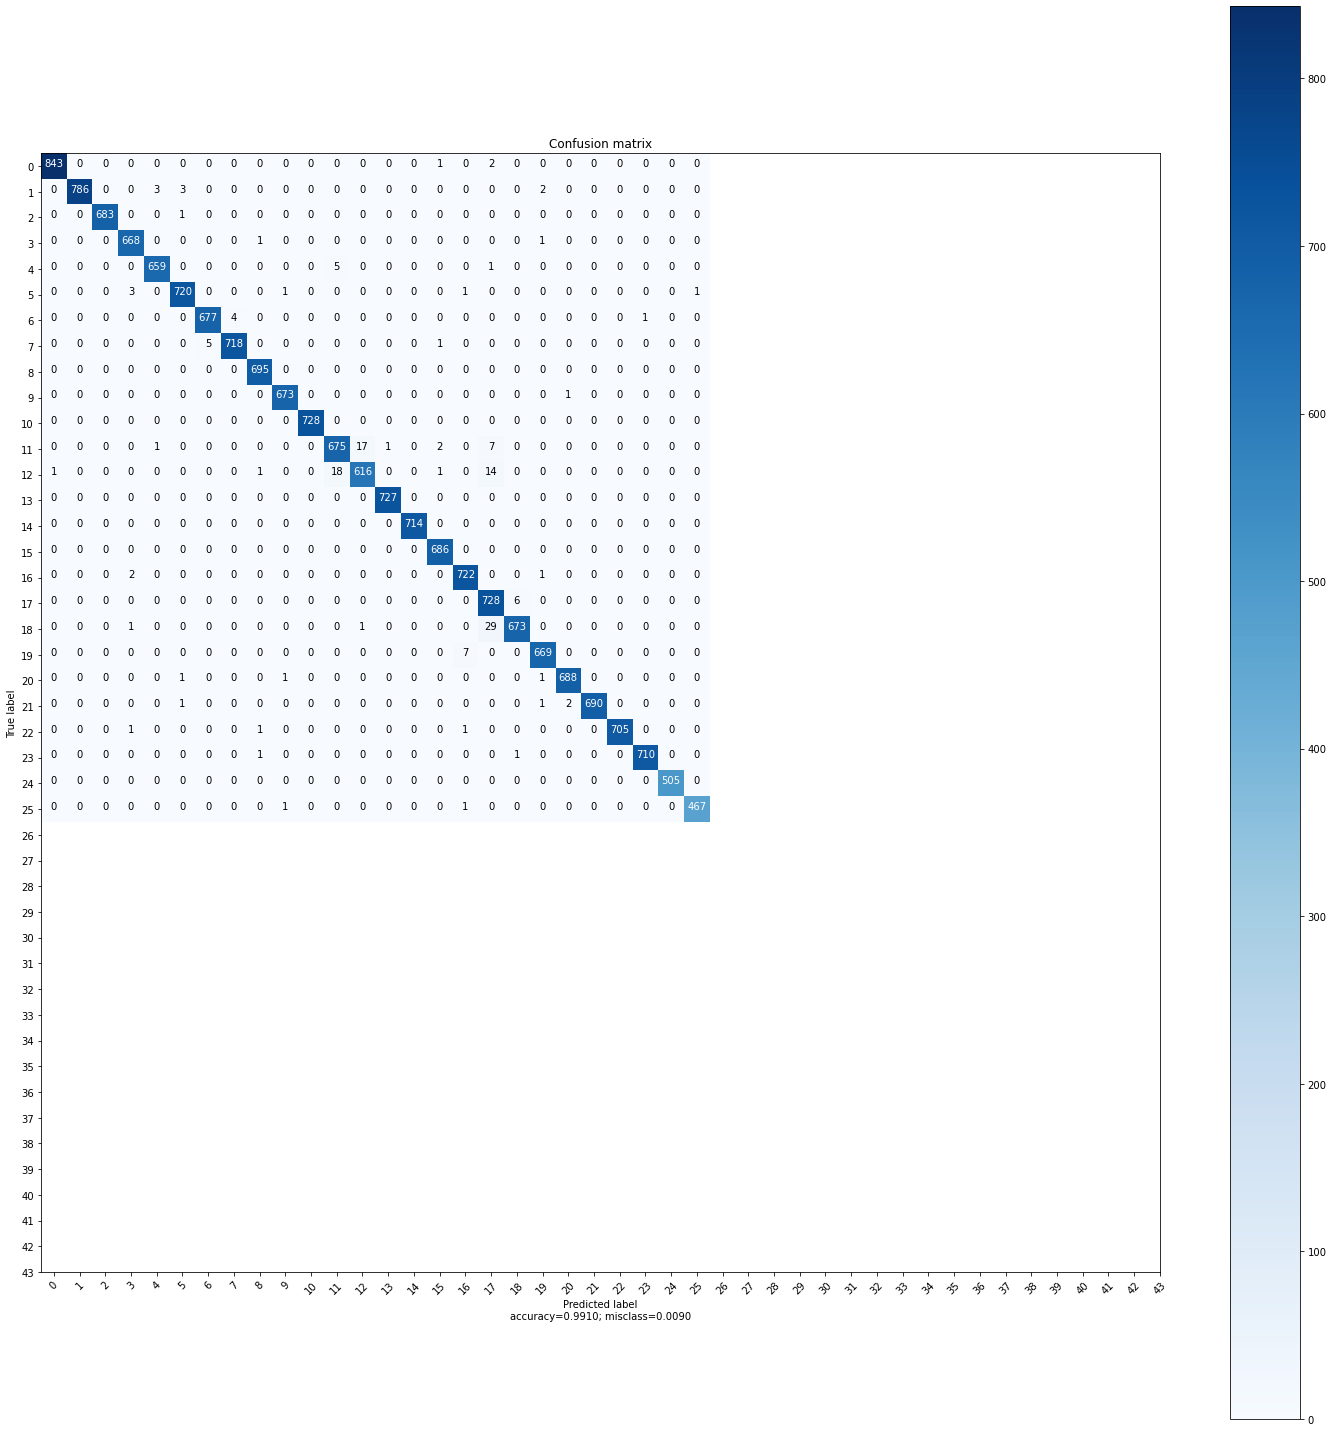

In [8]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion_matrix.png')


image_x, image_y = 50, 50
with open("test_images", "rb") as f:
    test_images = np.array(pickle.load(f))
with open("test_labels", "rb") as f:
    test_labels = np.array(pickle.load(f), dtype=np.int32)
test_images = np.reshape(test_images, (test_images.shape[0], image_x, image_y, 1))


model = load_model('cnn_model_keras_gf_2.h5')
pred_labels = []

start_time = time.time()
pred_probabs = model.predict(test_images)
end_time = time.time()
pred_time = end_time-start_time
avg_pred_time = pred_time/test_images.shape[0]
print("Time taken to predict %d test images is %ds" %(test_images.shape[0], pred_time))
print('Average prediction time: %fs' % (avg_pred_time))

for pred_probab in pred_probabs:
    pred_labels.append(list(pred_probab).index(max(pred_probab)))

cm = confusion_matrix(test_labels, np.array(pred_labels))
classification_report = classification_report(test_labels, np.array(pred_labels))
print('\n\nClassification Report') 
print('---------------------------')
print(classification_report)
plot_confusion_matrix(cm, range(44), normalize=False)

## Predict live data through web cam

In [3]:
import cv2, pickle
import numpy as np
import tensorflow as tf
import os
import sqlite3
from keras.models import load_model
import pyttsx3  
import string


engine = pyttsx3.init() 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
prediction = None
model = load_model('cnn_model_keras_gf_2.h5')

def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
        else:
            return False
        
def get_image_size():
    img = cv2.imread('gestures2/1/100.jpg', 0)
    return img.shape

image_x, image_y = get_image_size()



def keras_process_image(img):
    img = cv2.resize(img, (image_x, image_y))
    img = np.array(img, dtype=np.float32)
    img = np.reshape(img, (1, image_x, image_y, 1))
    return img

def keras_predict(model, image):
    processed = keras_process_image(image)
    pred_probab = model.predict(processed)[0]
    pred_class = list(pred_probab).index(max(pred_probab))
    return max(pred_probab), pred_class

def get_pred_text_from_db(pred_class):
    conn = sqlite3.connect("gesture_db.db")
    cmd = "SELECT g_name FROM gesture WHERE g_id="+str(pred_class)
    cursor = conn.execute(cmd)
    for row in cursor:
        return row[0]

def split_sentence(text, num_of_words):
    '''
    Splits a text into group of num_of_words
    '''
    list_words = text.split(" ")
    length = len(list_words)
    splitted_sentence = []
    b_index = 0
    e_index = num_of_words
    while length > 0:
        part = ""
        for word in list_words[b_index:e_index]:
            part = part + " " + word
        splitted_sentence.append(part)
        b_index += num_of_words
        e_index += num_of_words
        length -= num_of_words
    return splitted_sentence


def get_hand_hist():
    with open("hist", "rb") as f:
        hist = pickle.load(f)
    return hist

def recognize():
    global prediction
    cam = cv2.VideoCapture(0)
    if cam.read()[0] == False:
        cam = cv2.VideoCapture(0)
    hist = get_hand_hist()
    x, y, w, h = 300, 100, 300, 300
    d = dict.fromkeys(string.ascii_lowercase, 0)
    d[''] = 0
    d['space'] = 0
    d['ok'] = 0
    word = []
    sentence = []
    while True:
        text = ""
        img = cam.read()[1]
        img = cv2.flip(img, 1)
        img = cv2.resize(img, (640, 480))
        imgCrop = img[y:y+h, x:x+w]
        imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([imgHSV], [0, 1], hist, [0, 180, 0, 256], 1)
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
        cv2.filter2D(dst,-1,disc,dst)
        blur = cv2.GaussianBlur(dst, (11,11), 0)
        blur = cv2.medianBlur(blur, 11)
        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        thresh = cv2.threshold(th3, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
        thresh = cv2.merge((thresh,thresh,thresh))
        thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
        thresh = thresh[y:y+h, x:x+w]
        
        (openCV_ver,_,__) = cv2.__version__.split(".")
        if openCV_ver=='3':
            contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[1]
        elif openCV_ver=='4':
            contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
        if len(contours) > 0:
            contour = max(contours, key = cv2.contourArea)
            #print(cv2.contourArea(contour))
            if cv2.contourArea(contour) > 10000:
                x1, y1, w1, h1 = cv2.boundingRect(contour)
                save_img = thresh[y1:y1+h1, x1:x1+w1]

                if w1 > h1:
                    save_img = cv2.copyMakeBorder(save_img, int((w1-h1)/2) , int((w1-h1)/2) , 0, 0, cv2.BORDER_CONSTANT, (0, 0, 0))
                elif h1 > w1:
                    save_img = cv2.copyMakeBorder(save_img, 0, 0, int((h1-w1)/2) , int((h1-w1)/2) , cv2.BORDER_CONSTANT, (0, 0, 0))
    
                pred_probab, pred_class = keras_predict(model, save_img)
                
                if pred_probab*100 > 93:
                    text = get_pred_text_from_db(pred_class)
                    #print(text)
                    #engine.say(text) 
                    #engine.runAndWait()
                        
                    if text == '':
                        continue
                    if text == 'ok' and d['ok'] == 5 and len(sentence) != 0:
                        sentence = ' '.join([str(elem) for elem in sentence])
                        print(sentence)
                        #print(sentence)
                        engine.say(sentence) 
                        engine.runAndWait()
                        sentence = []
                    if text == 'space' and d['space'] == 5:
                        text = ''.join([str(elem) for elem in word])        
                        print(text)
                        engine.say(text) 
                        engine.runAndWait()
                        sentence.append(text)
                        word = []
                        text = ''
                        
                    d[text] += 1
                    #print(d)
                    if d[text] == 10 and text != 'ok':
                        #print(text)
                        word.append(text)
                        print(word)
                        d = dict.fromkeys(d, 0)
                        engine.say(text) 
                        engine.runAndWait()
                    
                            
                        

        cv2.putText(img, text, (30, 200), cv2.FONT_HERSHEY_TRIPLEX, 1.3, (255, 255, 255))
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)

        cv2.imshow("Recognizing gesture", img)
        cv2.imshow("thresh", thresh)
        if cv2.waitKey(1) == ord('z'):
            break

keras_predict(model, np.zeros((50, 50), dtype=np.uint8))
recognize()
cv2.destroyAllWindows()

['x']
['x', 'a']
['x', 'a', 'u']
['x', 'a', 'u', 'u']
['x', 'a', 'u', 'u', 'c']
['x', 'a', 'u', 'u', 'c', 'd']
['x', 'a', 'u', 'u', 'c', 'd', 'e']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x', 'x']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x', 'x', 'q']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x', 'x', 'q', 'q']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x', 'x', 'q', 'q', 'h']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x', 'x', 'q', 'q', 'h', 'h']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x', 'x', 'q', 'q', 'h', 'h', 'i']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x', 'x', 'q', 'q', 'h', 'h', 'i', 'k']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x', 'x', 'q', 'q', 'h', 'h', 'i', 'k', 'l']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x', 'x', 'q', 'q', 'h', 'h', 'i', 'k', 'l', 'x']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x', 'x', 'q', 'q', 'h', 'h', 'i', 'k', 'l', 'x', 'x']
['x', 'a', 'u', 'u', 'c', 'd', 'e', 'x', 'x', 'q', 'q', 'h', 'h', 'i', 'k', 'l', 'x', 'x', 'x']
['x', 'a', 'u', 'u', 'c', 'd', 

In [1]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [12]:
import pyttsx3  
# initialize Text-to-speech engine  
engine = pyttsx3.init()  
# convert this text to speech  
text = "Python is a great programming language"  
engine.say(text)  
# play the speech  
engine.runAndWait() 

In [5]:
import string
d = dict.fromkeys(string.ascii_lowercase, 0)
print(d)

{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': 0, 'g': 0, 'h': 0, 'i': 0, 'j': 0, 'k': 0, 'l': 0, 'm': 0, 'n': 0, 'o': 0, 'p': 0, 'q': 0, 'r': 0, 's': 0, 't': 0, 'u': 0, 'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0}


In [1]:
d = dict.fromkeys(string.ascii_lowercase, 0)
text = ' '.join([str(elem) for elem in word])

NameError: name 'string' is not defined

In [7]:
import pandas as pd
import sqlite3
import sqlalchemy 

try:
    conn = sqlite3.connect("gesture_db.db")    
except Error as e:
    print(e)

#Now in order to read in pandas dataframe we need to know table name
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

df = pd.read_sql_query('SELECT * FROM gesture', conn)
print(df)
conn.close()

Table Name : [('gesture',), ('sqlite_sequence',)]
    g_id g_name
0      0   test
1      1      a
2      2      b
3      3      c
4      4      d
5      5      e
6      6      f
7      7      g
8      8      h
9      9      i
10    10      k
11    11      l
12    12      m
13    13      n
14    14      o
15    15      p
16    16      q
17    17      r
18    18      s
19    19      t
20    20      u
21    21      v
22    22      w
23    23      x
24    24      y
25    25  space
26    26     ok
27    30   blip
28    45     rt
29    90     as


## Get Skin masking histograph

In [24]:
import cv2
import numpy as np
import pickle

def build_squares(img):
    x, y, w, h = 400, 50, 10, 10
    d = 10
    imgCrop = None
    crop = None
    for i in range(10):
        for j in range(10):
            if np.any(imgCrop == None):
                imgCrop = img[y:y+h, x:x+w]
            else:
                imgCrop = np.hstack((imgCrop, img[y:y+h, x:x+w]))
            #print(imgCrop.shape)
            cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 1)
            x+=w+d
        if np.any(crop == None):
            crop = imgCrop
        else:
            crop = np.vstack((crop, imgCrop)) 
        imgCrop = None
        x = 400
        y+=h+d
    return crop


def get_hand_hist():
    cam = cv2.VideoCapture(0)
    if cam.read()[0]==False:
        cam = cv2.VideoCapture(0)
    x, y, w, h = 300, 50, 300, 300
    flagPressedC, flagPressedS = False, False
    imgCrop = None
    while True:
        img = cam.read()[1]
        img = cv2.flip(img, 1)
        img = cv2.resize(img, (640, 480))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        keypress = cv2.waitKey(1)
        if keypress == ord('c'):
            hsvCrop = cv2.cvtColor(imgCrop, cv2.COLOR_BGR2HSV)
            flagPressedC = True
            hist = cv2.calcHist([hsvCrop], [0, 1], None, [180, 256], [0, 180, 0, 256])
            cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
        elif keypress == ord('s'):
            flagPressedS = True	
            break
        if flagPressedC:
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            dst = cv2.calcBackProject([hsv], [0, 1], hist, [0, 180, 0, 256], 1)
            disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
            cv2.filter2D(dst, -1, disc, dst)
            ret, thresh = cv2.threshold(dst, 150, 255, cv2.THRESH_BINARY)
            # thresh = cv2.dilate(thresh, None, iterations=5)
            thresh = cv2.merge((thresh, thresh, thresh))
            img = cv2.bitwise_and(img, thresh)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
            blur = cv2.GaussianBlur(gray,(5,5),2)
            th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
            ret, thresh = cv2.threshold(th3, 78, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            #cv2.imshow("res", res)
            cv2.imshow("Thresh", thresh)
            #cv2.imshow("SkinMasking", img)
        if not flagPressedS:
            imgCrop = build_squares(img)
        if keypress == 27:
            cv2.destroyAllWindows()
            break
        #cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.imshow("Set hand histogram", img)
    cam.release()
    cv2.destroyAllWindows()
    with open("hist", "wb") as f:
        pickle.dump(hist, f)


get_hand_hist()

In [19]:
import cv2
import numpy as np
import sys


video = cv2.VideoCapture(0)
#oceanVideo = cv2.VideoCapture("ocean.mp4")
success, ref_img = video.read()
flag = 0

while(1):
    success, ref_img = video.read()
    hsv = cv2.cvtColor(success, cv2.COLOR_BGR2HSV)

    (h,s,v) = cv2.split(hsv)
    v[:] = 100
    img = cv2.merge((v, v, s))
    rgb = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)	
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)	

    cv2.imshow("img", img)
    cv2.imshow("rgb", rgb)
    cv2.imshow("gray", gray)

cv2.destroyAllWindows()
video.release()
#return jpeg.tobytes()

error: OpenCV(4.5.1) c:\users\appveyor\appdata\local\temp\1\pip-req-build-oduouqig\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xd4b82fcf::Set<3,-1,-1>,struct cv::impl::A0xd4b82fcf::Set<0,5,-1>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


## Create gesture (Guassian blur with skin masking)

In [36]:
import cv2
import numpy as np
import pickle, os, sqlite3, random

image_x, image_y = 50, 50

def get_hand_hist():
    with open("hist", "rb") as f:
        hist = pickle.load(f)
    return hist

def init_create_folder_database():
    if not os.path.exists("gestures_skinmask"):
        os.mkdir("gestures_skinmask")
    if not os.path.exists("gesture_db.db"):
        conn = sqlite3.connect("gesture_db.db")
        create_table_cmd = "CREATE TABLE gesture ( g_id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, g_name TEXT NOT NULL )"
        conn.execute(create_table_cmd)
        conn.commit()

def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

def store_in_db(g_id, g_name):
    conn = sqlite3.connect("gesture_db.db")
    cmd = "INSERT INTO gesture (g_id, g_name) VALUES (%s, \'%s\')" % (g_id, g_name)
    try:
        conn.execute(cmd)
    except sqlite3.IntegrityError:
        choice = input("g_id already exists. Want to change the record? (y/n): ")
        if choice.lower() == 'y':
            cmd = "UPDATE gesture SET g_name = \'%s\' WHERE g_id = %s" % (g_name, g_id)
            conn.execute(cmd)
        else:
            print("Doing nothing...")
            return
    conn.commit()

    
def store_images(g_id):
    total_pics = 6000
    cam = cv2.VideoCapture(0)
    if cam.read()[0]==False:
        cam = cv2.VideoCapture(0)
    x, y, w, h = 300, 50, 300, 300
    create_folder("gestures_skinmask/"+str(g_id))
    pic_no = 4000
    flag_start_capturing = False
    frames = 0
    hist = get_hand_hist()
    while True:
        img = cam.read()[1]
        img = cv2.flip(img, 1)
        imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        imghsv = imgHSV[y:y+h, x:x+w]
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0, 1], hist, [0, 180, 0, 256], 1)
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
        cv2.filter2D(dst, -1, disc, dst)
        ret, thresh = cv2.threshold(dst, 150, 255, cv2.THRESH_BINARY)
        # thresh = cv2.dilate(thresh, None, iterations=5)
        thresh = cv2.merge((thresh, thresh, thresh))
        img = cv2.bitwise_and(img, thresh)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
        blur = cv2.GaussianBlur(gray,(5,5),2)
        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        ret, thresh = cv2.threshold(th3, 78, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
       # ret, thresh = cv2.threshold(th3, 78, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        thresh = thresh[y:y+h, x:x+w]
        tmp = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        contours = tmp[0] if len(tmp) == 2 else tmp[1]

        if len(contours) > 0:
            contour = max(contours, key = cv2.contourArea)
            if cv2.contourArea(contour) > 10000 and frames > 50:
                x1, y1, w1, h1 = cv2.boundingRect(contour)
                pic_no += 1
                save_img = thresh[y1:y1+h1, x1:x1+w1]
                if w1 > h1:
                    save_img = cv2.copyMakeBorder(save_img, int((w1-h1)/2) , int((w1-h1)/2) , 0, 0, cv2.BORDER_CONSTANT, (0, 0, 0))
                elif h1 > w1:
                    save_img = cv2.copyMakeBorder(save_img, 0, 0, int((h1-w1)/2) , int((h1-w1)/2) , cv2.BORDER_CONSTANT, (0, 0, 0))
                save_img = cv2.resize(save_img, (image_x, image_y))
                rand = random.randint(0, 10)
                if rand % 2 == 0:
                    save_img = cv2.flip(save_img, 1)
                cv2.putText(img, "Capturing...", (30, 60), cv2.FONT_HERSHEY_TRIPLEX, 2, (127, 255, 255))
                cv2.imwrite("gestures_skinmask/"+str(g_id)+"/"+str(pic_no)+".jpg", save_img)

        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(img, str(pic_no), (30, 400), cv2.FONT_HERSHEY_TRIPLEX, 1.5, (127, 127, 255))
        cv2.imshow("Capturing gesture", img)
        cv2.imshow("thresh", thresh)
        keypress = cv2.waitKey(1)
        if keypress == ord('c'):
            if flag_start_capturing == False:
                flag_start_capturing = True
            else:
                flag_start_capturing = False
                frames = 0
        if flag_start_capturing == True:
            frames += 1
        if pic_no == total_pics:
            cv2.destroyAllWindows()
            break
        if keypress == 27:
            cv2.destroyAllWindows()
            break

init_create_folder_database()
g_id = input("Enter gesture no.: ")
g_name = input("Enter gesture name/text: ")
store_in_db(g_id, g_name)
store_images(g_id)


Enter gesture no.: 4
Enter gesture name/text: d
g_id already exists. Want to change the record? (y/n): y


In [3]:
import cv2
import numpy as np

hand_hist = None
traverse_point = []
total_rectangle = 9
hand_rect_one_x = None
hand_rect_one_y = None

hand_rect_two_x = None
hand_rect_two_y = None


def rescale_frame(frame, wpercent=130, hpercent=130):
    width = int(frame.shape[1] * wpercent / 100)
    height = int(frame.shape[0] * hpercent / 100)
    return cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)


def contours(hist_mask_image):
    gray_hist_mask_image = cv2.cvtColor(hist_mask_image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray_hist_mask_image, 0, 255, 0)
    #cont = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    tmp = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cont = tmp[0] if len(tmp) == 2 else tmp[1]
    return cont

def draw_rect(frame):
    rows, cols, _ = frame.shape
    global total_rectangle, hand_rect_one_x, hand_rect_one_y, hand_rect_two_x, hand_rect_two_y

    hand_rect_one_x = np.array(
        [6 * rows / 20, 6 * rows / 20, 6 * rows / 20, 9 * rows / 20, 9 * rows / 20, 9 * rows / 20, 12 * rows / 20,
         12 * rows / 20, 12 * rows / 20], dtype=np.uint32)

    hand_rect_one_y = np.array(
        [9 * cols / 20, 10 * cols / 20, 11 * cols / 20, 9 * cols / 20, 10 * cols / 20, 11 * cols / 20, 9 * cols / 20,
         10 * cols / 20, 11 * cols / 20], dtype=np.uint32)

    hand_rect_two_x = hand_rect_one_x + 10
    hand_rect_two_y = hand_rect_one_y + 10

    for i in range(total_rectangle):
        cv2.rectangle(frame, (hand_rect_one_y[i], hand_rect_one_x[i]),
                      (hand_rect_two_y[i], hand_rect_two_x[i]),
                      (0, 255, 0), 1)

    return frame


def hand_histogram(frame):
    global hand_rect_one_x, hand_rect_one_y

    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    roi = np.zeros([90, 10, 3], dtype=hsv_frame.dtype)

    for i in range(total_rectangle):
        roi[i * 10: i * 10 + 10, 0: 10] = hsv_frame[hand_rect_one_x[i]:hand_rect_one_x[i] + 10,
                                          hand_rect_one_y[i]:hand_rect_one_y[i] + 10]

    hand_hist = cv2.calcHist([roi], [0, 1], None, [180, 256], [0, 180, 0, 256])
    return cv2.normalize(hand_hist, hand_hist, 0, 255, cv2.NORM_MINMAX)


def hist_masking(frame, hist):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    dst = cv2.calcBackProject([hsv], [0, 1], hist, [0, 180, 0, 256], 1)

    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
    cv2.filter2D(dst, -1, disc, dst)

    ret, thresh = cv2.threshold(dst, 150, 255, cv2.THRESH_BINARY)

    # thresh = cv2.dilate(thresh, None, iterations=5)

    thresh = cv2.merge((thresh, thresh, thresh))

    return cv2.bitwise_and(frame, thresh)




def manage_image_opr(frame, hand_hist):
    hist_mask_image = hist_masking(frame, hand_hist)

    return hist_mask_image




def main():
    global hand_hist
    is_hand_hist_created = False
    capture = cv2.VideoCapture(0)

    while True:
        pressed_key = cv2.waitKey(1)
        _, frame = capture.read()
        frame = cv2.flip(frame, 1)

        if pressed_key & 0xFF == ord('z'):
            is_hand_hist_created = True
            hand_hist = hand_histogram(frame)

        if is_hand_hist_created:
            frame = hist_masking(frame, hand_hist)

        else:
            frame = draw_rect(frame)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)        
        blur = cv2.GaussianBlur(gray,(5,5),2)
        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        ret, thresh = cv2.threshold(th3, 78, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        cv2.imshow("Live Feed", frame)
        cv2.imshow("thresh", thresh)
        if pressed_key == 27:
            cv2.destroyAllWindows()
            capture.release()
            break

    cv2.destroyAllWindows()
    capture.release()


if __name__ == '__main__':
    main()
        